In [4]:
%load_ext autoreload
% autoreload 2
from __future__ import print_function
import argparse
import os, datetime
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
print(torch.__version__)
from geant_dataloader import rtnpy_load_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from torch.autograd import grad
#from logistics import sigmoid_normalize, logistic_unnormalize, tanh_normalize, arctanh_unnormalize
import logistics
from logistics import *
from matplotlib import gridspec
plt.rc('font', family='serif')
from decimal import Decimal

SyntaxError: import * only allowed at module level (cell_name, line 2)

In [12]:
workers = 2
batchSize = 32
imageSize =32
nz = 150
ngf = 64
ndf = 64
nc = 1
niter = 50
lr = 1e-4
beta1 = 0.5
cuda = 'store_true'
netG_path = "output/"
netD_path = "output/"
outf = "output/"
manualSeed = 25
ngpu = 1
mydir=None # will be updated before the run
epoch=0 #will be updated during the run
extraD = 3
epochs = []
genx_FWHMs = []
genx_means = []
realx_FWHMs = []
realx_means =  []


norm_scale = 'unif'

try:
    os.makedirs(outf)
except OSError:
    pass



In [13]:
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

cudnn.benchmark = True
dev_type = 'cpu'
if torch.cuda.is_available():
    print("Using Cuda")
    dev_type = 'gpu'
    
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print("Using:", dev_type, torch.cuda.current_device())


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Random Seed:  25
Using Cuda
cuda:1
Using: gpu 0


In [14]:
# LOAD DATA:

#image_array = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_20000Events_64OldSize_32NewSize.npy", image_size = imageSize)
image_array = rtnpy_load_data("numpy_data/geant4Data_30000Events_"+str(imageSize) + "ImageSize_800MeV_ScintiAbsoThickness75_8.npz", image_size = imageSize)


In [15]:

normed_array, scale = normalize(image_array, norm_scale = norm_scale )
print(image_array.shape)
tensor_array = torch.stack([torch.tensor(i, requires_grad =False).type(torch.FloatTensor) for i in normed_array])
tensor_data = torch.utils.data.TensorDataset(tensor_array)
dataloader = torch.utils.data.DataLoader(tensor_data, batch_size=batchSize, num_workers=8)
dataloader

(30000, 1, 32, 32)


In [16]:
if norm_scale == 'unif':
    last_layer = nn.Sigmoid()
elif norm_scale == 'none' or norm_scale =='0to5':
    last_layer = nn.ReLU()
else:
    last_layer = nn.Sigmoid()


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            #nn.Tanh()
            last_layer
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

class Generator32(nn.Module):
    def __init__(self, ngpu):
        super(Generator32, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            #inc, outc, kernel, stride, padding, output padding
#             nn.ConvTranspose2d(     nz, 32 * 8, 2, 1, 0, bias=False),
#             nn.BatchNorm2d(32 * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 2 x 2
#             nn.ConvTranspose2d(32 * 8, 32 * 4, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 4 x 4
#             nn.ConvTranspose2d(32 * 4, 32 * 2, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 8 x 8
#             nn.ConvTranspose2d(32 * 2,     32, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32),
#             nn.ReLU(True),
#             # state size. (ngf) x 16 x 16
#             nn.ConvTranspose2d(    32,      nc, 2, 2, 0, bias=False),
#             last_layer
#             # state size. (nc) x 64 x 64
            
            nn.ConvTranspose2d(     nz, 32 * 8, 2, 1, 0, bias=False),
            nn.BatchNorm2d(32 * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 2 x 2
            nn.ConvTranspose2d(32 * 8, 32 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(32 * 4, 32 * 2, 5, 1, 0, bias=False),
            nn.BatchNorm2d(32 * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(32 * 2,     32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(    32,      nc, 4, 2, 0, bias=False),
            last_layer
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output
    
    
if imageSize == 32:
    netG = Generator32(ngpu).to(device)
else:
    netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            # kernel size = 4 (so I image 4 x 4 x 1)
            # stride = 2, 
            # padding = 1
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)
    
class Discriminator32(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator32, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            # kernel size = 4 (so kernel filter 4 x 4 x 1)
            # stride = 2, 
            # padding = 0
#             nn.Conv2d(nc, 32, 2, 2, 0, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 16 x 16
#             nn.Conv2d(32, 32 * 2, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 8 x 8
#             nn.Conv2d(32 * 2, 32 * 4, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 4 x 4
#             nn.Conv2d(32 * 4, 32 * 8, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 2 x 2
#             nn.Conv2d(32 * 8, 1, 2, 2, 0, bias=False),
#             nn.Sigmoid()
            nn.Conv2d(nc, ndf, 5, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 5, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 2, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2,inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 3, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

if imageSize == 32:
    netD = Discriminator32(ngpu).to(device)
else:
    netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#if opt.netD != '':
#    netD.load_state_dict(torch.load(opt.netD))
print(netD)
#if netG != '':
#    netG.load_state_dict(torch.load(netG))
#print(netG)

Generator32(
  (main): Sequential(
    (0): ConvTranspose2d(150, 256, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (13): Sigmoid()
  )
)
Discriminator32(
  (main): Sequential(
    (0): Co

In [17]:
def make_samples(netG, n_events=500, real=True, fake = True, avg= True, scale = scale, norm_scale = norm_scale ):

    #test_image = 0#fake.to('cpu').detach().numpy()[0][0]
    fake_image = 0 #arctanh_unnormalize(test_image, scale)
    real_image = 0
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image += image_array[idx][0]
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake_output = netG(noise)
        gen_image = fake_output.to('cpu').detach().numpy()[0][0]
        fake_image +=  unnormalize(gen_image, scale, norm_scale = norm_scale)
        #fake_image += logistic_unnormalize(test_image, scale)
    if avg == True:
        fake_image = fake_image / n_events
        real_image = real_image / n_events

    #test_noNans = np.copy(test_unnormed)
    #test_unnormed[test_unnormed < 0.0] = np.nan
    if real == True and fake == True:
        return [real_image,fake_image], n_events
    elif (real == False) and (fake == True):
        return fake_image, n_events
    else:
        return real_image, n_events
    
    
    


def make_stacked_samples(netG, n_events, real=False, fake=True, norm_scale = norm_scale, scale = scale):
    fake_images = []
    real_images = []
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image = image_array[idx][0]
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake_output = netG(noise)
        fake_image = fake_output.to('cpu').detach().numpy()[0][0]
        fake_image = unnormalize(fake_image,scale, norm_scale = norm_scale)
        fake_images.append(fake_image)
        real_images.append(real_image)
        
    fake_images_array = np.dstack(fake_images).T
    real_images_array = np.dstack(real_images).T
    if real == True and fake == True:
        return real_images_array,fake_images_array
    elif (real == False) and (fake == True):
        return fake_images_array
    else:
        return real_images_array


def plot_avg(data, n_events, withMarginals=True, save_dir = mydir, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr):

    test_noNans = np.copy(data)
    test_unnormed = data
    test_unnormed[test_unnormed < 0.0] = np.nan
    
    fig=plt.figure(figsize=(6, 6))
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.935, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    #real_data = np.ma.masked_where(real_data < 0.1, real_data)
    #test_unnormed = np.ma.masked_where(test_unnormed < 0.1, test_unnormed)
    #cmap.set_bad(color=[0.956753086395383, 0.8772710654899895, 0.827316825332932])
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()
    #cmap = plt.cm.bone_r
    
    if withMarginals == False:
        marginals_str = 'woMarginals'
        plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
        cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
        cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        if save_dir != None:
            #directory = "/home/chris/Documents/MPhilProjects/ForViewing/Geant4/SingleLayerEGun/AverageImage/"
            filename = "DCROTHGAN_AvgEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                        + "Image_Epochs" + str(epoch) + "_" + str(batchSize) + "batchSize_" +  str(lr) + "lr"
            plt.savefig(directory + filename)
        
    else:
        marginals_str = 'withMarginals'
        img=test_noNans
        t = np.arange(-50,50, 100/float(imageSize))
        #t = np.arange(img.shape[0])
        f = np.arange(-50,50, 100/float(imageSize))
        #f = np.arange(img.shape[1])
        flim = (f.min(), f.max())
        tlim = (t.min(), t.max())

        gs = gridspec.GridSpec(2, 2, width_ratios=[1,5], height_ratios=[1,5])
        gs.update(hspace=0, wspace=0)

        ax = fig.add_subplot(gs[1,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent = extent, origin = 'lower', cmap = cmap)
        ax.text(-45, 39, 'DCGAN-DP', color='black', 
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        cbaxes = fig.add_axes([0.97, 0.18, 0.03, 0.55]) 
        cbar = plt.colorbar(mappable=im, ticks = None, cax=cbaxes, use_gridspec=True)
        ax.yaxis.set_ticks_position('right')
        cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        ax.spines["top"].set_visible(False)
        ax.spines['left'].set_visible(False)

        axl = fig.add_subplot(gs[1,0], sharey=ax)
        axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
        axl.invert_xaxis()
        axb = fig.add_subplot(gs[0,1], sharex=ax)
        axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])

        plt.setp(axl.get_yticklabels(), visible=False)
        plt.setp(axb.get_xticklabels(), visible=False)
        plt.setp(axl.get_xticklabels(), visible=False)
        plt.setp(axb.get_yticklabels(), visible=False)

        axl.yaxis.set_ticks_position('none')
        axb.xaxis.set_ticks_position('none')
        axl.xaxis.set_ticks_position('none')
        axb.yaxis.set_ticks_position('none')


        axl.spines["top"].set_visible(False)
        axl.spines['right'].set_visible(False)
        axl.spines['left'].set_visible(False)
        axl.spines['bottom'].set_visible(False)
        axb.spines["top"].set_visible(False)
        axb.spines["right"].set_visible(False)
        axb.spines["left"].set_visible(False)
        axb.spines["bottom"].set_visible(False)
        ax.set_xlim(tlim)
        ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
        ax.xaxis.set_label_coords(0.02,-0.05)
        ax.set_ylim(tlim)
        ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
        ax.yaxis.set_label_coords(1.07,0.98)
        if save_dir != None:
            learning_rate = '%.0E' % Decimal(lr)
            #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
            filename = "DCROTHGAN_AvgEdep"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                        + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
            plt.savefig(save_dir + filename, bbox_inches='tight')
        plt.show()
    return

def plot_samples(n_samples = 3 ):
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    vmin = 0.1
    vmax = 2.0
    fig, ax_arr = plt.subplots(1, n_samples, figsize=(10,10), sharey = True, sharex=True)
    i = 0
    for ax in ax_arr.flatten():
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        test_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed =  arctanh_unnormalize(test_image, scale)
        test_unnormed[test_unnormed < 0.1] = np.nan
        cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
        if i == 0:   
            cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
        i+=1
    plt.show()
    return

def plot_sns(n_events = 500, n_samples = 3, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
    fig, axn = plt.subplots(1, n_samples, figsize=(12,4), sharex=True, sharey=True)
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran

    #xticks = [-50,-25,0,25,50]
    #yticks = [-50,-25,0,25,50]
    for i, ax in enumerate(axn.flat):
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake = netG(noise)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        if i != 0:
            ax.spines['left'].set_visible(False)
        if i == 0:
            ax.set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
            ax.set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
        ax.set_title("Ex " +str(i), x =0.85, y = 0.88, alpha=0.6, fontweight='heavy', fontsize=11)
        test_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed =  unnormalize(test_image, scale)
        #test_unnormed = logistic_unnormalize(test_image, scale)
        test_unnormed[test_unnormed < 0.1] = np.nan
        cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
        #sns.heatmap(test_unnormed, ax=ax, cmap=cmap,
        #            cbar=i == 0, cbar_ax=None if i else cbar_ax, square=True,
        #            vmin = 0, vmax = 80, xticklabels = xticks, yticklabels=xticks)
        im = ax.imshow(test_unnormed, vmin = 0, vmax=10, extent=extent, origin='lower', cmap=cmap)
        ax.tick_params(axis=u'both', which=u'both',length=0)

    fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
    fig.colorbar(im, cax=cbar_ax)
    fig.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle("Samples of Generated Electron Gun Energy Depositions",x=0.5,y=0.99)
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_3SampleEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    return



def plot_avg_both(real_data, fake_data, n_events, withMarginals=True, save_dir=None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    fig=plt.figure(figsize=(10,5))
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran

    #real_data = real_image
    img = real_data
    test_unnormed = fake_data
    test_noNans = np.copy(test_unnormed)
    img2 = test_noNans
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())


    gs = gridspec.GridSpec(2, 4, width_ratios=[5,1,1,5], height_ratios=[1,5])
    gs.update(hspace=0, wspace=0)
    ax1 = fig.add_subplot(gs[1,0])
    axl = fig.add_subplot(gs[1,1], sharey=ax1)
    axb = fig.add_subplot(gs[0,0], sharex=ax1)
    ax2 = fig.add_subplot(gs[1,3])
    axl2= fig.add_subplot(gs[1,2], sharey=ax2)
    axb2= fig.add_subplot(gs[0,3], sharex=ax2)
    plt.setp(axl.get_yticklabels(), visible=False)
    plt.setp(axb.get_xticklabels(), visible=False)
    plt.setp(axl.get_xticklabels(), visible=False)
    plt.setp(axb.get_yticklabels(), visible=False)
    plt.setp(axl2.get_yticklabels(), visible=False)
    plt.setp(axb2.get_xticklabels(), visible=False)
    plt.setp(axl2.get_xticklabels(), visible=False)
    plt.setp(axb2.get_yticklabels(), visible=False)
    axl.yaxis.set_ticks_position('none')
    axb.xaxis.set_ticks_position('none')
    axl.xaxis.set_ticks_position('none')
    axb.yaxis.set_ticks_position('none')
    axl2.yaxis.set_ticks_position('none')
    axb2.xaxis.set_ticks_position('none')
    axl2.xaxis.set_ticks_position('none')
    axb2.yaxis.set_ticks_position('none')
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.915, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    im = ax1.imshow(real_data, vmin = 0, extent =extent, origin='lower', cmap=cmap)
    ax1.spines["top"].set_visible(False)
    ax1.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.915, gamma=2.5, hue=1).as_hex()
    axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
    axl.spines["top"].set_visible(False)
    axl.spines['right'].set_visible(False)
    axl.spines['left'].set_visible(False)
    axl.spines['bottom'].set_visible(False)
    axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])
    axb.spines["top"].set_visible(False)
    axb.spines["right"].set_visible(False)
    axb.spines["left"].set_visible(False)
    axb.spines["bottom"].set_visible(False)
    ax1.set_xlim(tlim)
    
    ax1.set_ylim(tlim)


    #RECONSIDER TAKING OUT THE LESS THAN 0 VALUES
    real_data[real_data < 0.0] = np.nan 


    test_unnormed[test_unnormed < 0.0] = np.nan

    im = ax2.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
    ax2.spines["top"].set_visible(False)
    ax2.spines['left'].set_visible(False)
    axl2.fill_between(img2.mean(1), f, alpha = 0.7, color = color_list[1])
    axl2.invert_xaxis()
    axl2.spines["top"].set_visible(False)
    axl2.spines['right'].set_visible(False)
    axl2.spines['left'].set_visible(False)
    axl2.spines['bottom'].set_visible(False)
    axb2.fill_between(t, img2.mean(0), alpha =0.7, color= color_list[1])
    axb2.spines["top"].set_visible(False)
    axb2.spines["right"].set_visible(False)
    axb2.spines["left"].set_visible(False)
    axb2.spines["bottom"].set_visible(False)
    ax2.set_xlim(tlim)
    ax2.set_ylim(tlim)

    ax1.set_xlabel("Real", fontsize=12)  
    ax2.set_xlabel("Generator", fontsize=12)
    ax1.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax1.yaxis.set_label_coords(-0.07,0.98)
    fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.45])
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
    plt.figtext(0.05,0.060,r"$\mathit{x}$", fontsize = 12)
    fig.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle(r" DCGAN-DP Avg $E_{dep}$ Over " + str(n_events) + " Events, "
                 + str(imageSize) + "x" +str(imageSize) + " \n Image Size, " + str(epoch) 
                 + " Epochs, " + str(batchSize) + " Batch Size", x = 0.46, y = 0.02)
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_RealandFakeAvgEdep"+str(withMarginals) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    return



def plot_many(data, rows = 1,columns = 4, real = True, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    
    if rows <= 2 and columns <=4:
        scale_factor = 3.5
    else:
        scale_factor = 2
    
    fig, axes =plt.subplots(rows,columns, figsize=(scale_factor*columns, scale_factor*rows), sharex=True,sharey=True)
    #print(len(axes))
    event_number = 0
    plt.locator_params(axis='y', nbins=1)
    plt.locator_params(axis='x', nbins=2)
    #fig.xticks(rotation=45)
    for i in range(rows):
        for j in range(columns):

            #print(range(rows))
            image_array = data[event_number]

            image_array[image_array < 0.05] = np.nan
            cmap = plt.cm.copper_r
            #cmap = sns.cubehelix_palette(dark = 0.4, light=0.965, gamma = 2.5, hue = 1, start =0, as_cmap=True)
            #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
            #cmap = sns.dark_palette('muted purple', as_cmap=True, input='xkcd')
            #cmap = sns.color_palette("BrBG",7)
            #img = ax.imshow(image_array[0], vmin = 0, extent=extent, origin='lower', cmap=cmap)
            #axes[i,j].set_aspect('equal')
            plt.axis('on')
            if rows == 1:
                #axes[j] = plt.subplot(gs1[i,j])
                if j != 0:
                    axes[j].spines['left'].set_visible(False)
                else:
                    axes[j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
                    axes[j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                axes[j].spines['top'].set_visible(False)
                axes[j].spines['right'].set_visible(False)
                #axes[j].spines['bottom'].set_visible(False)
                #axes[j].spines['left'].set_visible(False)
                #axes[j].set_aspect('equal')
                im =axes[j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
                #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
                axes[j].set_xticklabels([])
                axes[j].set_yticklabels([])
                axes[j].xaxis.set_ticks_position('none')
                axes[j].yaxis.set_ticks_position('none')
                event_number +=1
            else:
                #axes[i,j].spines['top'].set_visible(False)
                axes[i,j].spines['bottom'].set_visible(True)
                if j!= 0:
                    axes[i,j].spines['left'].set_visible(False)
                if i == range(rows)[-1] and j == 0:
                    axes[i,j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
                    axes[i,j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                    
                if j == range(columns)[-1]:
                    axes[i,j].spines['right'].set_visible(True)
                else:
                    axes[i,j].spines['right'].set_visible(False)
                im =axes[i,j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
                #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
                axes[i,j].set_xticklabels([])
                axes[i,j].set_yticklabels([])
                axes[i,j].xaxis.set_ticks_position('none')
                axes[i,j].yaxis.set_ticks_position('none')
                event_number +=1
    #fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.66])
   # fig.text(0.5,0.04, "Some very long and even longer xlabel", ha="center", va="center")
    #fig.text(0.05,0.5, "Some quite extensive ylabel", ha="center", va="center", rotation=90)
    
    
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'$E_{dep}$ (MeV)', y =0.85, fontsize=13)
    #cb.set_clim(0,5)
    #plt.tight_layout()
    fig.subplots_adjust(wspace=-0.085, hspace=0.00)
    if real == True:
        fig.suptitle("Samples of Geant4 Electron Gun Energy Depositions, " + str(imageSize) + "x" + str(imageSize) , y = 0.95)
    else:
        fig.suptitle("DCGAN-DP Samples of Generator Electron Gun Energy Depositions, " + str(imageSize) + "x" + str(imageSize), y=0.95)
    
    num_samples = rows *columns
        
        
    if save_dir != None:
        if real == True:
            type_string = "real"
        else:
            type_string = "fake"
        
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_"+str(num_samples) + type_string+ "SamplesEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
        #print(save_dir)
        plt.savefig(save_dir + filename, bbox_inches='tight')
    
        
    plt.show()
    return


def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
#mean_normalizer = data_test[1][data_test[1] > 0.0].max()
    data = (real_fake_list[0] - real_fake_list[1]) 
#plot_avg(data_diff, n_events = 5000, save_dir=None)
    test_noNans = np.copy(data)
    test_unnormed = data
#test_unnormed[test_unnormed < ] = np.nan

    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    
    if imageSize == 64:
        vmin = -4
        vmax = 4
    elif imageSize == 32:
        vmin = -10
        vmax = 10
    
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())
    #cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
    #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
    #cmap = sns.color_palette("BrBG", 7, as_cmap=True)
    cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()


    fig, ax=plt.subplots(figsize=(6, 6))
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
    im = ax.imshow(test_unnormed, vmin = vmin,vmax = vmax, extent=extent, origin='lower', cmap='PuOr', label ='DCROTHGAN')
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85, fontsize = 13)
    plt.title(r"$E_{avg}^{G4} - E_{avg}^{GAN}$, Epoch " + str(epoch))
    ax.text(-45, 39, 'DCGAN-DP', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    #plt.legend(loc = 'best')
    ax.set_xlim(tlim)
    ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
    ax.xaxis.set_label_coords(0.51,-0.08)
    ax.set_ylim(tlim)
    ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax.yaxis.set_label_coords(-.1,0.48)
    ax.spines["top"].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_EdepDifferenceOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')

    plt.show()
    return



def plot_FWHMs(gen_FWHMs, real_FWHMs, epochs = epochs, n_epochs=niter,  bs=batchSize, extraD=extraD, norm_scale=norm_scale, save_dir = None):



    print(type(bs))
    FWHM_comp =  "FWHMComp_Egun_Edep_DCGAN_" + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" +  \
                str(extraD) + "ExtraD " + str(norm_scale) +  "normalized.pdf"
    fig = plt.figure(figsize=(6,4))
    plt.scatter(epochs, real_FWHMs, alpha = 0.8, label='Geant4')
    plt.scatter(epochs, gen_FWHMs, alpha = 0.8,  label='generator')
    plt.xlabel("Epoch", fontsize = 12.5)
    plt.ylabel("FWHM", fontsize = 12.5)
    #plt.ylim(0,50)
    plt.xlim(0,n_epochs)
    plt.title(r" FWHM  for $E_{dep}$ diff, $N_{D}$ =" +  str(extraD) + " Batch Size " + str(bs) + " Input Norm " + str(norm_scale), fontsize=11)
    plt.legend(loc='best')
    if save_dir != None:
        
        plt.savefig(save_dir + FWHM_comp)
    plt.show()

    return 

def hist_width(hist_data):

    mean = hist_data.mean()
    std = hist_data.std()
    FWHM = 2.*np.sqrt(2.*np.log(2.))*std
    #line2 = FWHM - (FHWM / 2)
    #line1 = line2 - FWHM

    return FWHM

def plot_all_metrics(gen_FWHMs, g4_FWHMs, gen_means, g4_means, epochs, bs=batchSize, n_epochs =niter, extraD = extraD, norm_scale=norm_scale, save_dir =None):

#     if gamma == 0.1:
#         gamma_val = str('01')
#     elif gamma == 0.5:
#         gamma_val = str('05')
#     elif gamma == 1.0:
#         gamma_val = str('1')

    #gen_means = np.array(gen_means)
    #gen_means = gen_means
    #gen_kurts = gen_means[:,1]
    #g4 = np.array(g4_means)
    #g4_means = g4_means
    #g4_kurts = g4_means[:,1]

    #if Kurts == True:
    #    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4), sharey = False, sharex = True)

    #else:

    #print(type(gen_FWHMs), type)
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4), sharey = False, sharex = True)

    ax1.scatter(epochs, g4_FWHMs, alpha = 0.75, label = 'geant4');
    ax1.scatter(epochs, gen_FWHMs, alpha = 0.70, label = 'generator');
    ax1.set_title("FWHMs")
    if len(epochs) < n_epochs/2:
        ax1.set_xlim(0,n_epochs /2)
    else:
        ax1.set_xlim(0,n_epochs)
    fig.suptitle(r" Distribution Metrics for $E_{dep}$, " + str(imageSize) + "x" + str(imageSize) + " DCGAN-DP", x=0.5, y = 1.02, fontsize = 14) 
    #plt.xlabel(r"Difference in $P_{T}$ compared to Ground Truth")
    #ax1.set_xlabel(r"$P_{T} - P_{T}^{sim} $ (MeV)", fontsize = 16)
    #ax1.set_ylabel("FWHM", fontsize = 14)
    #ax1.set_ylim(0,9000)

    ax2.scatter(epochs, g4_means, alpha = 0.75, label = 'geant4');
    ax2.scatter(epochs, gen_means, alpha = 0.70, label = 'generator');
    ax2.set_title("Means")
    if len(epochs) < n_epochs/2:
        ax2.set_xlim(0,n_epochs /2)
    else:
        ax2.set_xlim(0,n_epochs)

#     if Kurts == True:
#         ax3.scatter(epochs, delphes_kurts,alpha = 0.75, label = 'delphes');
#         ax3.scatter(epochs, gen_kurts, alpha = 0.70, label = 'generator');
#         ax3.set_title("Kurtoses")
#         ax3.set_ylim(0,5)

    fig.text(0.5, -0.01, "Epoch", ha = 'center', fontsize = 15)
    ax1.legend(loc='best')
    #if Kurts == True:
    #    ax1.legend(bbox_to_anchor=[3.94, 0.5], loc='center right')
    #else:
    ax1.legend(bbox_to_anchor=[2.64, 0.5], loc='center right')


    if save_dir != None:
        FWHMs_Means_comp =  'FHWMsMeans_Edep_EGunDCROTHGAN_'  \
             + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" \
              + str(extraD) + "ExtraD_" + str(norm_scale) + "Normalized.pdf"

        #file_path = "/home/chris/Documents/MPhilProjects/ForViewing/plots/eGunPTSmearing/FWHMsMeans/"
        plt.savefig(save_dir + FWHMs_Means_comp, bbox_inches="tight")

    plt.show()

    return


def xsection_multi(data_avg, epoch, savedir=mydir, imageSize =imageSize):
    fig, axes = plt.subplots(3,4, figsize=(11,8.5))
    gen = data_avg[1]
    real = data_avg[0]
    print(gen.mean(), real.mean())
    if imageSize == 64:
        xs = np.arange(0,64,1)
    else:
        xs = np.arange(0,32,1)
    l = 0
    #fig.ylim(0,15)
    for i in range(3):
        for j in range(4):
        
            if imageSize == 64:
                k = l + 26
                axes[i,j].set_ylim(0,15)
            else:
                k = l + 10
                axes[i,j].set_ylim(0,25)
            ys_gen = gen[:,k]
            ys_real = real[:,k]
            axes[i,j].plot(xs, ys_real, label = 'Geant4', alpha=0.8, linewidth=5, color ='black')
            axes[i,j].plot(xs, ys_gen, label = 'generator', alpha=0.9, linewidth = 2, linestyle='--', color='red')
            #axes[i,j].set_ylim(0,15)
            if j == 0 and i == 2:
                #axes[i,j].set_yticklabels([])
                #axes[i,j].set_xticklabels([])
                continue;
            elif j == 0 and i != 2:
                #axes[i,j].set_yticklabels([])
                axes[i,j].set_xticklabels([])
            elif i== 2:
                axes[i,j].set_yticklabels([])
                axes[i,j].set_yticks([])
            else:
                axes[i,j].set_yticklabels([])
                axes[i,j].set_xticklabels([])
                axes[i,j].set_xticks([])
                axes[i,j].set_yticks([])
            l+=1
            
    axes[0,0].legend(bbox_to_anchor=[4.8, -0.5], loc='center right', fontsize=13)
    plt.subplots_adjust(wspace=0, hspace=0)
    #plt.plot(np.arange(0,64,1),gen[:,31], label = 'VAE')
    #plt.plot(np.arange(0,64,1),real[:,31], label = 'Geant4')
    #plt.title("Cross-Section Across Middle of Distribution", fontsize=13)
    #plt.legend(x = )
    fig.suptitle(r"DCGAN-DP Comparing Cross-Sections Across Average $E_{dep}$ Image, " + str(imageSize) + "x" + str(imageSize), y = 0.92, fontsize =15)
    #plt.tight_layout()
    plt.savefig(mydir + "Cross-Section_Multi" + str(epoch) + ".pdf", bbox_inches='tight')
    return


def calc_means_stds(imageSize=imageSize, n_times= 50):
    means_r_lists = []
    stds_r_lists = []
    means_f_lists = []
    stds_f_lists = []
    for i in range(n_times):
        data_avg, n_events = make_samples(netG, avg = True, n_events = 2500, norm_scale=norm_scale)
        if imageSize == 64:
            mini = -31.5
            maxi = 32.5
        elif imageSize == 32:
            mini = -15.5
            maxi = 16.5
        #bins = np.arange(-16,17,1)
        #bins = 0.5*(bins[1:] + bins[:-1])
        bins = np.tile(np.arange(mini,maxi,1),imageSize).reshape(imageSize,imageSize)
        #bins = np.tile(bins,imageSize).reshape(imageSize,imageSize)
        #mids = 0.5*(bins[:] + bins[:])
        #print(bins.shape)
        #print(data_set.shape, bins.shape, data_avg[0].shape)
        means_r = np.average(bins, weights=data_avg[0], axis = 1)
        stds_r = np.sqrt(np.average((bins - means_r)**2, weights=data_avg[0], axis=1))
        means_r_lists.append(means_r)
        stds_r_lists.append(stds_r)
        means_f = np.average(bins, weights=data_avg[1], axis = 1)
        stds_f = np.sqrt(np.average((bins - means_f)**2, weights=data_avg[1], axis=1))
        means_f_lists.append(means_f)
        stds_f_lists.append(stds_f)
    return [means_r_lists, stds_r_lists], [means_f_lists, stds_f_lists]

#stats_r, stats_f = calc_means_stds(imageSize=imageSize, n_times = 10)

def plot_means_stds(stats_r, stats_f, save_dir = mydir, trim = 10, imageSize =imageSize):
    slice_ixs = np.arange(0,imageSize,1)
    if len(stats_r[0]) < 2:
        fig, axes = plt.subplots(1,2, figsize=(12,4))
        axes[0].scatter(slice_ixs, means_lists)
        axes[1].scatter(slice_ixs, stds_lists)
    else:
        means_r_lists = stats_r[0]
        stds_r_lists = stats_r[1]
        std_errs_r = np.array(stds_r_lists).std(0)
        mean_errs_r = np.array(means_r_lists).std(0)
        print(mean_errs_r.shape)
        means_r = np.array(means_r_lists).mean(0)
        stds_r = np.array(stds_r_lists).mean(0)
        means_f_lists = stats_f[0]
        stds_f_lists = stats_f[1]
        std_errs_f = np.array(stds_f_lists).std(0)
        mean_errs_f = np.array(means_f_lists).std(0)
        means_f = np.array(means_f_lists).mean(0)
        stds_f = np.array(stds_f_lists).mean(0)
        
        fig, axes = plt.subplots(1,2, figsize=(12,4.5))
        axes[0].plot(slice_ixs[trim:-trim], means_r[trim:-trim], 'o', label = 'Geant4')
        axes[1].plot(slice_ixs[trim:-trim], stds_r[trim:-trim], 'o')
        #axes[0].errorbar(slice_ixs, means_r, yerr=mean_errs_r)
        #axes[1].errorbar(slice_ixs, stds_r, yerr=std_errs_r)
        axes[0].fill_between(slice_ixs[trim:-trim], 
                             means_r[trim:-trim]-mean_errs_r[trim:-trim], means_r[trim:-trim]+mean_errs_r[trim:-trim], alpha = 0.2)
        axes[1].fill_between(slice_ixs[trim:-trim], 
                             stds_r[trim:-trim]-std_errs_r[trim:-trim], stds_r[trim:-trim]+std_errs_r[trim:-trim], alpha = 0.2)
        
        axes[0].plot(slice_ixs[trim:-trim], means_f[trim:-trim], 'o', label ='generator')
        axes[1].plot(slice_ixs[trim:-trim], stds_f[trim:-trim], 'o')
        #axes[0].errorbar(slice_ixs, np.array(means_lists).mean(0), yerr=mean_errs)
        #axes[1].errorbar(slice_ixs, np.array(stds_lists).mean(0), yerr=std_errs)
        axes[0].fill_between(slice_ixs[trim:-trim], 
                             means_f[trim:-trim]-mean_errs_f[trim:-trim], means_f[trim:-trim]+mean_errs_f[trim:-trim], alpha = 0.3)
        axes[1].fill_between(slice_ixs[trim:-trim], 
                             stds_f[trim:-trim]-std_errs_f[trim:-trim], stds_f[trim:-trim]+std_errs_f[trim:-trim], alpha = 0.3)
        axes[0].set_ylim(-3,3)
        if imageSize == 64:
            axes[1].set_ylim(-2,20.5)
        else:
            axes[1].set_ylim(-2,8.5)
        axes[0].legend(bbox_to_anchor=[2.6, 0.5], loc='center right', fontsize=12.5)
        axes[0].set_ylabel("Mean", fontsize = 13)
        axes[1].set_ylabel("Std Dev", fontsize = 13)
        axes[0].set_xlabel("Cross-Section Number")
        axes[1].set_xlabel("Cross-Section Number")
        #plt.subplots_adjust(wspace=0, hspace=0)
        fig.suptitle(r"DCGANDP Means and Standard Deviations of Each Cross-Section of Average Image, " + str(imageSize) +"x" + str(imageSize), fontsize=14)
        if save_dir != None:
            plt.savefig(save_dir + "MetricsCross-Section_Multi" + str(epoch) + ".pdf", bbox_inches='tight')
        plt.show()
    return

#plot_means_stds(stats_r, stats_f, trim = 11)

None


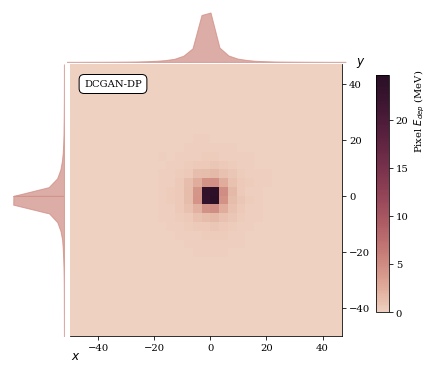

In [18]:
# real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 500,real= True, fake = True)

# #mydir = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/2018-05-18_18-39-35/"
# plot_many(fake_data_array,rows = 2, columns = 5,real=False, epoch=53, save_dir=None)
data_both, n_events = make_samples(netG, n_events = 1000, real=True,fake=True)
#plot_difference(data_both, save_dir = mydir, epoch = epoch)

#plot_many(real_data_array,real=True, save_dir=None)
#plot_many(real_data_array, rows=2, columns=7, real=True, save_dir=mydir, epoch=epoch)
#plot_many(fake_data_array, rows=2, columns=7, real=False, save_dir=mydir, epoch=epoch, imageSize=imageSize)
print(mydir)
#mydir = '/home/chris/Dropbox/ForViewing/'
plot_avg(data_both[0], n_events, save_dir= mydir,  epoch = epoch)

In [19]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=4*lr, betas=(beta1, 0.999))

/home/chris/Dropbox/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/2018-09-26_13-06-28/
(32, 32)


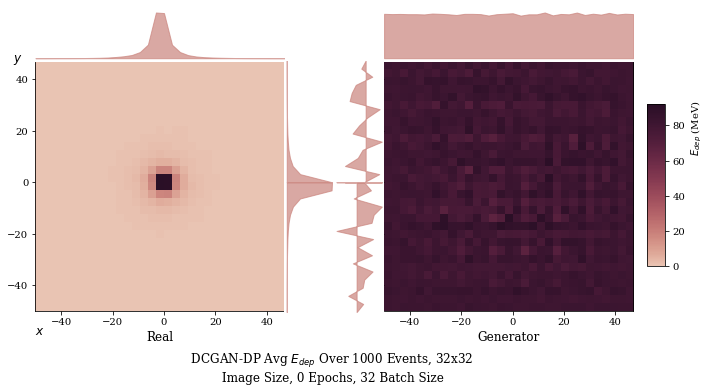

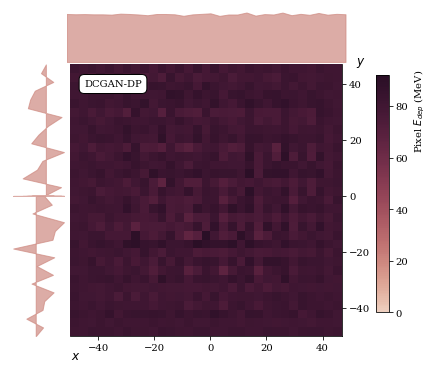

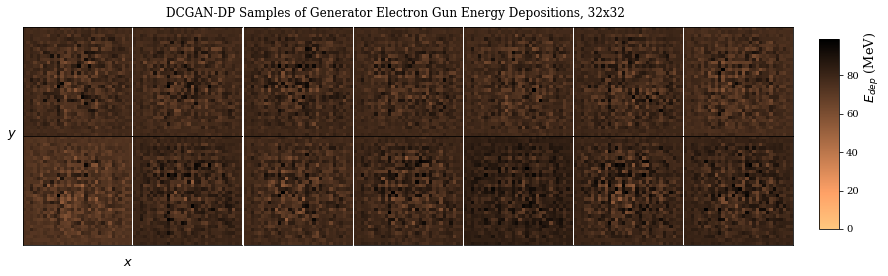

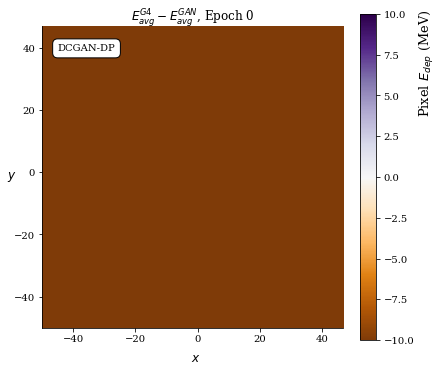

[0/50][0/938] Loss_D: 1.8956 Loss_G: 3.3872 D(x): 0.2883 D(G(z)): 0.3873 / 0.0413

[0/50][100/938] Loss_D: 0.0055 Loss_G: 6.5320 D(x): 0.9979 D(G(z)): 0.0033 / 0.0016
[0/50][200/938] Loss_D: 0.0036 Loss_G: 6.8892 D(x): 0.9985 D(G(z)): 0.0021 / 0.0010
[0/50][300/938] Loss_D: 0.0084 Loss_G: 7.0497 D(x): 0.9953 D(G(z)): 0.0036 / 0.0009
[0/50][400/938] Loss_D: 0.0213 Loss_G: 6.1254 D(x): 0.9895 D(G(z)): 0.0105 / 0.0022
[0/50][500/938] Loss_D: 0.0555 Loss_G: 8.6993 D(x): 0.9491 D(G(z)): 0.0001 / 0.0002
[0/50][600/938] Loss_D: 0.0582 Loss_G: 4.6308 D(x): 0.9668 D(G(z)): 0.0232 / 0.0101
[0/50][700/938] Loss_D: 0.0620 Loss_G: 5.5758 D(x): 0.9517 D(G(z)): 0.0097 / 0.0074
[0/50][800/938] Loss_D: 0.6668 Loss_G: 3.2193 D(x): 0.8998 D(G(z)): 0.3591 / 0.0742
[0/50][900/938] Loss_D: 0.6819 Loss_G: 3.0232 D(x): 0.6711 D(G(z)): 0.1911 / 0.0519
(32, 32)


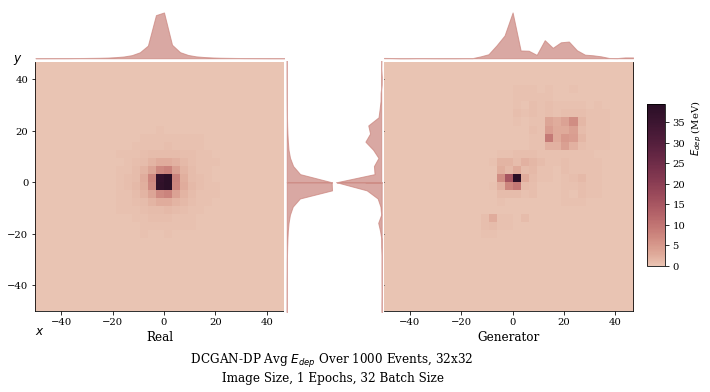

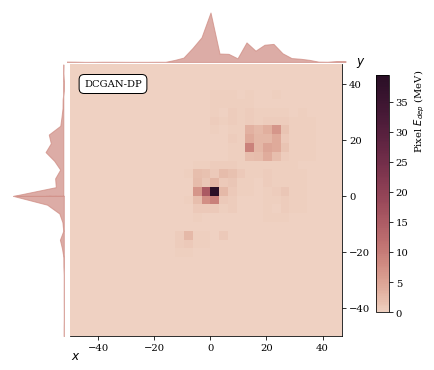

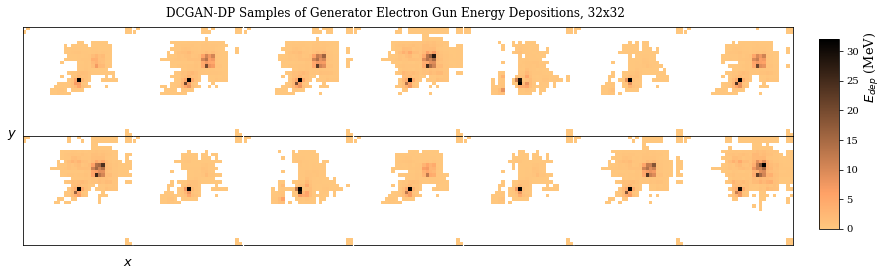

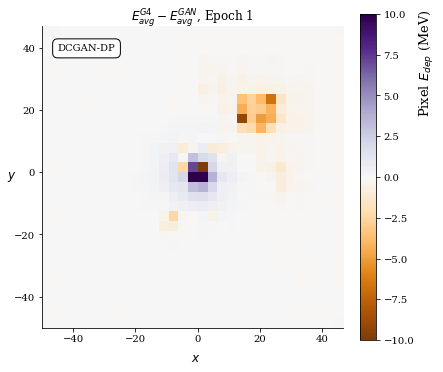

[1/50][0/938] Loss_D: 0.5430 Loss_G: 3.9463 D(x): 0.6905 D(G(z)): 0.0510 / 0.0275
[1/50][100/938] Loss_D: 0.3915 Loss_G: 3.1470 D(x): 0.9157 D(G(z)): 0.2535 / 0.0539
[1/50][200/938] Loss_D: 0.8282 Loss_G: 3.1161 D(x): 0.8287 D(G(z)): 0.4446 / 0.0674
[1/50][300/938] Loss_D: 0.3858 Loss_G: 2.0678 D(x): 0.8884 D(G(z)): 0.2277 / 0.1372
[1/50][400/938] Loss_D: 1.5224 Loss_G: 3.5196 D(x): 0.6856 D(G(z)): 0.5844 / 0.0592
[1/50][500/938] Loss_D: 0.6217 Loss_G: 2.1052 D(x): 0.6718 D(G(z)): 0.1466 / 0.1509
[1/50][600/938] Loss_D: 0.8873 Loss_G: 1.8047 D(x): 0.7411 D(G(z)): 0.3784 / 0.1968
[1/50][700/938] Loss_D: 0.7333 Loss_G: 2.7299 D(x): 0.8794 D(G(z)): 0.4211 / 0.0867
[1/50][800/938] Loss_D: 0.6047 Loss_G: 2.5113 D(x): 0.9315 D(G(z)): 0.3956 / 0.0981
[1/50][900/938] Loss_D: 0.3749 Loss_G: 1.7020 D(x): 0.8216 D(G(z)): 0.1408 / 0.2065
(32, 32)


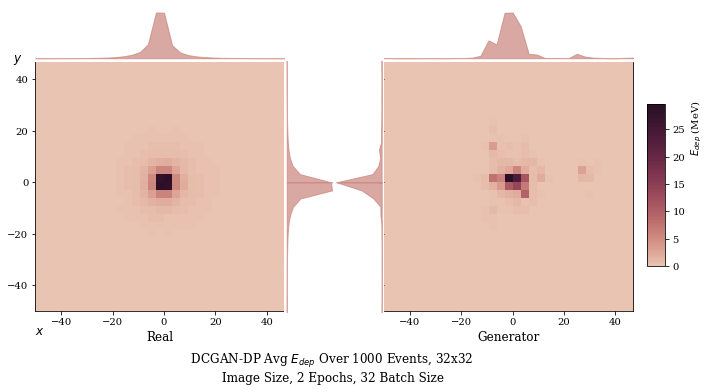

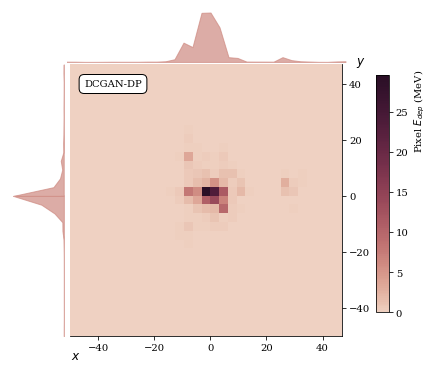

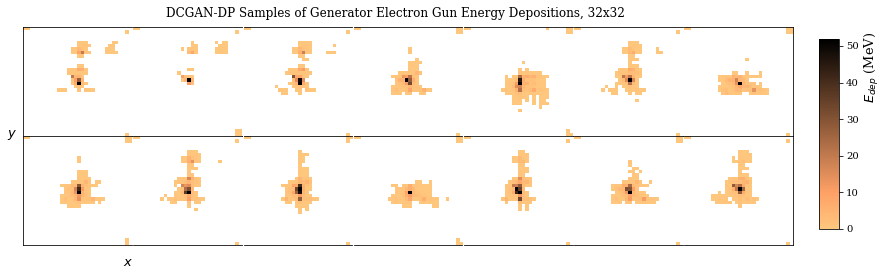

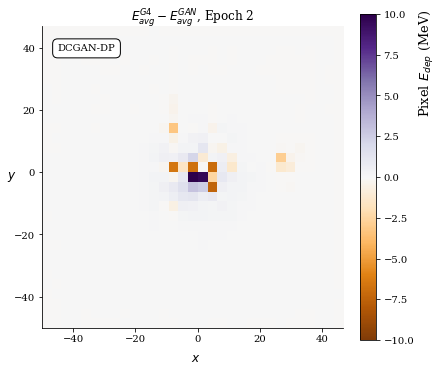

[2/50][0/938] Loss_D: 0.8358 Loss_G: 3.8913 D(x): 0.8669 D(G(z)): 0.4738 / 0.0289
[2/50][100/938] Loss_D: 0.4668 Loss_G: 2.7528 D(x): 0.9024 D(G(z)): 0.2897 / 0.0962
[2/50][200/938] Loss_D: 0.5316 Loss_G: 2.3947 D(x): 0.9242 D(G(z)): 0.3514 / 0.0996
[2/50][300/938] Loss_D: 0.7754 Loss_G: 2.5329 D(x): 0.9407 D(G(z)): 0.4961 / 0.0997
[2/50][400/938] Loss_D: 0.6717 Loss_G: 3.1917 D(x): 0.9150 D(G(z)): 0.4023 / 0.0572
[2/50][500/938] Loss_D: 0.8108 Loss_G: 2.8695 D(x): 0.8565 D(G(z)): 0.4262 / 0.0771
[2/50][600/938] Loss_D: 0.7375 Loss_G: 3.0262 D(x): 0.5822 D(G(z)): 0.0408 / 0.0726
[2/50][700/938] Loss_D: 0.3418 Loss_G: 2.2778 D(x): 0.8787 D(G(z)): 0.1789 / 0.1163
[2/50][800/938] Loss_D: 0.6693 Loss_G: 2.5816 D(x): 0.7985 D(G(z)): 0.3304 / 0.1027
[2/50][900/938] Loss_D: 0.8179 Loss_G: 1.8114 D(x): 0.6207 D(G(z)): 0.2026 / 0.2008
(32, 32)


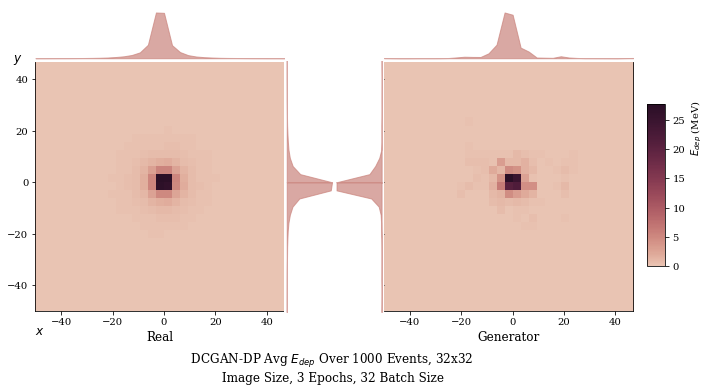

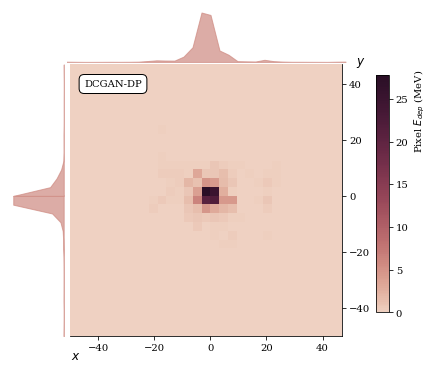

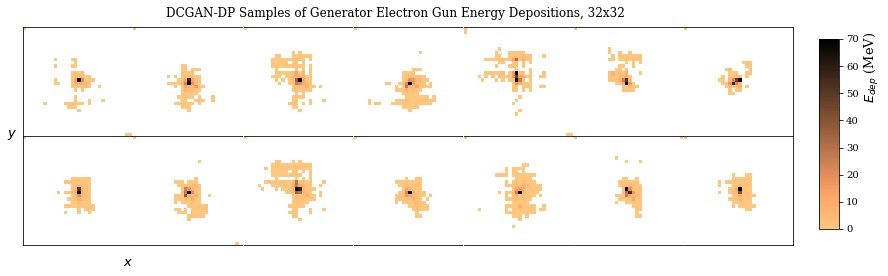

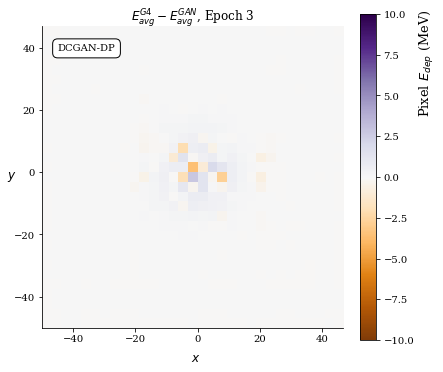

[3/50][0/938] Loss_D: 0.5865 Loss_G: 1.0720 D(x): 0.7376 D(G(z)): 0.2269 / 0.3754
[3/50][100/938] Loss_D: 1.3909 Loss_G: 1.6218 D(x): 0.7002 D(G(z)): 0.5534 / 0.2395
[3/50][200/938] Loss_D: 0.6042 Loss_G: 1.3126 D(x): 0.7295 D(G(z)): 0.2289 / 0.2922
[3/50][300/938] Loss_D: 0.9602 Loss_G: 1.9075 D(x): 0.7531 D(G(z)): 0.4332 / 0.2094
[3/50][400/938] Loss_D: 0.6019 Loss_G: 1.9471 D(x): 0.7163 D(G(z)): 0.1873 / 0.1845
[3/50][500/938] Loss_D: 1.0894 Loss_G: 2.4047 D(x): 0.8221 D(G(z)): 0.5602 / 0.1113
[3/50][600/938] Loss_D: 0.8686 Loss_G: 1.4966 D(x): 0.5690 D(G(z)): 0.2077 / 0.2652
[3/50][700/938] Loss_D: 0.9387 Loss_G: 2.7830 D(x): 0.8841 D(G(z)): 0.4686 / 0.0872
[3/50][800/938] Loss_D: 1.3804 Loss_G: 2.6467 D(x): 0.8700 D(G(z)): 0.6892 / 0.0928
[3/50][900/938] Loss_D: 0.6973 Loss_G: 1.6264 D(x): 0.7883 D(G(z)): 0.3390 / 0.2174
(32, 32)


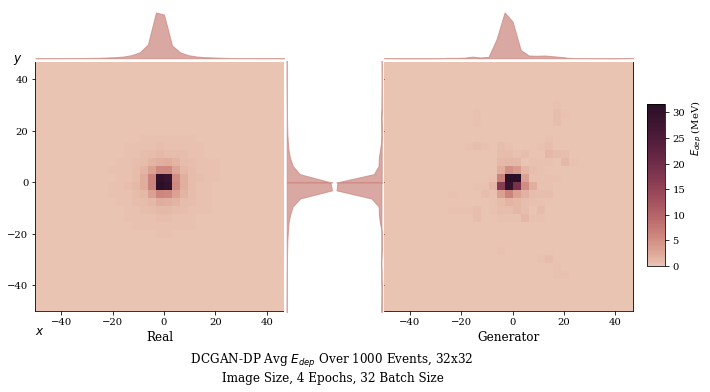

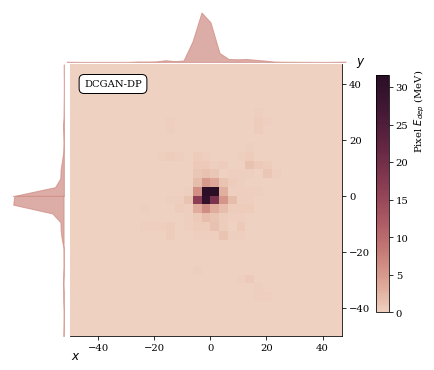

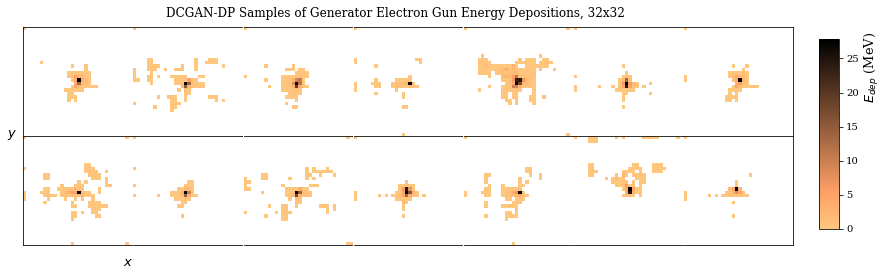

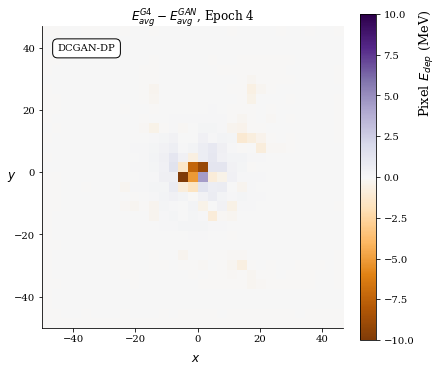

[4/50][0/938] Loss_D: 0.5545 Loss_G: 2.1397 D(x): 0.8832 D(G(z)): 0.3183 / 0.1392
[4/50][100/938] Loss_D: 0.8334 Loss_G: 3.0152 D(x): 0.8922 D(G(z)): 0.4919 / 0.0612
[4/50][200/938] Loss_D: 1.4110 Loss_G: 2.6119 D(x): 0.8694 D(G(z)): 0.6974 / 0.0867
[4/50][300/938] Loss_D: 0.9570 Loss_G: 0.9195 D(x): 0.6558 D(G(z)): 0.3598 / 0.4302
[4/50][400/938] Loss_D: 0.7575 Loss_G: 1.8647 D(x): 0.8165 D(G(z)): 0.4082 / 0.1792
[4/50][500/938] Loss_D: 0.8887 Loss_G: 1.4469 D(x): 0.5236 D(G(z)): 0.1578 / 0.2633
[4/50][600/938] Loss_D: 0.7709 Loss_G: 1.2390 D(x): 0.6811 D(G(z)): 0.2775 / 0.3089
[4/50][700/938] Loss_D: 0.6647 Loss_G: 1.7849 D(x): 0.7213 D(G(z)): 0.2481 / 0.2094
[4/50][800/938] Loss_D: 1.2258 Loss_G: 0.9491 D(x): 0.6813 D(G(z)): 0.5004 / 0.4328
[4/50][900/938] Loss_D: 0.8618 Loss_G: 1.4657 D(x): 0.7405 D(G(z)): 0.3980 / 0.2571
(32, 32)


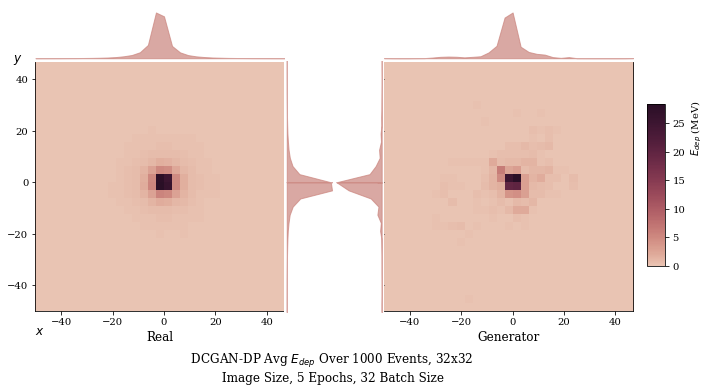

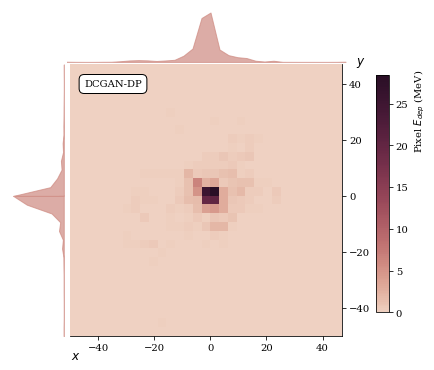

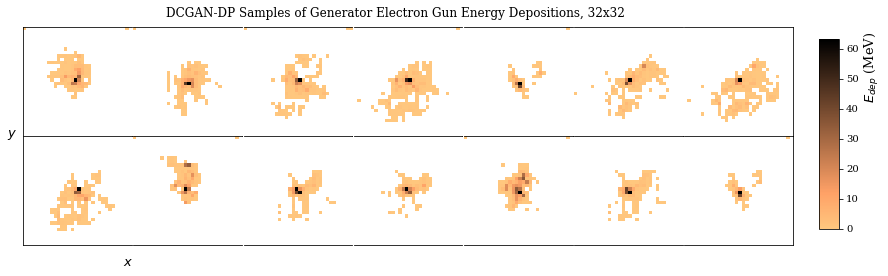

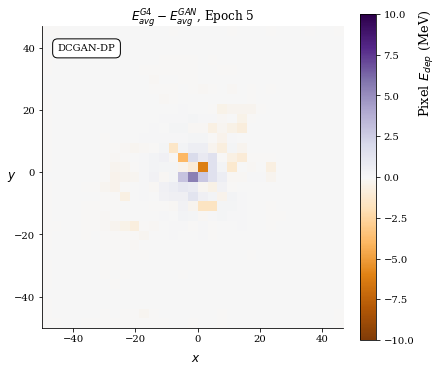

[5/50][0/938] Loss_D: 0.9763 Loss_G: 3.3330 D(x): 0.8993 D(G(z)): 0.5399 / 0.0457
[5/50][100/938] Loss_D: 0.9122 Loss_G: 1.2096 D(x): 0.7502 D(G(z)): 0.4059 / 0.3465
[5/50][200/938] Loss_D: 0.6425 Loss_G: 0.9707 D(x): 0.8050 D(G(z)): 0.3306 / 0.4003
[5/50][300/938] Loss_D: 0.8066 Loss_G: 1.3303 D(x): 0.7800 D(G(z)): 0.4082 / 0.2803
[5/50][400/938] Loss_D: 0.8402 Loss_G: 2.0008 D(x): 0.8611 D(G(z)): 0.4808 / 0.1710
[5/50][500/938] Loss_D: 0.9333 Loss_G: 1.0309 D(x): 0.6000 D(G(z)): 0.2947 / 0.3849
[5/50][600/938] Loss_D: 0.7047 Loss_G: 2.1596 D(x): 0.8118 D(G(z)): 0.3601 / 0.1346
[5/50][700/938] Loss_D: 0.8494 Loss_G: 1.5097 D(x): 0.7498 D(G(z)): 0.4019 / 0.2595
[5/50][800/938] Loss_D: 0.8143 Loss_G: 1.4943 D(x): 0.7596 D(G(z)): 0.3903 / 0.2568
[5/50][900/938] Loss_D: 0.8806 Loss_G: 1.3869 D(x): 0.7197 D(G(z)): 0.3951 / 0.2762
(32, 32)


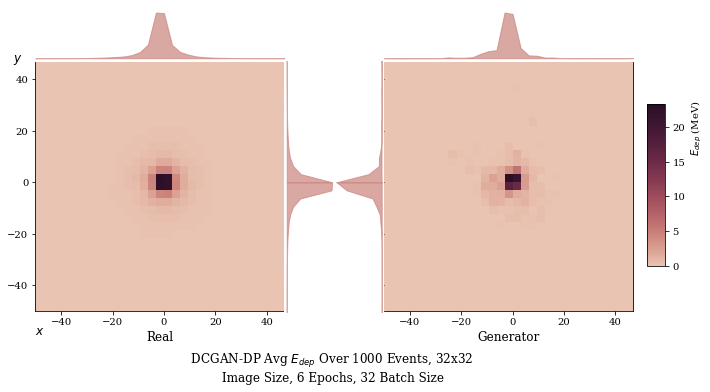

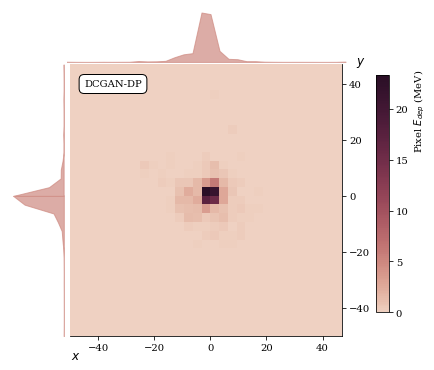

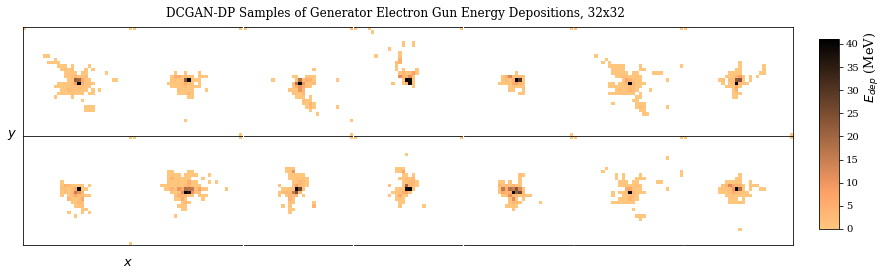

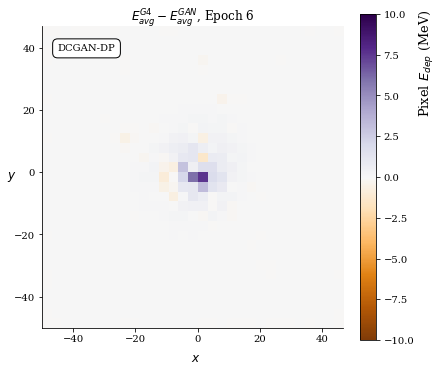

[6/50][0/938] Loss_D: 0.6373 Loss_G: 1.6320 D(x): 0.8418 D(G(z)): 0.3614 / 0.2174
[6/50][100/938] Loss_D: 0.5287 Loss_G: 0.8971 D(x): 0.7543 D(G(z)): 0.1911 / 0.4379
[6/50][200/938] Loss_D: 0.7406 Loss_G: 1.2522 D(x): 0.7348 D(G(z)): 0.3227 / 0.3034
[6/50][300/938] Loss_D: 0.9257 Loss_G: 1.4693 D(x): 0.7633 D(G(z)): 0.4525 / 0.2552
[6/50][400/938] Loss_D: 1.1000 Loss_G: 1.5220 D(x): 0.7746 D(G(z)): 0.5225 / 0.2527
[6/50][500/938] Loss_D: 0.7876 Loss_G: 1.5682 D(x): 0.6519 D(G(z)): 0.2593 / 0.2424
[6/50][600/938] Loss_D: 0.6616 Loss_G: 1.4946 D(x): 0.6898 D(G(z)): 0.2271 / 0.2437
[6/50][700/938] Loss_D: 0.6785 Loss_G: 2.5437 D(x): 0.8647 D(G(z)): 0.3947 / 0.0943
[6/50][800/938] Loss_D: 0.6379 Loss_G: 1.6778 D(x): 0.6594 D(G(z)): 0.1688 / 0.2138
[6/50][900/938] Loss_D: 1.1187 Loss_G: 2.4209 D(x): 0.8507 D(G(z)): 0.5676 / 0.1094
(32, 32)


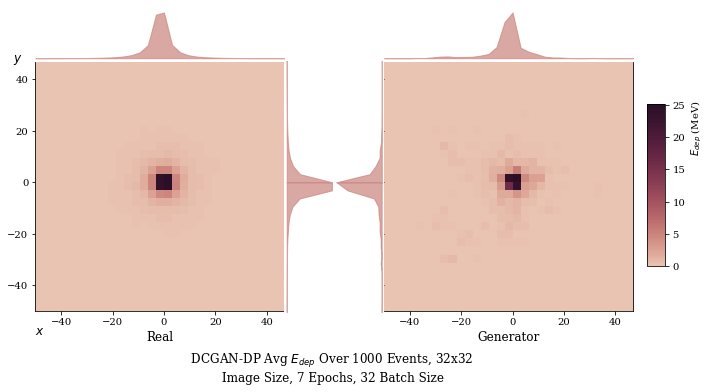

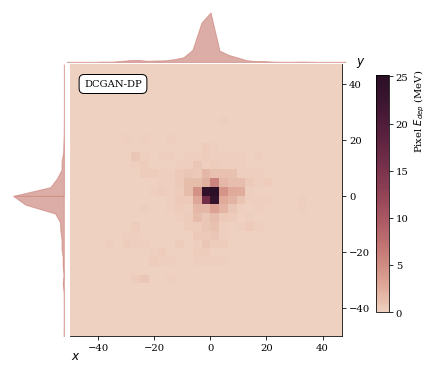

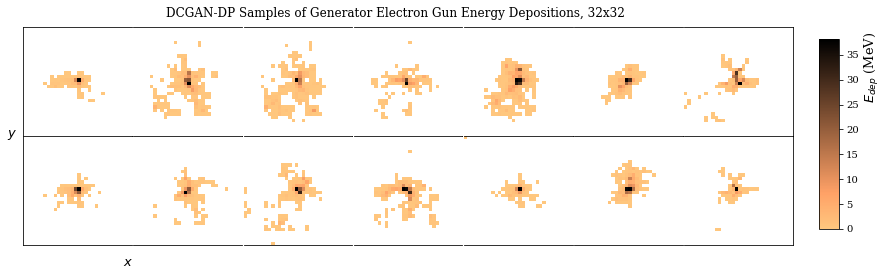

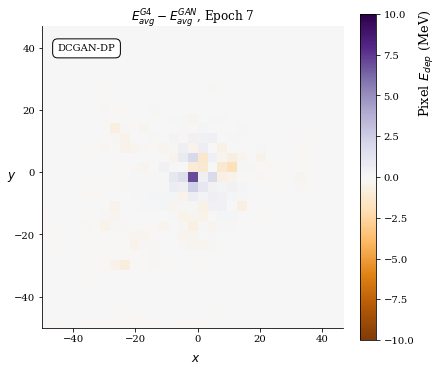

[7/50][0/938] Loss_D: 1.2187 Loss_G: 2.5532 D(x): 0.8495 D(G(z)): 0.6332 / 0.0967
[7/50][100/938] Loss_D: 0.9101 Loss_G: 1.3712 D(x): 0.7669 D(G(z)): 0.4527 / 0.2674
[7/50][200/938] Loss_D: 0.8316 Loss_G: 1.3983 D(x): 0.8296 D(G(z)): 0.4534 / 0.2771
[7/50][300/938] Loss_D: 0.8107 Loss_G: 2.1477 D(x): 0.8683 D(G(z)): 0.4707 / 0.1285
[7/50][400/938] Loss_D: 1.0898 Loss_G: 1.2476 D(x): 0.7569 D(G(z)): 0.5312 / 0.3094
[7/50][500/938] Loss_D: 0.9179 Loss_G: 0.6756 D(x): 0.6815 D(G(z)): 0.3904 / 0.5165
[7/50][600/938] Loss_D: 0.6520 Loss_G: 1.5996 D(x): 0.8335 D(G(z)): 0.3590 / 0.2243
[7/50][700/938] Loss_D: 1.0424 Loss_G: 1.7180 D(x): 0.4572 D(G(z)): 0.1402 / 0.2063
[7/50][800/938] Loss_D: 0.6738 Loss_G: 1.5014 D(x): 0.8242 D(G(z)): 0.3550 / 0.2330
[7/50][900/938] Loss_D: 0.7517 Loss_G: 2.3236 D(x): 0.8911 D(G(z)): 0.4523 / 0.1105
(32, 32)


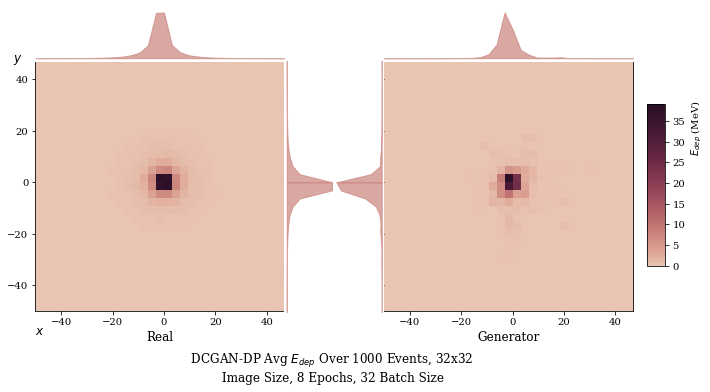

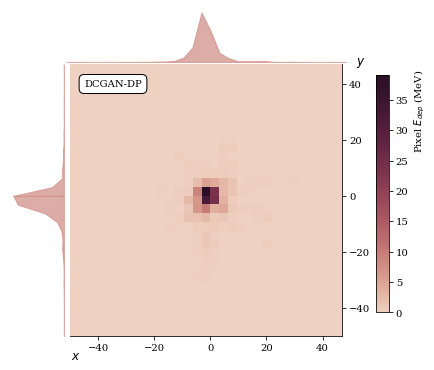

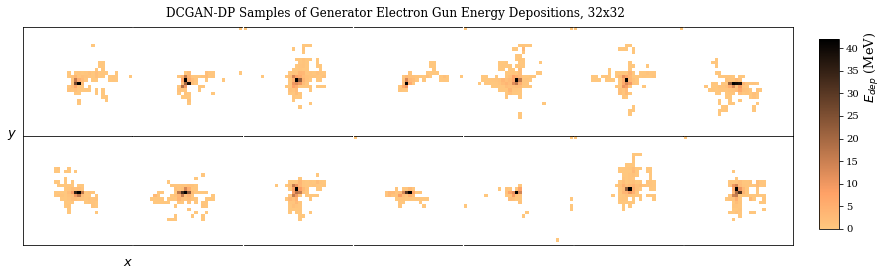

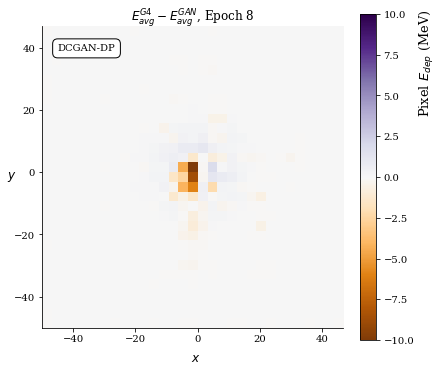

[8/50][0/938] Loss_D: 0.9468 Loss_G: 1.0716 D(x): 0.5010 D(G(z)): 0.1617 / 0.3600
[8/50][100/938] Loss_D: 0.6395 Loss_G: 0.9427 D(x): 0.7093 D(G(z)): 0.2367 / 0.4059
[8/50][200/938] Loss_D: 0.8449 Loss_G: 1.1841 D(x): 0.7345 D(G(z)): 0.3881 / 0.3266
[8/50][300/938] Loss_D: 0.9317 Loss_G: 0.6623 D(x): 0.5305 D(G(z)): 0.2189 / 0.5247
[8/50][400/938] Loss_D: 0.5919 Loss_G: 2.0013 D(x): 0.8411 D(G(z)): 0.3269 / 0.1505
[8/50][500/938] Loss_D: 0.8046 Loss_G: 1.1666 D(x): 0.7580 D(G(z)): 0.3880 / 0.3271
[8/50][600/938] Loss_D: 0.7919 Loss_G: 1.3009 D(x): 0.5964 D(G(z)): 0.1757 / 0.2919
[8/50][700/938] Loss_D: 1.1206 Loss_G: 1.4776 D(x): 0.7723 D(G(z)): 0.5153 / 0.2653
[8/50][800/938] Loss_D: 0.7210 Loss_G: 0.9623 D(x): 0.6960 D(G(z)): 0.2647 / 0.3981
[8/50][900/938] Loss_D: 0.6693 Loss_G: 1.0267 D(x): 0.7447 D(G(z)): 0.2845 / 0.3734
(32, 32)


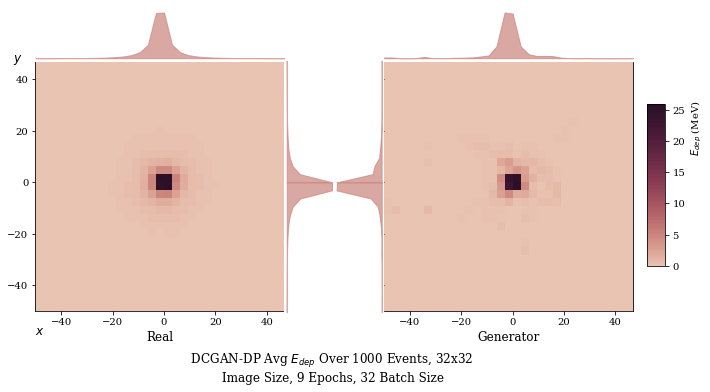

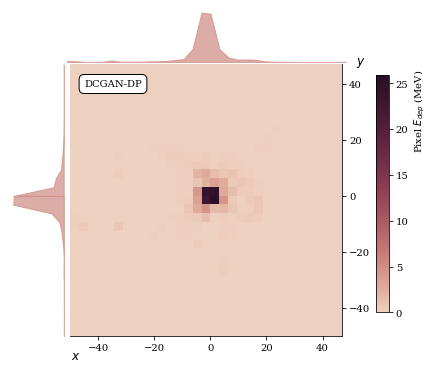

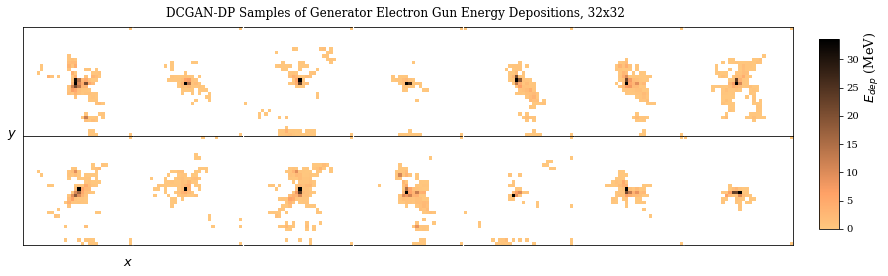

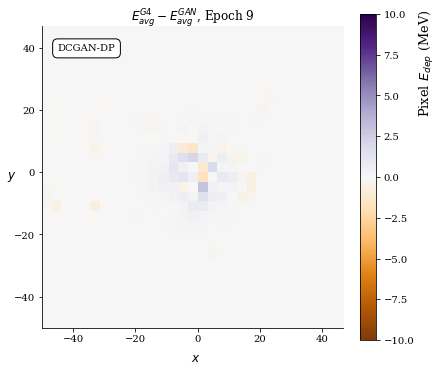

[9/50][0/938] Loss_D: 0.6646 Loss_G: 1.7506 D(x): 0.8622 D(G(z)): 0.3919 / 0.1887
[9/50][100/938] Loss_D: 0.9851 Loss_G: 0.8441 D(x): 0.6725 D(G(z)): 0.4258 / 0.4401
[9/50][200/938] Loss_D: 0.8517 Loss_G: 1.5436 D(x): 0.8213 D(G(z)): 0.4615 / 0.2357
[9/50][300/938] Loss_D: 1.0042 Loss_G: 1.5974 D(x): 0.8072 D(G(z)): 0.5222 / 0.2186
[9/50][400/938] Loss_D: 0.6624 Loss_G: 1.1314 D(x): 0.8233 D(G(z)): 0.3562 / 0.3398
[9/50][500/938] Loss_D: 0.7589 Loss_G: 1.0815 D(x): 0.6352 D(G(z)): 0.2263 / 0.3505
[9/50][600/938] Loss_D: 0.6677 Loss_G: 1.2021 D(x): 0.6942 D(G(z)): 0.2429 / 0.3153
[9/50][700/938] Loss_D: 0.8513 Loss_G: 1.5849 D(x): 0.6765 D(G(z)): 0.3435 / 0.2199
[9/50][800/938] Loss_D: 1.0004 Loss_G: 2.0513 D(x): 0.8461 D(G(z)): 0.5492 / 0.1431
[9/50][900/938] Loss_D: 0.7654 Loss_G: 1.0698 D(x): 0.5527 D(G(z)): 0.1287 / 0.3485
(32, 32)


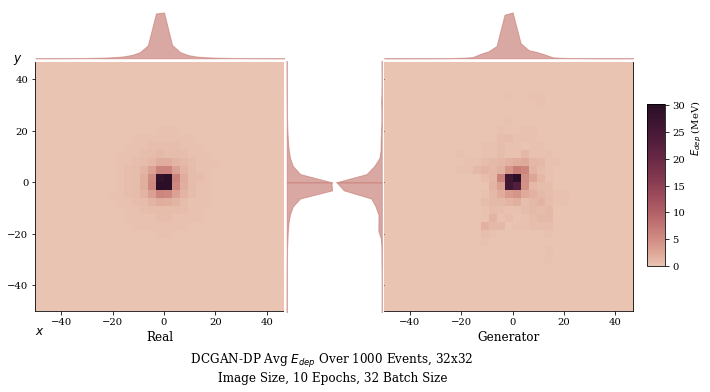

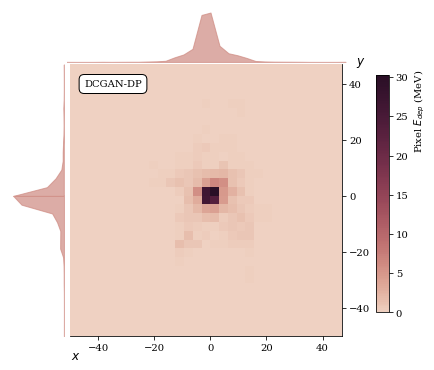

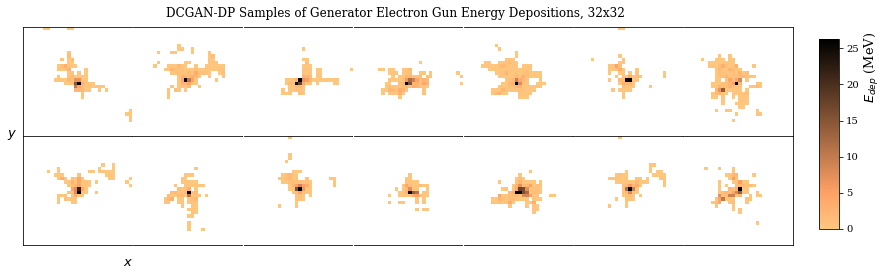

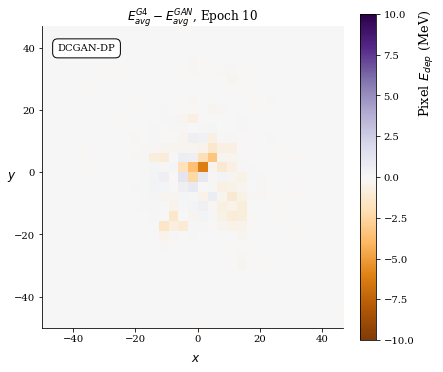

[10/50][0/938] Loss_D: 1.0748 Loss_G: 1.1490 D(x): 0.7627 D(G(z)): 0.5244 / 0.3427
[10/50][100/938] Loss_D: 0.7027 Loss_G: 0.6782 D(x): 0.6770 D(G(z)): 0.2441 / 0.5254
[10/50][200/938] Loss_D: 0.7613 Loss_G: 1.4167 D(x): 0.7984 D(G(z)): 0.3977 / 0.2598
[10/50][300/938] Loss_D: 0.8468 Loss_G: 0.9012 D(x): 0.7111 D(G(z)): 0.3687 / 0.4225
[10/50][400/938] Loss_D: 0.7547 Loss_G: 2.3806 D(x): 0.8851 D(G(z)): 0.4559 / 0.1034
[10/50][500/938] Loss_D: 0.6317 Loss_G: 1.1674 D(x): 0.6915 D(G(z)): 0.2120 / 0.3292
[10/50][600/938] Loss_D: 0.8463 Loss_G: 1.6234 D(x): 0.7772 D(G(z)): 0.4355 / 0.2120
[10/50][700/938] Loss_D: 1.0110 Loss_G: 1.5578 D(x): 0.7762 D(G(z)): 0.5130 / 0.2288
[10/50][800/938] Loss_D: 1.0186 Loss_G: 1.1832 D(x): 0.6463 D(G(z)): 0.4181 / 0.3155
[10/50][900/938] Loss_D: 0.9325 Loss_G: 0.9655 D(x): 0.5487 D(G(z)): 0.2631 / 0.3904
(32, 32)


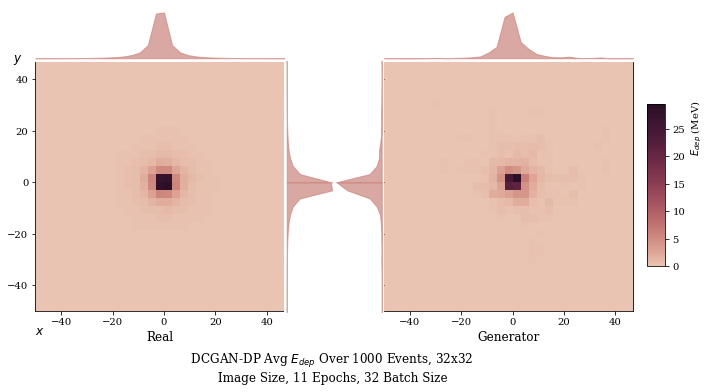

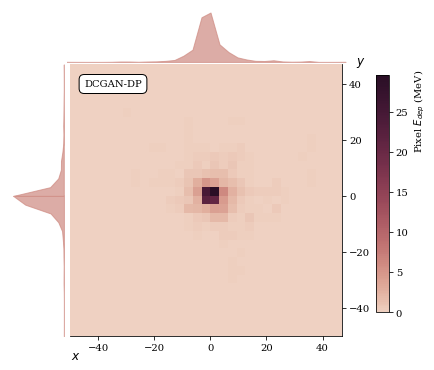

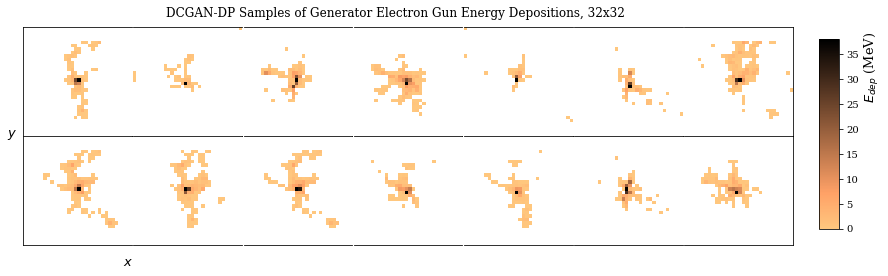

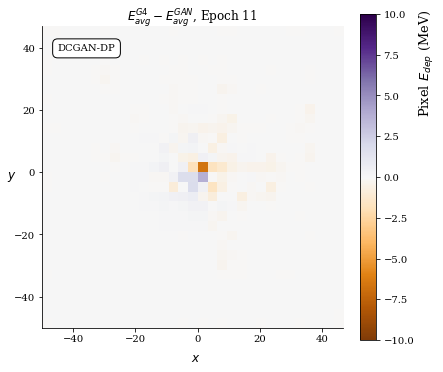

[11/50][0/938] Loss_D: 0.8522 Loss_G: 1.5302 D(x): 0.8178 D(G(z)): 0.4603 / 0.2341
[11/50][100/938] Loss_D: 0.7078 Loss_G: 1.2535 D(x): 0.7814 D(G(z)): 0.3489 / 0.3031
[11/50][200/938] Loss_D: 0.7688 Loss_G: 1.3969 D(x): 0.7422 D(G(z)): 0.3532 / 0.2565
[11/50][300/938] Loss_D: 0.8118 Loss_G: 0.7988 D(x): 0.6294 D(G(z)): 0.2575 / 0.4646
[11/50][400/938] Loss_D: 0.8277 Loss_G: 0.8133 D(x): 0.6202 D(G(z)): 0.2701 / 0.4629
[11/50][500/938] Loss_D: 0.9991 Loss_G: 0.9365 D(x): 0.6073 D(G(z)): 0.3729 / 0.4015
[11/50][600/938] Loss_D: 0.8723 Loss_G: 1.4818 D(x): 0.7264 D(G(z)): 0.3927 / 0.2408
[11/50][700/938] Loss_D: 0.8868 Loss_G: 1.9795 D(x): 0.8211 D(G(z)): 0.4865 / 0.1493
[11/50][800/938] Loss_D: 1.0654 Loss_G: 1.1706 D(x): 0.7256 D(G(z)): 0.5117 / 0.3207
[11/50][900/938] Loss_D: 1.0128 Loss_G: 1.1072 D(x): 0.7027 D(G(z)): 0.4633 / 0.3412
(32, 32)


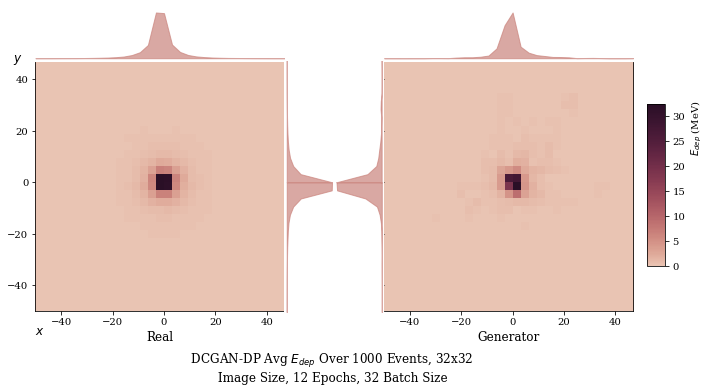

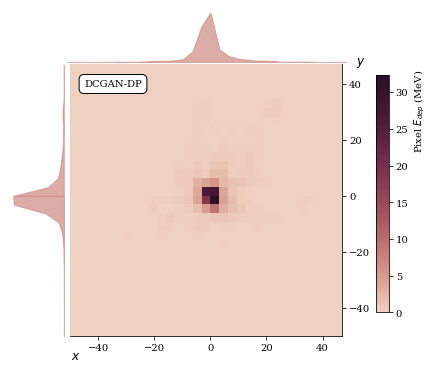

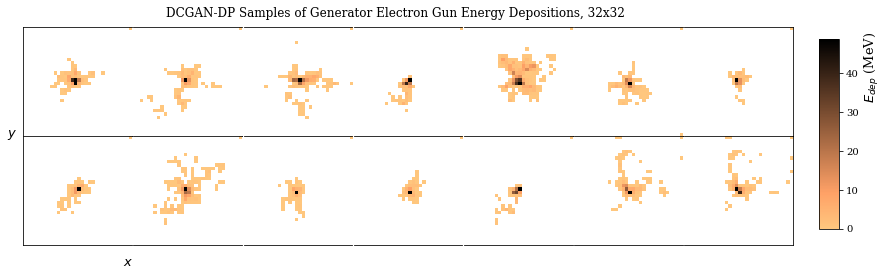

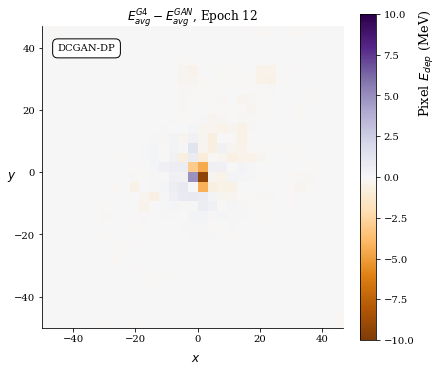

[12/50][0/938] Loss_D: 0.7574 Loss_G: 1.8473 D(x): 0.8149 D(G(z)): 0.4042 / 0.1757
[12/50][100/938] Loss_D: 0.9186 Loss_G: 1.0107 D(x): 0.6224 D(G(z)): 0.3377 / 0.3745
[12/50][200/938] Loss_D: 0.8884 Loss_G: 0.8391 D(x): 0.5436 D(G(z)): 0.2027 / 0.4458
[12/50][300/938] Loss_D: 0.9259 Loss_G: 2.0907 D(x): 0.8615 D(G(z)): 0.5190 / 0.1403
[12/50][400/938] Loss_D: 1.0944 Loss_G: 1.9938 D(x): 0.8123 D(G(z)): 0.5609 / 0.1585
[12/50][500/938] Loss_D: 0.7356 Loss_G: 1.2189 D(x): 0.6496 D(G(z)): 0.2437 / 0.3085
[12/50][600/938] Loss_D: 0.7539 Loss_G: 1.3228 D(x): 0.7273 D(G(z)): 0.3402 / 0.2879
[12/50][700/938] Loss_D: 0.8266 Loss_G: 2.1726 D(x): 0.8924 D(G(z)): 0.4865 / 0.1330
[12/50][800/938] Loss_D: 1.1681 Loss_G: 1.7032 D(x): 0.5084 D(G(z)): 0.3223 / 0.1992
[12/50][900/938] Loss_D: 1.0088 Loss_G: 0.8900 D(x): 0.5943 D(G(z)): 0.3551 / 0.4224
(32, 32)


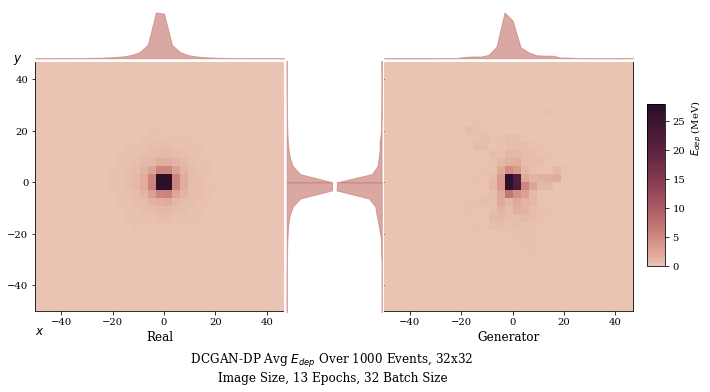

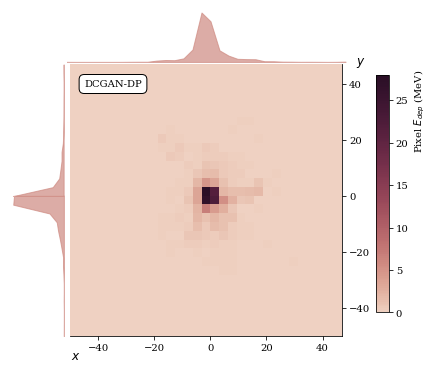

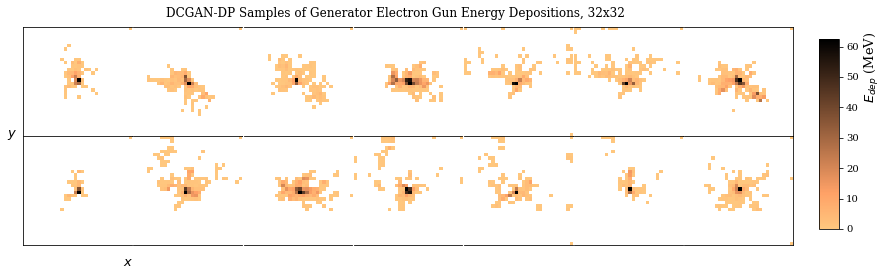

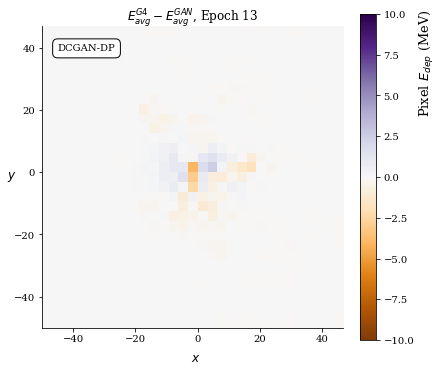

[13/50][0/938] Loss_D: 0.5639 Loss_G: 1.3059 D(x): 0.8544 D(G(z)): 0.3203 / 0.2893
[13/50][100/938] Loss_D: 0.9834 Loss_G: 0.8670 D(x): 0.6111 D(G(z)): 0.3676 / 0.4338
[13/50][200/938] Loss_D: 0.8031 Loss_G: 1.1657 D(x): 0.7679 D(G(z)): 0.4029 / 0.3238
[13/50][300/938] Loss_D: 0.5201 Loss_G: 1.7074 D(x): 0.7482 D(G(z)): 0.1907 / 0.1989
[13/50][400/938] Loss_D: 0.6673 Loss_G: 1.2610 D(x): 0.7353 D(G(z)): 0.2897 / 0.2903
[13/50][500/938] Loss_D: 1.0618 Loss_G: 1.5108 D(x): 0.7435 D(G(z)): 0.5066 / 0.2396
[13/50][600/938] Loss_D: 1.3345 Loss_G: 1.7764 D(x): 0.8722 D(G(z)): 0.6839 / 0.1794
[13/50][700/938] Loss_D: 0.6666 Loss_G: 0.8953 D(x): 0.7503 D(G(z)): 0.3029 / 0.4223
[13/50][800/938] Loss_D: 1.0432 Loss_G: 0.8707 D(x): 0.6506 D(G(z)): 0.4445 / 0.4257
[13/50][900/938] Loss_D: 0.9219 Loss_G: 0.9316 D(x): 0.5853 D(G(z)): 0.3004 / 0.4040
(32, 32)


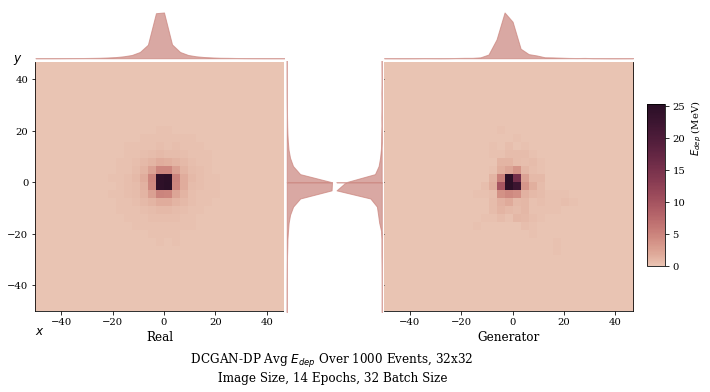

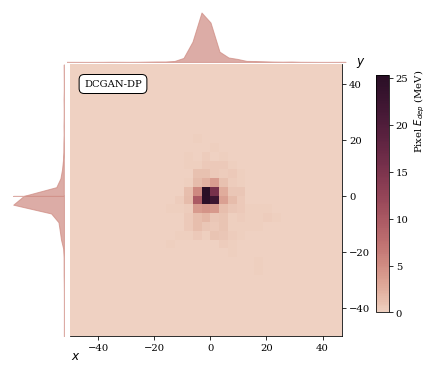

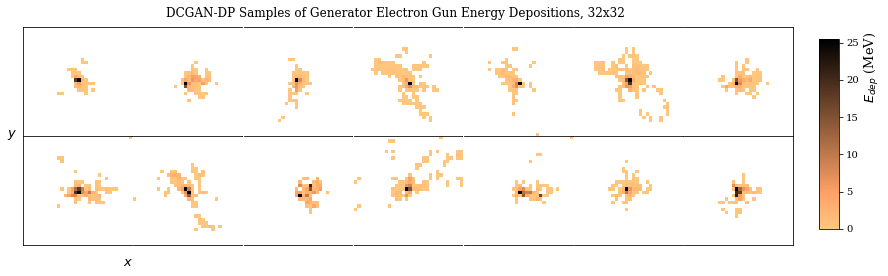

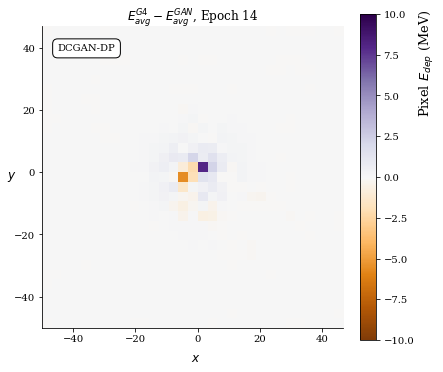

[14/50][0/938] Loss_D: 0.9007 Loss_G: 1.8900 D(x): 0.8135 D(G(z)): 0.4856 / 0.1652
[14/50][100/938] Loss_D: 1.1809 Loss_G: 1.3789 D(x): 0.7113 D(G(z)): 0.5331 / 0.2690
[14/50][200/938] Loss_D: 0.8391 Loss_G: 0.9551 D(x): 0.7763 D(G(z)): 0.4331 / 0.3954
[14/50][300/938] Loss_D: 1.1378 Loss_G: 1.4446 D(x): 0.7531 D(G(z)): 0.5506 / 0.2593
[14/50][400/938] Loss_D: 1.0173 Loss_G: 0.9015 D(x): 0.6227 D(G(z)): 0.4046 / 0.4176
[14/50][500/938] Loss_D: 1.1640 Loss_G: 0.8530 D(x): 0.5505 D(G(z)): 0.4091 / 0.4354
[14/50][600/938] Loss_D: 1.0840 Loss_G: 1.2559 D(x): 0.6462 D(G(z)): 0.4599 / 0.2969
[14/50][700/938] Loss_D: 0.6973 Loss_G: 1.2343 D(x): 0.6983 D(G(z)): 0.2720 / 0.3034
[14/50][800/938] Loss_D: 0.9154 Loss_G: 1.1732 D(x): 0.6993 D(G(z)): 0.4125 / 0.3178
[14/50][900/938] Loss_D: 1.0942 Loss_G: 1.3347 D(x): 0.7804 D(G(z)): 0.5394 / 0.2856
(32, 32)


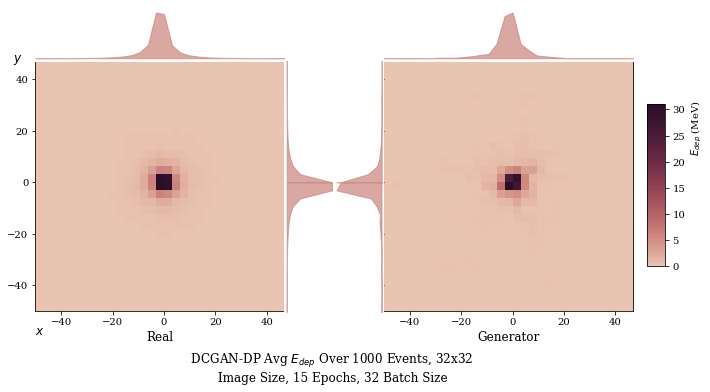

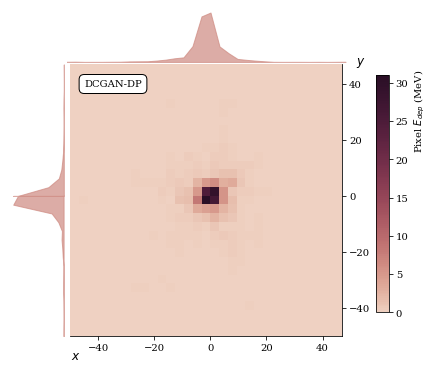

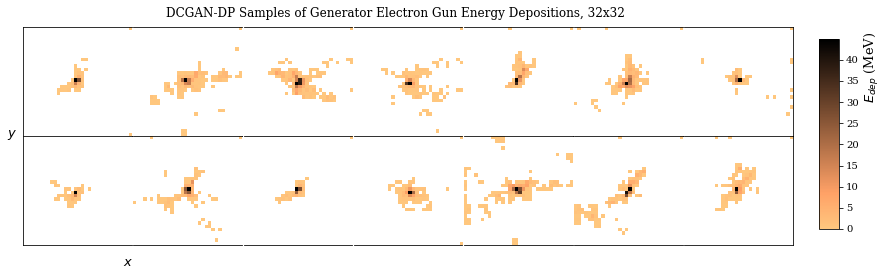

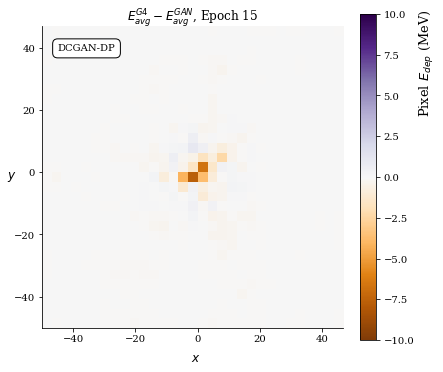

[15/50][0/938] Loss_D: 0.5622 Loss_G: 1.8145 D(x): 0.8037 D(G(z)): 0.2791 / 0.1806
[15/50][100/938] Loss_D: 1.0896 Loss_G: 0.9848 D(x): 0.6000 D(G(z)): 0.4049 / 0.3925
[15/50][200/938] Loss_D: 1.0099 Loss_G: 0.9902 D(x): 0.7387 D(G(z)): 0.4889 / 0.3852
[15/50][300/938] Loss_D: 0.9119 Loss_G: 1.4385 D(x): 0.5236 D(G(z)): 0.2121 / 0.2488
[15/50][400/938] Loss_D: 1.1148 Loss_G: 1.0290 D(x): 0.5671 D(G(z)): 0.3952 / 0.3728
[15/50][500/938] Loss_D: 0.8020 Loss_G: 0.8147 D(x): 0.6988 D(G(z)): 0.3433 / 0.4544
[15/50][600/938] Loss_D: 0.9570 Loss_G: 1.0558 D(x): 0.6808 D(G(z)): 0.4262 / 0.3583
[15/50][700/938] Loss_D: 0.8263 Loss_G: 1.9529 D(x): 0.8138 D(G(z)): 0.4484 / 0.1543
[15/50][800/938] Loss_D: 0.9843 Loss_G: 1.3779 D(x): 0.6350 D(G(z)): 0.3855 / 0.2658
[15/50][900/938] Loss_D: 1.1275 Loss_G: 1.4676 D(x): 0.4175 D(G(z)): 0.1791 / 0.2459
(32, 32)


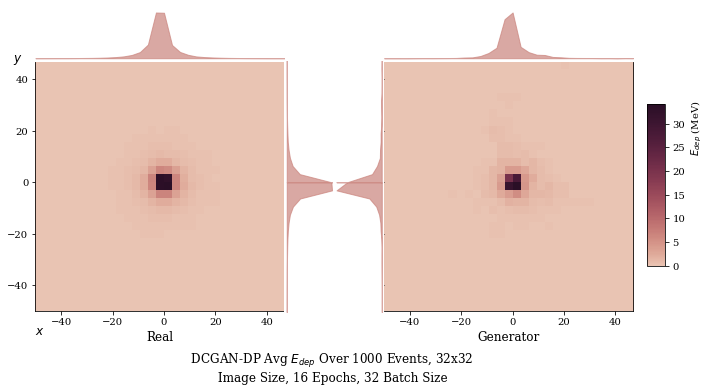

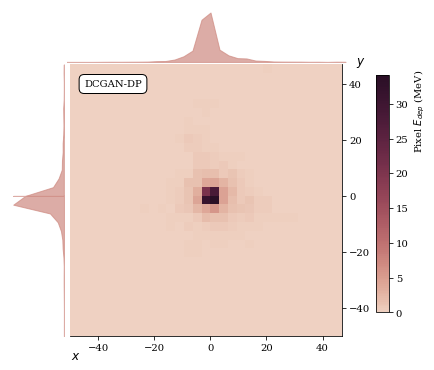

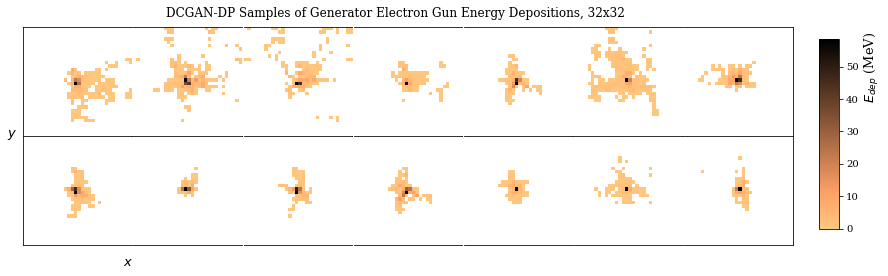

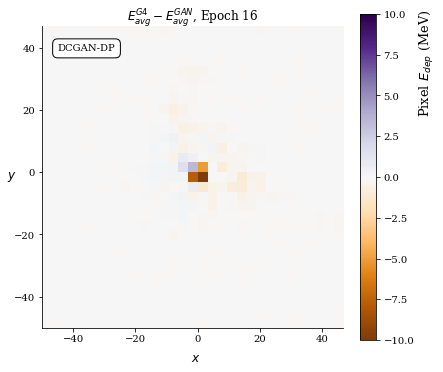

[16/50][0/938] Loss_D: 0.8299 Loss_G: 1.4103 D(x): 0.7871 D(G(z)): 0.4254 / 0.2593
[16/50][100/938] Loss_D: 0.9806 Loss_G: 0.9993 D(x): 0.6976 D(G(z)): 0.4503 / 0.3792
[16/50][200/938] Loss_D: 0.8800 Loss_G: 1.0198 D(x): 0.7333 D(G(z)): 0.4211 / 0.3672
[16/50][300/938] Loss_D: 0.6682 Loss_G: 1.3389 D(x): 0.7080 D(G(z)): 0.2625 / 0.2743
[16/50][400/938] Loss_D: 1.3113 Loss_G: 1.1602 D(x): 0.5838 D(G(z)): 0.5124 / 0.3255
[16/50][500/938] Loss_D: 0.9533 Loss_G: 0.9320 D(x): 0.5726 D(G(z)): 0.3044 / 0.4067
[16/50][600/938] Loss_D: 0.7332 Loss_G: 1.0483 D(x): 0.7624 D(G(z)): 0.3542 / 0.3720
[16/50][700/938] Loss_D: 0.7814 Loss_G: 1.4263 D(x): 0.7735 D(G(z)): 0.3936 / 0.2547
[16/50][800/938] Loss_D: 1.2827 Loss_G: 1.3685 D(x): 0.7170 D(G(z)): 0.5941 / 0.2676
[16/50][900/938] Loss_D: 1.1187 Loss_G: 0.7126 D(x): 0.5717 D(G(z)): 0.4018 / 0.5031
(32, 32)


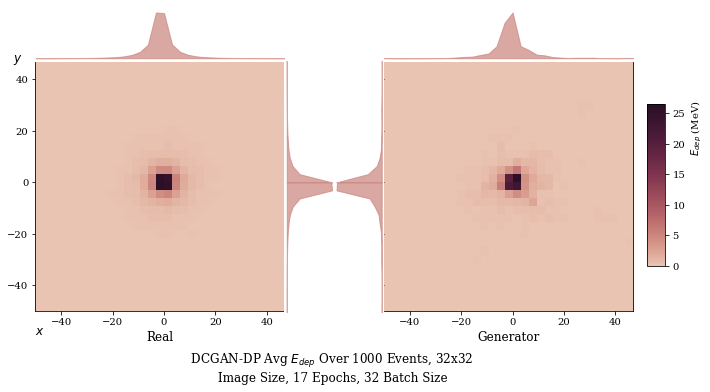

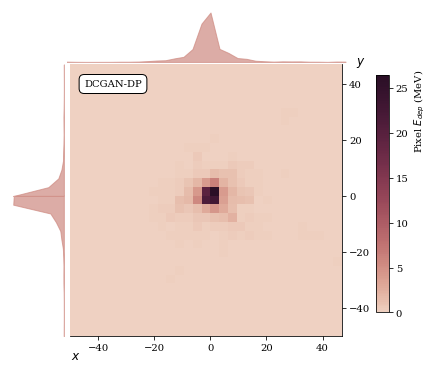

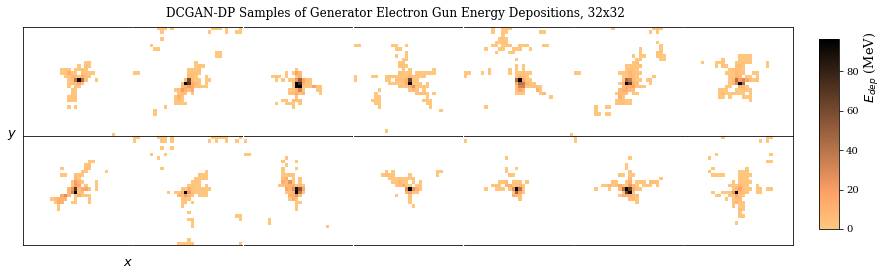

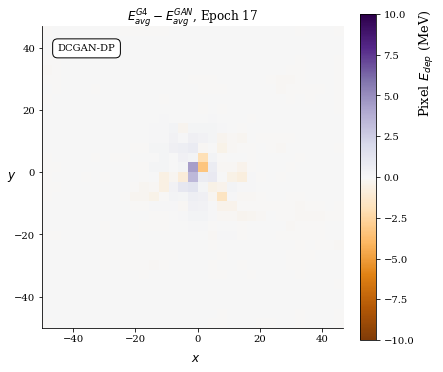

[17/50][0/938] Loss_D: 0.8738 Loss_G: 1.5549 D(x): 0.7410 D(G(z)): 0.4194 / 0.2262
[17/50][100/938] Loss_D: 1.0077 Loss_G: 1.6523 D(x): 0.8381 D(G(z)): 0.5537 / 0.2050
[17/50][200/938] Loss_D: 1.0381 Loss_G: 0.6912 D(x): 0.5775 D(G(z)): 0.3741 / 0.5081
[17/50][300/938] Loss_D: 1.0531 Loss_G: 1.1122 D(x): 0.7121 D(G(z)): 0.4886 / 0.3476
[17/50][400/938] Loss_D: 0.9476 Loss_G: 1.8585 D(x): 0.8714 D(G(z)): 0.5374 / 0.1744
[17/50][500/938] Loss_D: 0.7795 Loss_G: 0.8537 D(x): 0.6949 D(G(z)): 0.3246 / 0.4411
[17/50][600/938] Loss_D: 0.8075 Loss_G: 1.0608 D(x): 0.6128 D(G(z)): 0.2627 / 0.3533
[17/50][700/938] Loss_D: 1.0812 Loss_G: 1.5287 D(x): 0.7746 D(G(z)): 0.5493 / 0.2264
[17/50][800/938] Loss_D: 1.2241 Loss_G: 1.1019 D(x): 0.6077 D(G(z)): 0.4948 / 0.3470
[17/50][900/938] Loss_D: 0.7226 Loss_G: 1.4213 D(x): 0.6527 D(G(z)): 0.2405 / 0.2509
(32, 32)


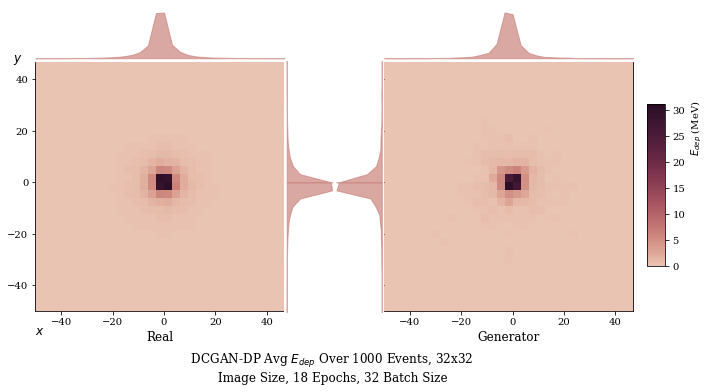

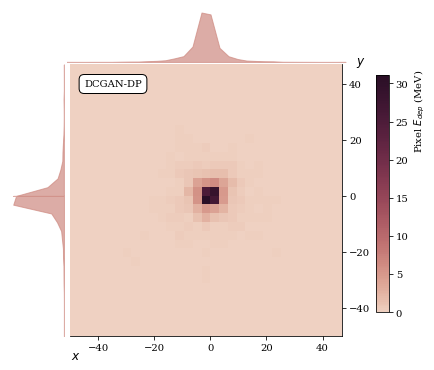

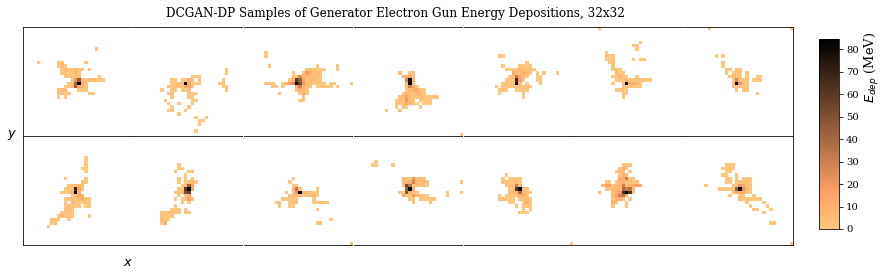

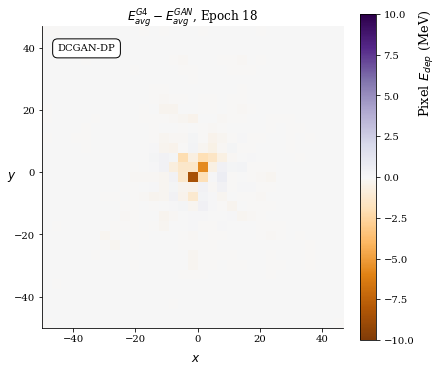

[18/50][0/938] Loss_D: 1.1347 Loss_G: 1.1564 D(x): 0.6853 D(G(z)): 0.5053 / 0.3267
[18/50][100/938] Loss_D: 1.1471 Loss_G: 0.8005 D(x): 0.5780 D(G(z)): 0.4387 / 0.4536
[18/50][200/938] Loss_D: 1.0152 Loss_G: 0.7433 D(x): 0.5430 D(G(z)): 0.3217 / 0.4798
[18/50][300/938] Loss_D: 0.7425 Loss_G: 1.1704 D(x): 0.7345 D(G(z)): 0.3372 / 0.3199
[18/50][400/938] Loss_D: 1.1067 Loss_G: 1.4286 D(x): 0.8410 D(G(z)): 0.5855 / 0.2563
[18/50][500/938] Loss_D: 1.2086 Loss_G: 0.9158 D(x): 0.4756 D(G(z)): 0.3281 / 0.4164
[18/50][600/938] Loss_D: 0.8119 Loss_G: 1.2743 D(x): 0.5878 D(G(z)): 0.2324 / 0.2878
[18/50][700/938] Loss_D: 1.0581 Loss_G: 1.5013 D(x): 0.7272 D(G(z)): 0.5110 / 0.2377
[18/50][800/938] Loss_D: 1.1423 Loss_G: 1.3968 D(x): 0.8037 D(G(z)): 0.5758 / 0.2601
[18/50][900/938] Loss_D: 0.8604 Loss_G: 1.3368 D(x): 0.7498 D(G(z)): 0.4212 / 0.2706
(32, 32)


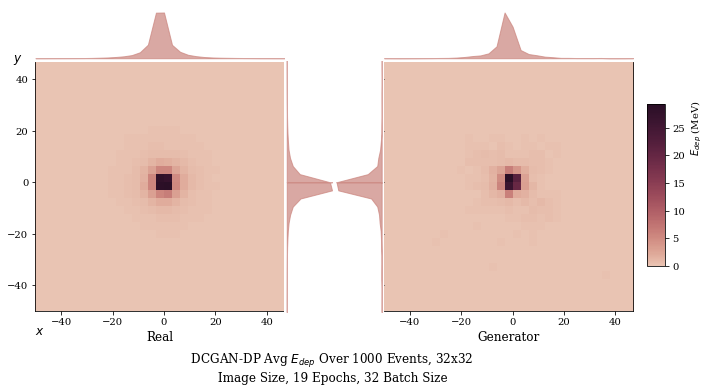

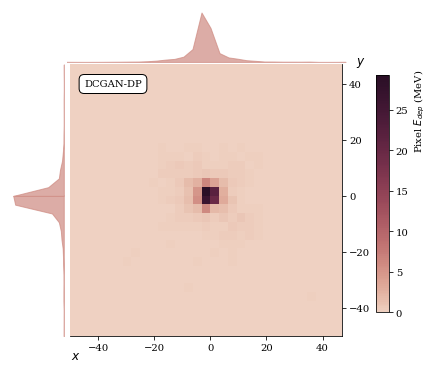

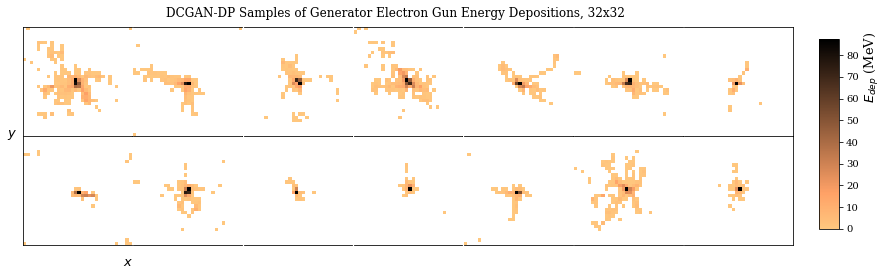

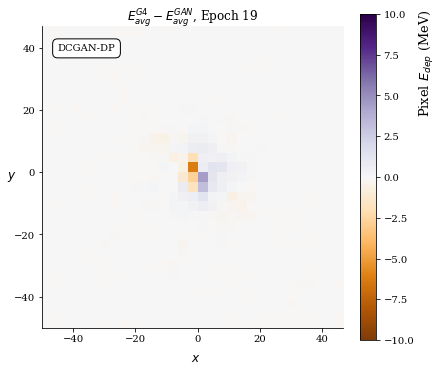

[19/50][0/938] Loss_D: 1.0294 Loss_G: 2.2464 D(x): 0.8137 D(G(z)): 0.5483 / 0.1163
[19/50][100/938] Loss_D: 1.1459 Loss_G: 1.1893 D(x): 0.7275 D(G(z)): 0.5515 / 0.3128
[19/50][200/938] Loss_D: 0.9900 Loss_G: 1.2772 D(x): 0.7498 D(G(z)): 0.4914 / 0.2892
[19/50][300/938] Loss_D: 0.9535 Loss_G: 1.0894 D(x): 0.7264 D(G(z)): 0.4518 / 0.3483
[19/50][400/938] Loss_D: 0.7564 Loss_G: 1.4302 D(x): 0.7737 D(G(z)): 0.3775 / 0.2507
[19/50][500/938] Loss_D: 1.0933 Loss_G: 1.2969 D(x): 0.4243 D(G(z)): 0.1666 / 0.2866
[19/50][600/938] Loss_D: 0.8163 Loss_G: 1.2614 D(x): 0.6812 D(G(z)): 0.3416 / 0.2885
[19/50][700/938] Loss_D: 0.8329 Loss_G: 1.0011 D(x): 0.6276 D(G(z)): 0.2935 / 0.3771
[19/50][800/938] Loss_D: 1.2035 Loss_G: 1.0449 D(x): 0.5061 D(G(z)): 0.3824 / 0.3599
[19/50][900/938] Loss_D: 0.8348 Loss_G: 1.2629 D(x): 0.5750 D(G(z)): 0.2192 / 0.2942
(32, 32)


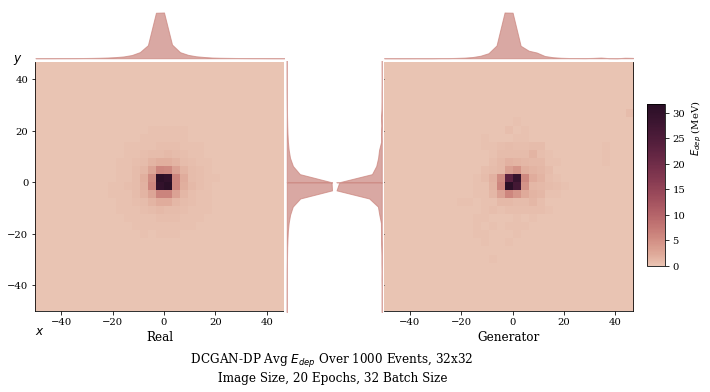

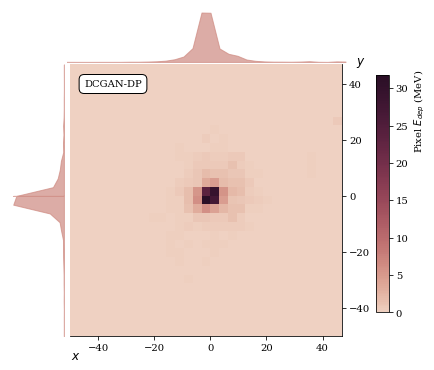

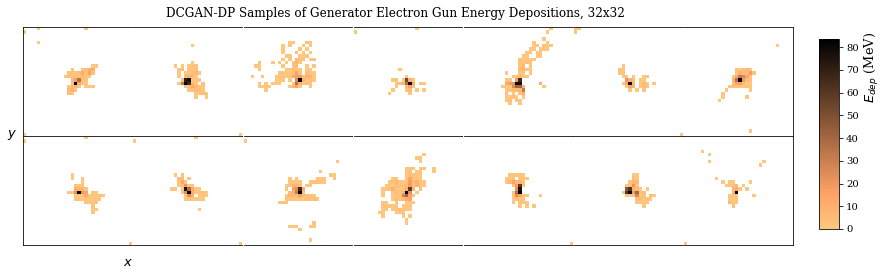

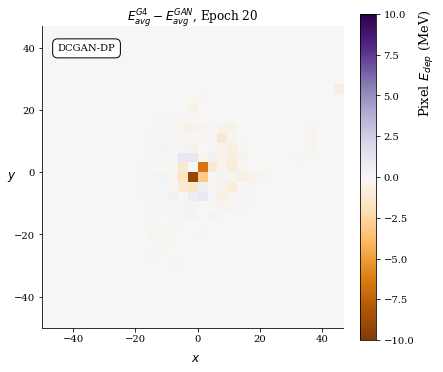

[20/50][0/938] Loss_D: 0.9303 Loss_G: 1.6316 D(x): 0.6403 D(G(z)): 0.3622 / 0.2103
[20/50][100/938] Loss_D: 1.1675 Loss_G: 0.7097 D(x): 0.5380 D(G(z)): 0.4071 / 0.4994
[20/50][200/938] Loss_D: 0.6930 Loss_G: 1.1593 D(x): 0.7578 D(G(z)): 0.3333 / 0.3219
[20/50][300/938] Loss_D: 0.7827 Loss_G: 1.0011 D(x): 0.7077 D(G(z)): 0.3400 / 0.3798
[20/50][400/938] Loss_D: 0.7989 Loss_G: 0.9987 D(x): 0.5859 D(G(z)): 0.2156 / 0.3740
[20/50][500/938] Loss_D: 1.0348 Loss_G: 0.7715 D(x): 0.4918 D(G(z)): 0.2613 / 0.4702
[20/50][600/938] Loss_D: 1.1646 Loss_G: 1.2352 D(x): 0.6410 D(G(z)): 0.4970 / 0.3020
[20/50][700/938] Loss_D: 0.9078 Loss_G: 1.3878 D(x): 0.6951 D(G(z)): 0.4000 / 0.2652
[20/50][800/938] Loss_D: 1.1894 Loss_G: 1.2903 D(x): 0.6195 D(G(z)): 0.4907 / 0.2842
[20/50][900/938] Loss_D: 0.9590 Loss_G: 1.0720 D(x): 0.5286 D(G(z)): 0.2422 / 0.3570
(32, 32)


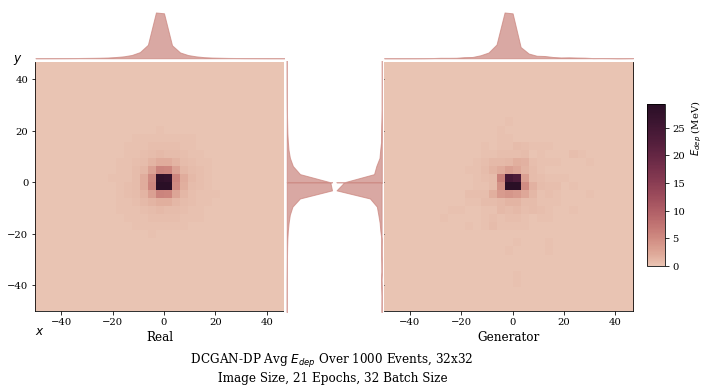

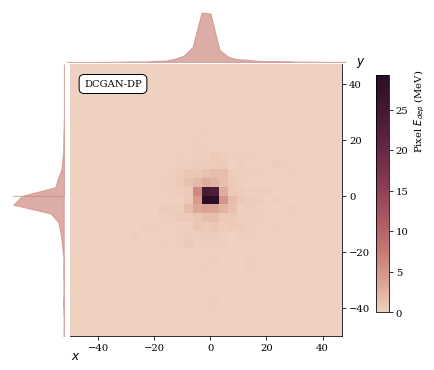

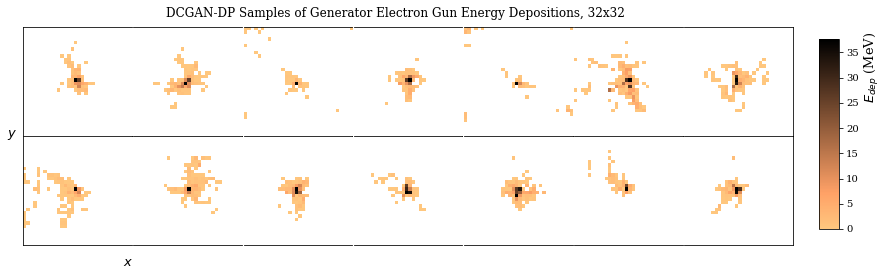

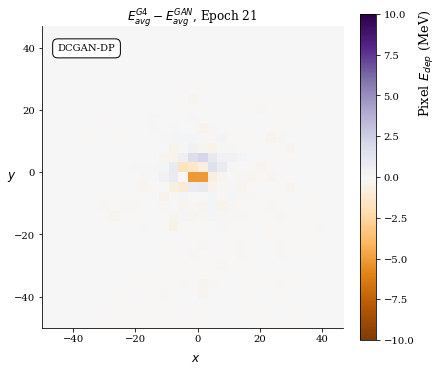

[21/50][0/938] Loss_D: 1.0044 Loss_G: 1.3352 D(x): 0.6931 D(G(z)): 0.4473 / 0.2780
[21/50][100/938] Loss_D: 1.0278 Loss_G: 0.8254 D(x): 0.6758 D(G(z)): 0.4596 / 0.4482
[21/50][200/938] Loss_D: 0.8884 Loss_G: 0.7779 D(x): 0.7439 D(G(z)): 0.4382 / 0.4648
[21/50][300/938] Loss_D: 0.7128 Loss_G: 1.0372 D(x): 0.7089 D(G(z)): 0.2983 / 0.3604
[21/50][400/938] Loss_D: 1.2607 Loss_G: 0.8381 D(x): 0.5522 D(G(z)): 0.4634 / 0.4400
[21/50][500/938] Loss_D: 0.8908 Loss_G: 1.1474 D(x): 0.7841 D(G(z)): 0.4636 / 0.3333
[21/50][600/938] Loss_D: 1.1100 Loss_G: 1.1775 D(x): 0.5240 D(G(z)): 0.3555 / 0.3204
[21/50][700/938] Loss_D: 0.8664 Loss_G: 1.4225 D(x): 0.6902 D(G(z)): 0.3753 / 0.2526
[21/50][800/938] Loss_D: 1.1606 Loss_G: 1.1160 D(x): 0.6067 D(G(z)): 0.4647 / 0.3384
[21/50][900/938] Loss_D: 0.7563 Loss_G: 0.9865 D(x): 0.5837 D(G(z)): 0.1734 / 0.3900
(32, 32)


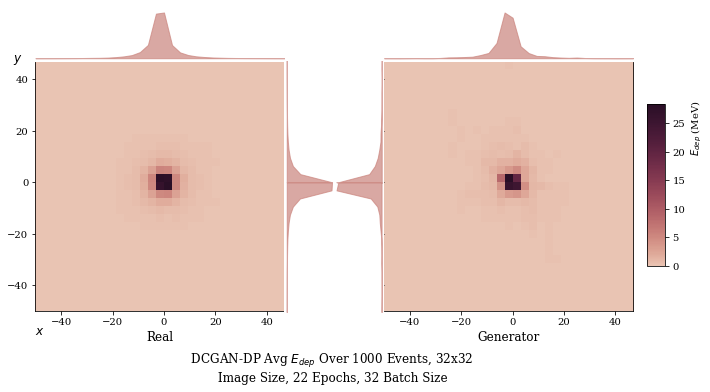

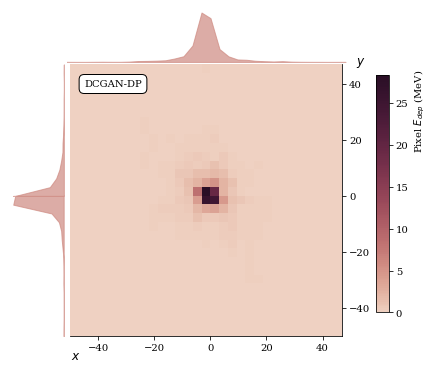

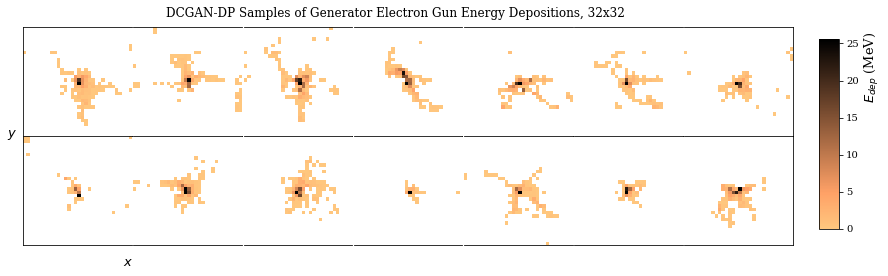

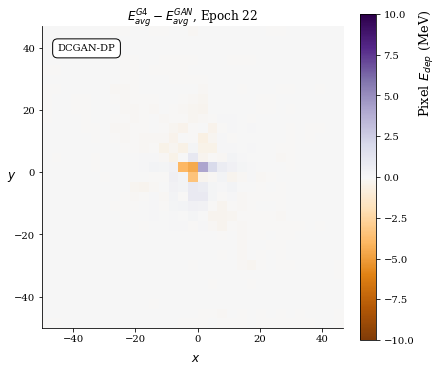

[22/50][0/938] Loss_D: 0.8284 Loss_G: 1.0621 D(x): 0.7116 D(G(z)): 0.3669 / 0.3605
[22/50][100/938] Loss_D: 1.0514 Loss_G: 0.7754 D(x): 0.6316 D(G(z)): 0.4329 / 0.4666
[22/50][200/938] Loss_D: 0.9120 Loss_G: 0.9238 D(x): 0.5702 D(G(z)): 0.2818 / 0.4096
[22/50][300/938] Loss_D: 0.9768 Loss_G: 0.8518 D(x): 0.6240 D(G(z)): 0.3814 / 0.4374
[22/50][400/938] Loss_D: 0.9496 Loss_G: 1.6307 D(x): 0.6851 D(G(z)): 0.4202 / 0.2065
[22/50][500/938] Loss_D: 0.8426 Loss_G: 1.1273 D(x): 0.6386 D(G(z)): 0.2910 / 0.3369
[22/50][600/938] Loss_D: 0.7954 Loss_G: 1.0872 D(x): 0.5932 D(G(z)): 0.2167 / 0.3500
[22/50][700/938] Loss_D: 0.7814 Loss_G: 1.6656 D(x): 0.7326 D(G(z)): 0.3631 / 0.2031
[22/50][800/938] Loss_D: 1.1096 Loss_G: 1.2406 D(x): 0.5425 D(G(z)): 0.3757 / 0.2995
[22/50][900/938] Loss_D: 0.9220 Loss_G: 0.8859 D(x): 0.7382 D(G(z)): 0.4507 / 0.4193
(32, 32)


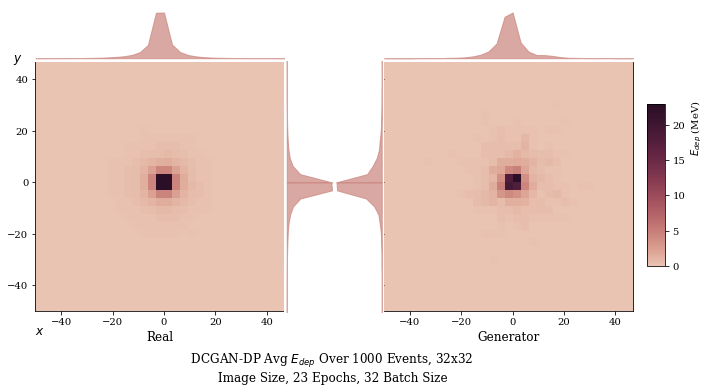

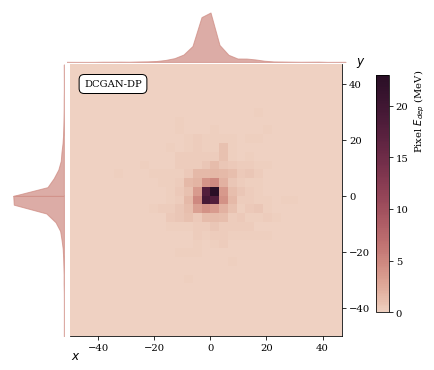

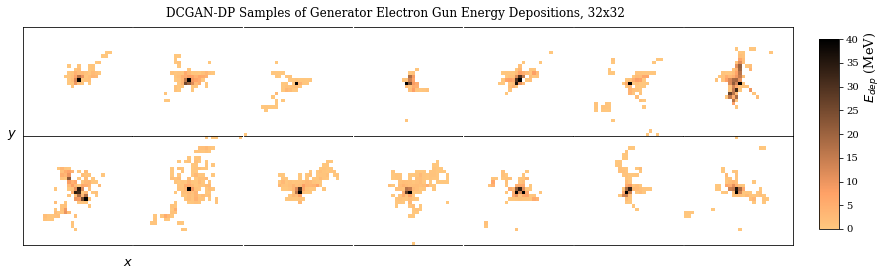

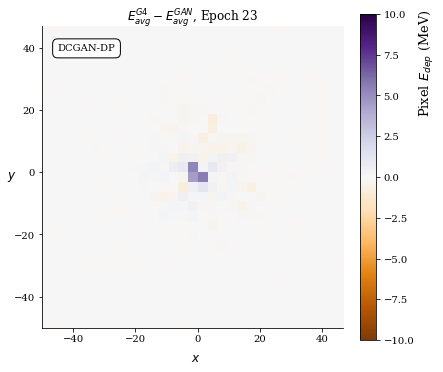

[23/50][0/938] Loss_D: 1.1034 Loss_G: 1.2218 D(x): 0.7308 D(G(z)): 0.5284 / 0.3037
[23/50][100/938] Loss_D: 1.1133 Loss_G: 0.7894 D(x): 0.5136 D(G(z)): 0.3401 / 0.4654
[23/50][200/938] Loss_D: 0.8105 Loss_G: 0.9098 D(x): 0.7488 D(G(z)): 0.3986 / 0.4089
[23/50][300/938] Loss_D: 0.9262 Loss_G: 1.0282 D(x): 0.7276 D(G(z)): 0.4431 / 0.3677
[23/50][400/938] Loss_D: 0.9667 Loss_G: 1.2001 D(x): 0.7453 D(G(z)): 0.4740 / 0.3112
[23/50][500/938] Loss_D: 0.9380 Loss_G: 0.8475 D(x): 0.6225 D(G(z)): 0.3481 / 0.4365
[23/50][600/938] Loss_D: 0.7781 Loss_G: 1.4556 D(x): 0.6250 D(G(z)): 0.2516 / 0.2429
[23/50][700/938] Loss_D: 0.8152 Loss_G: 1.4982 D(x): 0.8311 D(G(z)): 0.4542 / 0.2362
[23/50][800/938] Loss_D: 1.1679 Loss_G: 1.0309 D(x): 0.7884 D(G(z)): 0.5959 / 0.3670
[23/50][900/938] Loss_D: 1.1751 Loss_G: 1.0719 D(x): 0.4472 D(G(z)): 0.2875 / 0.3522
(32, 32)


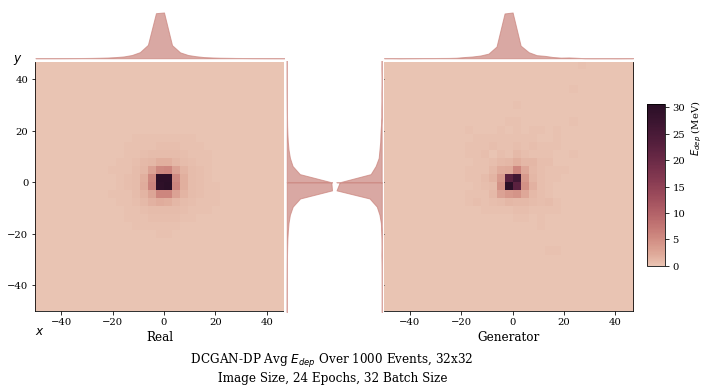

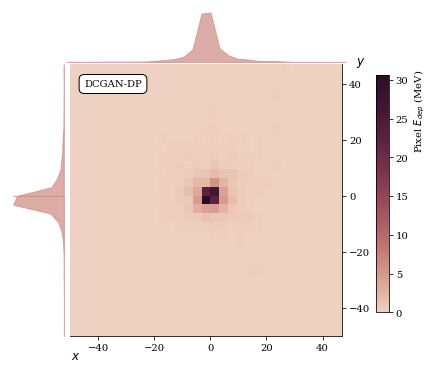

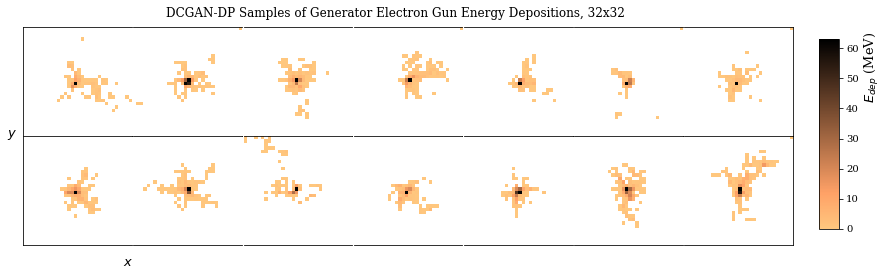

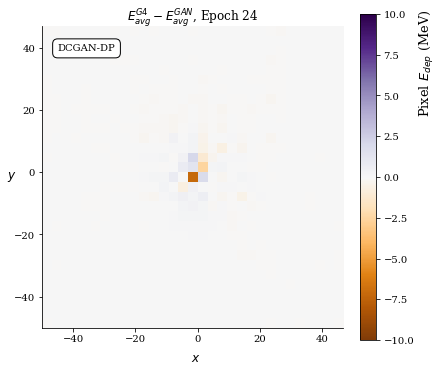

[24/50][0/938] Loss_D: 0.7825 Loss_G: 1.6795 D(x): 0.8262 D(G(z)): 0.4346 / 0.1962
[24/50][100/938] Loss_D: 0.9175 Loss_G: 0.7428 D(x): 0.6636 D(G(z)): 0.3852 / 0.4866
[24/50][200/938] Loss_D: 1.3337 Loss_G: 1.2513 D(x): 0.6318 D(G(z)): 0.5698 / 0.2961
[24/50][300/938] Loss_D: 0.8127 Loss_G: 1.5063 D(x): 0.5739 D(G(z)): 0.2122 / 0.2387
[24/50][400/938] Loss_D: 1.0819 Loss_G: 1.5052 D(x): 0.7800 D(G(z)): 0.5525 / 0.2337
[24/50][500/938] Loss_D: 0.7344 Loss_G: 1.0422 D(x): 0.7554 D(G(z)): 0.3575 / 0.3597
[24/50][600/938] Loss_D: 1.2355 Loss_G: 1.5839 D(x): 0.3701 D(G(z)): 0.1095 / 0.2155
[24/50][700/938] Loss_D: 0.6462 Loss_G: 1.3563 D(x): 0.7806 D(G(z)): 0.3209 / 0.2682
[24/50][800/938] Loss_D: 0.9581 Loss_G: 1.3912 D(x): 0.7598 D(G(z)): 0.4795 / 0.2618
[24/50][900/938] Loss_D: 1.1860 Loss_G: 1.2154 D(x): 0.7105 D(G(z)): 0.5548 / 0.3077
(32, 32)


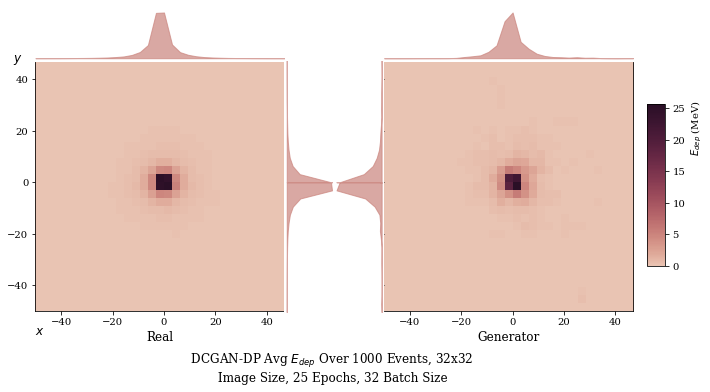

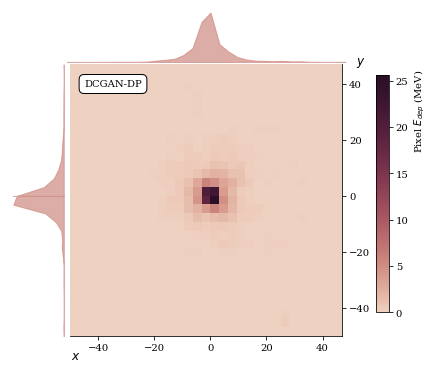

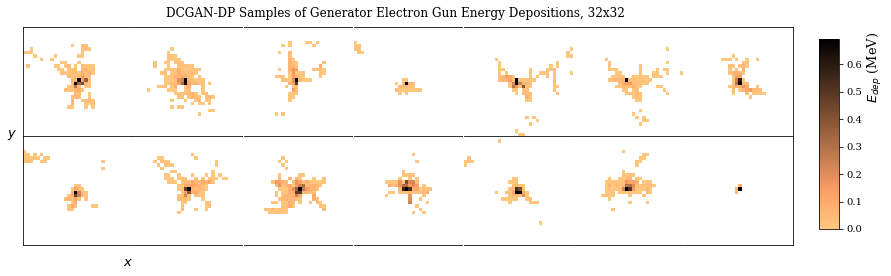

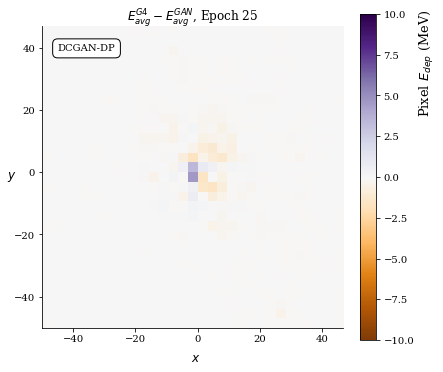

[25/50][0/938] Loss_D: 0.8329 Loss_G: 1.2056 D(x): 0.7256 D(G(z)): 0.3799 / 0.3090
[25/50][100/938] Loss_D: 1.0221 Loss_G: 1.0820 D(x): 0.6156 D(G(z)): 0.4006 / 0.3507
[25/50][200/938] Loss_D: 1.3960 Loss_G: 0.7602 D(x): 0.5136 D(G(z)): 0.5010 / 0.4772
[25/50][300/938] Loss_D: 0.8502 Loss_G: 1.5590 D(x): 0.8042 D(G(z)): 0.4613 / 0.2168
[25/50][400/938] Loss_D: 0.7741 Loss_G: 1.2600 D(x): 0.6917 D(G(z)): 0.3154 / 0.3144
[25/50][500/938] Loss_D: 1.4832 Loss_G: 1.0206 D(x): 0.2976 D(G(z)): 0.1855 / 0.3667
[25/50][600/938] Loss_D: 1.0777 Loss_G: 0.9927 D(x): 0.5197 D(G(z)): 0.3329 / 0.3750
[25/50][700/938] Loss_D: 0.8018 Loss_G: 1.4250 D(x): 0.6932 D(G(z)): 0.3380 / 0.2515
[25/50][800/938] Loss_D: 1.1036 Loss_G: 1.1702 D(x): 0.7680 D(G(z)): 0.5556 / 0.3170
[25/50][900/938] Loss_D: 0.9147 Loss_G: 0.9155 D(x): 0.6019 D(G(z)): 0.3201 / 0.4070
(32, 32)


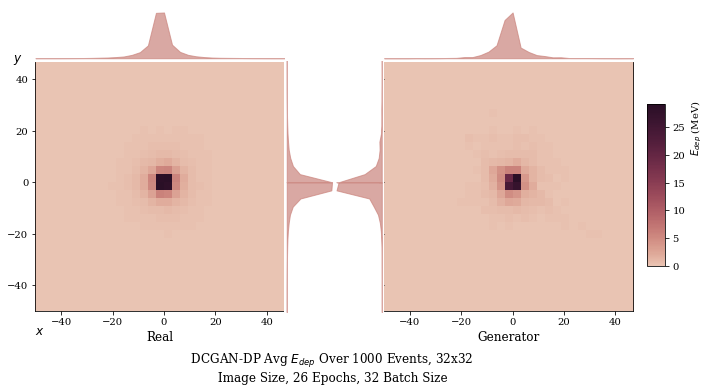

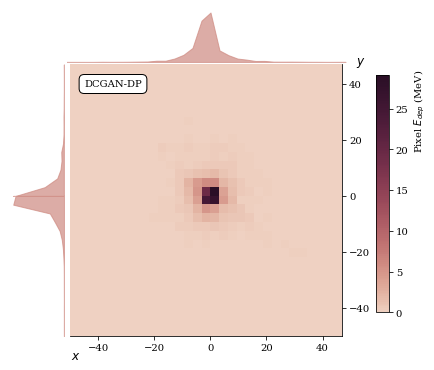

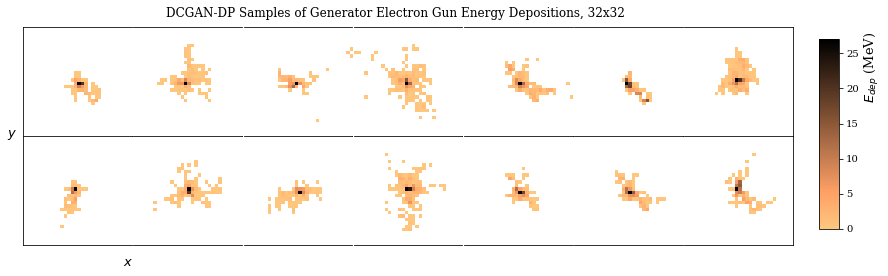

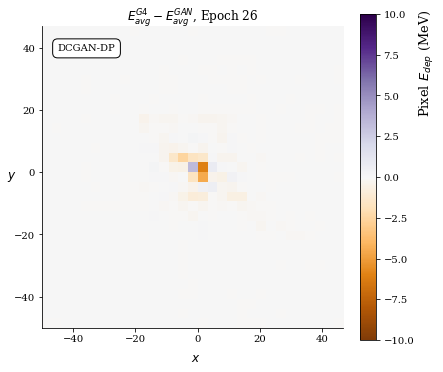

[26/50][0/938] Loss_D: 0.8343 Loss_G: 1.6374 D(x): 0.8507 D(G(z)): 0.4786 / 0.2021
[26/50][100/938] Loss_D: 1.1259 Loss_G: 0.9032 D(x): 0.5806 D(G(z)): 0.4233 / 0.4187
[26/50][200/938] Loss_D: 0.8849 Loss_G: 1.0096 D(x): 0.5049 D(G(z)): 0.1524 / 0.3825
[26/50][300/938] Loss_D: 0.7178 Loss_G: 1.2845 D(x): 0.6754 D(G(z)): 0.2645 / 0.2894
[26/50][400/938] Loss_D: 0.8489 Loss_G: 1.0564 D(x): 0.5890 D(G(z)): 0.2585 / 0.3546
[26/50][500/938] Loss_D: 0.7953 Loss_G: 0.9312 D(x): 0.6003 D(G(z)): 0.2324 / 0.4005
[26/50][600/938] Loss_D: 1.0213 Loss_G: 1.0655 D(x): 0.5791 D(G(z)): 0.3651 / 0.3510
[26/50][700/938] Loss_D: 1.0482 Loss_G: 1.6317 D(x): 0.6629 D(G(z)): 0.4491 / 0.2089
[26/50][800/938] Loss_D: 0.8782 Loss_G: 1.2809 D(x): 0.7988 D(G(z)): 0.4571 / 0.2889
[26/50][900/938] Loss_D: 0.9402 Loss_G: 0.8124 D(x): 0.6556 D(G(z)): 0.3871 / 0.4547
(32, 32)


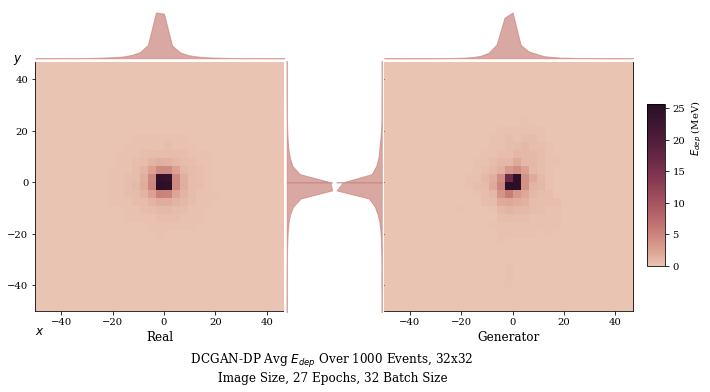

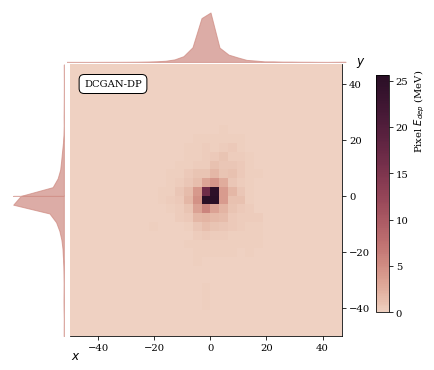

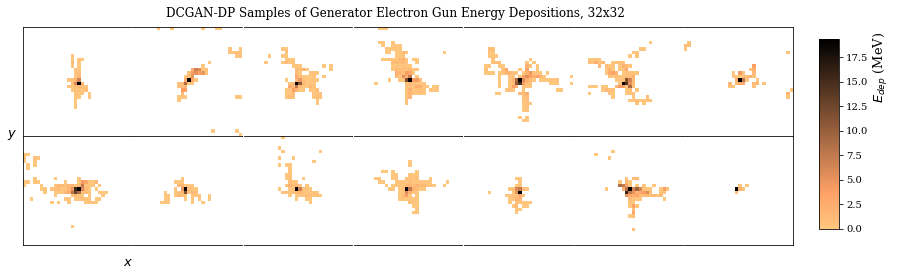

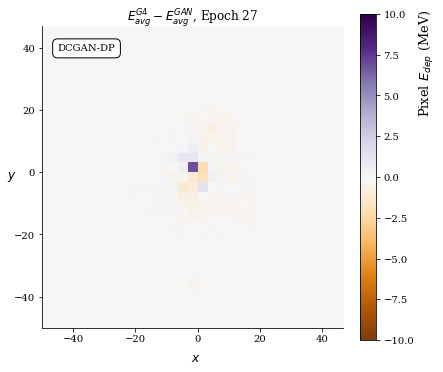

[27/50][0/938] Loss_D: 0.6102 Loss_G: 1.2012 D(x): 0.6930 D(G(z)): 0.2010 / 0.3144
[27/50][100/938] Loss_D: 1.0172 Loss_G: 0.8875 D(x): 0.5641 D(G(z)): 0.3353 / 0.4224
[27/50][200/938] Loss_D: 1.1041 Loss_G: 1.3241 D(x): 0.8189 D(G(z)): 0.5894 / 0.2724
[27/50][300/938] Loss_D: 0.7868 Loss_G: 1.2507 D(x): 0.7166 D(G(z)): 0.3539 / 0.2989
[27/50][400/938] Loss_D: 0.8645 Loss_G: 1.2044 D(x): 0.7518 D(G(z)): 0.4296 / 0.3117
[27/50][500/938] Loss_D: 0.9707 Loss_G: 0.6944 D(x): 0.5295 D(G(z)): 0.2748 / 0.5051
[27/50][600/938] Loss_D: 0.9575 Loss_G: 1.2981 D(x): 0.7170 D(G(z)): 0.4557 / 0.2807
[27/50][700/938] Loss_D: 0.9015 Loss_G: 1.5423 D(x): 0.7915 D(G(z)): 0.4756 / 0.2222
[27/50][800/938] Loss_D: 0.7940 Loss_G: 1.9202 D(x): 0.8363 D(G(z)): 0.4530 / 0.1513
[27/50][900/938] Loss_D: 0.7491 Loss_G: 1.3913 D(x): 0.6943 D(G(z)): 0.3035 / 0.2560
(32, 32)


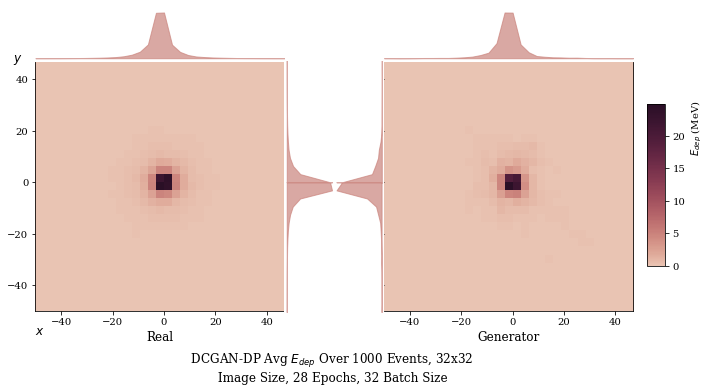

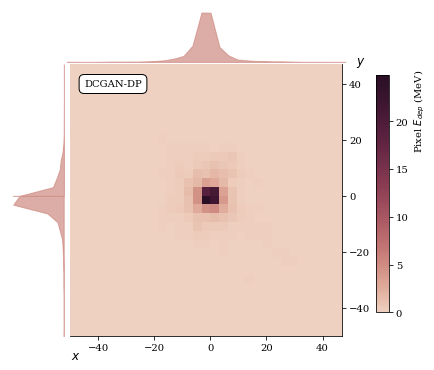

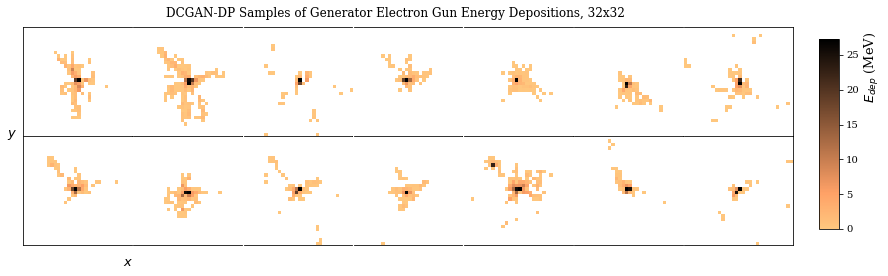

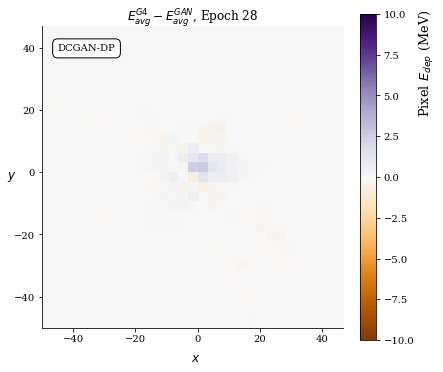

[28/50][0/938] Loss_D: 0.7646 Loss_G: 1.2102 D(x): 0.7015 D(G(z)): 0.3208 / 0.3061
[28/50][100/938] Loss_D: 0.7700 Loss_G: 0.8731 D(x): 0.6762 D(G(z)): 0.3042 / 0.4283
[28/50][200/938] Loss_D: 0.8072 Loss_G: 0.9025 D(x): 0.7062 D(G(z)): 0.3554 / 0.4170
[28/50][300/938] Loss_D: 0.8973 Loss_G: 0.8417 D(x): 0.5926 D(G(z)): 0.2904 / 0.4393
[28/50][400/938] Loss_D: 0.8043 Loss_G: 0.9954 D(x): 0.7506 D(G(z)): 0.3956 / 0.3762
[28/50][500/938] Loss_D: 0.7607 Loss_G: 1.0546 D(x): 0.6780 D(G(z)): 0.2974 / 0.3550
[28/50][600/938] Loss_D: 0.7815 Loss_G: 1.0300 D(x): 0.6129 D(G(z)): 0.2434 / 0.3641
[28/50][700/938] Loss_D: 0.7874 Loss_G: 1.4102 D(x): 0.8215 D(G(z)): 0.4322 / 0.2599
[28/50][800/938] Loss_D: 0.8695 Loss_G: 1.0204 D(x): 0.7279 D(G(z)): 0.4145 / 0.3678
[28/50][900/938] Loss_D: 0.6135 Loss_G: 1.0184 D(x): 0.7492 D(G(z)): 0.2703 / 0.3709
(32, 32)


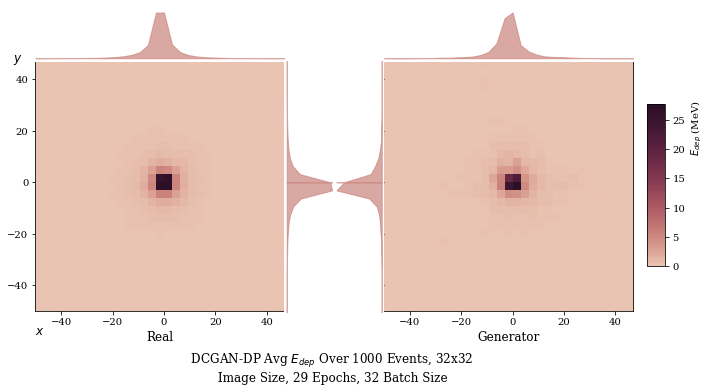

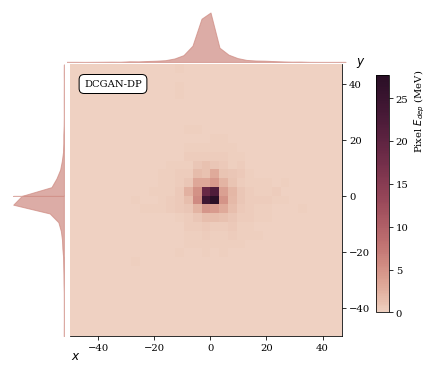

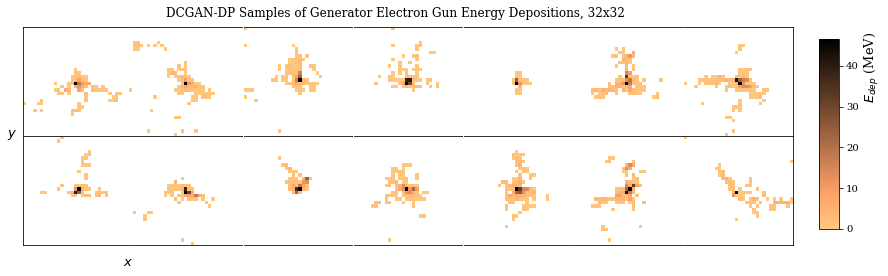

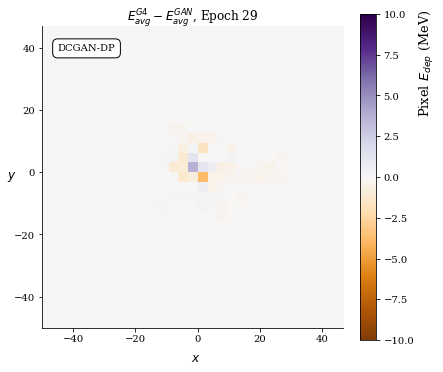

[29/50][0/938] Loss_D: 0.5942 Loss_G: 1.1570 D(x): 0.7675 D(G(z)): 0.2650 / 0.3258
[29/50][100/938] Loss_D: 1.0972 Loss_G: 0.5842 D(x): 0.5539 D(G(z)): 0.3864 / 0.5641
[29/50][200/938] Loss_D: 0.8803 Loss_G: 0.8030 D(x): 0.5492 D(G(z)): 0.2327 / 0.4545
[29/50][300/938] Loss_D: 0.7684 Loss_G: 1.0725 D(x): 0.7255 D(G(z)): 0.3510 / 0.3516
[29/50][400/938] Loss_D: 0.7637 Loss_G: 0.8260 D(x): 0.7304 D(G(z)): 0.3513 / 0.4447
[29/50][500/938] Loss_D: 1.0663 Loss_G: 0.8218 D(x): 0.6241 D(G(z)): 0.4372 / 0.4469
[29/50][600/938] Loss_D: 0.9414 Loss_G: 1.3525 D(x): 0.6514 D(G(z)): 0.3838 / 0.2700
[29/50][700/938] Loss_D: 0.6895 Loss_G: 1.6011 D(x): 0.7352 D(G(z)): 0.3048 / 0.2189
[29/50][800/938] Loss_D: 0.9459 Loss_G: 1.2351 D(x): 0.7450 D(G(z)): 0.4711 / 0.2972
[29/50][900/938] Loss_D: 1.2336 Loss_G: 0.8329 D(x): 0.5020 D(G(z)): 0.3950 / 0.4465
(32, 32)


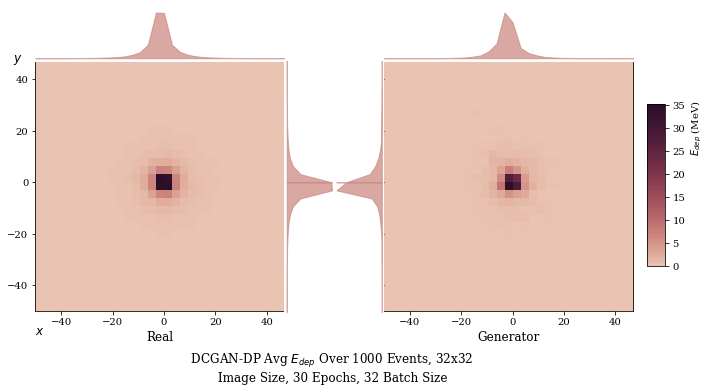

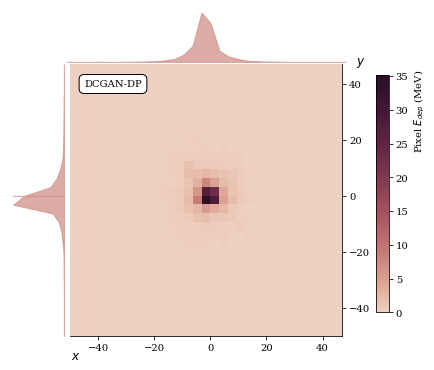

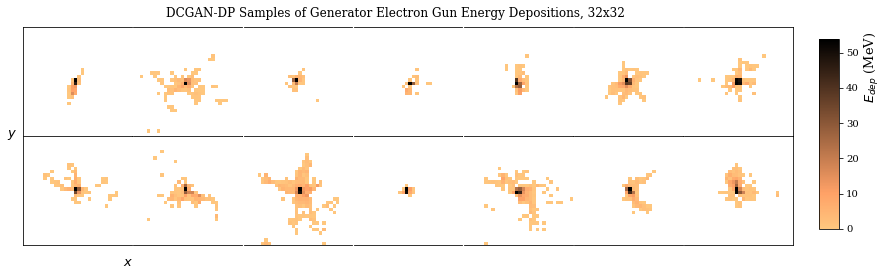

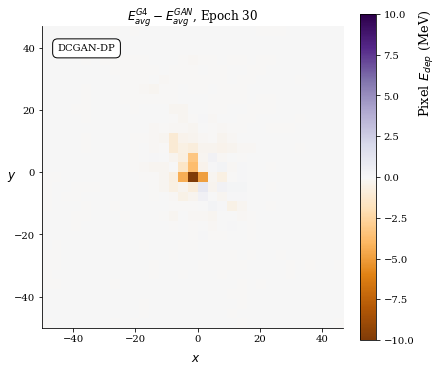

[30/50][0/938] Loss_D: 0.7467 Loss_G: 1.5092 D(x): 0.8366 D(G(z)): 0.4251 / 0.2327
[30/50][100/938] Loss_D: 0.9393 Loss_G: 0.8072 D(x): 0.6874 D(G(z)): 0.4149 / 0.4562
[30/50][200/938] Loss_D: 1.1015 Loss_G: 0.7821 D(x): 0.5602 D(G(z)): 0.3954 / 0.4631
[30/50][300/938] Loss_D: 0.7483 Loss_G: 1.0788 D(x): 0.6824 D(G(z)): 0.2992 / 0.3464
[30/50][400/938] Loss_D: 1.2188 Loss_G: 1.4069 D(x): 0.8141 D(G(z)): 0.6256 / 0.2547
[30/50][500/938] Loss_D: 0.9108 Loss_G: 1.0168 D(x): 0.5394 D(G(z)): 0.2388 / 0.3691
[30/50][600/938] Loss_D: 0.7370 Loss_G: 1.1690 D(x): 0.6828 D(G(z)): 0.2870 / 0.3248
[30/50][700/938] Loss_D: 0.9401 Loss_G: 1.1330 D(x): 0.6940 D(G(z)): 0.4275 / 0.3286
[30/50][800/938] Loss_D: 0.7834 Loss_G: 1.4247 D(x): 0.7503 D(G(z)): 0.3719 / 0.2500
[30/50][900/938] Loss_D: 1.0872 Loss_G: 1.1441 D(x): 0.7222 D(G(z)): 0.5220 / 0.3264
(32, 32)


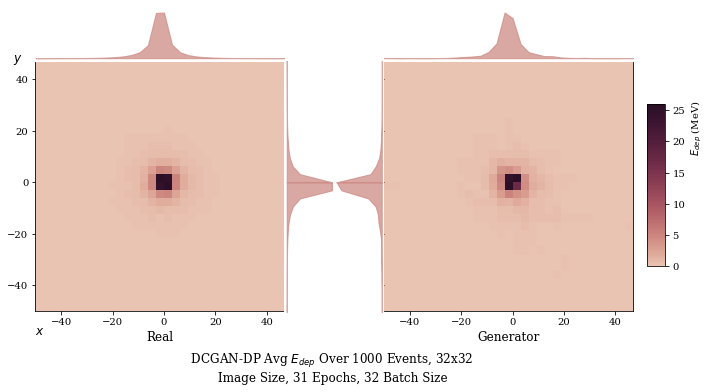

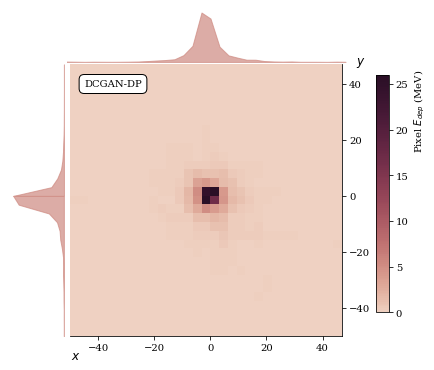

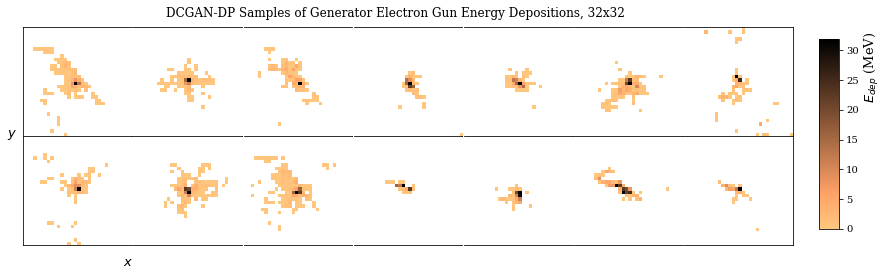

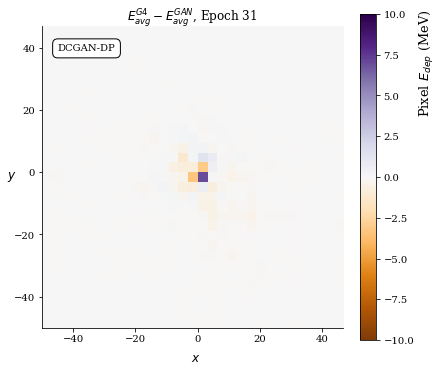

[31/50][0/938] Loss_D: 1.0468 Loss_G: 1.5478 D(x): 0.9195 D(G(z)): 0.6071 / 0.2222
[31/50][100/938] Loss_D: 0.7702 Loss_G: 1.2581 D(x): 0.7545 D(G(z)): 0.3798 / 0.2943
[31/50][200/938] Loss_D: 1.1882 Loss_G: 1.0559 D(x): 0.4053 D(G(z)): 0.2307 / 0.3620
[31/50][300/938] Loss_D: 0.8362 Loss_G: 1.3519 D(x): 0.7228 D(G(z)): 0.3931 / 0.2654
[31/50][400/938] Loss_D: 0.9094 Loss_G: 1.2775 D(x): 0.6590 D(G(z)): 0.3802 / 0.2863
[31/50][500/938] Loss_D: 1.1249 Loss_G: 1.0885 D(x): 0.5182 D(G(z)): 0.3463 / 0.3451
[31/50][600/938] Loss_D: 0.9230 Loss_G: 1.1922 D(x): 0.7122 D(G(z)): 0.4341 / 0.3105
[31/50][700/938] Loss_D: 0.9310 Loss_G: 1.8064 D(x): 0.8216 D(G(z)): 0.5107 / 0.1736
[31/50][800/938] Loss_D: 0.9950 Loss_G: 1.3159 D(x): 0.8495 D(G(z)): 0.5498 / 0.2830
[31/50][900/938] Loss_D: 1.2741 Loss_G: 1.2261 D(x): 0.4496 D(G(z)): 0.3634 / 0.3018
(32, 32)


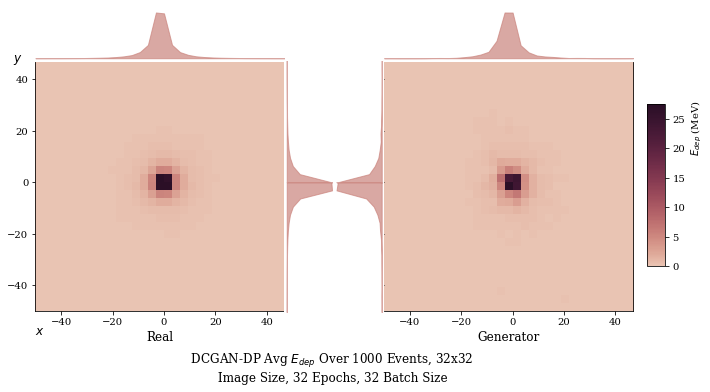

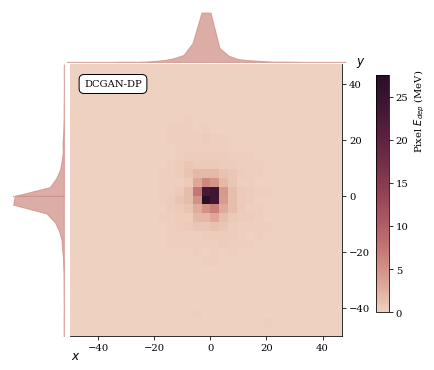

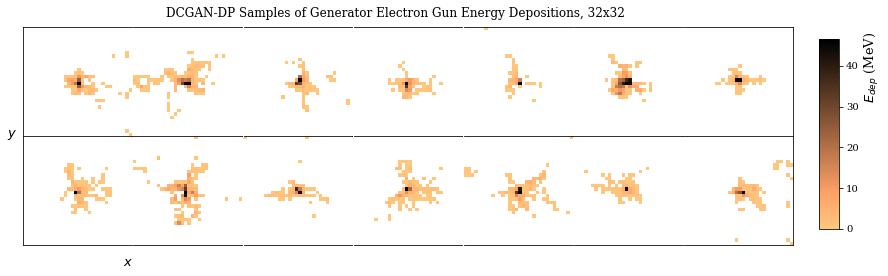

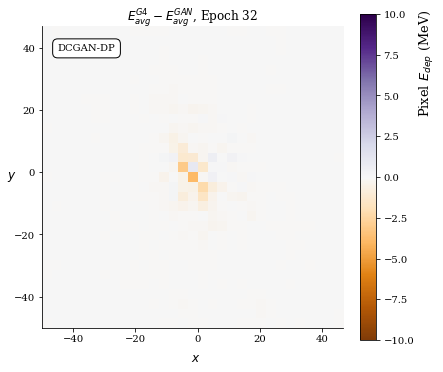

[32/50][0/938] Loss_D: 1.0027 Loss_G: 1.4115 D(x): 0.8515 D(G(z)): 0.5578 / 0.2501
[32/50][100/938] Loss_D: 1.1647 Loss_G: 0.6622 D(x): 0.6152 D(G(z)): 0.4765 / 0.5270
[32/50][200/938] Loss_D: 0.9430 Loss_G: 0.7009 D(x): 0.6499 D(G(z)): 0.3920 / 0.5021
[32/50][300/938] Loss_D: 0.8172 Loss_G: 1.0951 D(x): 0.7260 D(G(z)): 0.3851 / 0.3416
[32/50][400/938] Loss_D: 1.1696 Loss_G: 1.1035 D(x): 0.6493 D(G(z)): 0.5059 / 0.3413
[32/50][500/938] Loss_D: 1.1047 Loss_G: 1.1790 D(x): 0.6864 D(G(z)): 0.5028 / 0.3206
[32/50][600/938] Loss_D: 1.0958 Loss_G: 1.6631 D(x): 0.8525 D(G(z)): 0.6023 / 0.1941
[32/50][700/938] Loss_D: 1.0565 Loss_G: 1.2941 D(x): 0.6964 D(G(z)): 0.4902 / 0.2826
[32/50][800/938] Loss_D: 0.8397 Loss_G: 1.1484 D(x): 0.6973 D(G(z)): 0.3740 / 0.3227
[32/50][900/938] Loss_D: 0.6025 Loss_G: 1.4570 D(x): 0.6792 D(G(z)): 0.1884 / 0.2436
(32, 32)


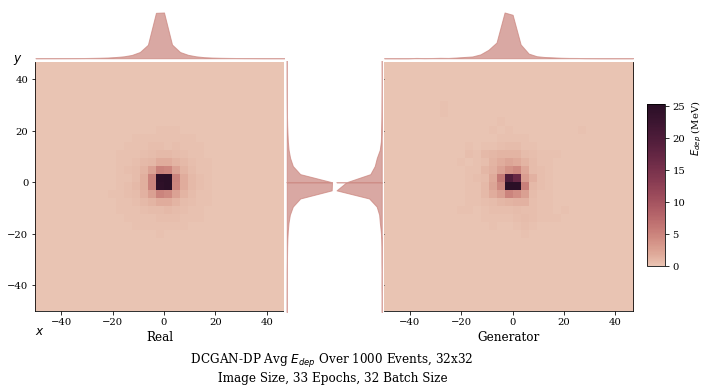

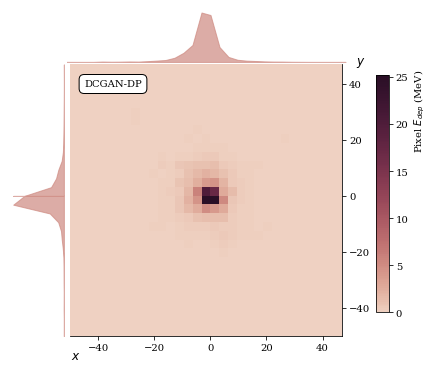

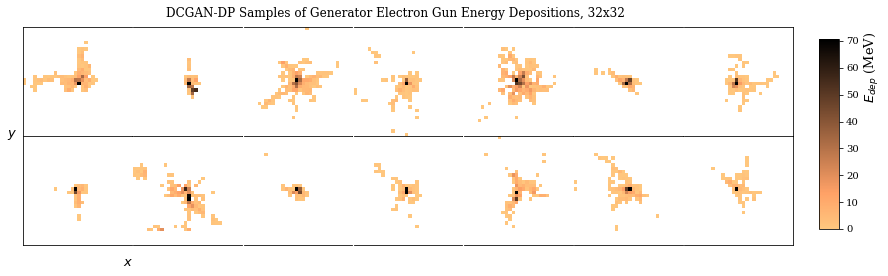

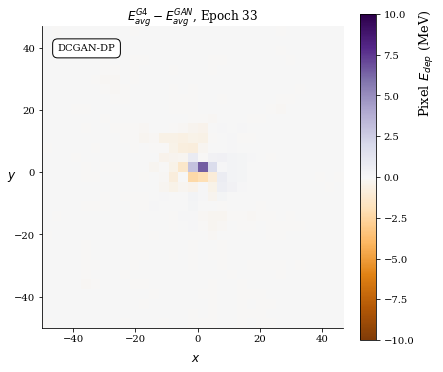

[33/50][0/938] Loss_D: 0.7684 Loss_G: 1.1670 D(x): 0.6492 D(G(z)): 0.2753 / 0.3182
[33/50][100/938] Loss_D: 1.0712 Loss_G: 0.9889 D(x): 0.5299 D(G(z)): 0.3422 / 0.3767
[33/50][200/938] Loss_D: 0.9755 Loss_G: 0.6817 D(x): 0.5534 D(G(z)): 0.3090 / 0.5148
[33/50][300/938] Loss_D: 0.9477 Loss_G: 1.0344 D(x): 0.6947 D(G(z)): 0.4292 / 0.3657
[33/50][400/938] Loss_D: 1.0336 Loss_G: 1.0160 D(x): 0.6454 D(G(z)): 0.4363 / 0.3694
[33/50][500/938] Loss_D: 0.9900 Loss_G: 0.8489 D(x): 0.6429 D(G(z)): 0.4106 / 0.4332
[33/50][600/938] Loss_D: 0.6571 Loss_G: 1.1922 D(x): 0.8192 D(G(z)): 0.3551 / 0.3133
[33/50][700/938] Loss_D: 1.0535 Loss_G: 1.5846 D(x): 0.8408 D(G(z)): 0.5702 / 0.2170
[33/50][800/938] Loss_D: 1.4498 Loss_G: 1.1715 D(x): 0.7840 D(G(z)): 0.6836 / 0.3293
[33/50][900/938] Loss_D: 1.1035 Loss_G: 1.0599 D(x): 0.6986 D(G(z)): 0.5087 / 0.3567
(32, 32)


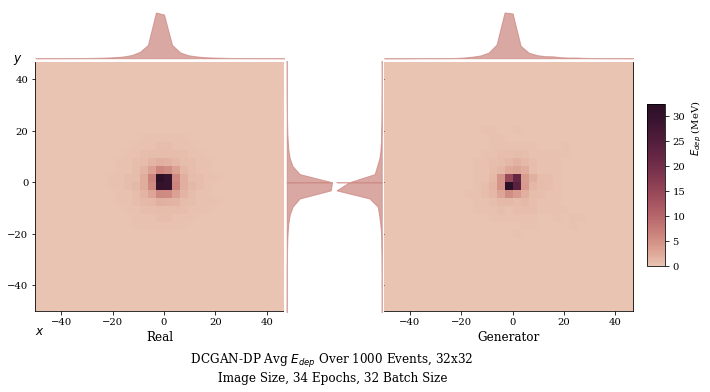

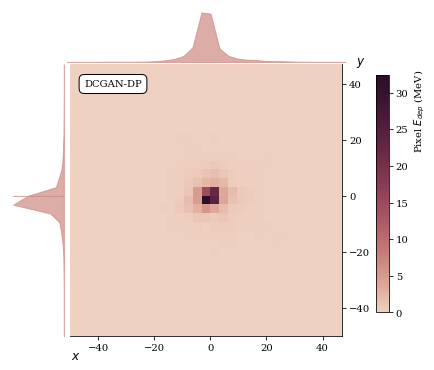

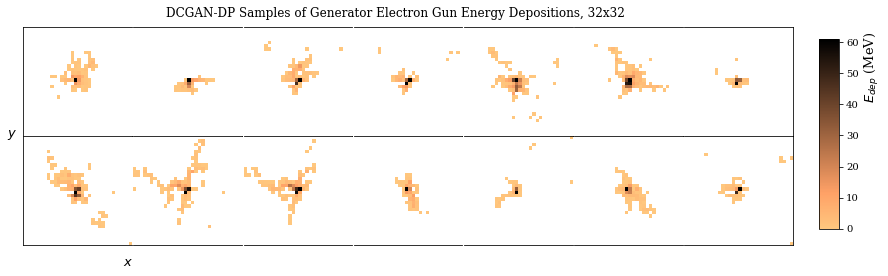

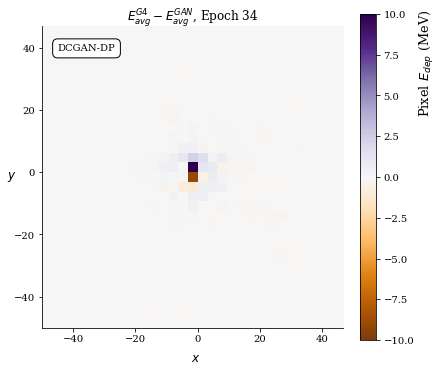

[34/50][0/938] Loss_D: 0.8860 Loss_G: 1.4225 D(x): 0.8474 D(G(z)): 0.4947 / 0.2551
[34/50][100/938] Loss_D: 0.9675 Loss_G: 0.8664 D(x): 0.6915 D(G(z)): 0.4388 / 0.4282
[34/50][200/938] Loss_D: 0.8043 Loss_G: 0.9717 D(x): 0.7215 D(G(z)): 0.3599 / 0.3912
[34/50][300/938] Loss_D: 0.6915 Loss_G: 1.2445 D(x): 0.7057 D(G(z)): 0.2791 / 0.2995
[34/50][400/938] Loss_D: 0.5967 Loss_G: 0.9455 D(x): 0.7366 D(G(z)): 0.2392 / 0.3986
[34/50][500/938] Loss_D: 0.8005 Loss_G: 1.2025 D(x): 0.7538 D(G(z)): 0.3928 / 0.3082
[34/50][600/938] Loss_D: 1.1490 Loss_G: 1.2002 D(x): 0.7513 D(G(z)): 0.5685 / 0.3071
[34/50][700/938] Loss_D: 0.9500 Loss_G: 1.9625 D(x): 0.4523 D(G(z)): 0.1238 / 0.1464
[34/50][800/938] Loss_D: 1.0574 Loss_G: 1.5014 D(x): 0.7568 D(G(z)): 0.5208 / 0.2356
[34/50][900/938] Loss_D: 0.7670 Loss_G: 1.2251 D(x): 0.6221 D(G(z)): 0.2366 / 0.3145
(32, 32)


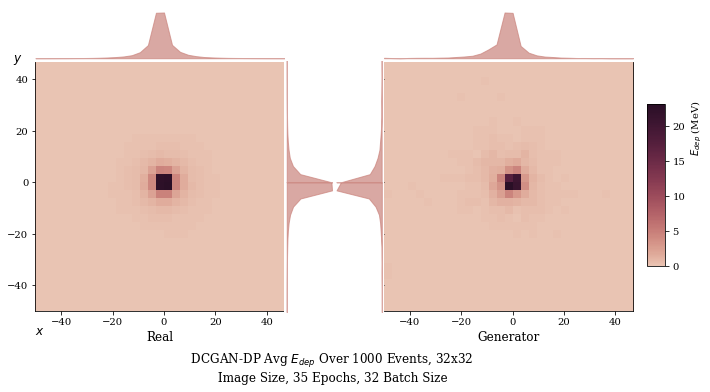

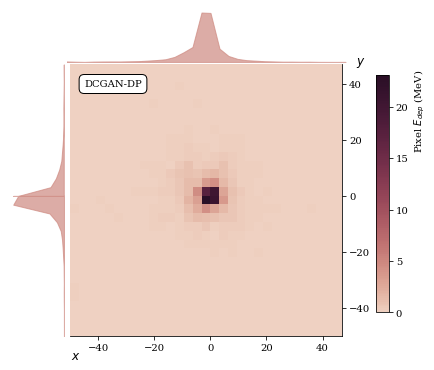

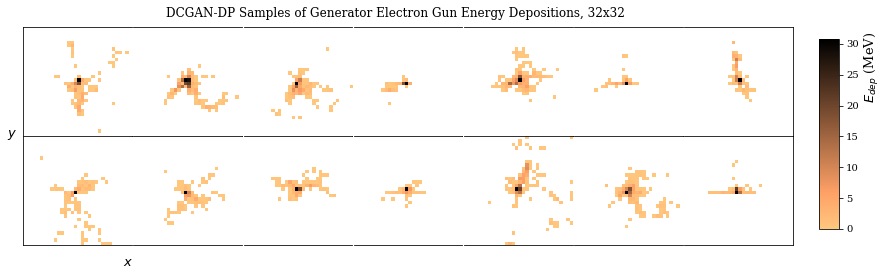

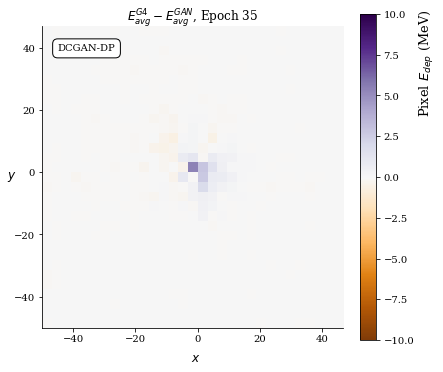

[35/50][0/938] Loss_D: 0.9612 Loss_G: 1.1742 D(x): 0.8081 D(G(z)): 0.5146 / 0.3192
[35/50][100/938] Loss_D: 0.9728 Loss_G: 1.4431 D(x): 0.8184 D(G(z)): 0.5248 / 0.2441
[35/50][200/938] Loss_D: 0.9302 Loss_G: 0.8083 D(x): 0.6793 D(G(z)): 0.4051 / 0.4565
[35/50][300/938] Loss_D: 0.5684 Loss_G: 1.3802 D(x): 0.8040 D(G(z)): 0.2890 / 0.2587
[35/50][400/938] Loss_D: 1.2032 Loss_G: 1.1762 D(x): 0.5349 D(G(z)): 0.4220 / 0.3181
[35/50][500/938] Loss_D: 1.0089 Loss_G: 1.2164 D(x): 0.7438 D(G(z)): 0.5010 / 0.3034
[35/50][600/938] Loss_D: 0.9249 Loss_G: 1.2640 D(x): 0.7788 D(G(z)): 0.4828 / 0.2888
[35/50][700/938] Loss_D: 0.8355 Loss_G: 1.3098 D(x): 0.7243 D(G(z)): 0.3869 / 0.2834
[35/50][800/938] Loss_D: 0.8678 Loss_G: 1.3308 D(x): 0.7621 D(G(z)): 0.4286 / 0.2804
[35/50][900/938] Loss_D: 0.7591 Loss_G: 0.9941 D(x): 0.6560 D(G(z)): 0.2758 / 0.3787
(32, 32)


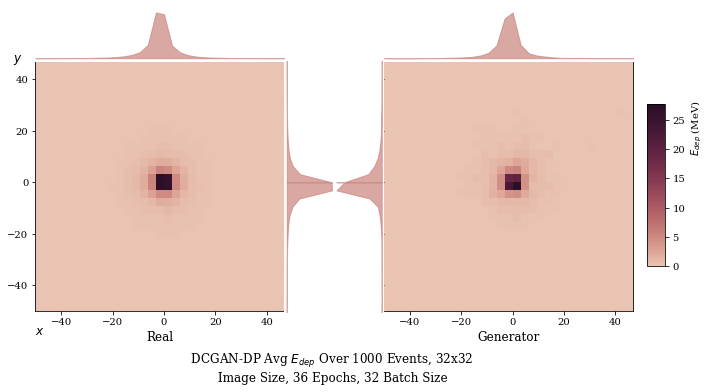

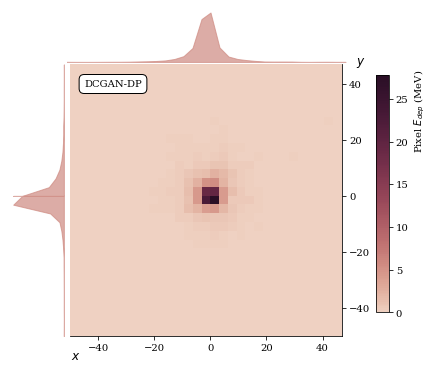

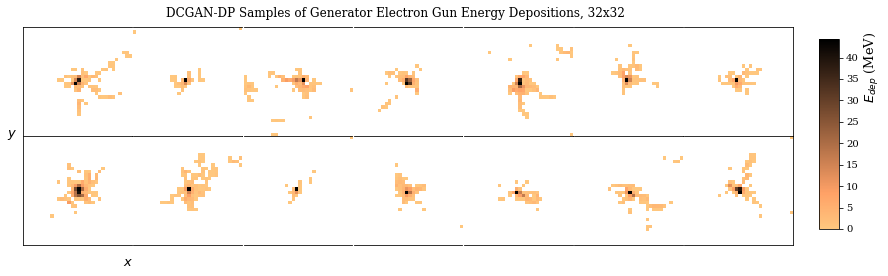

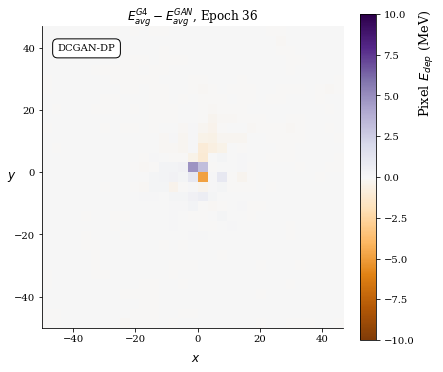

[36/50][0/938] Loss_D: 0.8781 Loss_G: 1.2928 D(x): 0.5594 D(G(z)): 0.2371 / 0.2832
[36/50][100/938] Loss_D: 0.7997 Loss_G: 1.1343 D(x): 0.8345 D(G(z)): 0.4525 / 0.3303
[36/50][200/938] Loss_D: 0.9559 Loss_G: 0.6901 D(x): 0.6383 D(G(z)): 0.3859 / 0.5071
[36/50][300/938] Loss_D: 1.0057 Loss_G: 1.8184 D(x): 0.8483 D(G(z)): 0.5566 / 0.1725
[36/50][400/938] Loss_D: 0.6399 Loss_G: 1.1107 D(x): 0.7083 D(G(z)): 0.2485 / 0.3373
[36/50][500/938] Loss_D: 1.1210 Loss_G: 0.8553 D(x): 0.5690 D(G(z)): 0.4098 / 0.4321
[36/50][600/938] Loss_D: 1.0353 Loss_G: 1.1511 D(x): 0.7229 D(G(z)): 0.4983 / 0.3249
[36/50][700/938] Loss_D: 0.9389 Loss_G: 1.3328 D(x): 0.7332 D(G(z)): 0.4564 / 0.2709
[36/50][800/938] Loss_D: 0.6798 Loss_G: 1.5735 D(x): 0.8493 D(G(z)): 0.3956 / 0.2165
[36/50][900/938] Loss_D: 0.9574 Loss_G: 1.2909 D(x): 0.4946 D(G(z)): 0.2065 / 0.2918
(32, 32)


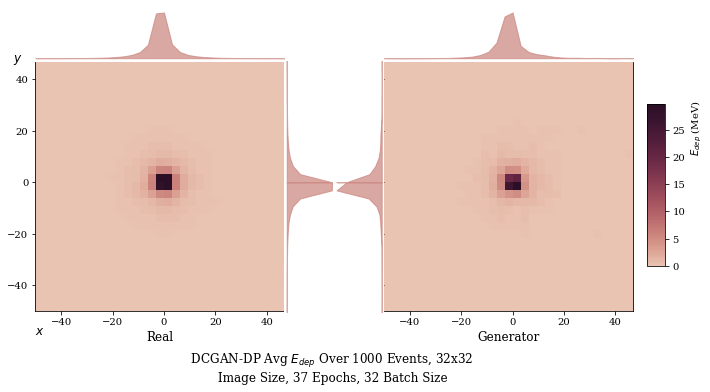

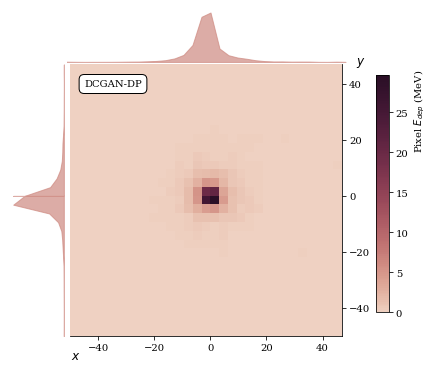

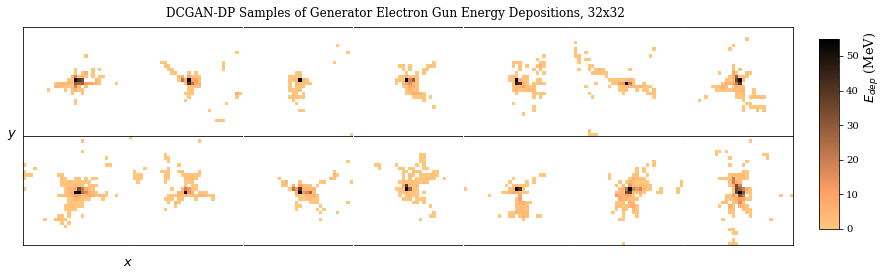

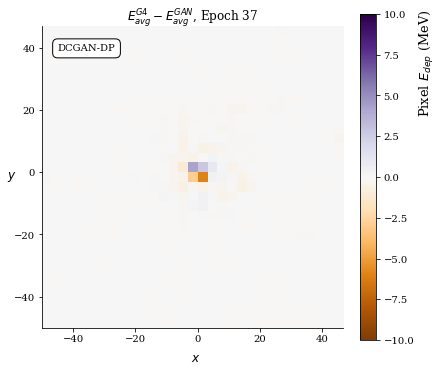

[37/50][0/938] Loss_D: 0.7956 Loss_G: 1.1707 D(x): 0.6401 D(G(z)): 0.2748 / 0.3217
[37/50][100/938] Loss_D: 0.8313 Loss_G: 0.7950 D(x): 0.5751 D(G(z)): 0.2216 / 0.4583
[37/50][200/938] Loss_D: 0.8140 Loss_G: 1.1135 D(x): 0.7823 D(G(z)): 0.4278 / 0.3326
[37/50][300/938] Loss_D: 1.0358 Loss_G: 1.3083 D(x): 0.8363 D(G(z)): 0.5636 / 0.2786
[37/50][400/938] Loss_D: 0.8285 Loss_G: 0.9947 D(x): 0.7238 D(G(z)): 0.3859 / 0.3789
[37/50][500/938] Loss_D: 1.0351 Loss_G: 1.0279 D(x): 0.7715 D(G(z)): 0.5249 / 0.3723
[37/50][600/938] Loss_D: 0.9636 Loss_G: 1.1011 D(x): 0.6424 D(G(z)): 0.3946 / 0.3409
[37/50][700/938] Loss_D: 0.9885 Loss_G: 1.3671 D(x): 0.5395 D(G(z)): 0.3000 / 0.2644
[37/50][800/938] Loss_D: 1.0833 Loss_G: 1.8716 D(x): 0.8779 D(G(z)): 0.6045 / 0.1616
[37/50][900/938] Loss_D: 0.8306 Loss_G: 1.0338 D(x): 0.7516 D(G(z)): 0.4119 / 0.3647
(32, 32)


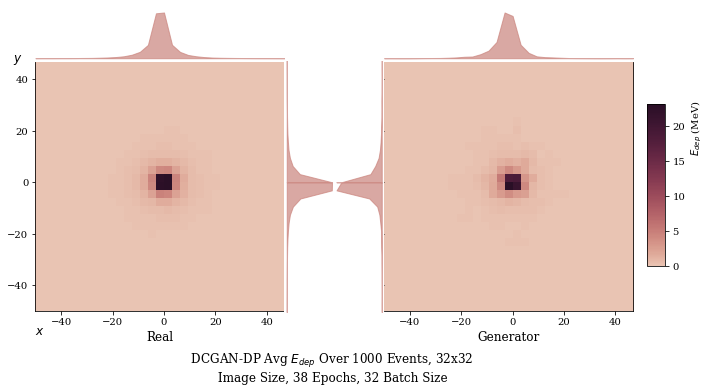

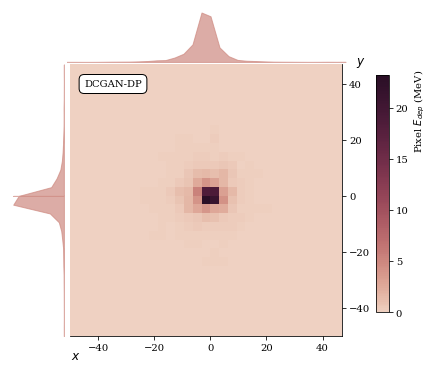

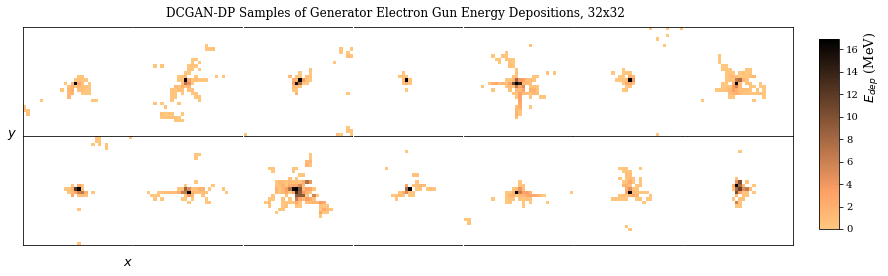

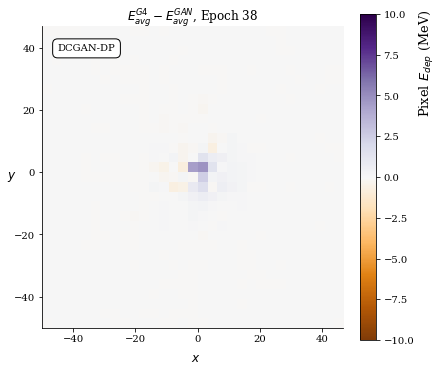

[38/50][0/938] Loss_D: 0.9781 Loss_G: 1.7792 D(x): 0.8982 D(G(z)): 0.5736 / 0.1747
[38/50][100/938] Loss_D: 1.2176 Loss_G: 0.7305 D(x): 0.6276 D(G(z)): 0.5149 / 0.4877
[38/50][200/938] Loss_D: 1.6129 Loss_G: 1.0740 D(x): 0.3990 D(G(z)): 0.4790 / 0.3525
[38/50][300/938] Loss_D: 0.7704 Loss_G: 1.1748 D(x): 0.7018 D(G(z)): 0.3326 / 0.3167
[38/50][400/938] Loss_D: 1.0304 Loss_G: 0.9373 D(x): 0.7488 D(G(z)): 0.5142 / 0.3990
[38/50][500/938] Loss_D: 1.0389 Loss_G: 1.2219 D(x): 0.5422 D(G(z)): 0.3274 / 0.3077
[38/50][600/938] Loss_D: 0.8663 Loss_G: 1.5178 D(x): 0.8011 D(G(z)): 0.4697 / 0.2218
[38/50][700/938] Loss_D: 1.0066 Loss_G: 1.0946 D(x): 0.5594 D(G(z)): 0.3327 / 0.3450
[38/50][800/938] Loss_D: 1.2505 Loss_G: 1.3353 D(x): 0.8107 D(G(z)): 0.6345 / 0.2728
[38/50][900/938] Loss_D: 0.6986 Loss_G: 1.1801 D(x): 0.7906 D(G(z)): 0.3634 / 0.3155
(32, 32)


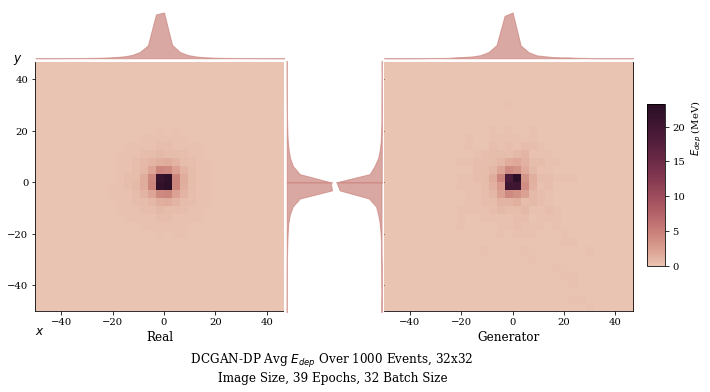

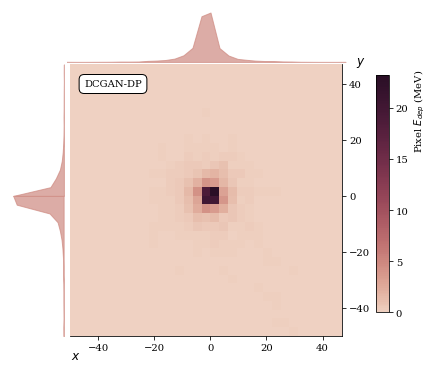

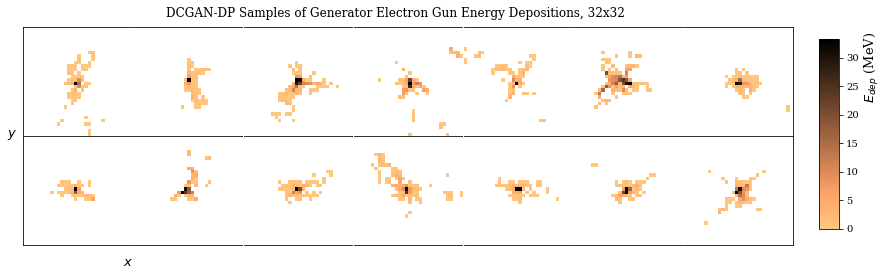

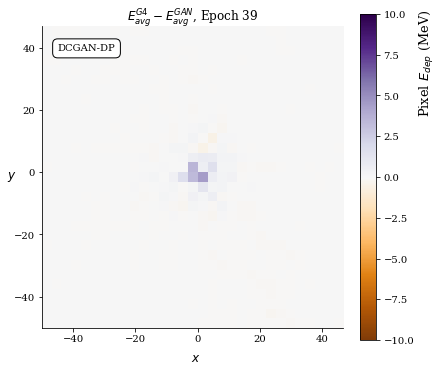

[39/50][0/938] Loss_D: 0.8029 Loss_G: 0.9676 D(x): 0.7513 D(G(z)): 0.3943 / 0.3881
[39/50][100/938] Loss_D: 1.3624 Loss_G: 0.9821 D(x): 0.7494 D(G(z)): 0.6464 / 0.3871
[39/50][200/938] Loss_D: 1.1290 Loss_G: 1.1459 D(x): 0.5724 D(G(z)): 0.4127 / 0.3239
[39/50][300/938] Loss_D: 0.9189 Loss_G: 1.2102 D(x): 0.8451 D(G(z)): 0.5201 / 0.3116
[39/50][400/938] Loss_D: 0.8729 Loss_G: 1.0875 D(x): 0.7047 D(G(z)): 0.3939 / 0.3442
[39/50][500/938] Loss_D: 1.0680 Loss_G: 1.0943 D(x): 0.5500 D(G(z)): 0.3617 / 0.3435
[39/50][600/938] Loss_D: 0.8721 Loss_G: 1.1609 D(x): 0.6021 D(G(z)): 0.2930 / 0.3227
[39/50][700/938] Loss_D: 0.7115 Loss_G: 1.2245 D(x): 0.7244 D(G(z)): 0.3131 / 0.3029
[39/50][800/938] Loss_D: 1.0301 Loss_G: 1.6019 D(x): 0.8481 D(G(z)): 0.5689 / 0.2113
[39/50][900/938] Loss_D: 0.7337 Loss_G: 1.0230 D(x): 0.7080 D(G(z)): 0.3139 / 0.3633
(32, 32)


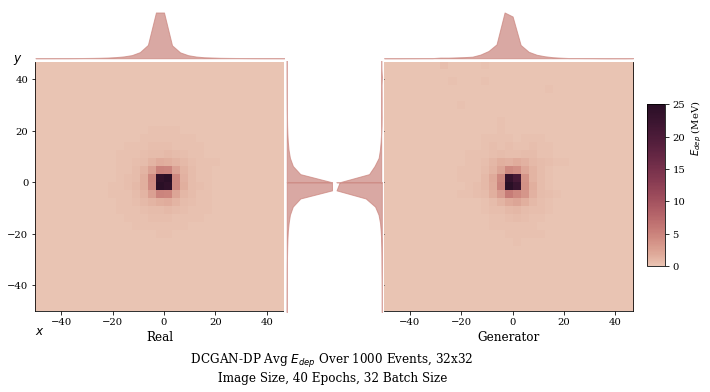

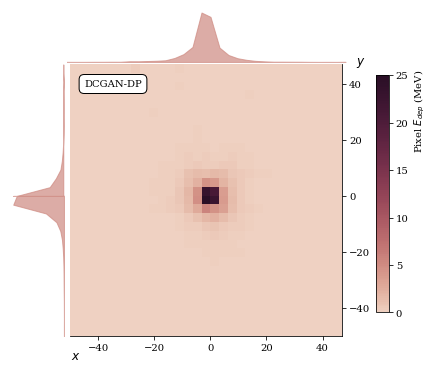

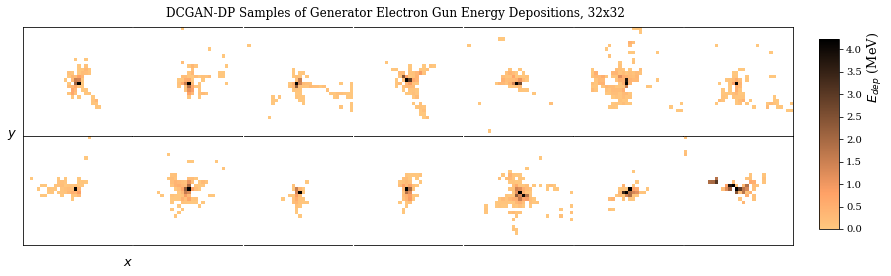

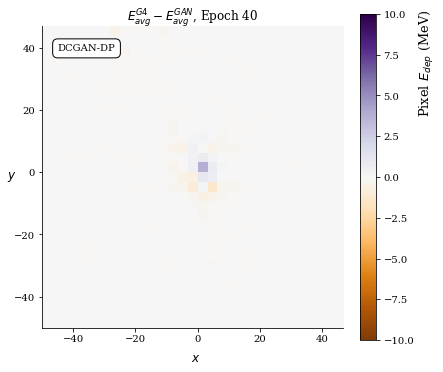

[40/50][0/938] Loss_D: 0.7007 Loss_G: 1.0417 D(x): 0.8084 D(G(z)): 0.3749 / 0.3613
[40/50][100/938] Loss_D: 1.4589 Loss_G: 0.6467 D(x): 0.6905 D(G(z)): 0.6539 / 0.5282
[40/50][200/938] Loss_D: 1.0623 Loss_G: 0.8324 D(x): 0.5560 D(G(z)): 0.3598 / 0.4431
[40/50][300/938] Loss_D: 0.7216 Loss_G: 1.0282 D(x): 0.6934 D(G(z)): 0.2909 / 0.3648
[40/50][400/938] Loss_D: 0.8404 Loss_G: 1.2722 D(x): 0.7779 D(G(z)): 0.4364 / 0.2858
[40/50][500/938] Loss_D: 0.6919 Loss_G: 1.4348 D(x): 0.5999 D(G(z)): 0.1556 / 0.2476
[40/50][600/938] Loss_D: 1.1250 Loss_G: 1.3570 D(x): 0.5290 D(G(z)): 0.3679 / 0.2689
[40/50][700/938] Loss_D: 0.9161 Loss_G: 1.4557 D(x): 0.8255 D(G(z)): 0.5063 / 0.2422
[40/50][800/938] Loss_D: 0.8563 Loss_G: 1.0944 D(x): 0.7438 D(G(z)): 0.4223 / 0.3393
[40/50][900/938] Loss_D: 0.8628 Loss_G: 1.1578 D(x): 0.8274 D(G(z)): 0.4830 / 0.3203
(32, 32)


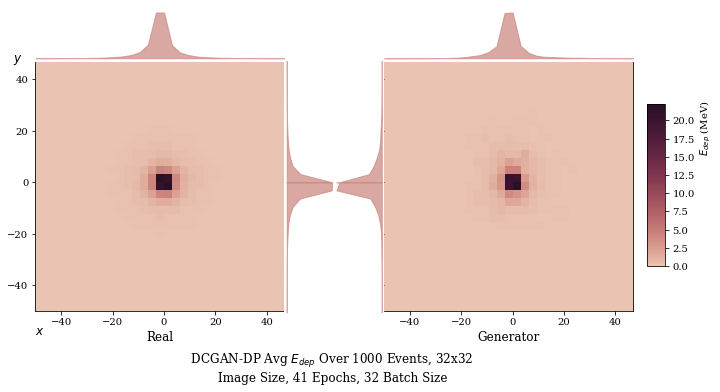

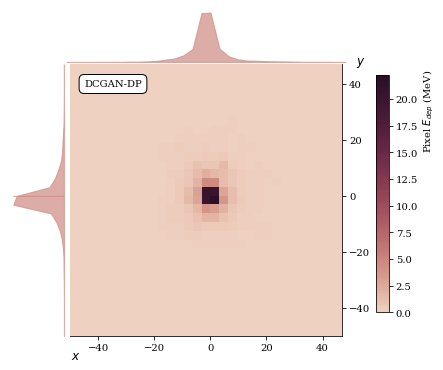

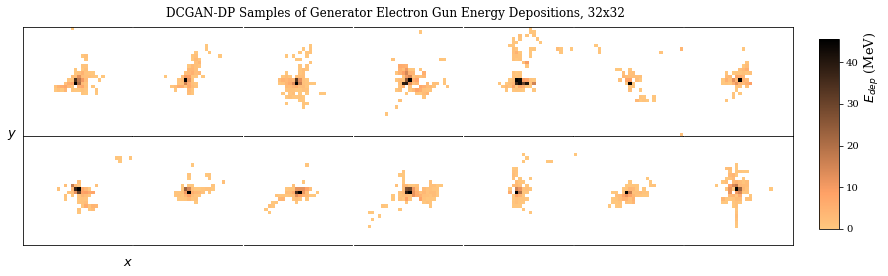

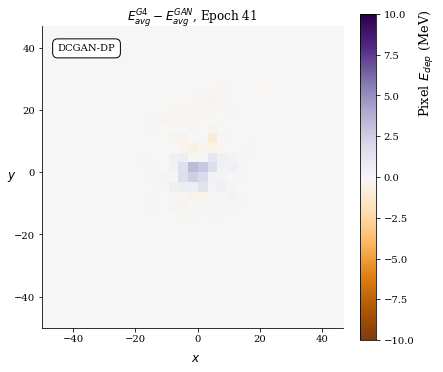

[41/50][0/938] Loss_D: 0.6703 Loss_G: 1.5973 D(x): 0.9061 D(G(z)): 0.4255 / 0.2105
[41/50][100/938] Loss_D: 1.0323 Loss_G: 0.7488 D(x): 0.5244 D(G(z)): 0.3094 / 0.4753
[41/50][200/938] Loss_D: 0.7613 Loss_G: 0.8159 D(x): 0.7648 D(G(z)): 0.3832 / 0.4483
[41/50][300/938] Loss_D: 0.6714 Loss_G: 1.3300 D(x): 0.6980 D(G(z)): 0.2539 / 0.2789
[41/50][400/938] Loss_D: 1.5996 Loss_G: 1.3588 D(x): 0.8067 D(G(z)): 0.7392 / 0.2636
[41/50][500/938] Loss_D: 1.0160 Loss_G: 1.0994 D(x): 0.7942 D(G(z)): 0.5254 / 0.3553
[41/50][600/938] Loss_D: 0.9391 Loss_G: 1.7243 D(x): 0.8245 D(G(z)): 0.5105 / 0.1873
[41/50][700/938] Loss_D: 1.2424 Loss_G: 1.1267 D(x): 0.7612 D(G(z)): 0.6112 / 0.3296
[41/50][800/938] Loss_D: 0.8301 Loss_G: 1.3854 D(x): 0.8397 D(G(z)): 0.4708 / 0.2607
[41/50][900/938] Loss_D: 1.0129 Loss_G: 1.4372 D(x): 0.8398 D(G(z)): 0.5525 / 0.2530
(32, 32)


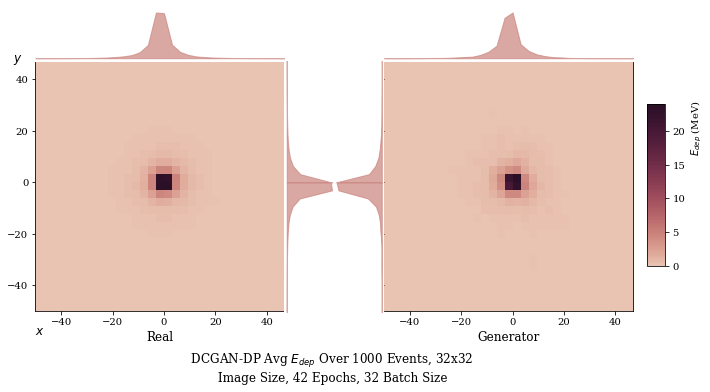

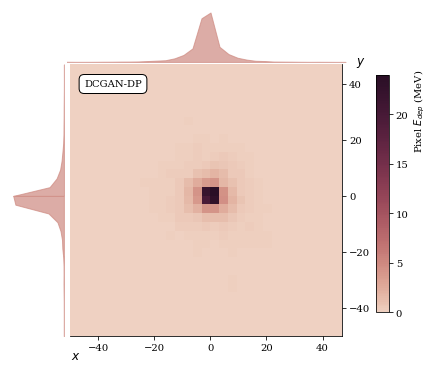

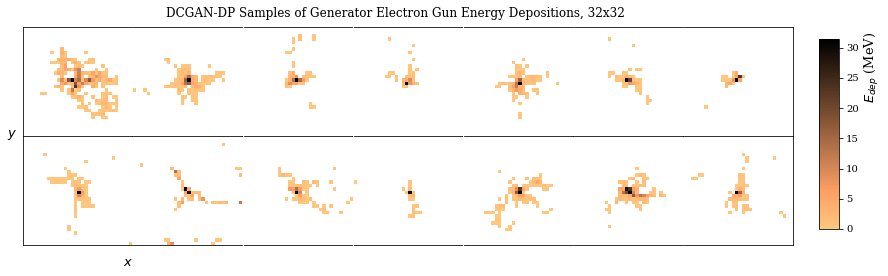

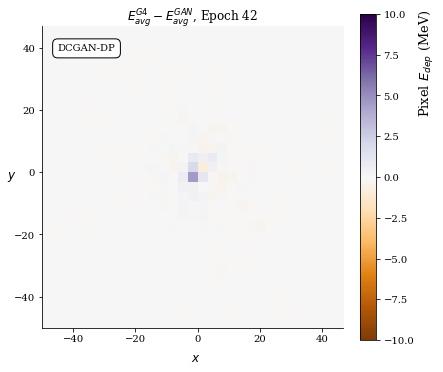

[42/50][0/938] Loss_D: 0.9544 Loss_G: 1.0436 D(x): 0.7472 D(G(z)): 0.4733 / 0.3585
[42/50][100/938] Loss_D: 0.9476 Loss_G: 0.9005 D(x): 0.6361 D(G(z)): 0.3793 / 0.4132
[42/50][200/938] Loss_D: 0.6727 Loss_G: 1.0141 D(x): 0.6782 D(G(z)): 0.2398 / 0.3682
[42/50][300/938] Loss_D: 0.9715 Loss_G: 1.6958 D(x): 0.8423 D(G(z)): 0.5401 / 0.1937
[42/50][400/938] Loss_D: 0.8373 Loss_G: 1.1893 D(x): 0.7494 D(G(z)): 0.4107 / 0.3161
[42/50][500/938] Loss_D: 0.7904 Loss_G: 1.0856 D(x): 0.6848 D(G(z)): 0.3303 / 0.3439
[42/50][600/938] Loss_D: 0.7214 Loss_G: 1.3403 D(x): 0.7661 D(G(z)): 0.3572 / 0.2683
[42/50][700/938] Loss_D: 0.9960 Loss_G: 1.4860 D(x): 0.5066 D(G(z)): 0.2535 / 0.2361
[42/50][800/938] Loss_D: 0.9876 Loss_G: 1.7603 D(x): 0.8962 D(G(z)): 0.5643 / 0.1856
[42/50][900/938] Loss_D: 0.9193 Loss_G: 1.0013 D(x): 0.7585 D(G(z)): 0.4639 / 0.3776
(32, 32)


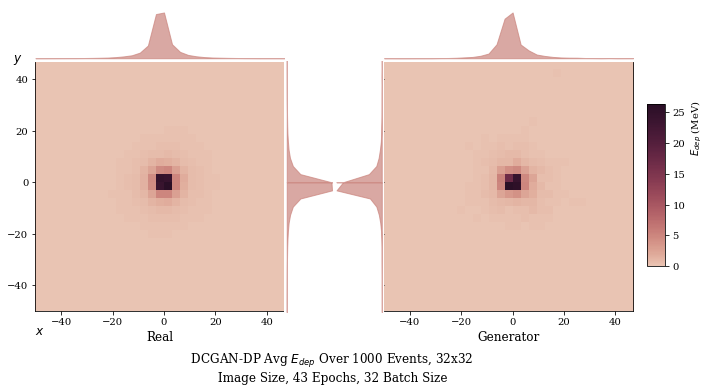

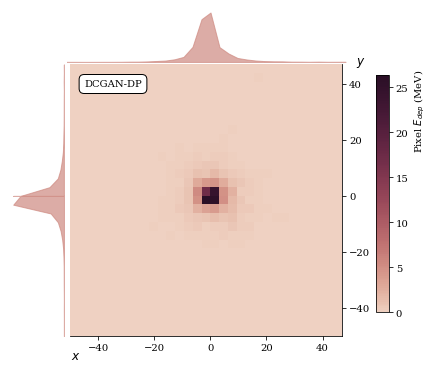

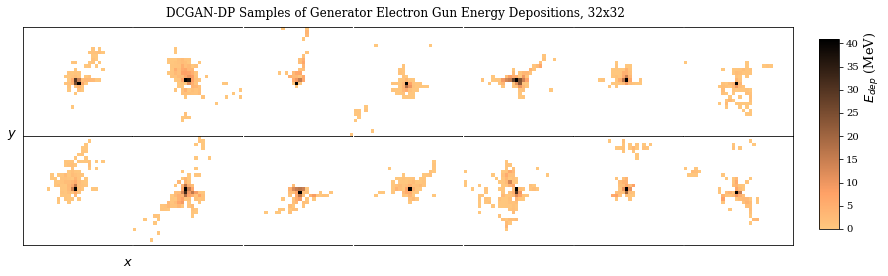

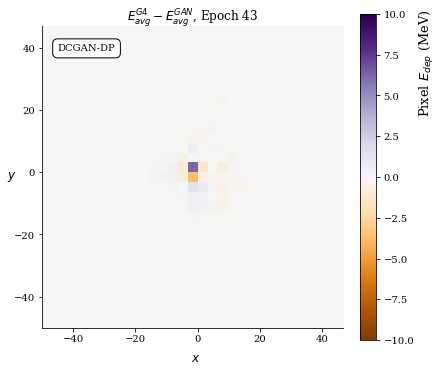

[43/50][0/938] Loss_D: 0.9478 Loss_G: 1.5758 D(x): 0.8646 D(G(z)): 0.5398 / 0.2171
[43/50][100/938] Loss_D: 1.1340 Loss_G: 1.2698 D(x): 0.8367 D(G(z)): 0.6098 / 0.2870
[43/50][200/938] Loss_D: 0.8406 Loss_G: 1.2895 D(x): 0.5273 D(G(z)): 0.1709 / 0.2840
[43/50][300/938] Loss_D: 0.6747 Loss_G: 1.4606 D(x): 0.8543 D(G(z)): 0.3982 / 0.2399
[43/50][400/938] Loss_D: 1.0406 Loss_G: 0.8905 D(x): 0.7308 D(G(z)): 0.5052 / 0.4161
[43/50][500/938] Loss_D: 1.3029 Loss_G: 0.9158 D(x): 0.7234 D(G(z)): 0.6130 / 0.4099
[43/50][600/938] Loss_D: 0.7396 Loss_G: 0.9183 D(x): 0.7305 D(G(z)): 0.3398 / 0.4054
[43/50][700/938] Loss_D: 1.0269 Loss_G: 0.9746 D(x): 0.6425 D(G(z)): 0.4319 / 0.3811
[43/50][800/938] Loss_D: 0.7547 Loss_G: 1.2421 D(x): 0.8492 D(G(z)): 0.4357 / 0.2989
[43/50][900/938] Loss_D: 0.7805 Loss_G: 1.2580 D(x): 0.7943 D(G(z)): 0.4091 / 0.3030
(32, 32)


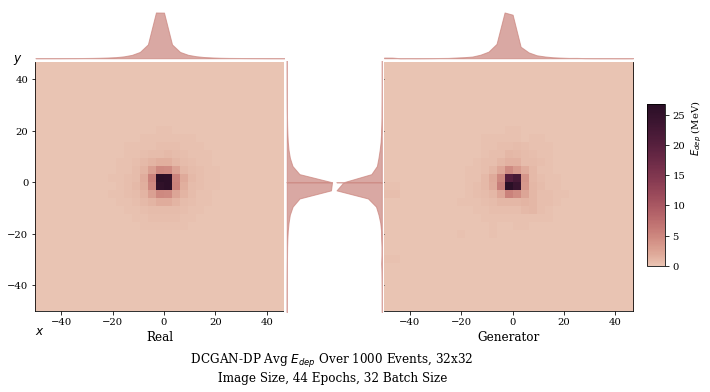

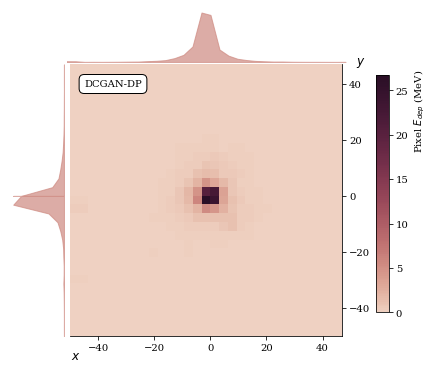

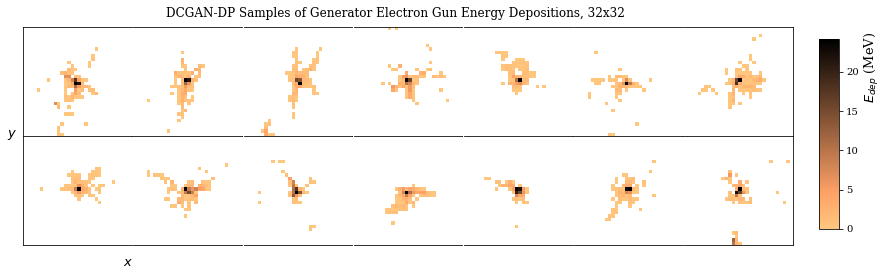

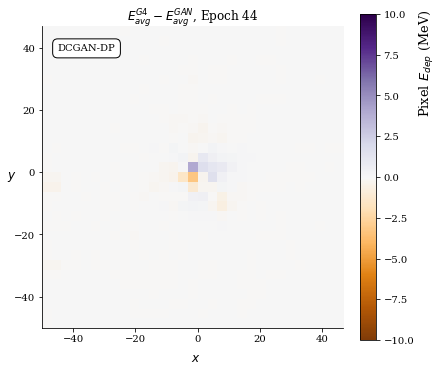

[44/50][0/938] Loss_D: 1.1060 Loss_G: 1.0985 D(x): 0.7600 D(G(z)): 0.5507 / 0.3427
[44/50][100/938] Loss_D: 0.9692 Loss_G: 0.9045 D(x): 0.5614 D(G(z)): 0.3059 / 0.4149
[44/50][200/938] Loss_D: 0.9969 Loss_G: 0.8012 D(x): 0.6835 D(G(z)): 0.4435 / 0.4600
[44/50][300/938] Loss_D: 0.7807 Loss_G: 1.8797 D(x): 0.8827 D(G(z)): 0.4732 / 0.1588
[44/50][400/938] Loss_D: 0.9567 Loss_G: 1.4538 D(x): 0.6910 D(G(z)): 0.4355 / 0.2409
[44/50][500/938] Loss_D: 0.6787 Loss_G: 1.2045 D(x): 0.7932 D(G(z)): 0.3520 / 0.3121
[44/50][600/938] Loss_D: 0.8468 Loss_G: 1.3574 D(x): 0.6217 D(G(z)): 0.2980 / 0.2650
[44/50][700/938] Loss_D: 0.9723 Loss_G: 1.2157 D(x): 0.7335 D(G(z)): 0.4758 / 0.3064
[44/50][800/938] Loss_D: 1.4284 Loss_G: 1.4545 D(x): 0.9132 D(G(z)): 0.7257 / 0.2429
[44/50][900/938] Loss_D: 0.7045 Loss_G: 0.8909 D(x): 0.7159 D(G(z)): 0.3038 / 0.4148
(32, 32)


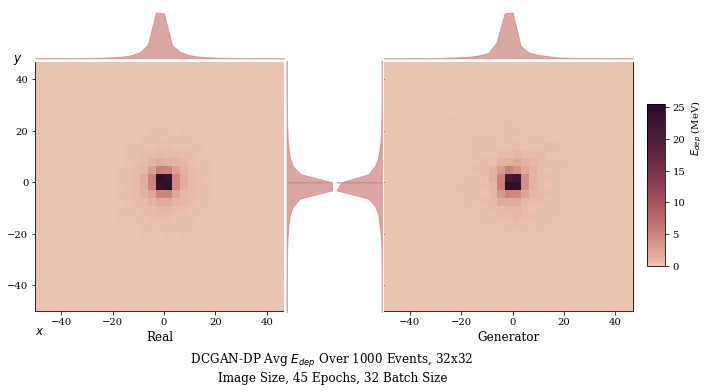

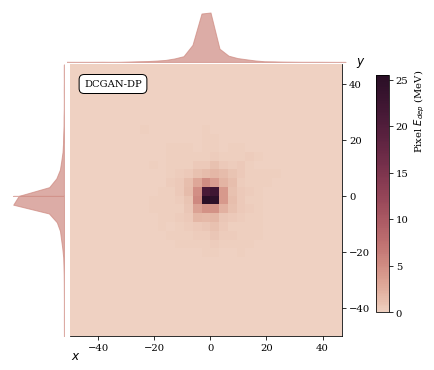

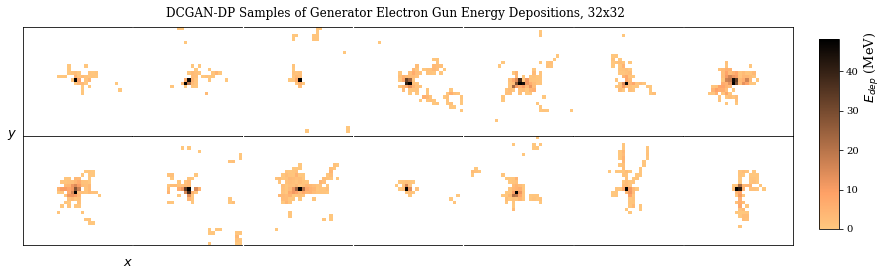

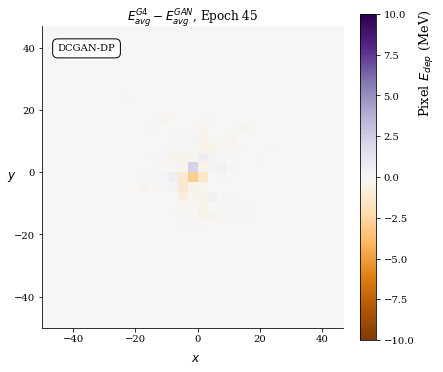

[45/50][0/938] Loss_D: 1.1150 Loss_G: 1.1230 D(x): 0.7964 D(G(z)): 0.5805 / 0.3323
[45/50][100/938] Loss_D: 1.1118 Loss_G: 0.8448 D(x): 0.5420 D(G(z)): 0.3743 / 0.4402
[45/50][200/938] Loss_D: 0.9742 Loss_G: 0.7884 D(x): 0.7902 D(G(z)): 0.5152 / 0.4592
[45/50][300/938] Loss_D: 0.9549 Loss_G: 1.5599 D(x): 0.8640 D(G(z)): 0.5506 / 0.2158
[45/50][400/938] Loss_D: 1.2814 Loss_G: 1.4251 D(x): 0.8928 D(G(z)): 0.6820 / 0.2452
[45/50][500/938] Loss_D: 0.9763 Loss_G: 1.4515 D(x): 0.5054 D(G(z)): 0.2369 / 0.2443
[45/50][600/938] Loss_D: 0.9087 Loss_G: 1.5972 D(x): 0.8407 D(G(z)): 0.5029 / 0.2125
[45/50][700/938] Loss_D: 0.8012 Loss_G: 1.1674 D(x): 0.6451 D(G(z)): 0.2906 / 0.3210
[45/50][800/938] Loss_D: 1.2937 Loss_G: 0.7693 D(x): 0.6517 D(G(z)): 0.5678 / 0.4693
[45/50][900/938] Loss_D: 1.1243 Loss_G: 0.9047 D(x): 0.6015 D(G(z)): 0.4369 / 0.4156
(32, 32)


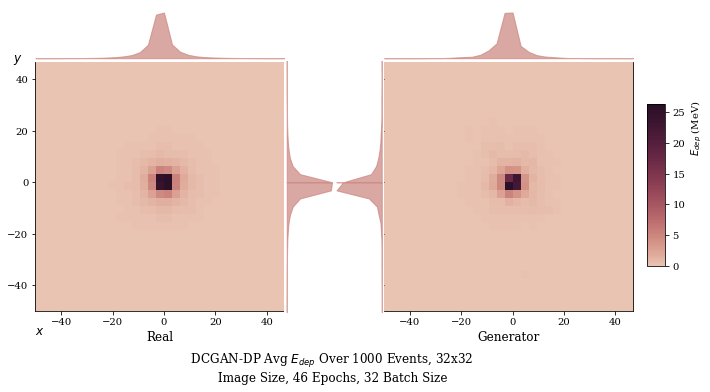

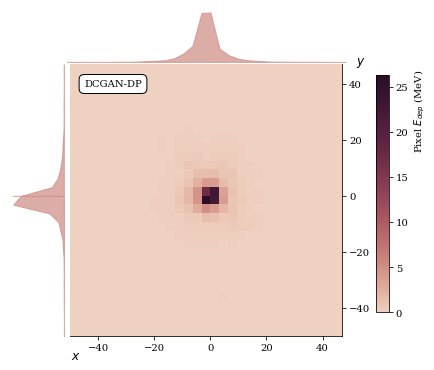

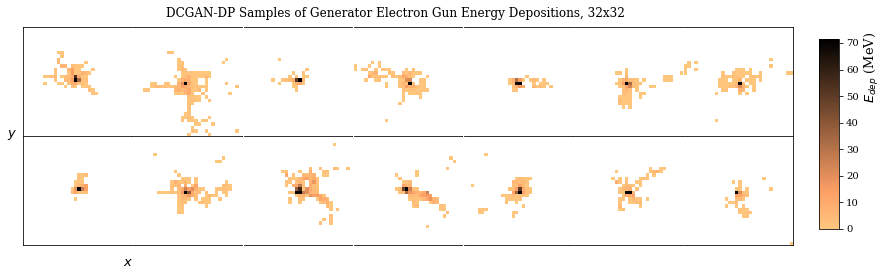

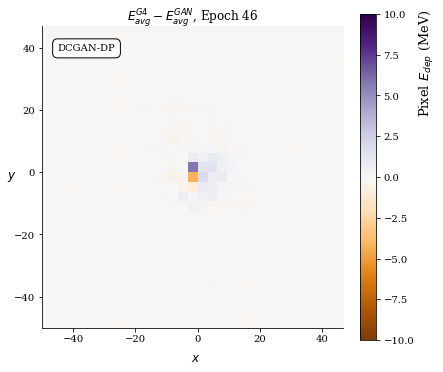

[46/50][0/938] Loss_D: 0.5999 Loss_G: 1.2838 D(x): 0.8206 D(G(z)): 0.3237 / 0.2854
[46/50][100/938] Loss_D: 1.1907 Loss_G: 1.2612 D(x): 0.8608 D(G(z)): 0.6406 / 0.2870
[46/50][200/938] Loss_D: 0.8588 Loss_G: 0.8828 D(x): 0.7433 D(G(z)): 0.4236 / 0.4198
[46/50][300/938] Loss_D: 1.5848 Loss_G: 1.0802 D(x): 0.8546 D(G(z)): 0.7492 / 0.3489
[46/50][400/938] Loss_D: 0.8545 Loss_G: 1.1021 D(x): 0.6975 D(G(z)): 0.3760 / 0.3484
[46/50][500/938] Loss_D: 0.7294 Loss_G: 1.2622 D(x): 0.7397 D(G(z)): 0.3372 / 0.2983
[46/50][600/938] Loss_D: 0.7566 Loss_G: 1.1782 D(x): 0.7565 D(G(z)): 0.3679 / 0.3201
[46/50][700/938] Loss_D: 0.8346 Loss_G: 1.1680 D(x): 0.6560 D(G(z)): 0.3281 / 0.3212
[46/50][800/938] Loss_D: 1.1029 Loss_G: 1.1803 D(x): 0.7857 D(G(z)): 0.5667 / 0.3144
[46/50][900/938] Loss_D: 0.9907 Loss_G: 1.0855 D(x): 0.8504 D(G(z)): 0.5514 / 0.3471
(32, 32)


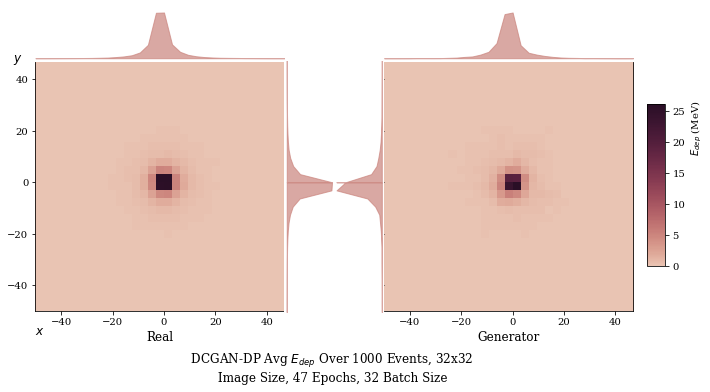

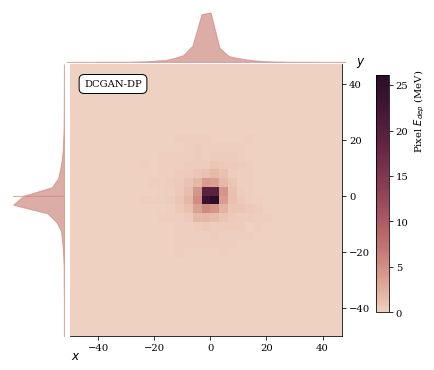

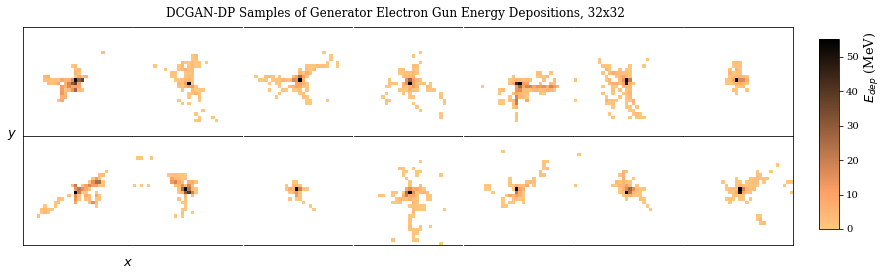

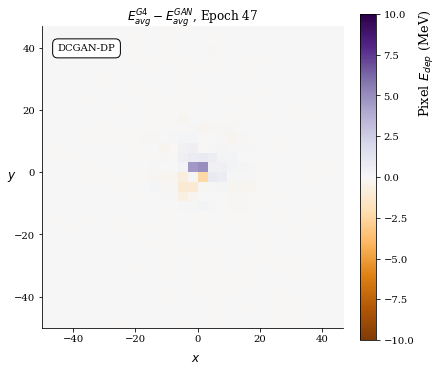

[47/50][0/938] Loss_D: 0.7913 Loss_G: 1.3448 D(x): 0.8519 D(G(z)): 0.4563 / 0.2698
[47/50][100/938] Loss_D: 0.8151 Loss_G: 1.2274 D(x): 0.5927 D(G(z)): 0.2431 / 0.3108
[47/50][200/938] Loss_D: 0.8375 Loss_G: 0.7762 D(x): 0.6334 D(G(z)): 0.3057 / 0.4672
[47/50][300/938] Loss_D: 0.8105 Loss_G: 1.3983 D(x): 0.5701 D(G(z)): 0.2042 / 0.2636
[47/50][400/938] Loss_D: 0.9028 Loss_G: 1.1947 D(x): 0.7861 D(G(z)): 0.4750 / 0.3109
[47/50][500/938] Loss_D: 0.9237 Loss_G: 0.9840 D(x): 0.7591 D(G(z)): 0.4673 / 0.3825
[47/50][600/938] Loss_D: 1.0637 Loss_G: 0.9686 D(x): 0.8125 D(G(z)): 0.5607 / 0.3901
[47/50][700/938] Loss_D: 0.8816 Loss_G: 1.3016 D(x): 0.7611 D(G(z)): 0.4409 / 0.2825
[47/50][800/938] Loss_D: 1.1832 Loss_G: 0.9806 D(x): 0.8220 D(G(z)): 0.6148 / 0.3881
[47/50][900/938] Loss_D: 0.5083 Loss_G: 1.1229 D(x): 0.7763 D(G(z)): 0.2193 / 0.3397
(32, 32)


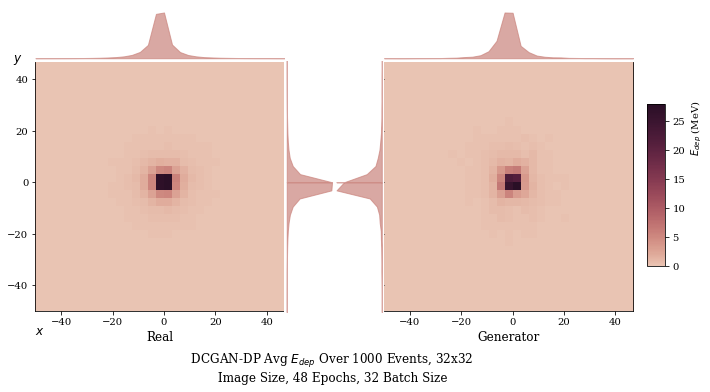

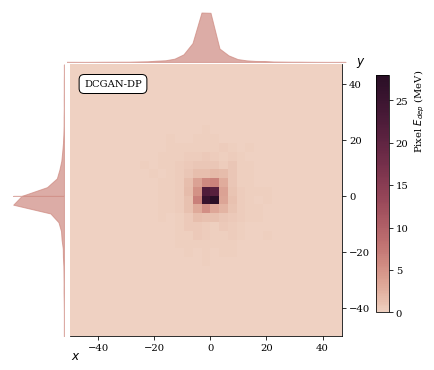

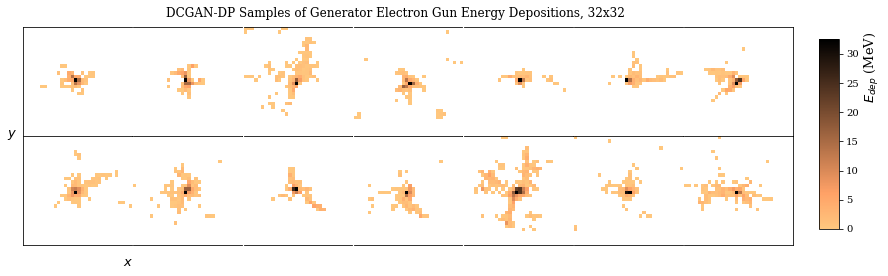

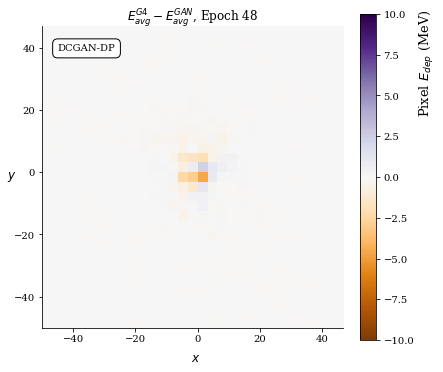

[48/50][0/938] Loss_D: 0.5589 Loss_G: 1.4492 D(x): 0.8338 D(G(z)): 0.3052 / 0.2427
[48/50][100/938] Loss_D: 0.9871 Loss_G: 0.5761 D(x): 0.5636 D(G(z)): 0.3234 / 0.5675
[48/50][200/938] Loss_D: 0.9597 Loss_G: 1.0057 D(x): 0.6066 D(G(z)): 0.3525 / 0.3753
[48/50][300/938] Loss_D: 0.6590 Loss_G: 1.8446 D(x): 0.8354 D(G(z)): 0.3721 / 0.1645
[48/50][400/938] Loss_D: 1.1342 Loss_G: 1.5986 D(x): 0.8697 D(G(z)): 0.6206 / 0.2083
[48/50][500/938] Loss_D: 0.7410 Loss_G: 0.6943 D(x): 0.7191 D(G(z)): 0.3279 / 0.5074
[48/50][600/938] Loss_D: 1.3123 Loss_G: 2.0130 D(x): 0.8835 D(G(z)): 0.6838 / 0.1390
[48/50][700/938] Loss_D: 1.1873 Loss_G: 1.3189 D(x): 0.5254 D(G(z)): 0.3983 / 0.2849
[48/50][800/938] Loss_D: 0.9450 Loss_G: 0.8782 D(x): 0.7075 D(G(z)): 0.4391 / 0.4289
[48/50][900/938] Loss_D: 0.7227 Loss_G: 0.9140 D(x): 0.6095 D(G(z)): 0.1972 / 0.4080
(32, 32)


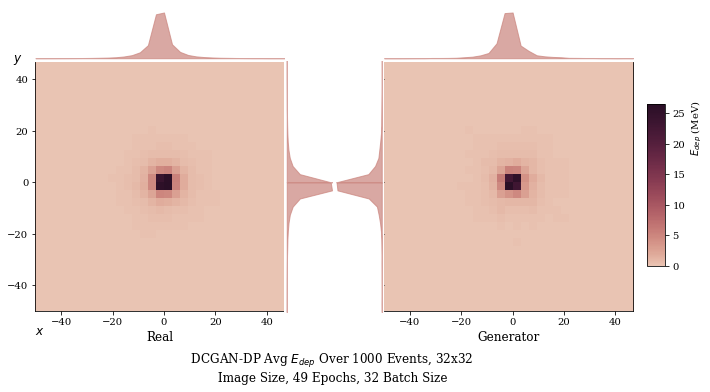

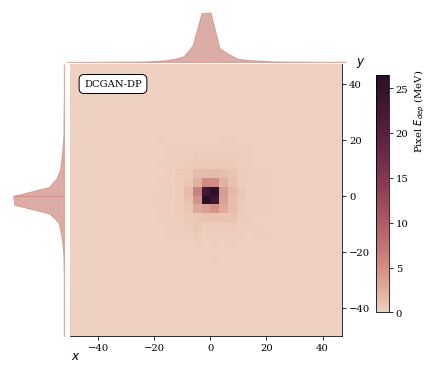

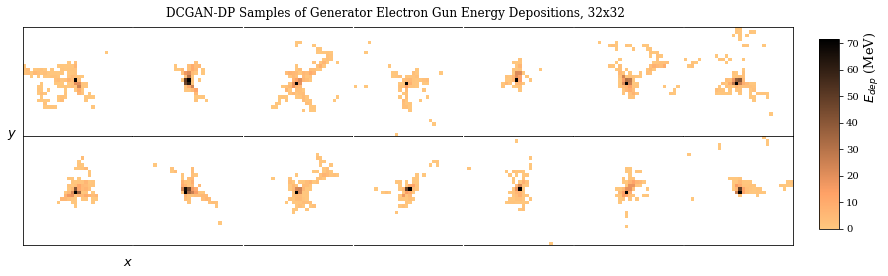

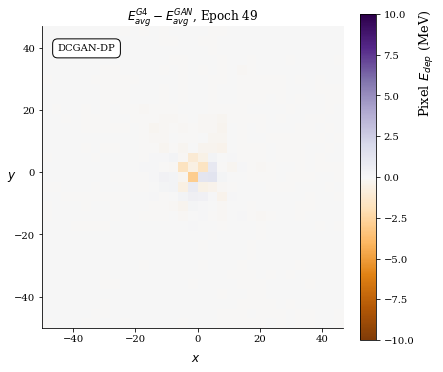

[49/50][0/938] Loss_D: 0.6691 Loss_G: 1.3926 D(x): 0.8762 D(G(z)): 0.4072 / 0.2559
[49/50][100/938] Loss_D: 1.0941 Loss_G: 0.8170 D(x): 0.5953 D(G(z)): 0.4273 / 0.4478
[49/50][200/938] Loss_D: 1.0316 Loss_G: 0.9641 D(x): 0.7251 D(G(z)): 0.4951 / 0.3945
[49/50][300/938] Loss_D: 0.7950 Loss_G: 1.4207 D(x): 0.7589 D(G(z)): 0.3965 / 0.2489
[49/50][400/938] Loss_D: 1.0707 Loss_G: 1.2897 D(x): 0.7881 D(G(z)): 0.5552 / 0.2825
[49/50][500/938] Loss_D: 0.8093 Loss_G: 1.1180 D(x): 0.7323 D(G(z)): 0.3865 / 0.3324
[49/50][600/938] Loss_D: 1.0492 Loss_G: 1.1285 D(x): 0.5737 D(G(z)): 0.3770 / 0.3333
[49/50][700/938] Loss_D: 0.6004 Loss_G: 1.1720 D(x): 0.7449 D(G(z)): 0.2567 / 0.3192
[49/50][800/938] Loss_D: 1.2142 Loss_G: 1.0339 D(x): 0.7920 D(G(z)): 0.6135 / 0.3636
[49/50][900/938] Loss_D: 0.5827 Loss_G: 1.3548 D(x): 0.8555 D(G(z)): 0.3396 / 0.2681
(32, 32)


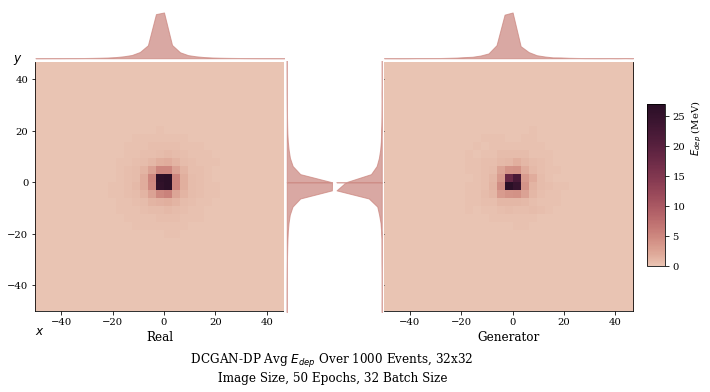

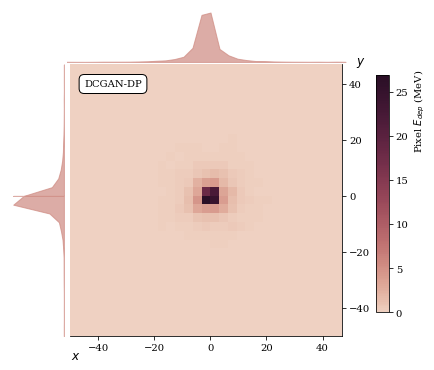

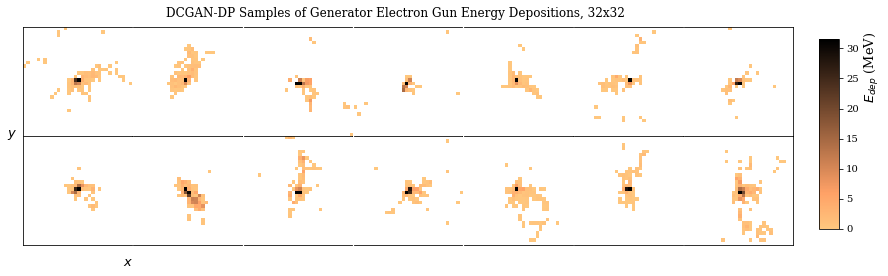

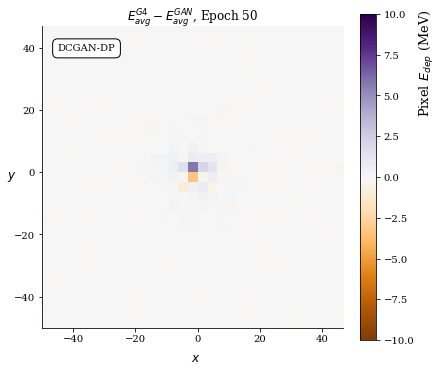

[50/50][0/938] Loss_D: 0.7698 Loss_G: 1.1669 D(x): 0.8450 D(G(z)): 0.4427 / 0.3212
[50/50][100/938] Loss_D: 1.1750 Loss_G: 0.8188 D(x): 0.6359 D(G(z)): 0.5044 / 0.4494
[50/50][200/938] Loss_D: 0.8374 Loss_G: 1.1140 D(x): 0.5351 D(G(z)): 0.1720 / 0.3404
[50/50][300/938] Loss_D: 0.8727 Loss_G: 1.2443 D(x): 0.6080 D(G(z)): 0.2998 / 0.2973
[50/50][400/938] Loss_D: 1.1426 Loss_G: 1.1399 D(x): 0.8133 D(G(z)): 0.5935 / 0.3336
[50/50][500/938] Loss_D: 1.1493 Loss_G: 1.0594 D(x): 0.5791 D(G(z)): 0.4396 / 0.3552
[50/50][600/938] Loss_D: 0.8415 Loss_G: 1.1532 D(x): 0.8057 D(G(z)): 0.4571 / 0.3232
[50/50][700/938] Loss_D: 0.6067 Loss_G: 1.3857 D(x): 0.8047 D(G(z)): 0.3158 / 0.2585
[50/50][800/938] Loss_D: 1.0126 Loss_G: 1.3463 D(x): 0.4742 D(G(z)): 0.2181 / 0.2677
[50/50][900/938] Loss_D: 0.6985 Loss_G: 0.8735 D(x): 0.7060 D(G(z)): 0.2862 / 0.4258
(32, 32)


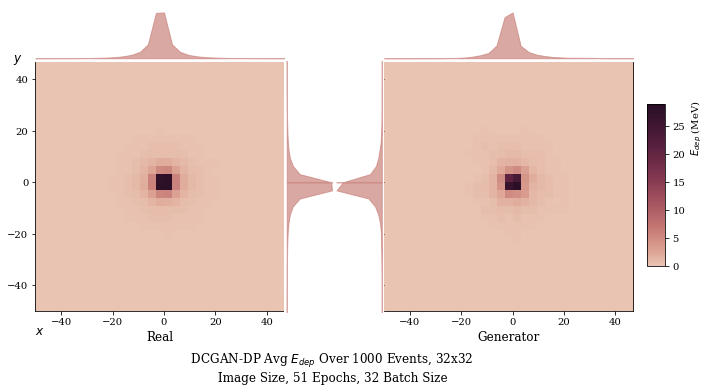

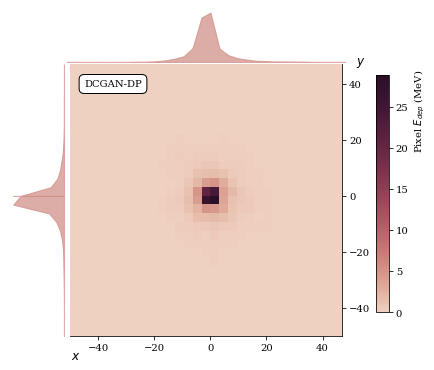

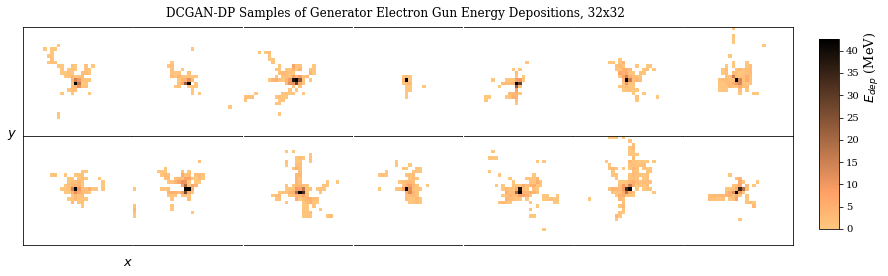

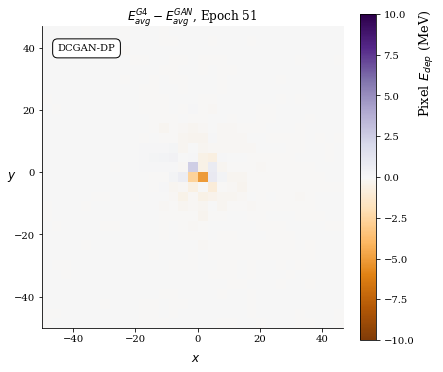

[51/50][0/938] Loss_D: 0.7762 Loss_G: 1.6044 D(x): 0.9379 D(G(z)): 0.4984 / 0.2104
[51/50][100/938] Loss_D: 0.8655 Loss_G: 1.4287 D(x): 0.5460 D(G(z)): 0.2183 / 0.2458
[51/50][200/938] Loss_D: 0.6349 Loss_G: 0.7353 D(x): 0.7154 D(G(z)): 0.2518 / 0.4942
[51/50][300/938] Loss_D: 0.6171 Loss_G: 1.2339 D(x): 0.7339 D(G(z)): 0.2569 / 0.2978
[51/50][400/938] Loss_D: 0.8754 Loss_G: 1.1780 D(x): 0.8271 D(G(z)): 0.4905 / 0.3134
[51/50][500/938] Loss_D: 0.7739 Loss_G: 1.0762 D(x): 0.7939 D(G(z)): 0.4113 / 0.3486
[51/50][600/938] Loss_D: 0.8072 Loss_G: 0.8410 D(x): 0.7257 D(G(z)): 0.3722 / 0.4441
[51/50][700/938] Loss_D: 1.1731 Loss_G: 1.0929 D(x): 0.8294 D(G(z)): 0.6100 / 0.3470
[51/50][800/938] Loss_D: 1.4500 Loss_G: 0.9981 D(x): 0.8953 D(G(z)): 0.7298 / 0.3781
[51/50][900/938] Loss_D: 0.9376 Loss_G: 0.8565 D(x): 0.7933 D(G(z)): 0.4939 / 0.4357
(32, 32)


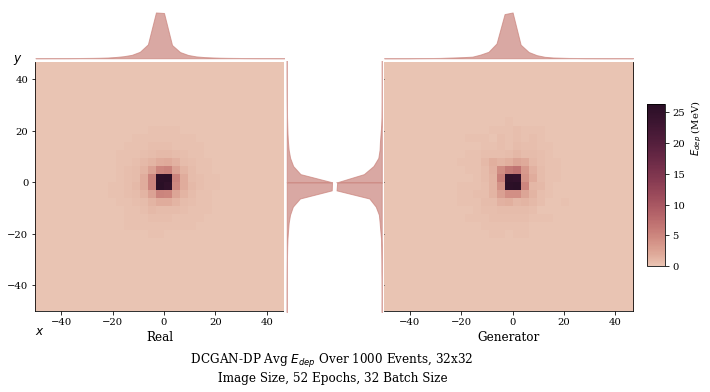

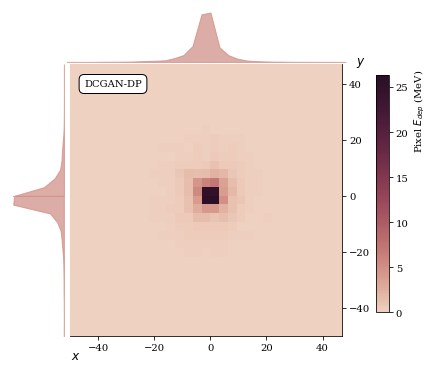

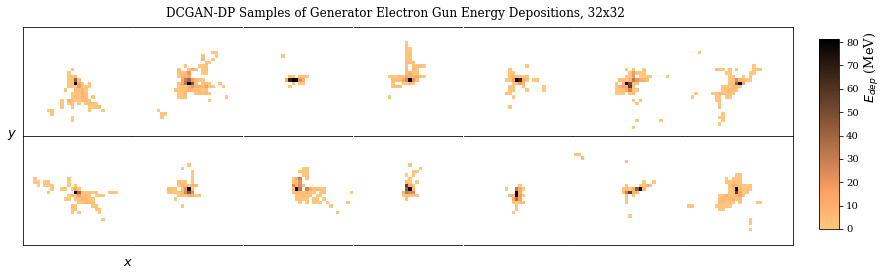

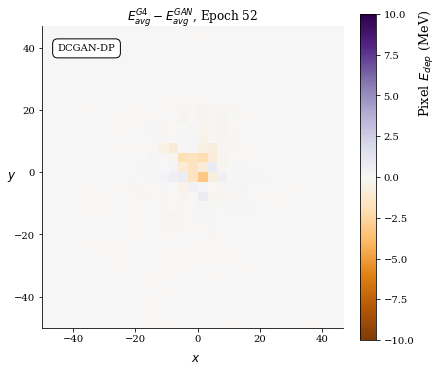

[52/50][0/938] Loss_D: 0.8187 Loss_G: 2.2628 D(x): 0.9093 D(G(z)): 0.5083 / 0.1082
[52/50][100/938] Loss_D: 1.2096 Loss_G: 0.5285 D(x): 0.6583 D(G(z)): 0.5404 / 0.5921
[52/50][200/938] Loss_D: 0.6353 Loss_G: 0.9362 D(x): 0.7178 D(G(z)): 0.2530 / 0.4054
[52/50][300/938] Loss_D: 1.3233 Loss_G: 1.5658 D(x): 0.9036 D(G(z)): 0.6995 / 0.2144
[52/50][400/938] Loss_D: 0.8313 Loss_G: 1.6137 D(x): 0.8926 D(G(z)): 0.5034 / 0.2085
[52/50][500/938] Loss_D: 0.7901 Loss_G: 1.0723 D(x): 0.6203 D(G(z)): 0.2583 / 0.3484
[52/50][600/938] Loss_D: 0.7151 Loss_G: 1.0465 D(x): 0.6868 D(G(z)): 0.2774 / 0.3636
[52/50][700/938] Loss_D: 0.9431 Loss_G: 1.2269 D(x): 0.8569 D(G(z)): 0.5374 / 0.3020
[52/50][800/938] Loss_D: 1.6652 Loss_G: 1.6383 D(x): 0.9566 D(G(z)): 0.7917 / 0.2100
[52/50][900/938] Loss_D: 0.7079 Loss_G: 1.0492 D(x): 0.6075 D(G(z)): 0.1709 / 0.3590
(32, 32)


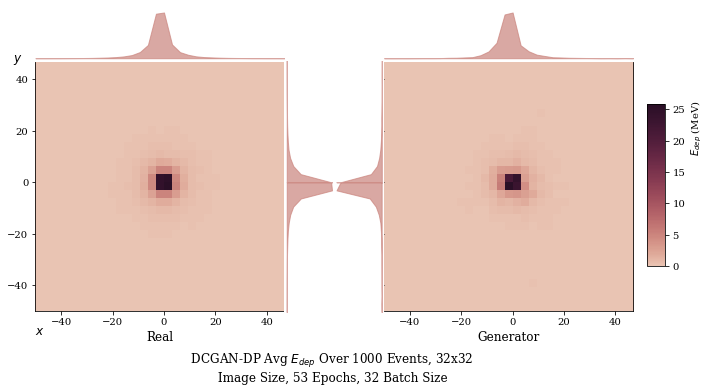

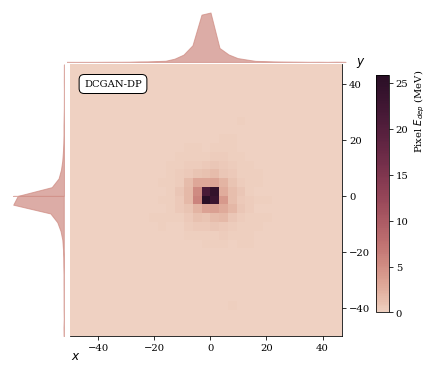

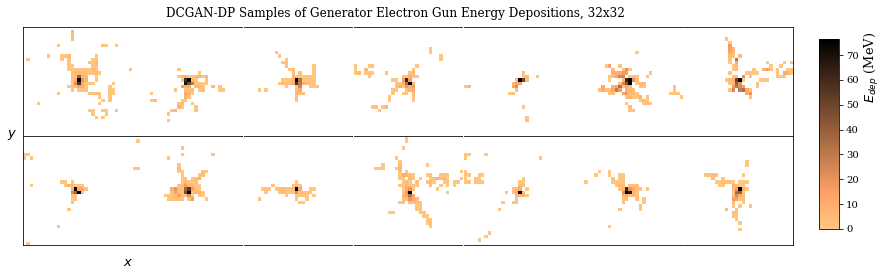

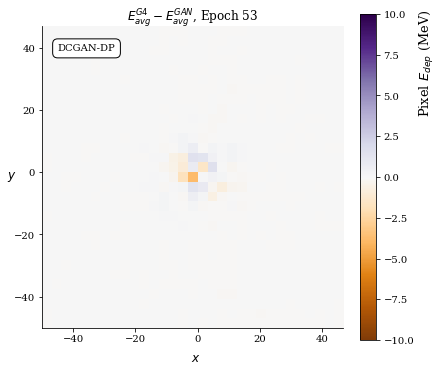

[53/50][0/938] Loss_D: 1.3781 Loss_G: 0.9115 D(x): 0.9120 D(G(z)): 0.7098 / 0.4150
[53/50][100/938] Loss_D: 0.8759 Loss_G: 0.8229 D(x): 0.8152 D(G(z)): 0.4768 / 0.4488
[53/50][200/938] Loss_D: 1.1974 Loss_G: 0.7024 D(x): 0.5864 D(G(z)): 0.4708 / 0.5041
[53/50][300/938] Loss_D: 1.0270 Loss_G: 1.4224 D(x): 0.8898 D(G(z)): 0.5880 / 0.2509
[53/50][400/938] Loss_D: 0.8350 Loss_G: 1.2140 D(x): 0.8009 D(G(z)): 0.4455 / 0.3038
[53/50][500/938] Loss_D: 1.0311 Loss_G: 1.1170 D(x): 0.6924 D(G(z)): 0.4695 / 0.3391
[53/50][600/938] Loss_D: 0.9609 Loss_G: 1.1576 D(x): 0.8205 D(G(z)): 0.5243 / 0.3263
[53/50][700/938] Loss_D: 0.9140 Loss_G: 0.8370 D(x): 0.7814 D(G(z)): 0.4740 / 0.4474
[53/50][800/938] Loss_D: 1.7337 Loss_G: 0.7582 D(x): 0.8568 D(G(z)): 0.7816 / 0.4839
[53/50][900/938] Loss_D: 0.8045 Loss_G: 0.9283 D(x): 0.8125 D(G(z)): 0.4340 / 0.4118
(32, 32)


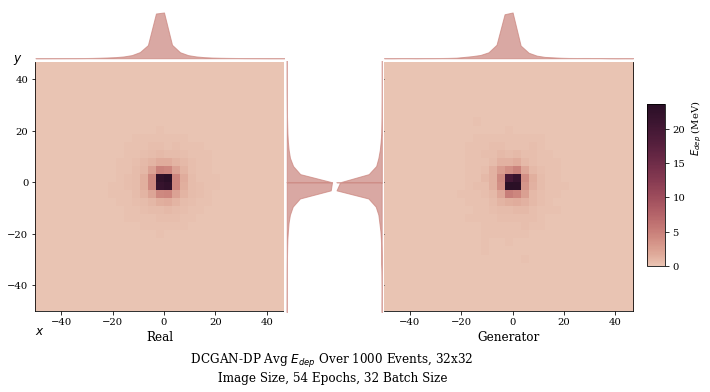

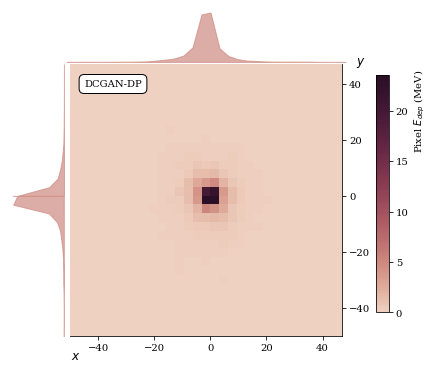

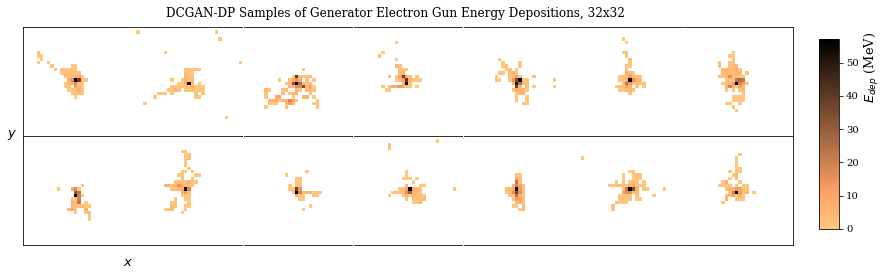

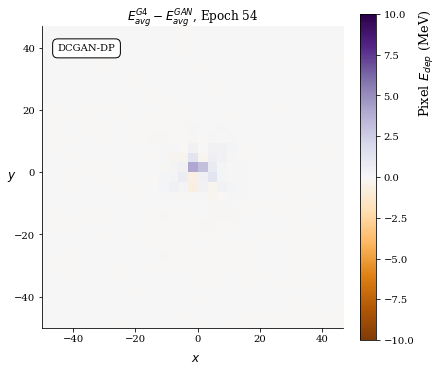

[54/50][0/938] Loss_D: 0.6838 Loss_G: 1.1508 D(x): 0.8149 D(G(z)): 0.3723 / 0.3266
[54/50][100/938] Loss_D: 0.9454 Loss_G: 0.9386 D(x): 0.5883 D(G(z)): 0.3301 / 0.3983
[54/50][200/938] Loss_D: 0.8740 Loss_G: 0.9276 D(x): 0.5860 D(G(z)): 0.2729 / 0.4143
[54/50][300/938] Loss_D: 0.6126 Loss_G: 1.3295 D(x): 0.8419 D(G(z)): 0.3438 / 0.2824
[54/50][400/938] Loss_D: 0.8060 Loss_G: 1.2366 D(x): 0.8255 D(G(z)): 0.4500 / 0.3018
[54/50][500/938] Loss_D: 0.7224 Loss_G: 1.1598 D(x): 0.8183 D(G(z)): 0.3994 / 0.3213
[54/50][600/938] Loss_D: 0.5107 Loss_G: 1.2211 D(x): 0.7097 D(G(z)): 0.1446 / 0.3039
[54/50][700/938] Loss_D: 0.8453 Loss_G: 1.0326 D(x): 0.7195 D(G(z)): 0.3958 / 0.3630
[54/50][800/938] Loss_D: 1.1873 Loss_G: 1.3679 D(x): 0.9099 D(G(z)): 0.6506 / 0.2635
[54/50][900/938] Loss_D: 0.7916 Loss_G: 0.7846 D(x): 0.7586 D(G(z)): 0.3923 / 0.4684
(32, 32)


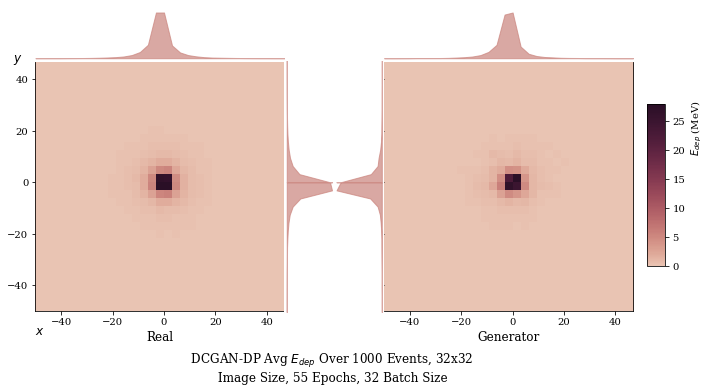

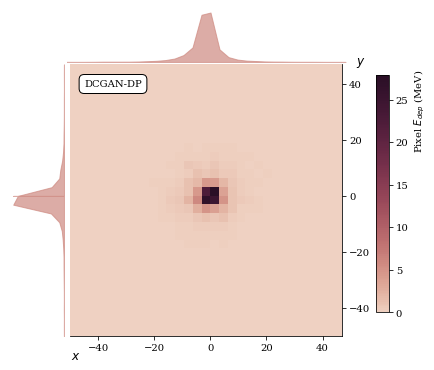

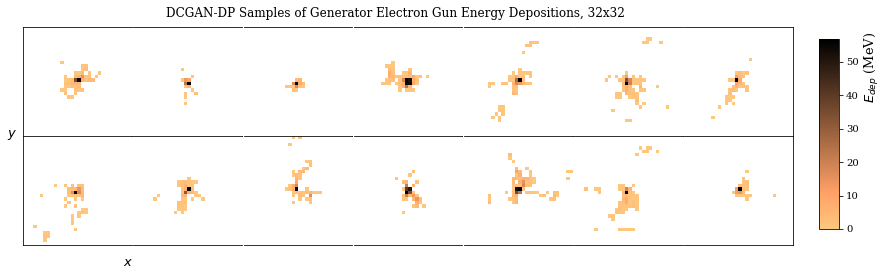

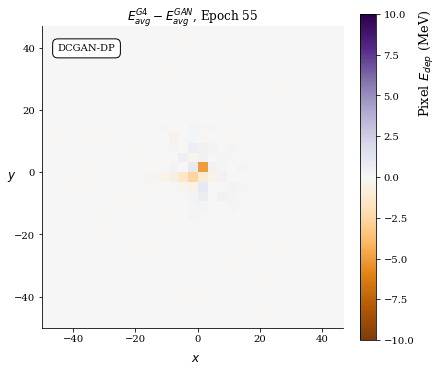

[55/50][0/938] Loss_D: 0.5716 Loss_G: 1.3585 D(x): 0.8561 D(G(z)): 0.3314 / 0.2725
[55/50][100/938] Loss_D: 0.7941 Loss_G: 0.8505 D(x): 0.7772 D(G(z)): 0.4119 / 0.4338
[55/50][200/938] Loss_D: 0.8463 Loss_G: 1.3442 D(x): 0.5719 D(G(z)): 0.2310 / 0.2725
[55/50][300/938] Loss_D: 1.2196 Loss_G: 0.9411 D(x): 0.7839 D(G(z)): 0.6120 / 0.4026
[55/50][400/938] Loss_D: 0.8626 Loss_G: 1.3796 D(x): 0.8856 D(G(z)): 0.5148 / 0.2588
[55/50][500/938] Loss_D: 0.7411 Loss_G: 0.6279 D(x): 0.7593 D(G(z)): 0.3631 / 0.5407
[55/50][600/938] Loss_D: 0.7538 Loss_G: 1.4994 D(x): 0.8188 D(G(z)): 0.4183 / 0.2296
[55/50][700/938] Loss_D: 1.0285 Loss_G: 1.8868 D(x): 0.4661 D(G(z)): 0.2159 / 0.1566
[55/50][800/938] Loss_D: 1.2706 Loss_G: 1.3837 D(x): 0.9018 D(G(z)): 0.6806 / 0.2584
[55/50][900/938] Loss_D: 0.7271 Loss_G: 1.7000 D(x): 0.9082 D(G(z)): 0.4567 / 0.1950
(32, 32)


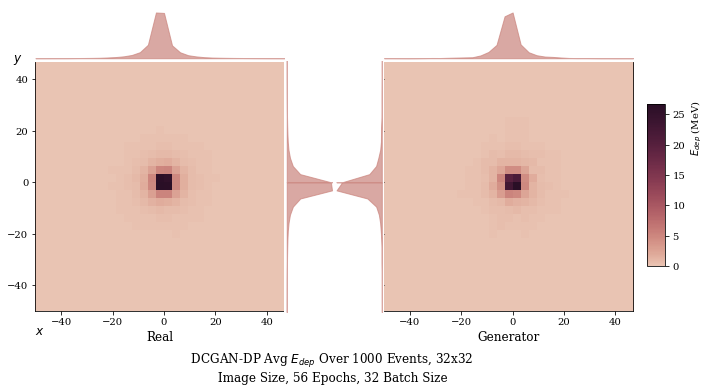

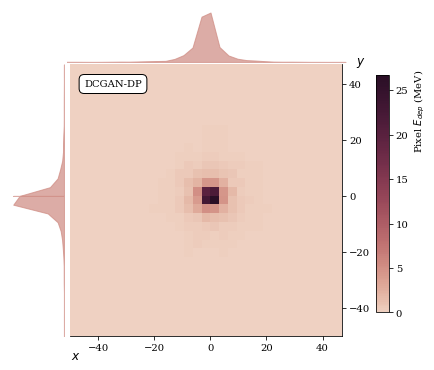

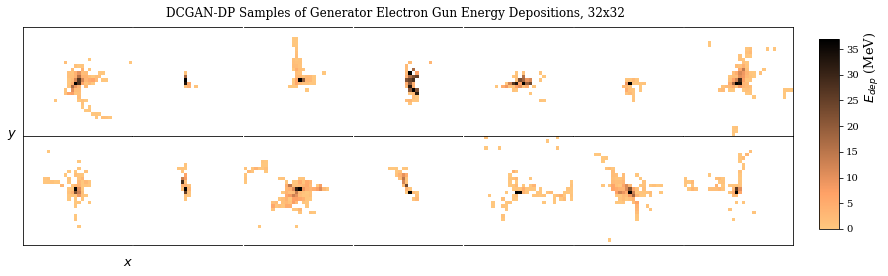

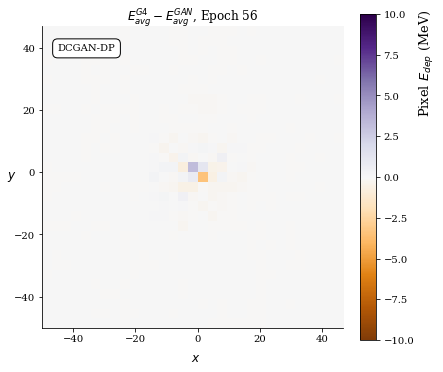

[56/50][0/938] Loss_D: 0.7816 Loss_G: 1.4816 D(x): 0.9144 D(G(z)): 0.4919 / 0.2363
[56/50][100/938] Loss_D: 0.9182 Loss_G: 0.7735 D(x): 0.7667 D(G(z)): 0.4732 / 0.4658
[56/50][200/938] Loss_D: 1.0421 Loss_G: 0.9190 D(x): 0.8467 D(G(z)): 0.5744 / 0.4099
[56/50][300/938] Loss_D: 0.7247 Loss_G: 1.4779 D(x): 0.8697 D(G(z)): 0.4355 / 0.2384
[56/50][400/938] Loss_D: 0.6061 Loss_G: 1.2129 D(x): 0.7229 D(G(z)): 0.2365 / 0.3076
[56/50][500/938] Loss_D: 0.6723 Loss_G: 1.6879 D(x): 0.9139 D(G(z)): 0.4304 / 0.1951
[56/50][600/938] Loss_D: 0.6257 Loss_G: 0.9464 D(x): 0.7659 D(G(z)): 0.2953 / 0.3934
[56/50][700/938] Loss_D: 0.6833 Loss_G: 1.3459 D(x): 0.7791 D(G(z)): 0.3446 / 0.2665
[56/50][800/938] Loss_D: 0.9489 Loss_G: 1.1350 D(x): 0.8523 D(G(z)): 0.5287 / 0.3422
[56/50][900/938] Loss_D: 0.7410 Loss_G: 1.4497 D(x): 0.8977 D(G(z)): 0.4571 / 0.2436
(32, 32)


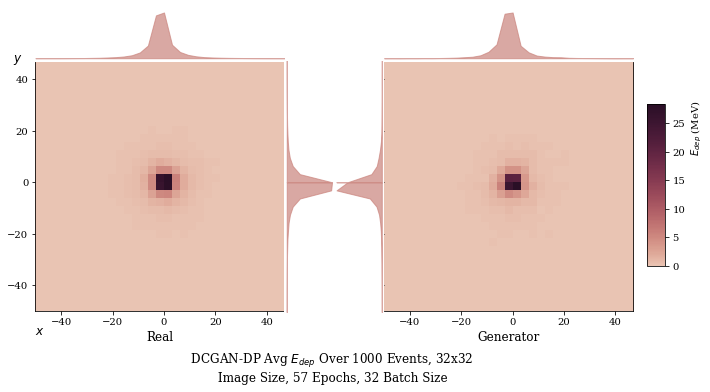

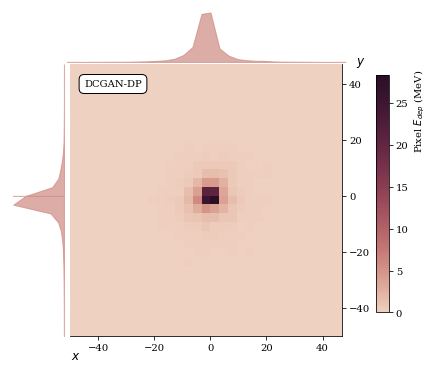

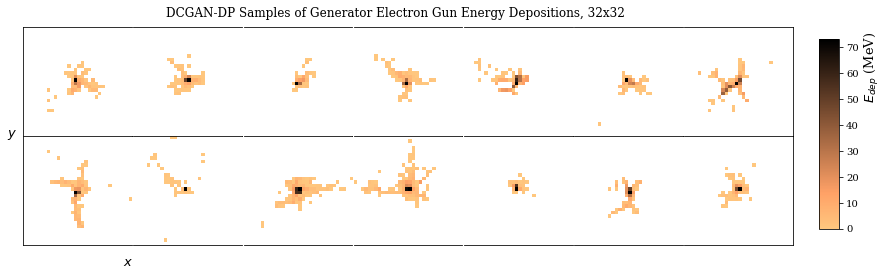

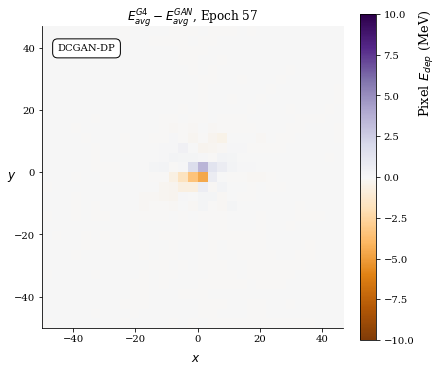

[57/50][0/938] Loss_D: 0.6327 Loss_G: 1.2192 D(x): 0.7809 D(G(z)): 0.3097 / 0.3055
[57/50][100/938] Loss_D: 1.0069 Loss_G: 1.1939 D(x): 0.8345 D(G(z)): 0.5514 / 0.3120
[57/50][200/938] Loss_D: 0.5091 Loss_G: 1.1516 D(x): 0.7441 D(G(z)): 0.1870 / 0.3335
[57/50][300/938] Loss_D: 0.7640 Loss_G: 1.4860 D(x): 0.8768 D(G(z)): 0.4601 / 0.2351
[57/50][400/938] Loss_D: 1.0174 Loss_G: 1.5950 D(x): 0.8789 D(G(z)): 0.5719 / 0.2172
[57/50][500/938] Loss_D: 0.8655 Loss_G: 1.0887 D(x): 0.8351 D(G(z)): 0.4875 / 0.3441
[57/50][600/938] Loss_D: 1.1295 Loss_G: 1.2624 D(x): 0.9169 D(G(z)): 0.6378 / 0.2919
[57/50][700/938] Loss_D: 0.9090 Loss_G: 1.2133 D(x): 0.8113 D(G(z)): 0.4964 / 0.3042
[57/50][800/938] Loss_D: 0.9169 Loss_G: 1.1523 D(x): 0.5314 D(G(z)): 0.2238 / 0.3274
[57/50][900/938] Loss_D: 0.6032 Loss_G: 1.3446 D(x): 0.6756 D(G(z)): 0.1774 / 0.2728
(32, 32)


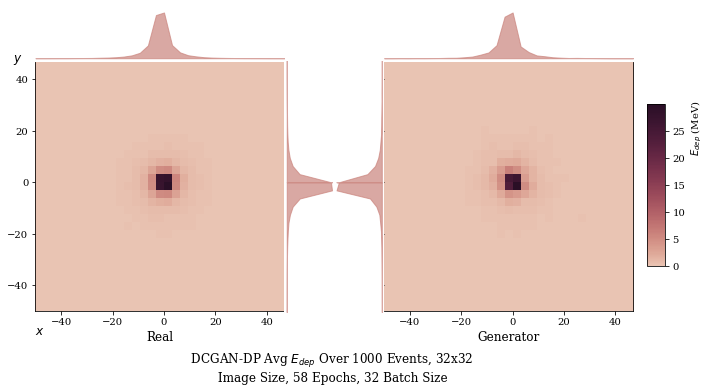

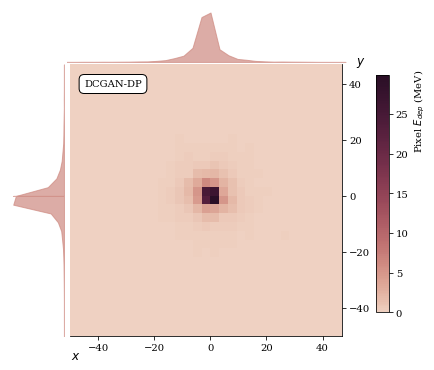

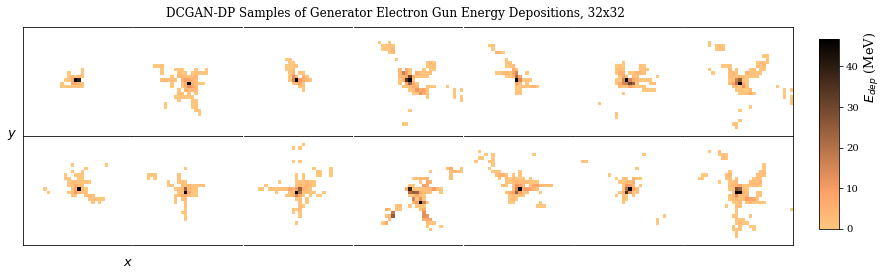

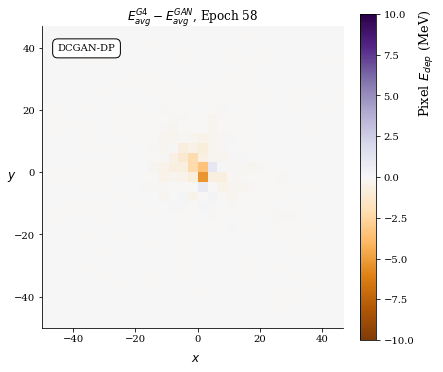

[58/50][0/938] Loss_D: 0.3961 Loss_G: 1.2837 D(x): 0.9174 D(G(z)): 0.2624 / 0.2853
[58/50][100/938] Loss_D: 0.9661 Loss_G: 1.1491 D(x): 0.8947 D(G(z)): 0.5608 / 0.3280
[58/50][200/938] Loss_D: 0.7175 Loss_G: 0.4490 D(x): 0.6801 D(G(z)): 0.2722 / 0.6427
[58/50][300/938] Loss_D: 0.5082 Loss_G: 1.5770 D(x): 0.8624 D(G(z)): 0.2981 / 0.2125
[58/50][400/938] Loss_D: 0.3710 Loss_G: 1.9130 D(x): 0.8796 D(G(z)): 0.2102 / 0.1553
[58/50][500/938] Loss_D: 0.4213 Loss_G: 1.2394 D(x): 0.8289 D(G(z)): 0.2046 / 0.2982
[58/50][600/938] Loss_D: 0.8068 Loss_G: 1.3751 D(x): 0.8535 D(G(z)): 0.4666 / 0.2636
[58/50][700/938] Loss_D: 0.6975 Loss_G: 1.2152 D(x): 0.8360 D(G(z)): 0.3951 / 0.3083
[58/50][800/938] Loss_D: 0.7672 Loss_G: 1.1191 D(x): 0.7673 D(G(z)): 0.3861 / 0.3388
[58/50][900/938] Loss_D: 0.8151 Loss_G: 0.8151 D(x): 0.6078 D(G(z)): 0.2590 / 0.4507
(32, 32)


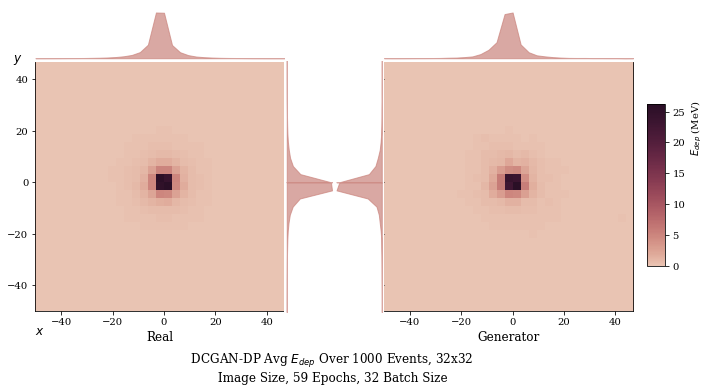

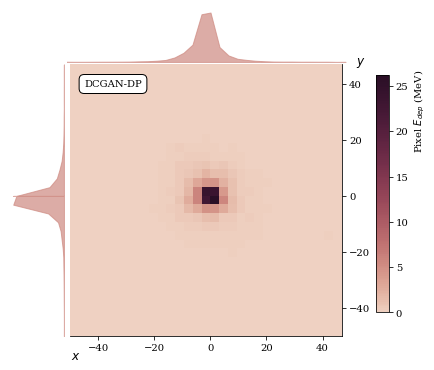

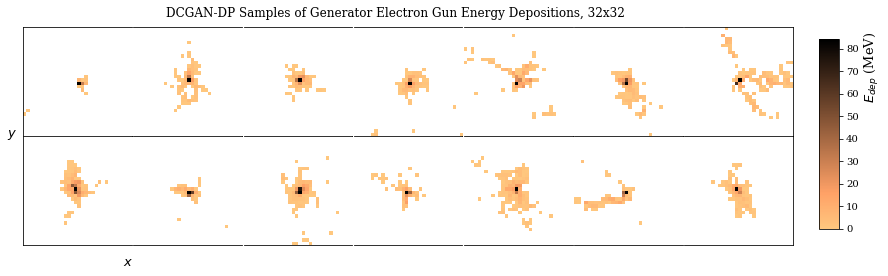

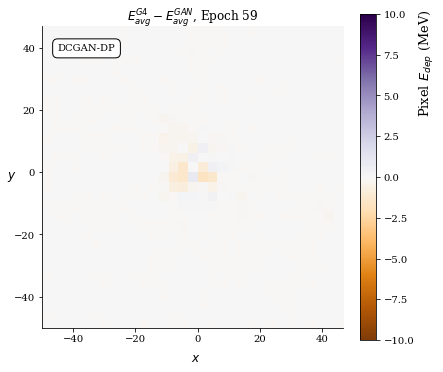

[59/50][0/938] Loss_D: 0.4708 Loss_G: 1.4297 D(x): 0.9032 D(G(z)): 0.3010 / 0.2534
[59/50][100/938] Loss_D: 0.8040 Loss_G: 1.2310 D(x): 0.5680 D(G(z)): 0.1962 / 0.3054
[59/50][200/938] Loss_D: 0.6496 Loss_G: 1.6620 D(x): 0.5947 D(G(z)): 0.1074 / 0.1962
[59/50][300/938] Loss_D: 0.9342 Loss_G: 1.4270 D(x): 0.8752 D(G(z)): 0.5323 / 0.2569
[59/50][400/938] Loss_D: 0.8708 Loss_G: 1.0355 D(x): 0.9067 D(G(z)): 0.5266 / 0.3640
[59/50][500/938] Loss_D: 0.4474 Loss_G: 1.4136 D(x): 0.8596 D(G(z)): 0.2495 / 0.2555
[59/50][600/938] Loss_D: 0.4148 Loss_G: 1.4729 D(x): 0.8011 D(G(z)): 0.1719 / 0.2426
[59/50][700/938] Loss_D: 0.6962 Loss_G: 1.2628 D(x): 0.6296 D(G(z)): 0.1864 / 0.3035
[59/50][800/938] Loss_D: 1.6929 Loss_G: 1.5009 D(x): 0.9626 D(G(z)): 0.7989 / 0.2318
[59/50][900/938] Loss_D: 0.5433 Loss_G: 1.2767 D(x): 0.7475 D(G(z)): 0.2118 / 0.2976
(32, 32)


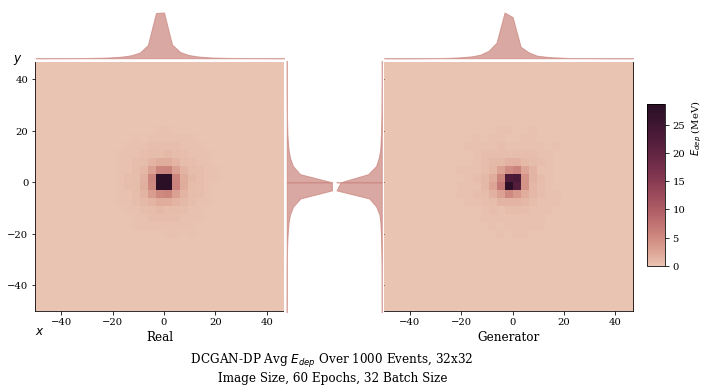

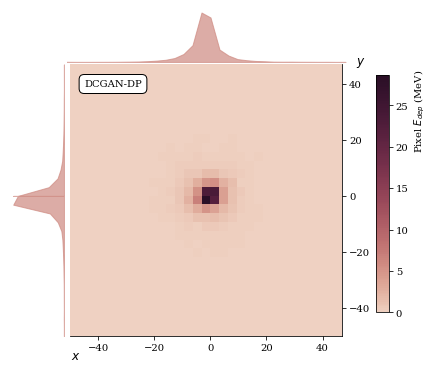

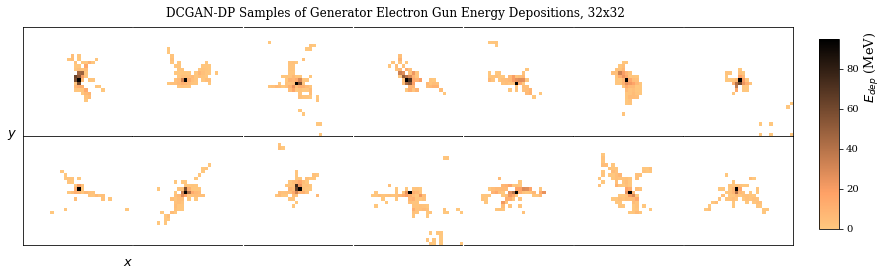

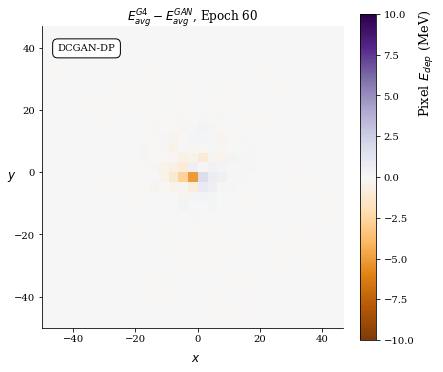

[60/50][0/938] Loss_D: 0.8810 Loss_G: 1.4140 D(x): 0.9333 D(G(z)): 0.5462 / 0.2525
[60/50][100/938] Loss_D: 0.4891 Loss_G: 0.8293 D(x): 0.7770 D(G(z)): 0.2050 / 0.4536
[60/50][200/938] Loss_D: 0.4971 Loss_G: 1.2265 D(x): 0.6714 D(G(z)): 0.0857 / 0.3079
[60/50][300/938] Loss_D: 1.0665 Loss_G: 1.1497 D(x): 0.8973 D(G(z)): 0.5938 / 0.3401
[60/50][400/938] Loss_D: 0.5919 Loss_G: 1.1367 D(x): 0.8921 D(G(z)): 0.3710 / 0.3329
[60/50][500/938] Loss_D: 0.7951 Loss_G: 1.9009 D(x): 0.5192 D(G(z)): 0.1078 / 0.1553
[60/50][600/938] Loss_D: 0.5598 Loss_G: 0.9142 D(x): 0.7882 D(G(z)): 0.2702 / 0.4092
[60/50][700/938] Loss_D: 1.0698 Loss_G: 0.9193 D(x): 0.8482 D(G(z)): 0.5826 / 0.4105
[60/50][800/938] Loss_D: 0.6484 Loss_G: 1.3119 D(x): 0.8109 D(G(z)): 0.3483 / 0.2791
[60/50][900/938] Loss_D: 0.7014 Loss_G: 1.1860 D(x): 0.6380 D(G(z)): 0.2057 / 0.3155
(32, 32)


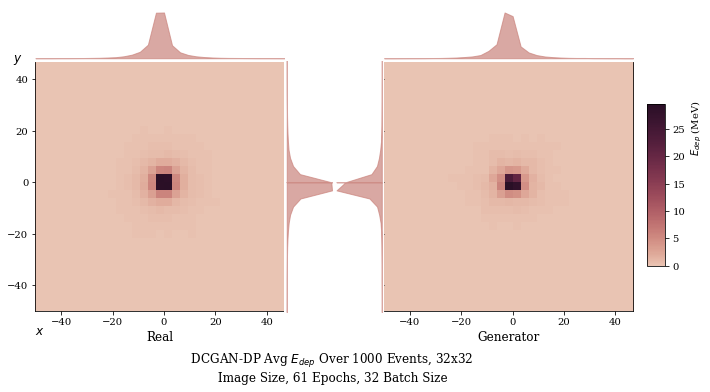

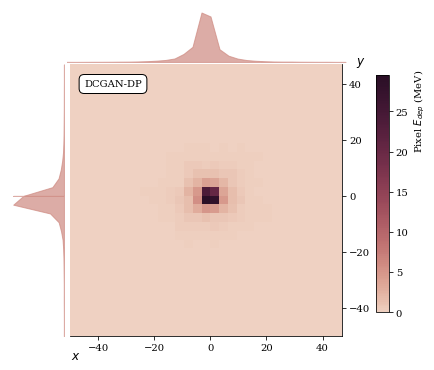

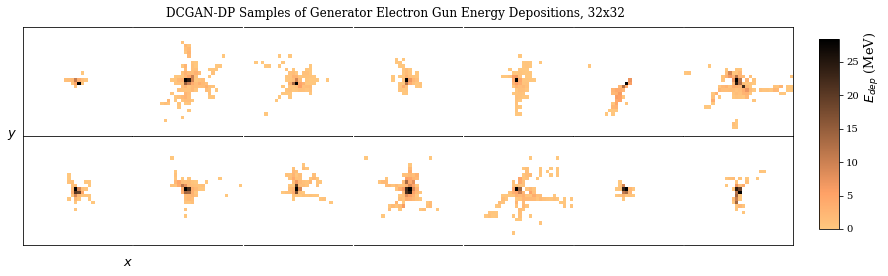

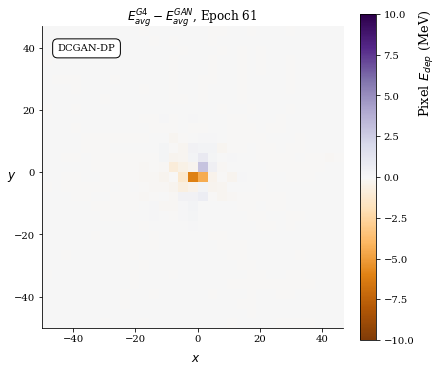

[61/50][0/938] Loss_D: 0.6018 Loss_G: 1.1172 D(x): 0.8039 D(G(z)): 0.3126 / 0.3334
[61/50][100/938] Loss_D: 0.7144 Loss_G: 1.2467 D(x): 0.9145 D(G(z)): 0.4576 / 0.2959
[61/50][200/938] Loss_D: 0.8901 Loss_G: 0.8755 D(x): 0.6443 D(G(z)): 0.3428 / 0.4270
[61/50][300/938] Loss_D: 0.6992 Loss_G: 1.0669 D(x): 0.8723 D(G(z)): 0.4209 / 0.3582
[61/50][400/938] Loss_D: 0.9538 Loss_G: 1.0776 D(x): 0.8542 D(G(z)): 0.5404 / 0.3526
[61/50][500/938] Loss_D: 0.8453 Loss_G: 0.5029 D(x): 0.7338 D(G(z)): 0.4041 / 0.6087
[61/50][600/938] Loss_D: 0.4565 Loss_G: 1.7556 D(x): 0.8796 D(G(z)): 0.2745 / 0.1801
[61/50][700/938] Loss_D: 1.1290 Loss_G: 0.9581 D(x): 0.8516 D(G(z)): 0.6047 / 0.3967
[61/50][800/938] Loss_D: 0.9649 Loss_G: 0.9815 D(x): 0.7980 D(G(z)): 0.5084 / 0.3942
[61/50][900/938] Loss_D: 0.4732 Loss_G: 0.8237 D(x): 0.7885 D(G(z)): 0.2037 / 0.4524
(32, 32)


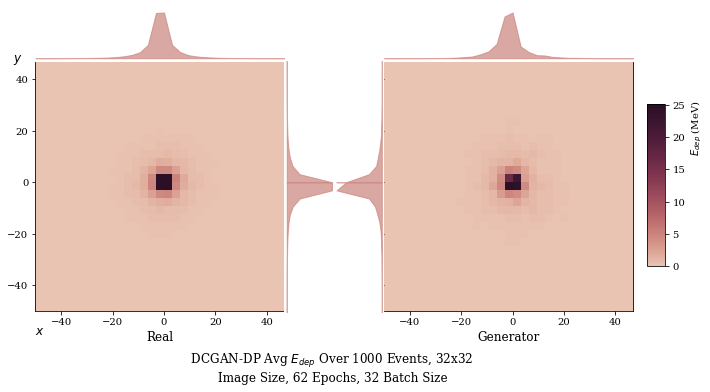

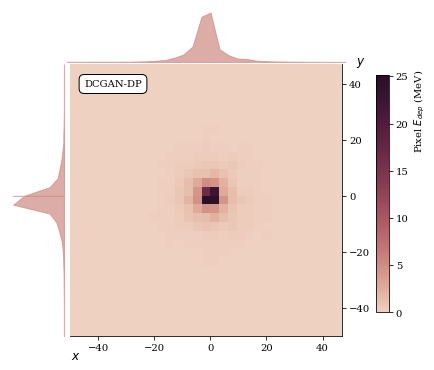

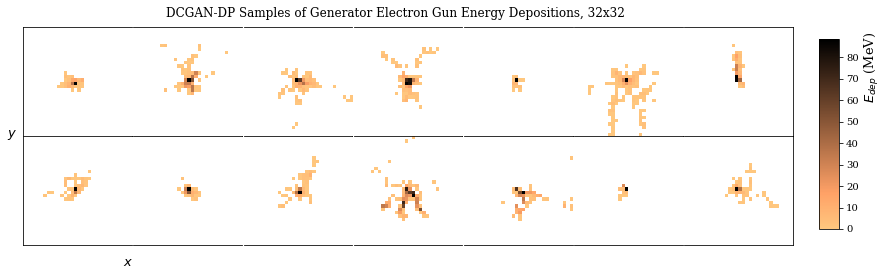

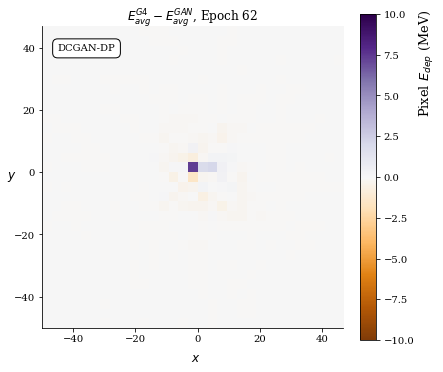

[62/50][0/938] Loss_D: 1.2396 Loss_G: 1.2620 D(x): 0.9576 D(G(z)): 0.6802 / 0.3003
[62/50][100/938] Loss_D: 0.9076 Loss_G: 0.6012 D(x): 0.8379 D(G(z)): 0.5095 / 0.5541
[62/50][200/938] Loss_D: 0.4852 Loss_G: 1.0489 D(x): 0.8214 D(G(z)): 0.2435 / 0.3688
[62/50][300/938] Loss_D: 1.2511 Loss_G: 1.2315 D(x): 0.9140 D(G(z)): 0.6737 / 0.3075
[62/50][400/938] Loss_D: 0.4742 Loss_G: 1.4774 D(x): 0.7549 D(G(z)): 0.1670 / 0.2409
[62/50][500/938] Loss_D: 0.7443 Loss_G: 0.6223 D(x): 0.7552 D(G(z)): 0.3569 / 0.5538
[62/50][600/938] Loss_D: 1.1222 Loss_G: 1.0054 D(x): 0.8717 D(G(z)): 0.6090 / 0.3787
[62/50][700/938] Loss_D: 0.5037 Loss_G: 0.6989 D(x): 0.8137 D(G(z)): 0.2477 / 0.5299
[62/50][800/938] Loss_D: 0.8366 Loss_G: 1.4999 D(x): 0.9373 D(G(z)): 0.5247 / 0.2374
[62/50][900/938] Loss_D: 0.7744 Loss_G: 0.8064 D(x): 0.6560 D(G(z)): 0.2856 / 0.4558
(32, 32)


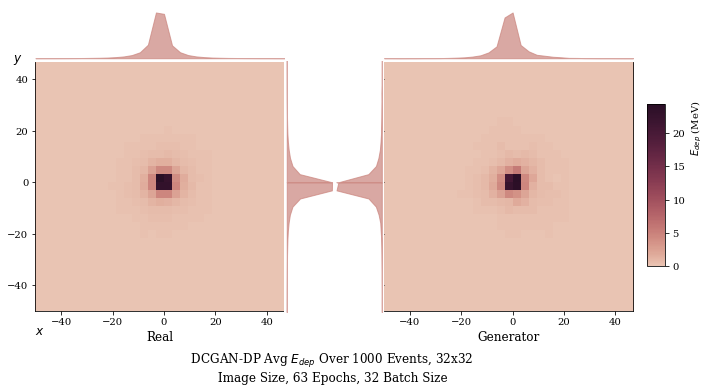

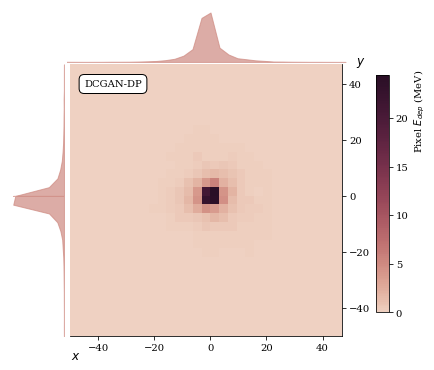

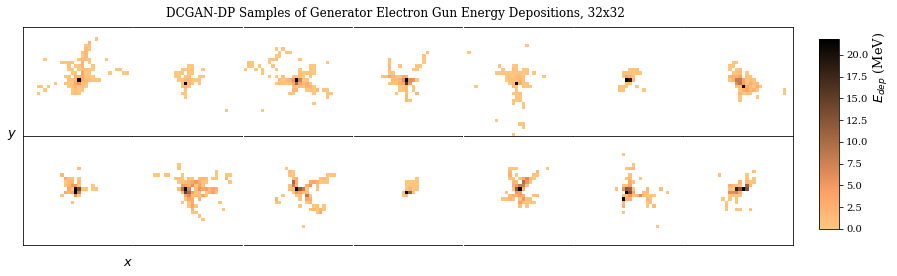

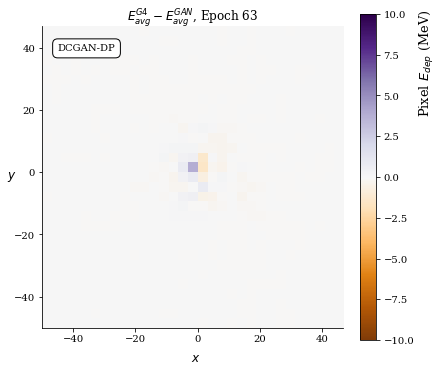

[63/50][0/938] Loss_D: 0.3234 Loss_G: 1.8761 D(x): 0.9454 D(G(z)): 0.2298 / 0.1665
[63/50][100/938] Loss_D: 0.5118 Loss_G: 1.1928 D(x): 0.8774 D(G(z)): 0.3068 / 0.3163
[63/50][200/938] Loss_D: 0.7130 Loss_G: 0.7229 D(x): 0.8278 D(G(z)): 0.3969 / 0.4997
[63/50][300/938] Loss_D: 0.4823 Loss_G: 1.6794 D(x): 0.9150 D(G(z)): 0.3152 / 0.2023
[63/50][400/938] Loss_D: 0.5204 Loss_G: 0.8832 D(x): 0.7764 D(G(z)): 0.2247 / 0.4319
[63/50][500/938] Loss_D: 1.4581 Loss_G: 1.6121 D(x): 0.9657 D(G(z)): 0.7463 / 0.2114
[63/50][600/938] Loss_D: 0.4272 Loss_G: 1.1780 D(x): 0.8570 D(G(z)): 0.2341 / 0.3226
[63/50][700/938] Loss_D: 0.9003 Loss_G: 1.7325 D(x): 0.9372 D(G(z)): 0.5543 / 0.1874
[63/50][800/938] Loss_D: 1.2411 Loss_G: 1.5724 D(x): 0.9364 D(G(z)): 0.6768 / 0.2200
[63/50][900/938] Loss_D: 0.4059 Loss_G: 1.2855 D(x): 0.8317 D(G(z)): 0.1926 / 0.2945
(32, 32)


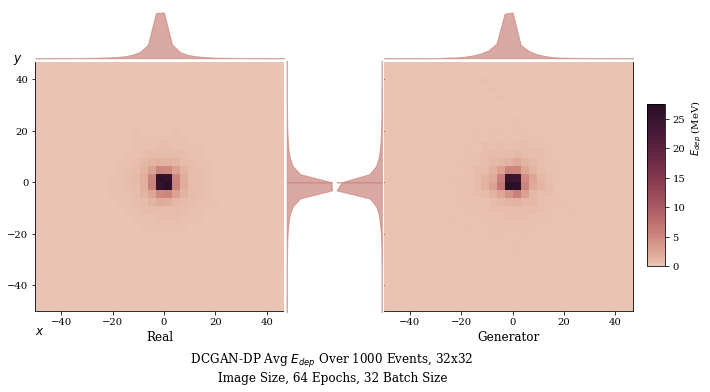

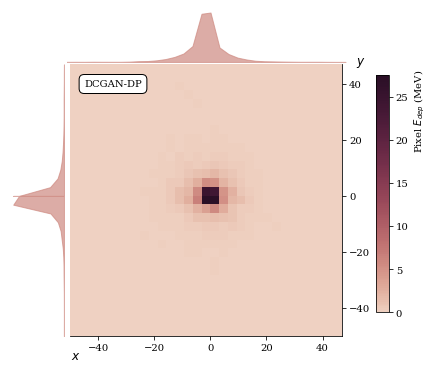

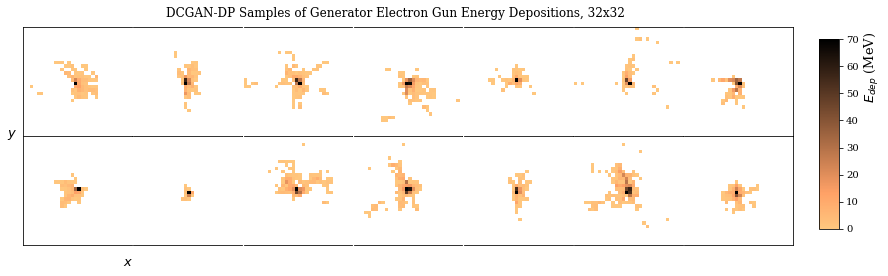

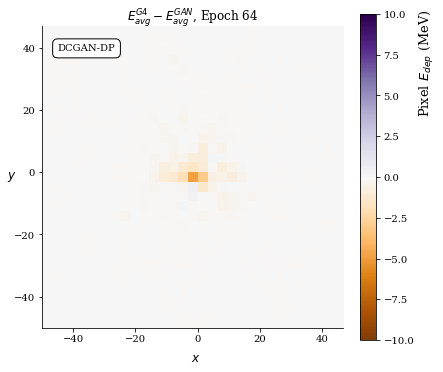

[64/50][0/938] Loss_D: 0.5193 Loss_G: 0.8276 D(x): 0.8174 D(G(z)): 0.2626 / 0.4544
[64/50][100/938] Loss_D: 0.5878 Loss_G: 0.4612 D(x): 0.6609 D(G(z)): 0.1454 / 0.6417
[64/50][200/938] Loss_D: 0.3676 Loss_G: 0.6196 D(x): 0.8219 D(G(z)): 0.1540 / 0.5467
[64/50][300/938] Loss_D: 0.9455 Loss_G: 1.7231 D(x): 0.9423 D(G(z)): 0.5811 / 0.1864
[64/50][400/938] Loss_D: 0.5818 Loss_G: 0.7634 D(x): 0.8189 D(G(z)): 0.3076 / 0.4825
[64/50][500/938] Loss_D: 0.6674 Loss_G: 0.5993 D(x): 0.6978 D(G(z)): 0.2481 / 0.5627
[64/50][600/938] Loss_D: 0.6754 Loss_G: 1.5382 D(x): 0.9332 D(G(z)): 0.4442 / 0.2264
[64/50][700/938] Loss_D: 1.4159 Loss_G: 0.9724 D(x): 0.9407 D(G(z)): 0.7229 / 0.3946
[64/50][800/938] Loss_D: 0.8122 Loss_G: 0.4698 D(x): 0.6483 D(G(z)): 0.2996 / 0.6314
[64/50][900/938] Loss_D: 0.6323 Loss_G: 1.3107 D(x): 0.8958 D(G(z)): 0.3999 / 0.2766
(32, 32)


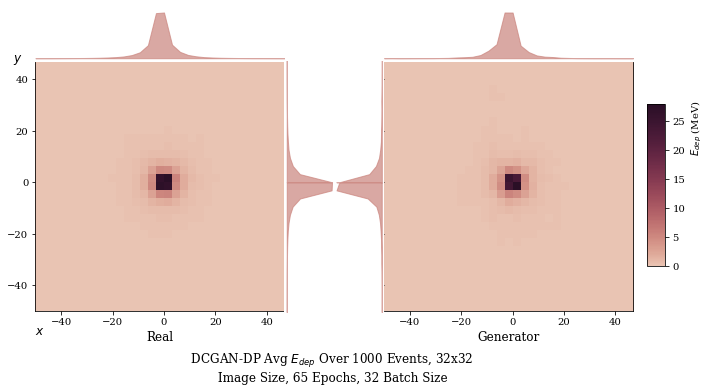

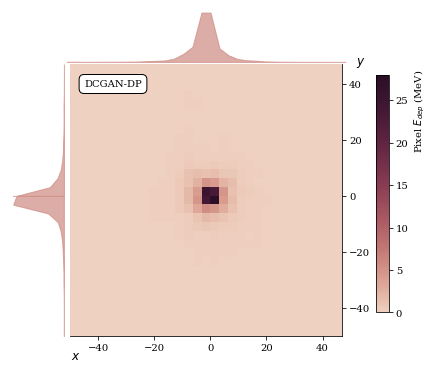

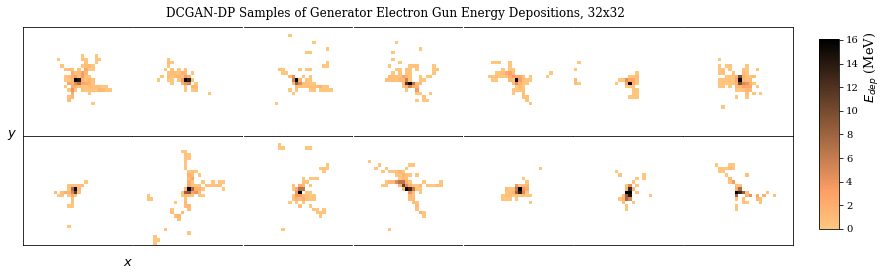

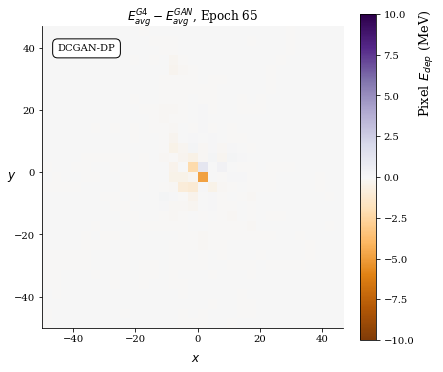

[65/50][0/938] Loss_D: 0.3958 Loss_G: 1.9919 D(x): 0.8888 D(G(z)): 0.2379 / 0.1456
[65/50][100/938] Loss_D: 1.1119 Loss_G: 1.1982 D(x): 0.9614 D(G(z)): 0.6413 / 0.3247
[65/50][200/938] Loss_D: 0.6993 Loss_G: 0.2600 D(x): 0.6914 D(G(z)): 0.2652 / 0.7742
[65/50][300/938] Loss_D: 0.6034 Loss_G: 1.4348 D(x): 0.9367 D(G(z)): 0.4047 / 0.2517
[65/50][400/938] Loss_D: 0.5400 Loss_G: 0.8225 D(x): 0.7734 D(G(z)): 0.2359 / 0.4504
[65/50][500/938] Loss_D: 0.3180 Loss_G: 0.9577 D(x): 0.8655 D(G(z)): 0.1563 / 0.3970
[65/50][600/938] Loss_D: 0.7070 Loss_G: 0.9050 D(x): 0.9230 D(G(z)): 0.4551 / 0.4149
[65/50][700/938] Loss_D: 0.4146 Loss_G: 1.9937 D(x): 0.9317 D(G(z)): 0.2848 / 0.1512
[65/50][800/938] Loss_D: 0.5478 Loss_G: 1.1948 D(x): 0.9003 D(G(z)): 0.3450 / 0.3198
[65/50][900/938] Loss_D: 1.1593 Loss_G: 1.2301 D(x): 0.9462 D(G(z)): 0.6480 / 0.3149
(32, 32)


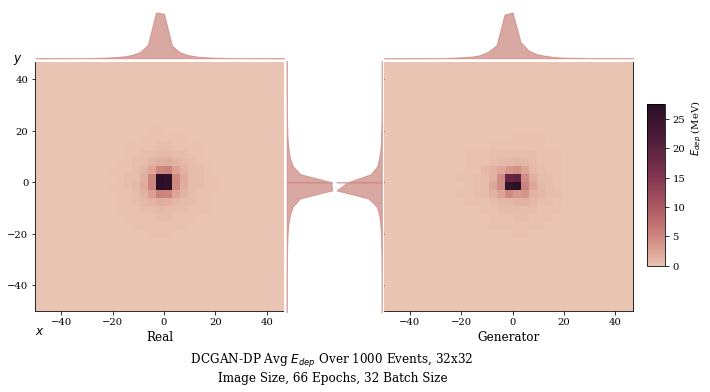

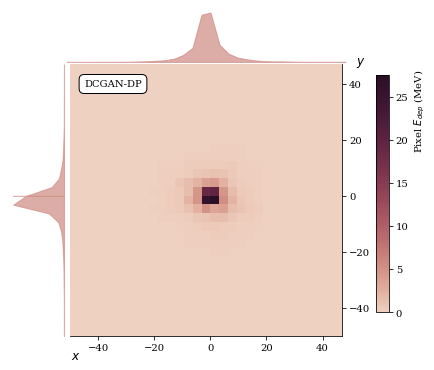

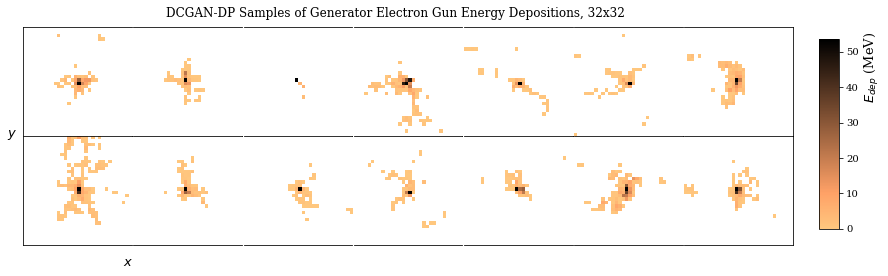

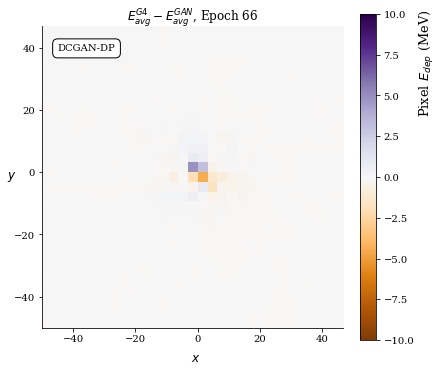

[66/50][0/938] Loss_D: 0.3033 Loss_G: 1.8070 D(x): 0.9199 D(G(z)): 0.1919 / 0.1850
[66/50][100/938] Loss_D: 1.1374 Loss_G: 1.0080 D(x): 0.9311 D(G(z)): 0.6440 / 0.3754
[66/50][200/938] Loss_D: 0.5431 Loss_G: 1.5697 D(x): 0.9128 D(G(z)): 0.3498 / 0.2236
[66/50][300/938] Loss_D: 0.5614 Loss_G: 1.8525 D(x): 0.9541 D(G(z)): 0.3881 / 0.1705
[66/50][400/938] Loss_D: 0.6483 Loss_G: 1.5931 D(x): 0.9719 D(G(z)): 0.4540 / 0.2128
[66/50][500/938] Loss_D: 0.4415 Loss_G: 1.5548 D(x): 0.9078 D(G(z)): 0.2853 / 0.2213
[66/50][600/938] Loss_D: 0.8369 Loss_G: 1.3860 D(x): 0.9781 D(G(z)): 0.5478 / 0.2581
[66/50][700/938] Loss_D: 0.9945 Loss_G: 0.9896 D(x): 0.8824 D(G(z)): 0.5636 / 0.3845
[66/50][800/938] Loss_D: 0.5632 Loss_G: 1.1545 D(x): 0.6693 D(G(z)): 0.1386 / 0.3288
[66/50][900/938] Loss_D: 0.6715 Loss_G: 1.5314 D(x): 0.9364 D(G(z)): 0.4393 / 0.2320
(32, 32)


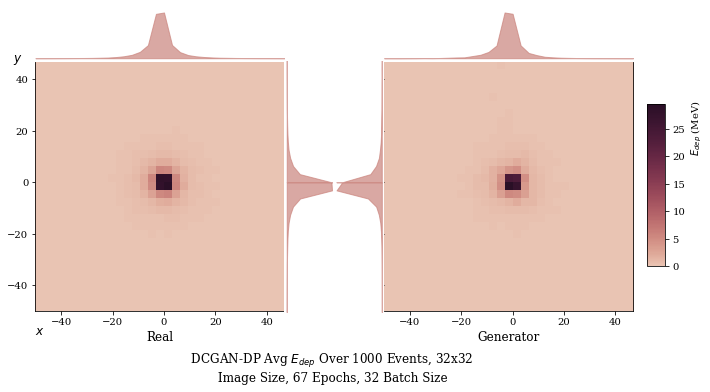

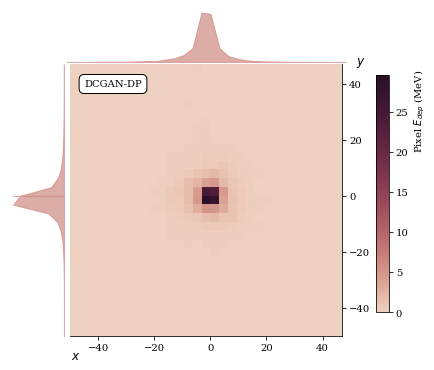

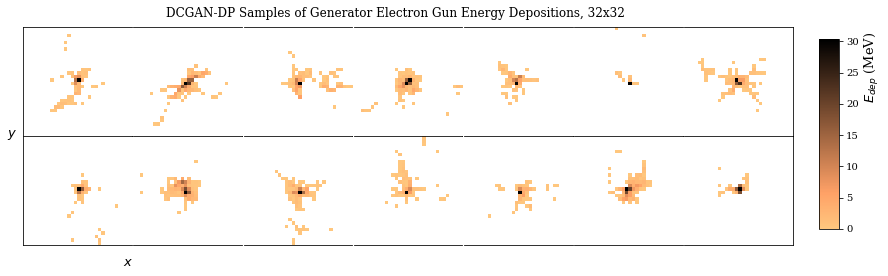

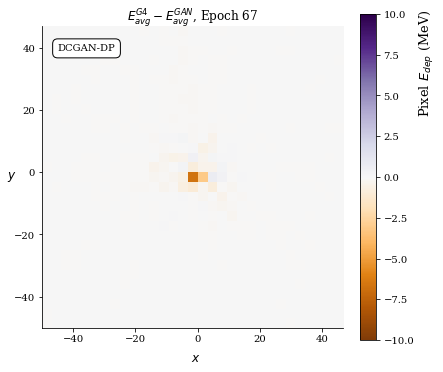

[67/50][0/938] Loss_D: 0.4157 Loss_G: 1.4724 D(x): 0.8881 D(G(z)): 0.2520 / 0.2417
[67/50][100/938] Loss_D: 0.5208 Loss_G: 0.9211 D(x): 0.8981 D(G(z)): 0.3314 / 0.4129
[67/50][200/938] Loss_D: 0.4881 Loss_G: 0.8339 D(x): 0.8154 D(G(z)): 0.2371 / 0.4610
[67/50][300/938] Loss_D: 0.3877 Loss_G: 1.5036 D(x): 0.9064 D(G(z)): 0.2476 / 0.2301
[67/50][400/938] Loss_D: 0.4375 Loss_G: 1.2743 D(x): 0.8848 D(G(z)): 0.2548 / 0.3063
[67/50][500/938] Loss_D: 0.5206 Loss_G: 1.4118 D(x): 0.8906 D(G(z)): 0.3271 / 0.2525
[67/50][600/938] Loss_D: 0.6807 Loss_G: 1.5996 D(x): 0.9425 D(G(z)): 0.4529 / 0.2116
[67/50][700/938] Loss_D: 0.8473 Loss_G: 0.7311 D(x): 0.8627 D(G(z)): 0.4893 / 0.4951
[67/50][800/938] Loss_D: 0.5476 Loss_G: 1.0154 D(x): 0.8812 D(G(z)): 0.3328 / 0.3827
[67/50][900/938] Loss_D: 0.3333 Loss_G: 1.0390 D(x): 0.8611 D(G(z)): 0.1619 / 0.3775
(32, 32)


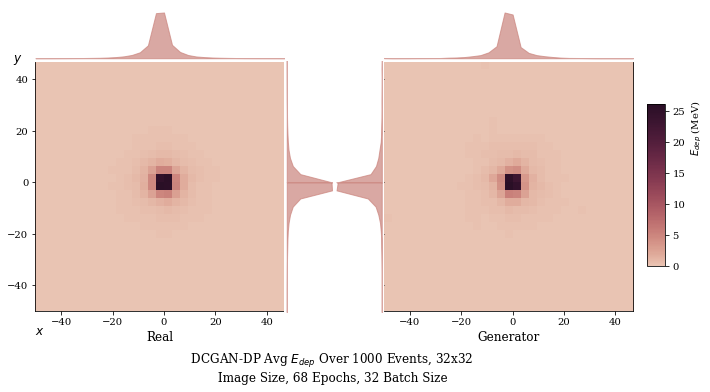

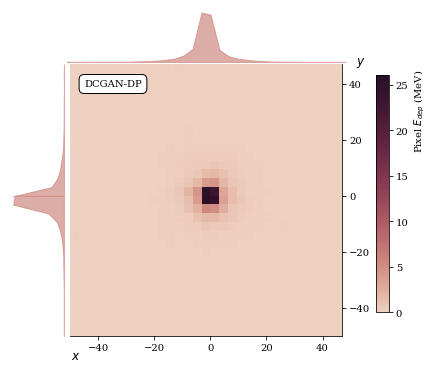

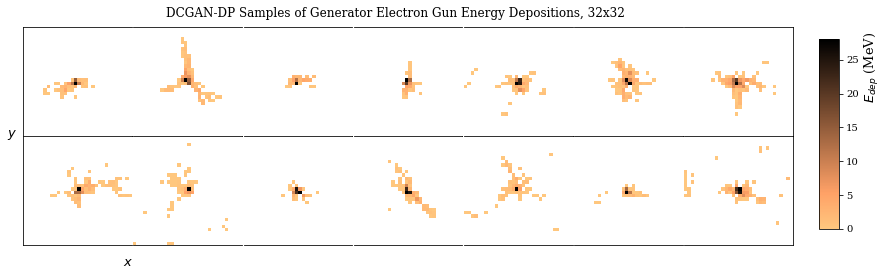

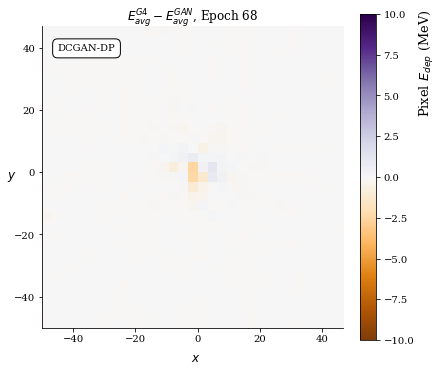

[68/50][0/938] Loss_D: 0.3023 Loss_G: 1.7974 D(x): 0.9655 D(G(z)): 0.2311 / 0.1755
[68/50][100/938] Loss_D: 0.5144 Loss_G: 0.8106 D(x): 0.8822 D(G(z)): 0.3098 / 0.4763
[68/50][200/938] Loss_D: 0.5387 Loss_G: 0.4563 D(x): 0.6978 D(G(z)): 0.1506 / 0.6429
[68/50][300/938] Loss_D: 0.6810 Loss_G: 1.5123 D(x): 0.9377 D(G(z)): 0.4465 / 0.2357
[68/50][400/938] Loss_D: 1.6139 Loss_G: 0.7827 D(x): 0.9833 D(G(z)): 0.7865 / 0.4667
[68/50][500/938] Loss_D: 0.9097 Loss_G: 1.3569 D(x): 0.9428 D(G(z)): 0.5538 / 0.2769
[68/50][600/938] Loss_D: 0.6954 Loss_G: 1.7677 D(x): 0.9356 D(G(z)): 0.4466 / 0.1880
[68/50][700/938] Loss_D: 1.0587 Loss_G: 1.4208 D(x): 0.9114 D(G(z)): 0.6055 / 0.2517
[68/50][800/938] Loss_D: 0.8321 Loss_G: 1.4150 D(x): 0.9397 D(G(z)): 0.5213 / 0.2533
[68/50][900/938] Loss_D: 0.3832 Loss_G: 0.5098 D(x): 0.8066 D(G(z)): 0.1490 / 0.6116
(32, 32)


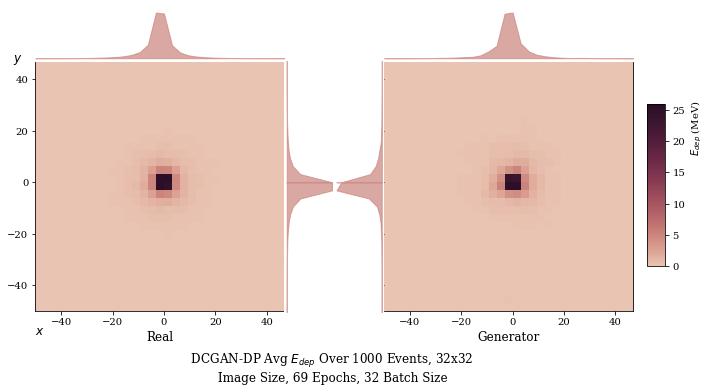

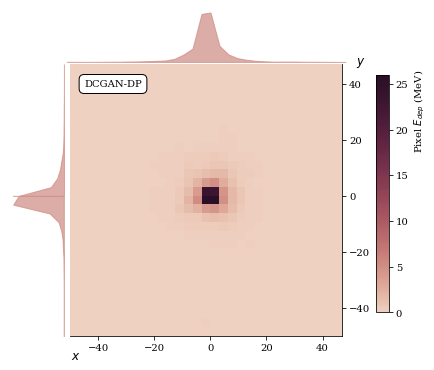

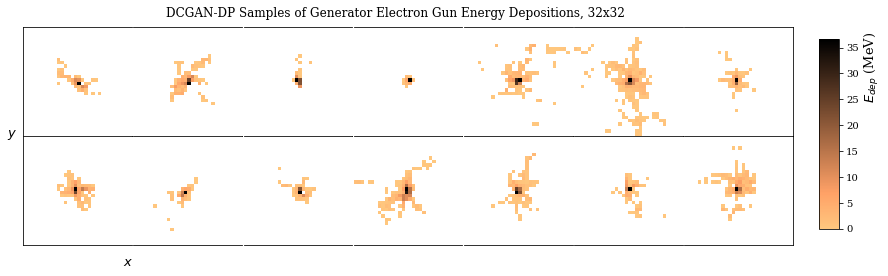

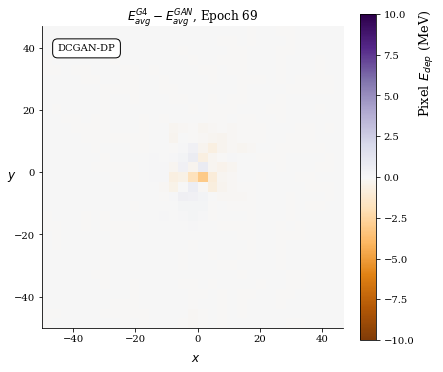

[69/50][0/938] Loss_D: 0.4479 Loss_G: 1.6132 D(x): 0.9724 D(G(z)): 0.3365 / 0.2105
[69/50][100/938] Loss_D: 1.2578 Loss_G: 1.3278 D(x): 0.9394 D(G(z)): 0.6655 / 0.2888
[69/50][200/938] Loss_D: 0.4335 Loss_G: 0.7748 D(x): 0.7036 D(G(z)): 0.0717 / 0.4870
[69/50][300/938] Loss_D: 0.2846 Loss_G: 1.3924 D(x): 0.9076 D(G(z)): 0.1683 / 0.2576
[69/50][400/938] Loss_D: 0.3422 Loss_G: 1.7982 D(x): 0.9464 D(G(z)): 0.2443 / 0.1801
[69/50][500/938] Loss_D: 0.3700 Loss_G: 2.1330 D(x): 0.9585 D(G(z)): 0.2743 / 0.1250
[69/50][600/938] Loss_D: 0.7715 Loss_G: 1.7470 D(x): 0.9444 D(G(z)): 0.4949 / 0.1917
[69/50][700/938] Loss_D: 0.7105 Loss_G: 1.7746 D(x): 0.9466 D(G(z)): 0.4607 / 0.1905
[69/50][800/938] Loss_D: 1.3081 Loss_G: 1.0729 D(x): 0.9866 D(G(z)): 0.7070 / 0.3611
[69/50][900/938] Loss_D: 0.2966 Loss_G: 1.4550 D(x): 0.9196 D(G(z)): 0.1889 / 0.2403
(32, 32)


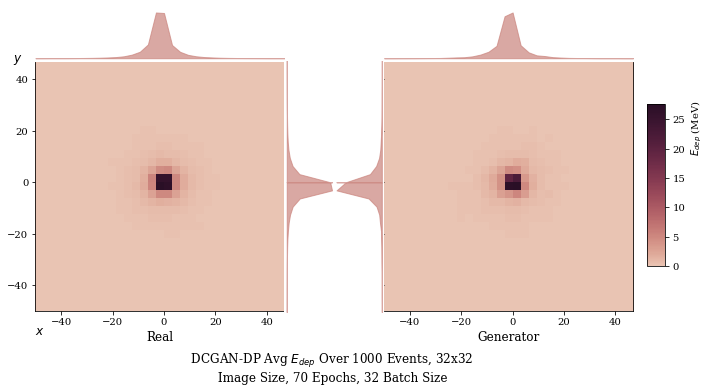

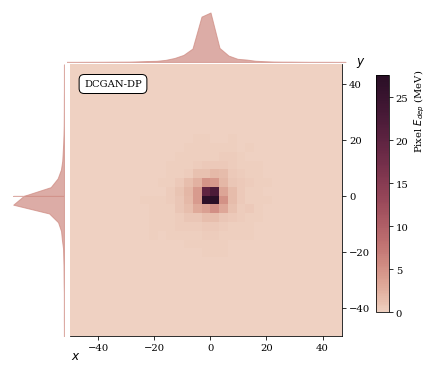

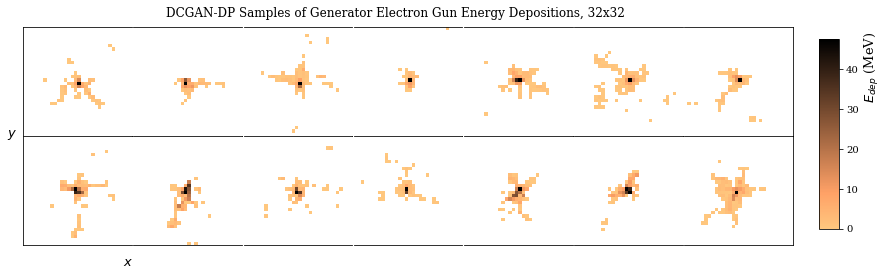

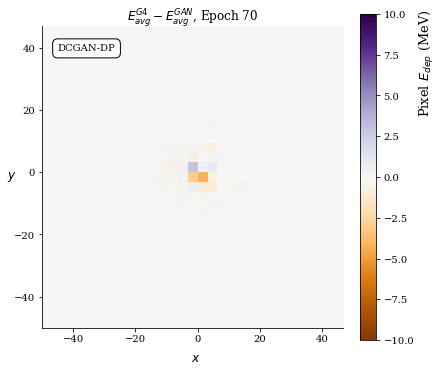

[70/50][0/938] Loss_D: 0.5504 Loss_G: 1.5547 D(x): 0.9636 D(G(z)): 0.3948 / 0.2185
[70/50][100/938] Loss_D: 0.3144 Loss_G: 0.8350 D(x): 0.8462 D(G(z)): 0.1325 / 0.4464
[70/50][200/938] Loss_D: 0.6189 Loss_G: 0.7200 D(x): 0.8250 D(G(z)): 0.3360 / 0.5032
[70/50][300/938] Loss_D: 3.2910 Loss_G: 0.1946 D(x): 0.9975 D(G(z)): 0.9562 / 0.8276
[70/50][400/938] Loss_D: 0.6819 Loss_G: 1.3315 D(x): 0.9396 D(G(z)): 0.4465 / 0.2818
[70/50][500/938] Loss_D: 1.2783 Loss_G: 1.5986 D(x): 0.9361 D(G(z)): 0.6859 / 0.2141
[70/50][600/938] Loss_D: 0.7453 Loss_G: 1.8186 D(x): 0.9525 D(G(z)): 0.4860 / 0.1776
[70/50][700/938] Loss_D: 0.6556 Loss_G: 1.2815 D(x): 0.9261 D(G(z)): 0.4264 / 0.2939
[70/50][800/938] Loss_D: 0.7744 Loss_G: 1.1999 D(x): 0.9692 D(G(z)): 0.5131 / 0.3120
[70/50][900/938] Loss_D: 0.3587 Loss_G: 1.2338 D(x): 0.8950 D(G(z)): 0.2131 / 0.3163
(32, 32)


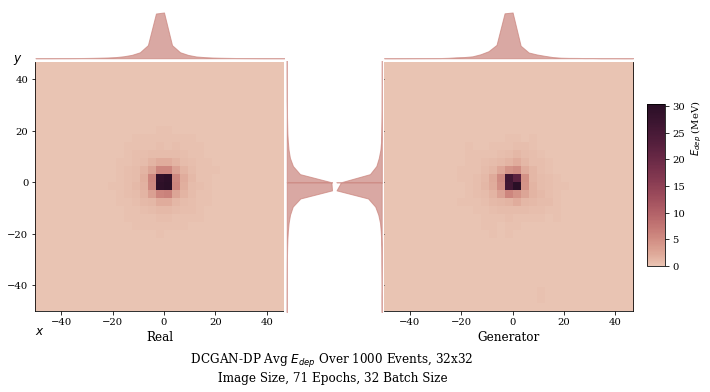

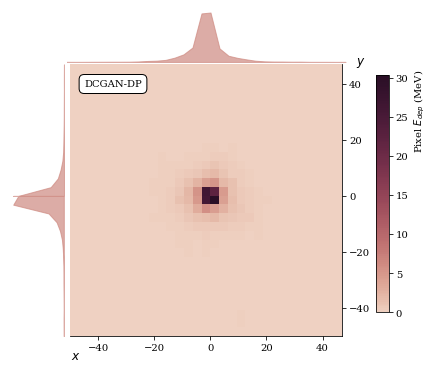

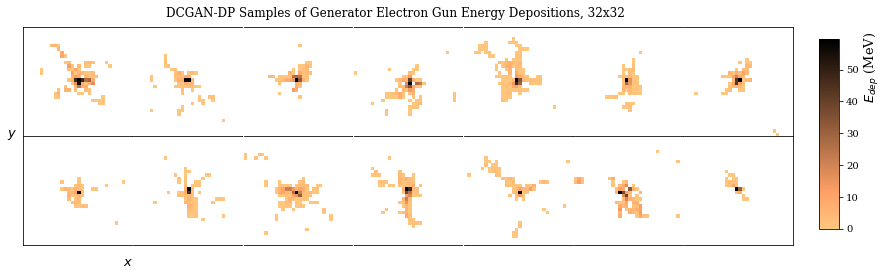

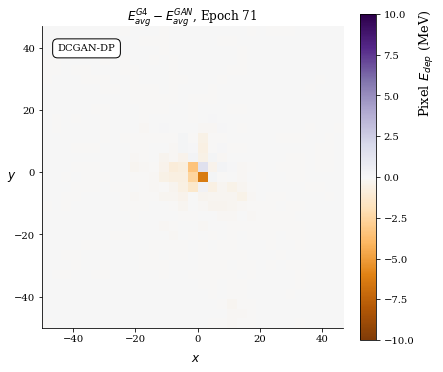

[71/50][0/938] Loss_D: 0.3248 Loss_G: 2.0114 D(x): 0.9289 D(G(z)): 0.2156 / 0.1445
[71/50][100/938] Loss_D: 0.3254 Loss_G: 0.5358 D(x): 0.8055 D(G(z)): 0.0939 / 0.5960
[71/50][200/938] Loss_D: 0.2501 Loss_G: 1.8977 D(x): 0.9097 D(G(z)): 0.1415 / 0.1640
[71/50][300/938] Loss_D: 0.4035 Loss_G: 1.6893 D(x): 0.9424 D(G(z)): 0.2860 / 0.1937
[71/50][400/938] Loss_D: 1.6349 Loss_G: 0.7048 D(x): 0.9747 D(G(z)): 0.7843 / 0.5104
[71/50][500/938] Loss_D: 0.7701 Loss_G: 1.8537 D(x): 0.9818 D(G(z)): 0.5181 / 0.1649
[71/50][600/938] Loss_D: 0.9287 Loss_G: 1.0868 D(x): 0.9701 D(G(z)): 0.5806 / 0.3517
[71/50][700/938] Loss_D: 0.5581 Loss_G: 1.2038 D(x): 0.9346 D(G(z)): 0.3747 / 0.3237
[71/50][800/938] Loss_D: 0.6094 Loss_G: 1.5746 D(x): 0.9548 D(G(z)): 0.4186 / 0.2212
[71/50][900/938] Loss_D: 0.4124 Loss_G: 1.2824 D(x): 0.9304 D(G(z)): 0.2835 / 0.2871
(32, 32)


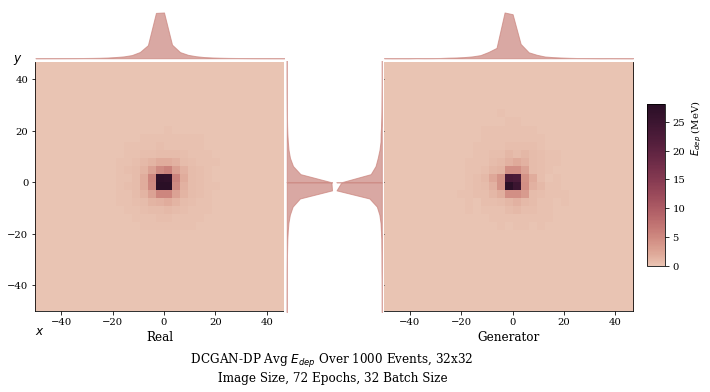

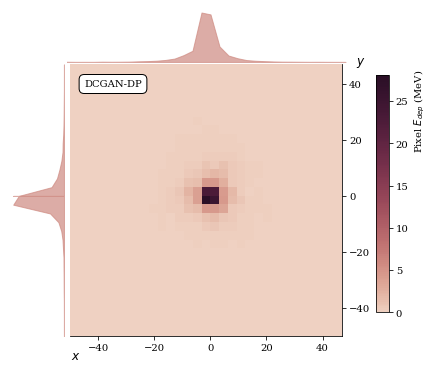

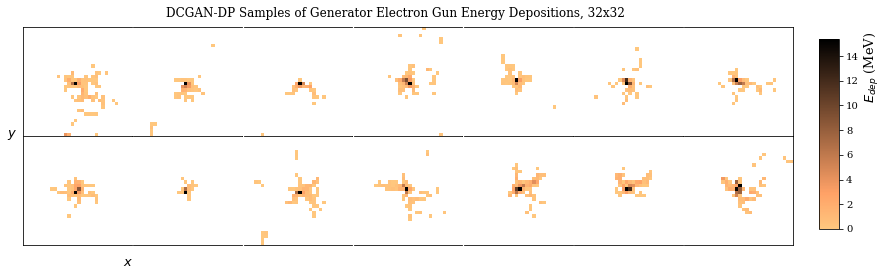

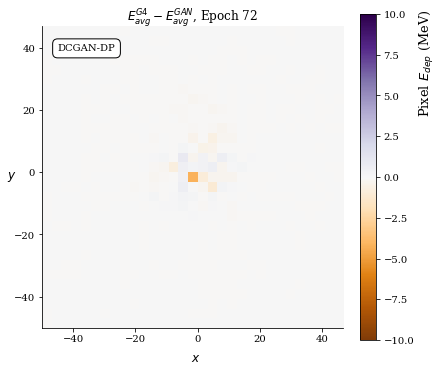

[72/50][0/938] Loss_D: 0.3579 Loss_G: 1.8351 D(x): 0.9540 D(G(z)): 0.2611 / 0.1700
[72/50][100/938] Loss_D: 0.3691 Loss_G: 0.7704 D(x): 0.9168 D(G(z)): 0.2401 / 0.4815
[72/50][200/938] Loss_D: 0.3325 Loss_G: 2.0315 D(x): 0.9575 D(G(z)): 0.2448 / 0.1465
[72/50][300/938] Loss_D: 0.4987 Loss_G: 1.5373 D(x): 0.9488 D(G(z)): 0.3516 / 0.2299
[72/50][400/938] Loss_D: 0.6962 Loss_G: 1.5982 D(x): 0.9629 D(G(z)): 0.4640 / 0.2180
[72/50][500/938] Loss_D: 1.5142 Loss_G: 1.6142 D(x): 0.9728 D(G(z)): 0.7539 / 0.2190
[72/50][600/938] Loss_D: 0.4274 Loss_G: 1.2622 D(x): 0.8684 D(G(z)): 0.2428 / 0.2942
[72/50][700/938] Loss_D: 2.5811 Loss_G: 0.5006 D(x): 0.9782 D(G(z)): 0.9126 / 0.6244
[72/50][800/938] Loss_D: 2.2916 Loss_G: 1.2915 D(x): 0.9926 D(G(z)): 0.8739 / 0.3252
[72/50][900/938] Loss_D: 0.3749 Loss_G: 1.0234 D(x): 0.8893 D(G(z)): 0.2235 / 0.3708
(32, 32)


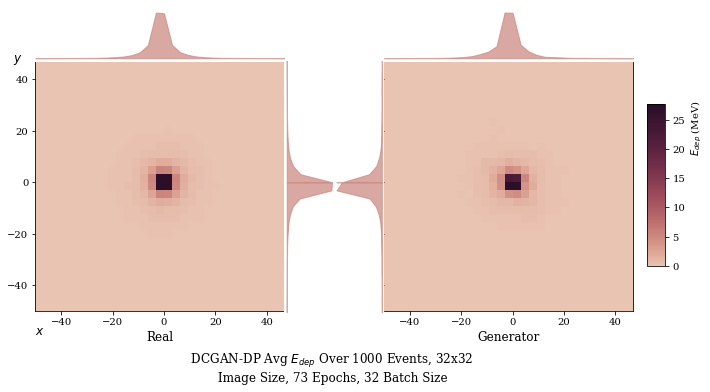

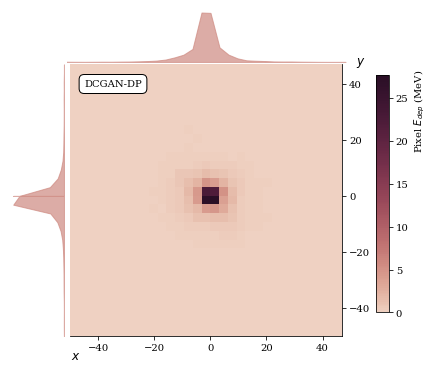

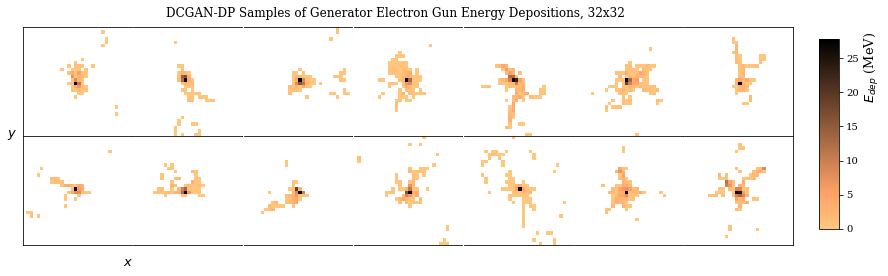

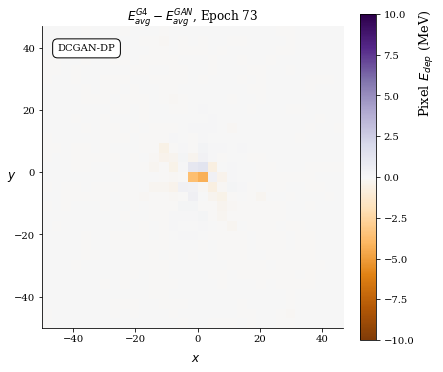

[73/50][0/938] Loss_D: 0.5026 Loss_G: 1.1825 D(x): 0.8202 D(G(z)): 0.2459 / 0.3417
[73/50][100/938] Loss_D: 0.3090 Loss_G: 0.5207 D(x): 0.8564 D(G(z)): 0.1401 / 0.6023
[73/50][200/938] Loss_D: 0.5554 Loss_G: 0.6515 D(x): 0.8408 D(G(z)): 0.3037 / 0.5513
[73/50][300/938] Loss_D: 0.3843 Loss_G: 1.5089 D(x): 0.9379 D(G(z)): 0.2694 / 0.2332
[73/50][400/938] Loss_D: 0.7765 Loss_G: 0.5387 D(x): 0.8578 D(G(z)): 0.4502 / 0.5926
[73/50][500/938] Loss_D: 0.7126 Loss_G: 1.9978 D(x): 0.9517 D(G(z)): 0.4602 / 0.1610
[73/50][600/938] Loss_D: 0.5755 Loss_G: 1.7495 D(x): 0.9701 D(G(z)): 0.4132 / 0.1801
[73/50][700/938] Loss_D: 0.5831 Loss_G: 0.7945 D(x): 0.9385 D(G(z)): 0.3975 / 0.4609
[73/50][800/938] Loss_D: 1.9754 Loss_G: 1.1810 D(x): 0.9815 D(G(z)): 0.8478 / 0.3255
[73/50][900/938] Loss_D: 0.3523 Loss_G: 0.8075 D(x): 0.8625 D(G(z)): 0.1785 / 0.4626
(32, 32)


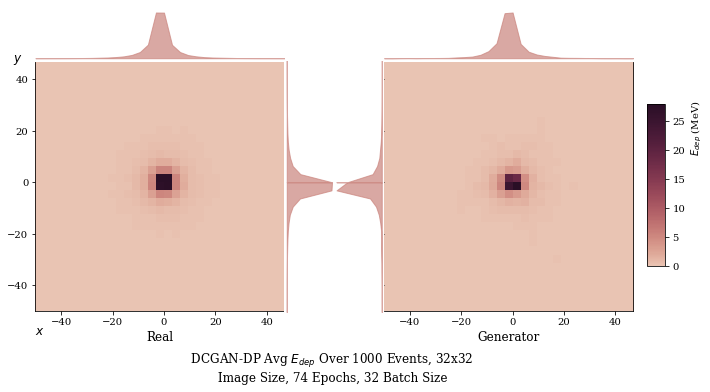

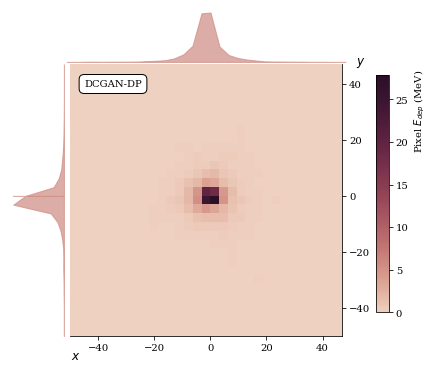

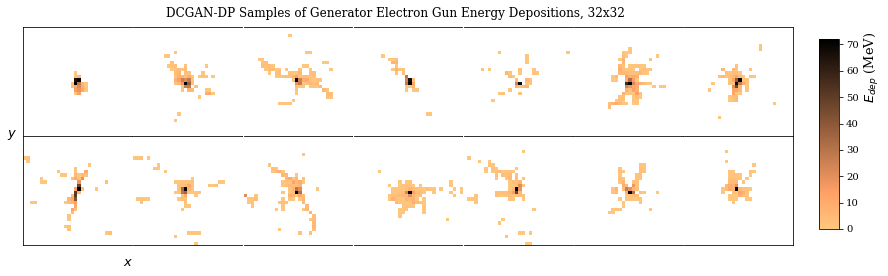

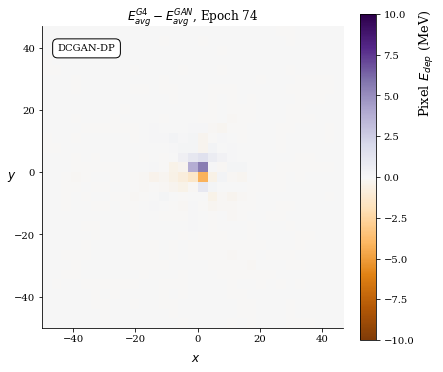

[74/50][0/938] Loss_D: 0.4849 Loss_G: 1.8998 D(x): 0.9793 D(G(z)): 0.3593 / 0.1636
[74/50][100/938] Loss_D: 0.5244 Loss_G: 0.6516 D(x): 0.8996 D(G(z)): 0.3357 / 0.5312
[74/50][200/938] Loss_D: 0.2818 Loss_G: 1.7571 D(x): 0.9464 D(G(z)): 0.1965 / 0.1893
[74/50][300/938] Loss_D: 0.9574 Loss_G: 1.0919 D(x): 0.9444 D(G(z)): 0.5628 / 0.3578
[74/50][400/938] Loss_D: 1.4602 Loss_G: 0.9892 D(x): 0.9890 D(G(z)): 0.7396 / 0.3973
[74/50][500/938] Loss_D: 0.3668 Loss_G: 1.4448 D(x): 0.9298 D(G(z)): 0.2483 / 0.2478
[74/50][600/938] Loss_D: 1.1369 Loss_G: 1.5496 D(x): 0.9814 D(G(z)): 0.6593 / 0.2238
[74/50][700/938] Loss_D: 2.4861 Loss_G: 0.7907 D(x): 0.9939 D(G(z)): 0.8992 / 0.4884
[74/50][800/938] Loss_D: 0.6815 Loss_G: 1.0134 D(x): 0.9496 D(G(z)): 0.4526 / 0.3852
[74/50][900/938] Loss_D: 0.6690 Loss_G: 1.7048 D(x): 0.9563 D(G(z)): 0.4477 / 0.2009
(32, 32)


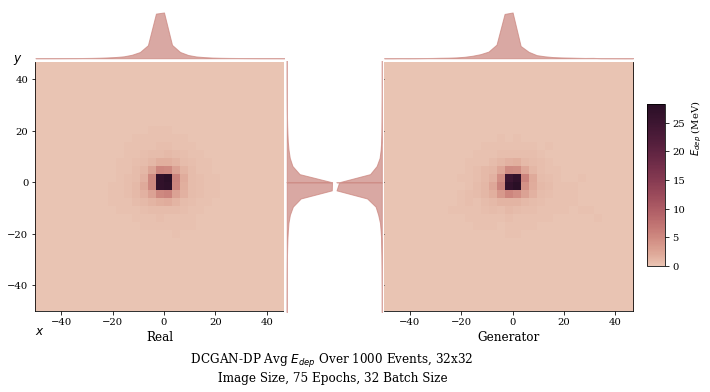

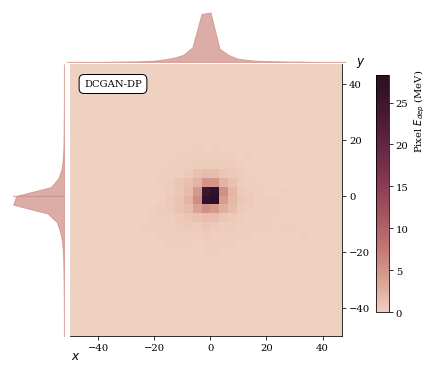

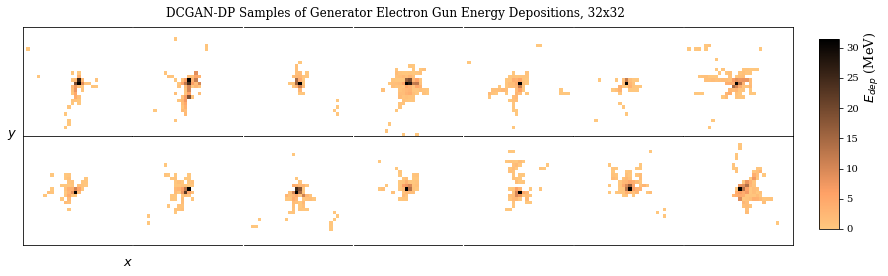

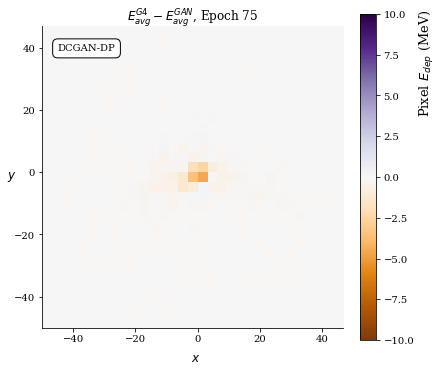

[75/50][0/938] Loss_D: 0.2199 Loss_G: 1.6738 D(x): 0.9059 D(G(z)): 0.1118 / 0.1978
[75/50][100/938] Loss_D: 0.4510 Loss_G: 0.9353 D(x): 0.8972 D(G(z)): 0.2831 / 0.4097
[75/50][200/938] Loss_D: 0.4216 Loss_G: 1.2724 D(x): 0.9026 D(G(z)): 0.2667 / 0.2950
[75/50][300/938] Loss_D: 1.4511 Loss_G: 0.6000 D(x): 0.9927 D(G(z)): 0.7401 / 0.5735
[75/50][400/938] Loss_D: 0.2724 Loss_G: 2.0621 D(x): 0.9720 D(G(z)): 0.2110 / 0.1463
[75/50][500/938] Loss_D: 1.1818 Loss_G: 0.8347 D(x): 0.9954 D(G(z)): 0.6695 / 0.4589
[75/50][600/938] Loss_D: 0.2217 Loss_G: 1.5719 D(x): 0.9047 D(G(z)): 0.1107 / 0.2319
[75/50][700/938] Loss_D: 0.7156 Loss_G: 1.6391 D(x): 0.9492 D(G(z)): 0.4645 / 0.2117
[75/50][800/938] Loss_D: 2.3169 Loss_G: 0.6291 D(x): 0.9856 D(G(z)): 0.8796 / 0.5580
[75/50][900/938] Loss_D: 0.3838 Loss_G: 2.2974 D(x): 0.9616 D(G(z)): 0.2844 / 0.1086
(32, 32)


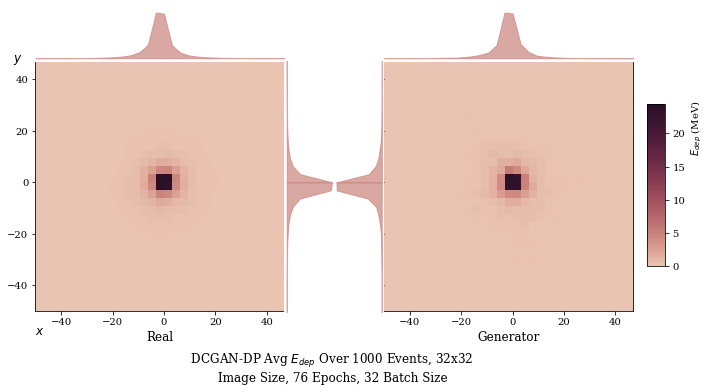

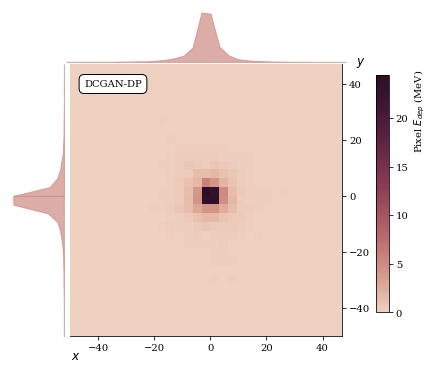

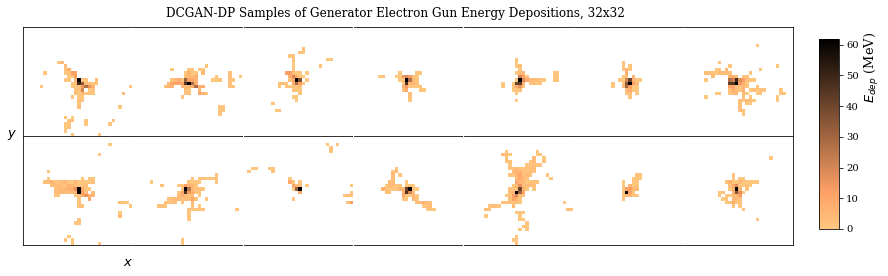

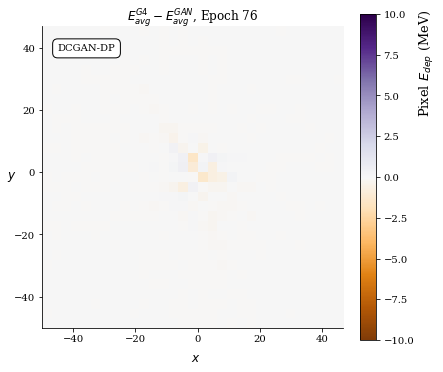

[76/50][0/938] Loss_D: 0.3977 Loss_G: 2.3141 D(x): 0.9655 D(G(z)): 0.2971 / 0.1089
[76/50][100/938] Loss_D: 0.2786 Loss_G: 1.9539 D(x): 0.9573 D(G(z)): 0.2030 / 0.1620
[76/50][200/938] Loss_D: 0.2323 Loss_G: 1.8781 D(x): 0.9249 D(G(z)): 0.1378 / 0.1730
[76/50][300/938] Loss_D: 0.7358 Loss_G: 0.9323 D(x): 0.9360 D(G(z)): 0.4757 / 0.4169
[76/50][400/938] Loss_D: 0.2507 Loss_G: 2.3520 D(x): 0.9574 D(G(z)): 0.1835 / 0.1040
[76/50][500/938] Loss_D: 0.2013 Loss_G: 1.7088 D(x): 0.9118 D(G(z)): 0.1016 / 0.1971
[76/50][600/938] Loss_D: 0.2562 Loss_G: 1.4846 D(x): 0.9887 D(G(z)): 0.2127 / 0.2449
[76/50][700/938] Loss_D: 0.3891 Loss_G: 0.5531 D(x): 0.8484 D(G(z)): 0.1925 / 0.5927
[76/50][800/938] Loss_D: 0.6895 Loss_G: 0.3292 D(x): 0.8084 D(G(z)): 0.3708 / 0.7241
[76/50][900/938] Loss_D: 0.3735 Loss_G: 1.4177 D(x): 0.9530 D(G(z)): 0.2710 / 0.2646
(32, 32)


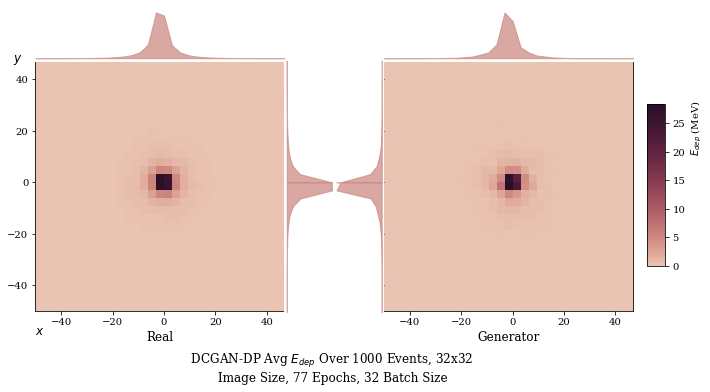

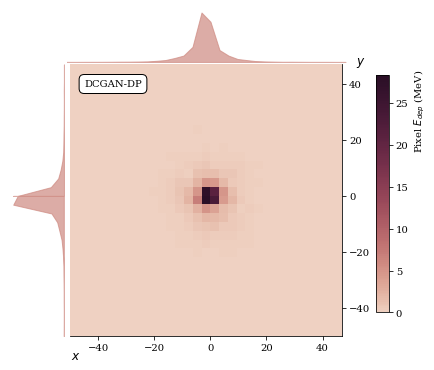

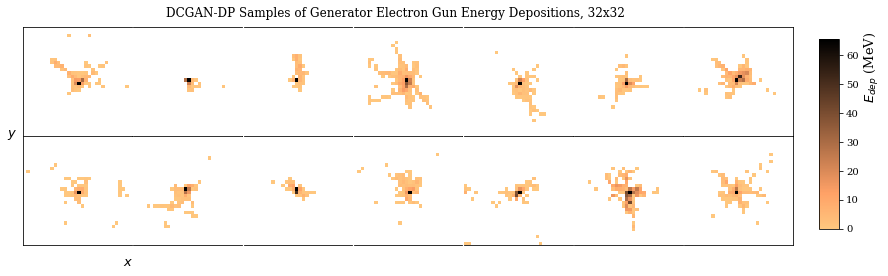

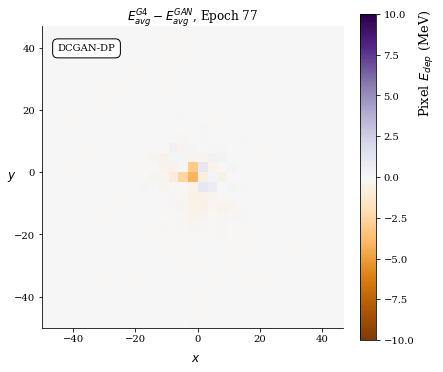

[77/50][0/938] Loss_D: 0.2699 Loss_G: 2.6425 D(x): 0.9771 D(G(z)): 0.2110 / 0.0823
[77/50][100/938] Loss_D: 0.2701 Loss_G: 1.8080 D(x): 0.9126 D(G(z)): 0.1598 / 0.1761
[77/50][200/938] Loss_D: 0.2333 Loss_G: 2.3105 D(x): 0.9561 D(G(z)): 0.1690 / 0.1090
[77/50][300/938] Loss_D: 0.3766 Loss_G: 1.3554 D(x): 0.9560 D(G(z)): 0.2618 / 0.2841
[77/50][400/938] Loss_D: 0.3681 Loss_G: 1.8894 D(x): 0.9186 D(G(z)): 0.2374 / 0.1696
[77/50][500/938] Loss_D: 0.2628 Loss_G: 1.3857 D(x): 0.9209 D(G(z)): 0.1604 / 0.2718
[77/50][600/938] Loss_D: 0.4335 Loss_G: 1.0356 D(x): 0.9406 D(G(z)): 0.2997 / 0.3762
[77/50][700/938] Loss_D: 1.4386 Loss_G: 1.4550 D(x): 0.9877 D(G(z)): 0.7356 / 0.2613
[77/50][800/938] Loss_D: 1.9642 Loss_G: 0.2408 D(x): 0.9968 D(G(z)): 0.8393 / 0.7918
[77/50][900/938] Loss_D: 0.4485 Loss_G: 1.8015 D(x): 0.9683 D(G(z)): 0.3316 / 0.1779
(32, 32)


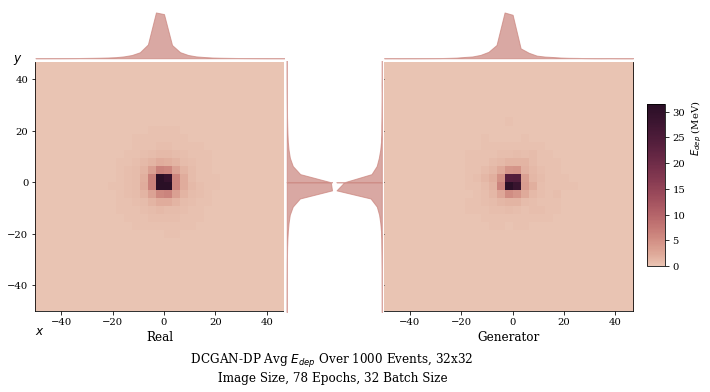

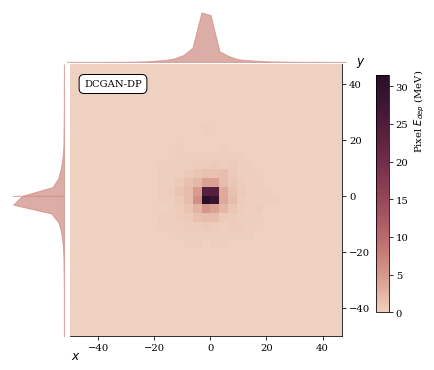

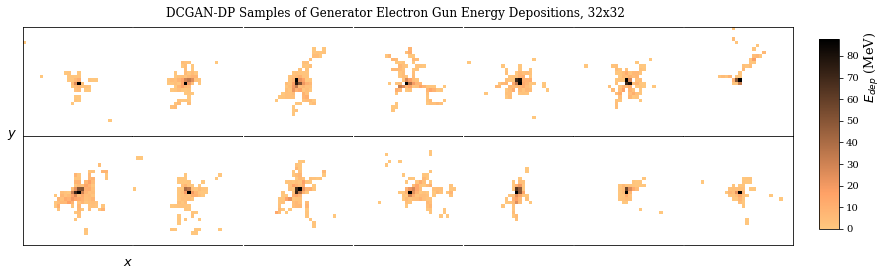

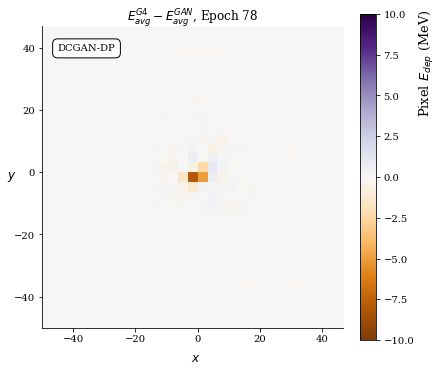

[78/50][0/938] Loss_D: 0.3857 Loss_G: 1.9463 D(x): 0.9764 D(G(z)): 0.2962 / 0.1549
[78/50][100/938] Loss_D: 0.7717 Loss_G: 1.1051 D(x): 0.9427 D(G(z)): 0.4909 / 0.3553
[78/50][200/938] Loss_D: 0.2581 Loss_G: 1.6032 D(x): 0.9106 D(G(z)): 0.1477 / 0.2140
[78/50][300/938] Loss_D: 0.8308 Loss_G: 1.4669 D(x): 0.9804 D(G(z)): 0.5379 / 0.2474
[78/50][400/938] Loss_D: 0.8186 Loss_G: 1.3452 D(x): 0.9851 D(G(z)): 0.5385 / 0.2754
[78/50][500/938] Loss_D: 0.6621 Loss_G: 2.0996 D(x): 0.9845 D(G(z)): 0.4603 / 0.1370
[78/50][600/938] Loss_D: 0.3170 Loss_G: 1.2803 D(x): 0.9304 D(G(z)): 0.2124 / 0.2922
[78/50][700/938] Loss_D: 0.4839 Loss_G: 1.7884 D(x): 0.9837 D(G(z)): 0.3605 / 0.1816
[78/50][800/938] Loss_D: 0.2761 Loss_G: 0.8717 D(x): 0.8402 D(G(z)): 0.0921 / 0.4325
[78/50][900/938] Loss_D: 0.5772 Loss_G: 1.6444 D(x): 0.9559 D(G(z)): 0.3945 / 0.2209
(32, 32)


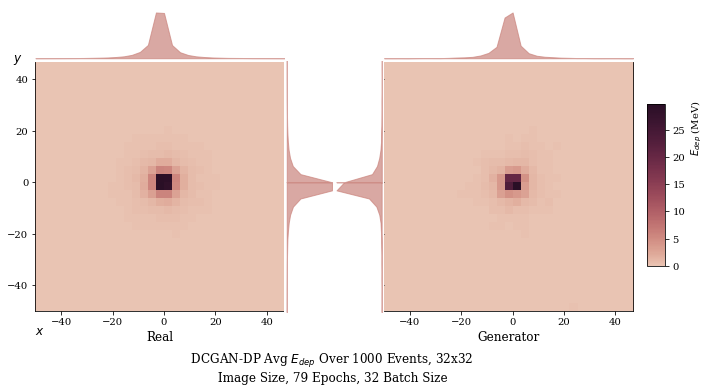

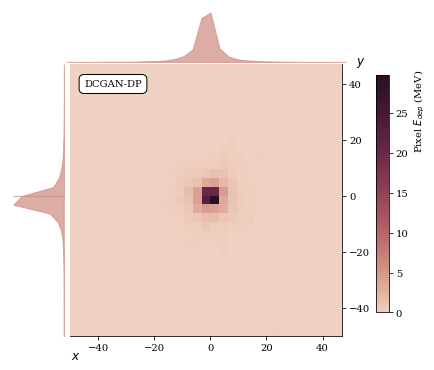

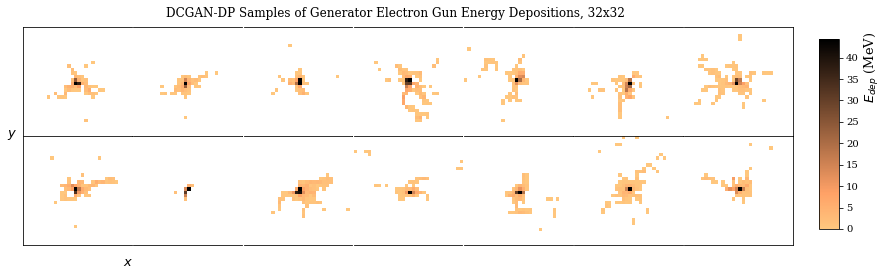

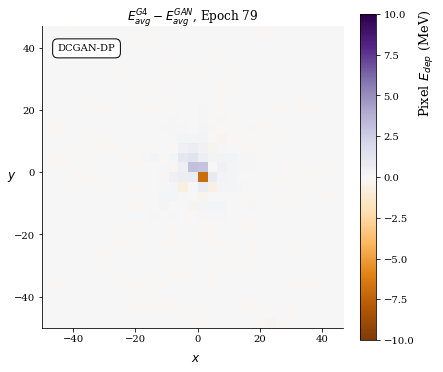

[79/50][0/938] Loss_D: 0.7208 Loss_G: 1.1428 D(x): 0.9911 D(G(z)): 0.4861 / 0.3611
[79/50][100/938] Loss_D: 0.7489 Loss_G: 0.2413 D(x): 0.8673 D(G(z)): 0.4327 / 0.7956
[79/50][200/938] Loss_D: 0.3937 Loss_G: 1.9739 D(x): 0.9876 D(G(z)): 0.3106 / 0.1483
[79/50][300/938] Loss_D: 0.4243 Loss_G: 1.5558 D(x): 0.9494 D(G(z)): 0.3014 / 0.2322
[79/50][400/938] Loss_D: 0.4631 Loss_G: 1.5458 D(x): 0.9804 D(G(z)): 0.3440 / 0.2353
[79/50][500/938] Loss_D: 1.0015 Loss_G: 1.5843 D(x): 0.9539 D(G(z)): 0.5764 / 0.2428
[79/50][600/938] Loss_D: 1.6740 Loss_G: 0.7472 D(x): 0.9963 D(G(z)): 0.7941 / 0.4932
[79/50][700/938] Loss_D: 1.4068 Loss_G: 1.3413 D(x): 0.9947 D(G(z)): 0.7309 / 0.2875
[79/50][800/938] Loss_D: 0.5209 Loss_G: 1.7599 D(x): 0.9781 D(G(z)): 0.3806 / 0.1867
[79/50][900/938] Loss_D: 0.7760 Loss_G: 1.6630 D(x): 0.9858 D(G(z)): 0.5185 / 0.2071
(32, 32)


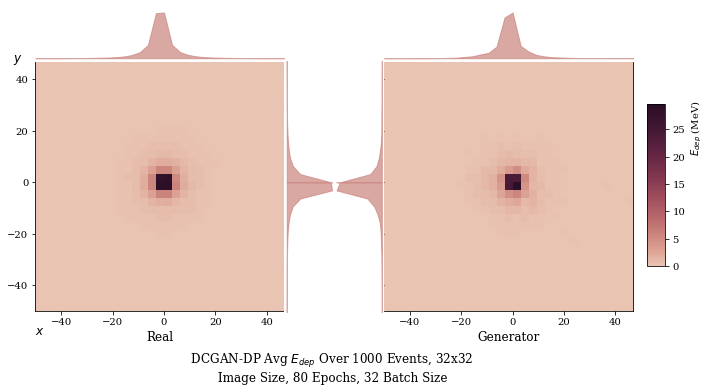

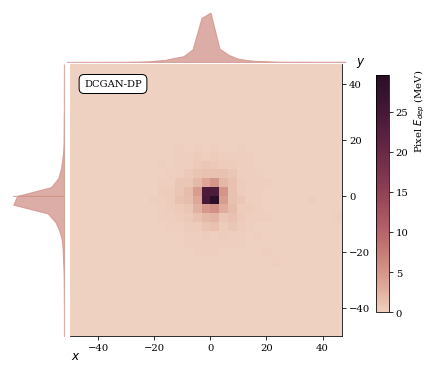

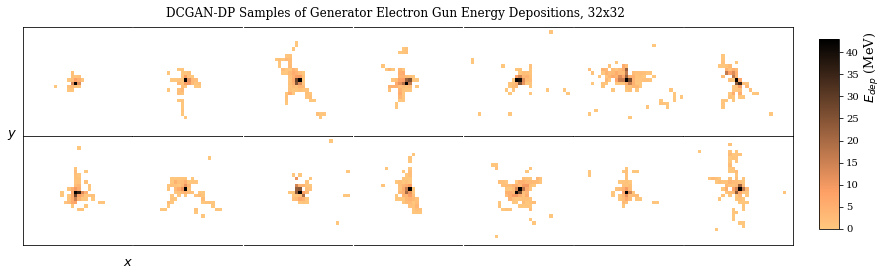

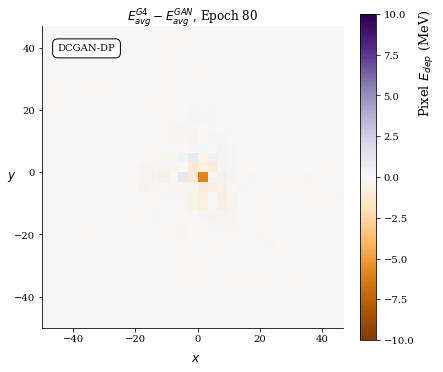

[80/50][0/938] Loss_D: 0.1413 Loss_G: 2.9052 D(x): 0.9684 D(G(z)): 0.1010 / 0.0703
[80/50][100/938] Loss_D: 0.2368 Loss_G: 1.9672 D(x): 0.9693 D(G(z)): 0.1824 / 0.1483
[80/50][200/938] Loss_D: 0.2075 Loss_G: 1.6943 D(x): 0.9384 D(G(z)): 0.1315 / 0.1952
[80/50][300/938] Loss_D: 1.1048 Loss_G: 1.1365 D(x): 0.9841 D(G(z)): 0.6450 / 0.3396
[80/50][400/938] Loss_D: 0.4179 Loss_G: 1.0919 D(x): 0.9870 D(G(z)): 0.3151 / 0.3641
[80/50][500/938] Loss_D: 1.3228 Loss_G: 1.3407 D(x): 0.9844 D(G(z)): 0.7066 / 0.2864
[80/50][600/938] Loss_D: 0.1255 Loss_G: 2.1722 D(x): 0.9257 D(G(z)): 0.0462 / 0.1245
[80/50][700/938] Loss_D: 0.1842 Loss_G: 1.9303 D(x): 0.9308 D(G(z)): 0.1038 / 0.1642
[80/50][800/938] Loss_D: 0.3321 Loss_G: 0.6091 D(x): 0.8404 D(G(z)): 0.1401 / 0.5537
[80/50][900/938] Loss_D: 0.6084 Loss_G: 1.1944 D(x): 0.9315 D(G(z)): 0.3988 / 0.3295
(32, 32)


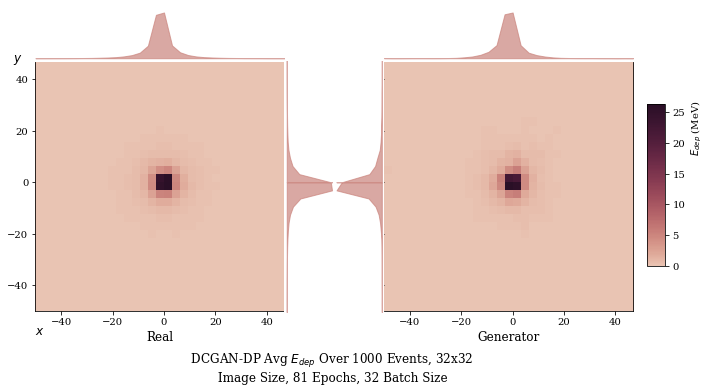

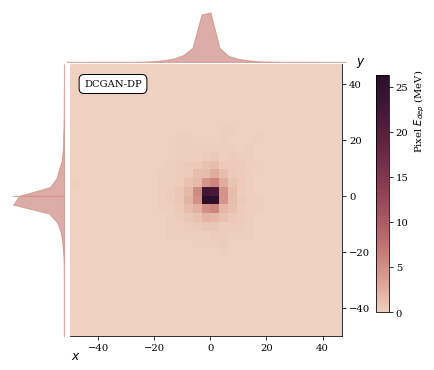

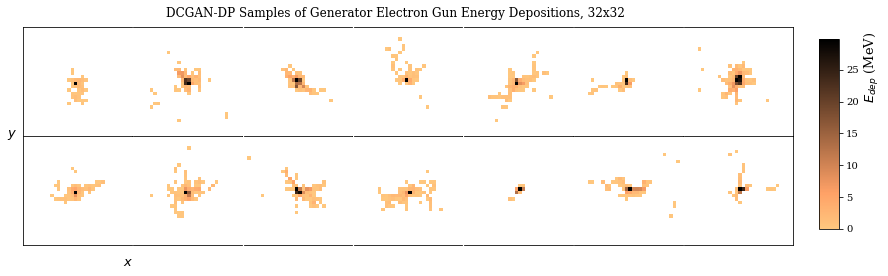

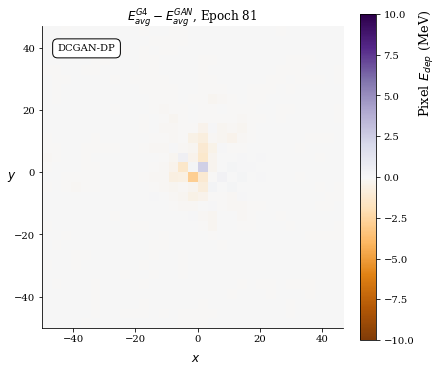

[81/50][0/938] Loss_D: 0.7366 Loss_G: 2.0261 D(x): 0.9598 D(G(z)): 0.4837 / 0.1483
[81/50][100/938] Loss_D: 0.2243 Loss_G: 2.3718 D(x): 0.9386 D(G(z)): 0.1455 / 0.1040
[81/50][200/938] Loss_D: 0.1593 Loss_G: 1.8179 D(x): 0.9022 D(G(z)): 0.0521 / 0.1898
[81/50][300/938] Loss_D: 0.5918 Loss_G: 0.9026 D(x): 0.6174 D(G(z)): 0.0481 / 0.4552
[81/50][400/938] Loss_D: 0.9075 Loss_G: 1.2805 D(x): 0.9640 D(G(z)): 0.5652 / 0.2929
[81/50][500/938] Loss_D: 0.2244 Loss_G: 1.7113 D(x): 0.9497 D(G(z)): 0.1553 / 0.1969
[81/50][600/938] Loss_D: 0.2790 Loss_G: 1.1946 D(x): 0.7855 D(G(z)): 0.0288 / 0.3284
[81/50][700/938] Loss_D: 0.4657 Loss_G: 1.0534 D(x): 0.9263 D(G(z)): 0.3089 / 0.3749
[81/50][800/938] Loss_D: 0.9566 Loss_G: 1.3486 D(x): 0.9776 D(G(z)): 0.5858 / 0.2846
[81/50][900/938] Loss_D: 0.7377 Loss_G: 1.2873 D(x): 0.9886 D(G(z)): 0.4967 / 0.3039
(32, 32)


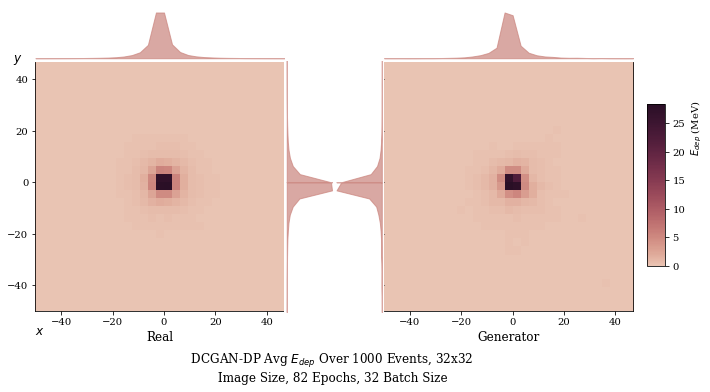

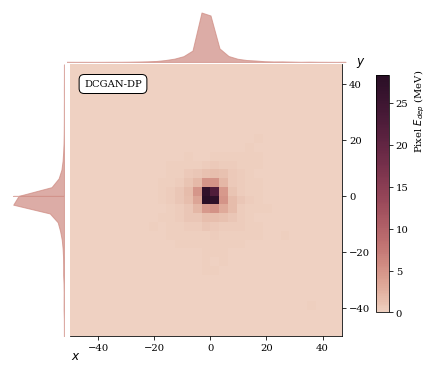

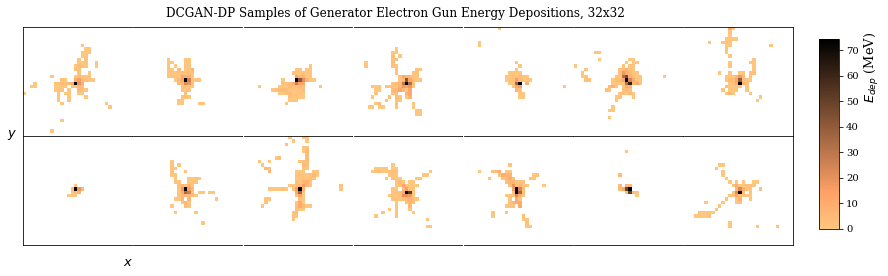

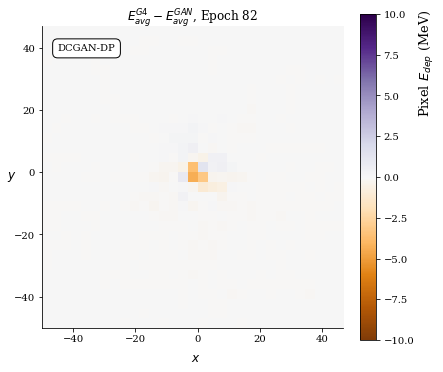

[82/50][0/938] Loss_D: 0.2215 Loss_G: 2.1635 D(x): 0.9684 D(G(z)): 0.1688 / 0.1272
[82/50][100/938] Loss_D: 0.5805 Loss_G: 1.4343 D(x): 0.9710 D(G(z)): 0.4092 / 0.2525
[82/50][200/938] Loss_D: 0.3236 Loss_G: 0.8288 D(x): 0.8859 D(G(z)): 0.1754 / 0.4749
[82/50][300/938] Loss_D: 0.6567 Loss_G: 1.3990 D(x): 0.9620 D(G(z)): 0.4442 / 0.2699
[82/50][400/938] Loss_D: 1.1702 Loss_G: 0.9547 D(x): 0.9711 D(G(z)): 0.6568 / 0.4028
[82/50][500/938] Loss_D: 0.3658 Loss_G: 1.9131 D(x): 0.9594 D(G(z)): 0.2646 / 0.1667
[82/50][600/938] Loss_D: 0.1453 Loss_G: 2.6261 D(x): 0.9708 D(G(z)): 0.1065 / 0.0876
[82/50][700/938] Loss_D: 0.2946 Loss_G: 2.2025 D(x): 0.9824 D(G(z)): 0.2357 / 0.1254
[82/50][800/938] Loss_D: 1.2535 Loss_G: 1.2441 D(x): 0.9888 D(G(z)): 0.6885 / 0.3074
[82/50][900/938] Loss_D: 0.2424 Loss_G: 2.3857 D(x): 0.9778 D(G(z)): 0.1951 / 0.0983
(32, 32)


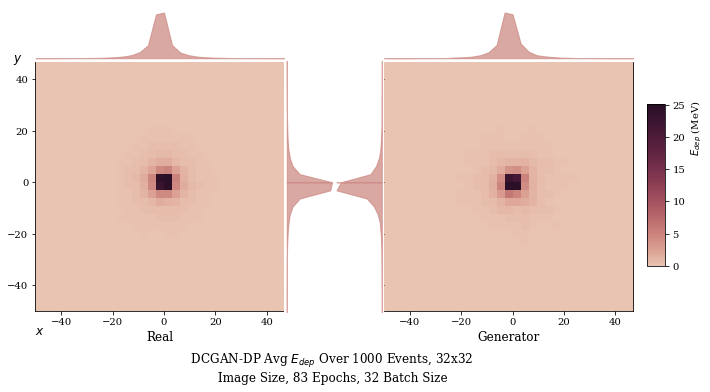

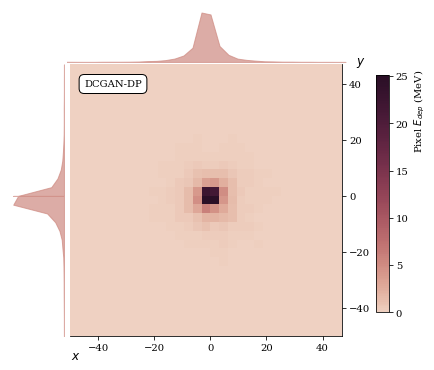

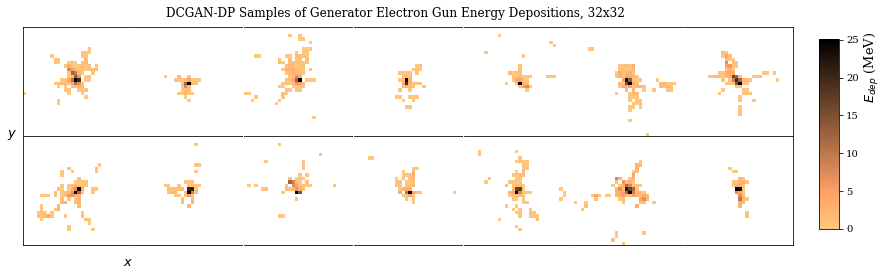

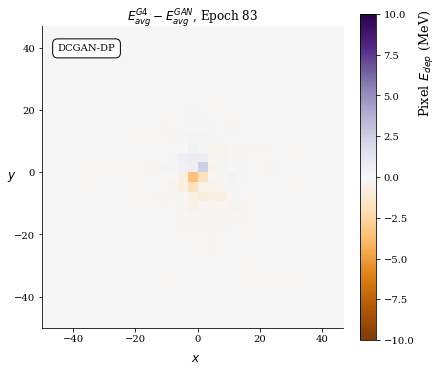

[83/50][0/938] Loss_D: 0.5626 Loss_G: 1.5966 D(x): 0.9585 D(G(z)): 0.3891 / 0.2253
[83/50][100/938] Loss_D: 0.7077 Loss_G: 1.5250 D(x): 0.9726 D(G(z)): 0.4769 / 0.2449
[83/50][200/938] Loss_D: 0.1234 Loss_G: 1.7384 D(x): 0.9143 D(G(z)): 0.0320 / 0.1945
[83/50][300/938] Loss_D: 0.3010 Loss_G: 1.5063 D(x): 0.9586 D(G(z)): 0.2221 / 0.2372
[83/50][400/938] Loss_D: 0.9436 Loss_G: 1.0284 D(x): 0.9670 D(G(z)): 0.5776 / 0.3781
[83/50][500/938] Loss_D: 0.2169 Loss_G: 0.5677 D(x): 0.8411 D(G(z)): 0.0385 / 0.6214
[83/50][600/938] Loss_D: 0.5208 Loss_G: 0.9386 D(x): 0.9965 D(G(z)): 0.3926 / 0.4088
[83/50][700/938] Loss_D: 0.5092 Loss_G: 1.5413 D(x): 0.9670 D(G(z)): 0.3635 / 0.2372
[83/50][800/938] Loss_D: 1.1737 Loss_G: 0.9138 D(x): 0.9509 D(G(z)): 0.6593 / 0.4168
[83/50][900/938] Loss_D: 0.2774 Loss_G: 0.6808 D(x): 0.8608 D(G(z)): 0.1120 / 0.5330
(32, 32)


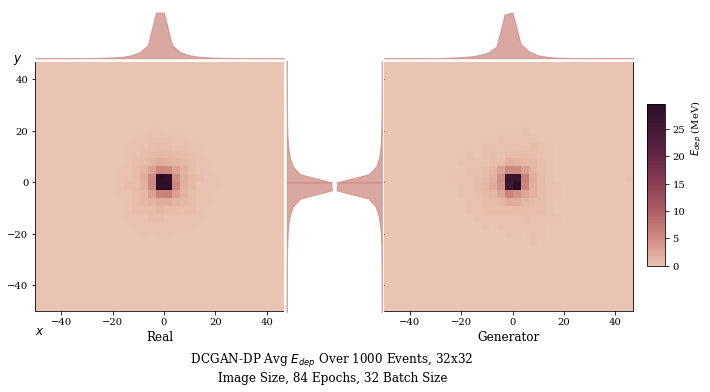

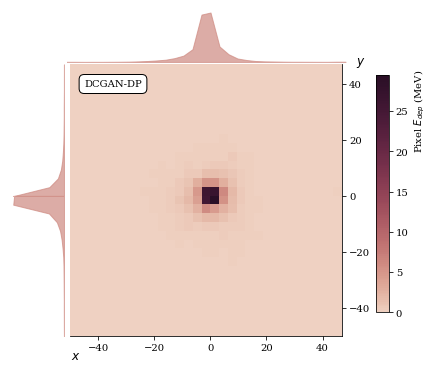

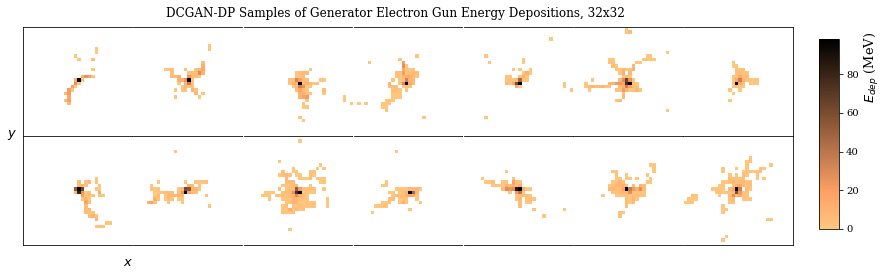

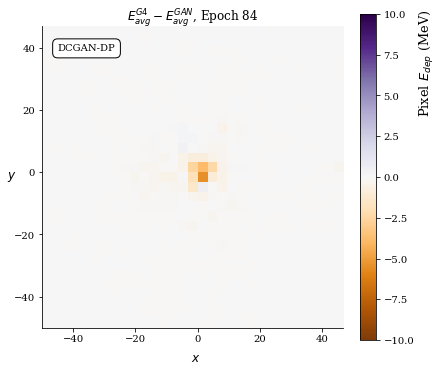

[84/50][0/938] Loss_D: 0.4972 Loss_G: 1.6269 D(x): 0.9754 D(G(z)): 0.3626 / 0.2181
[84/50][100/938] Loss_D: 0.5692 Loss_G: 1.0627 D(x): 0.9434 D(G(z)): 0.3901 / 0.3614
[84/50][200/938] Loss_D: 0.7981 Loss_G: 2.1539 D(x): 0.9893 D(G(z)): 0.5240 / 0.1323
[84/50][300/938] Loss_D: 0.2445 Loss_G: 1.8426 D(x): 0.9437 D(G(z)): 0.1674 / 0.1720
[84/50][400/938] Loss_D: 0.3987 Loss_G: 1.1468 D(x): 0.9739 D(G(z)): 0.3010 / 0.3331
[84/50][500/938] Loss_D: 0.3595 Loss_G: 2.0642 D(x): 0.9741 D(G(z)): 0.2773 / 0.1371
[84/50][600/938] Loss_D: 0.9096 Loss_G: 1.2351 D(x): 0.9509 D(G(z)): 0.5548 / 0.3084
[84/50][700/938] Loss_D: 2.1371 Loss_G: 1.1937 D(x): 0.9979 D(G(z)): 0.8601 / 0.3418
[84/50][800/938] Loss_D: 1.9911 Loss_G: 1.1651 D(x): 0.9725 D(G(z)): 0.8440 / 0.3318
[84/50][900/938] Loss_D: 0.2136 Loss_G: 2.4299 D(x): 0.9671 D(G(z)): 0.1620 / 0.0983
(32, 32)


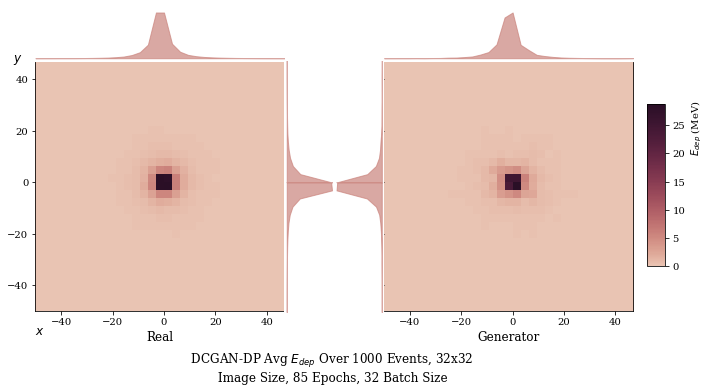

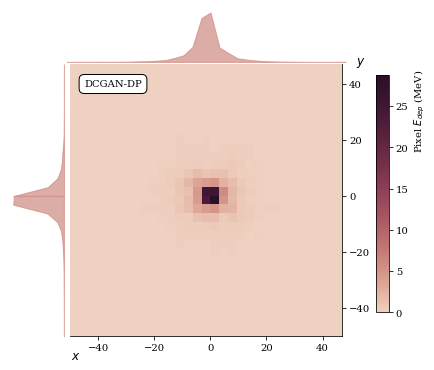

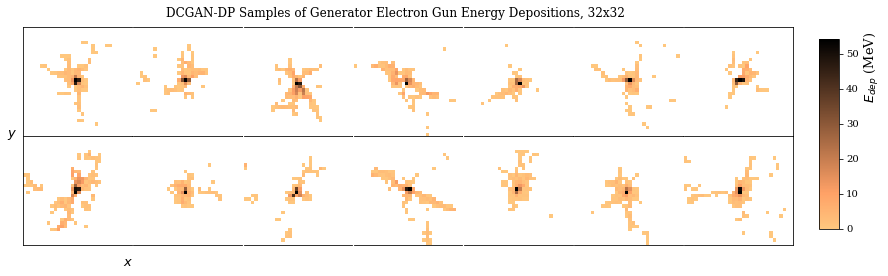

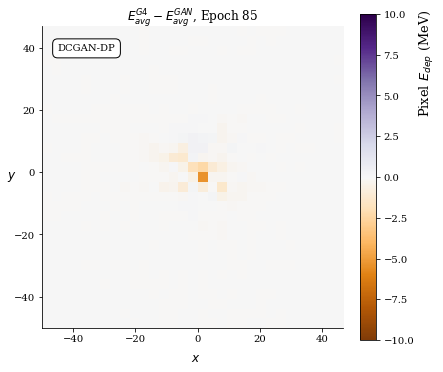

[85/50][0/938] Loss_D: 0.3995 Loss_G: 1.3889 D(x): 0.9441 D(G(z)): 0.2828 / 0.2685
[85/50][100/938] Loss_D: 0.7979 Loss_G: 2.4004 D(x): 0.9854 D(G(z)): 0.5198 / 0.1055
[85/50][200/938] Loss_D: 0.9688 Loss_G: 1.2830 D(x): 0.9890 D(G(z)): 0.6038 / 0.2885
[85/50][300/938] Loss_D: 0.5786 Loss_G: 1.6288 D(x): 0.9537 D(G(z)): 0.4002 / 0.2076
[85/50][400/938] Loss_D: 0.3647 Loss_G: 1.4866 D(x): 0.9771 D(G(z)): 0.2775 / 0.2520
[85/50][500/938] Loss_D: 0.4291 Loss_G: 2.3987 D(x): 0.9819 D(G(z)): 0.3258 / 0.1020
[85/50][600/938] Loss_D: 0.3700 Loss_G: 1.2688 D(x): 0.9944 D(G(z)): 0.2966 / 0.3060
[85/50][700/938] Loss_D: 0.2906 Loss_G: 1.4880 D(x): 0.9650 D(G(z)): 0.2209 / 0.2523
[85/50][800/938] Loss_D: 0.8520 Loss_G: 2.0052 D(x): 0.9800 D(G(z)): 0.5369 / 0.1575
[85/50][900/938] Loss_D: 0.4643 Loss_G: 2.1750 D(x): 0.9602 D(G(z)): 0.3281 / 0.1298
(32, 32)


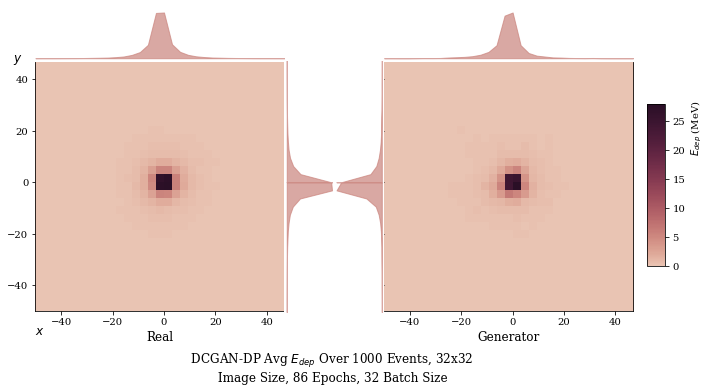

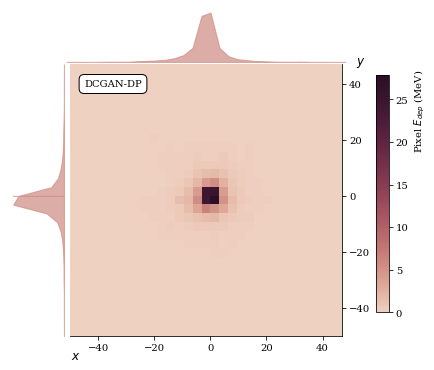

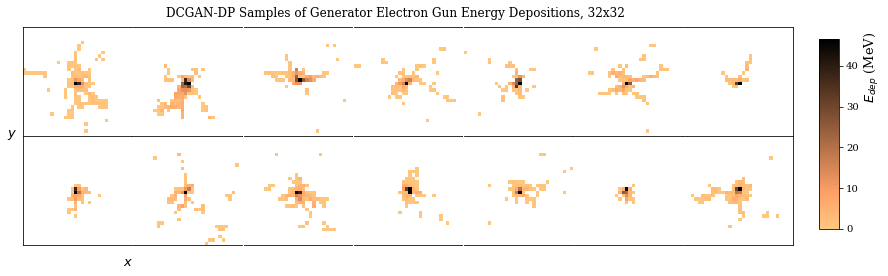

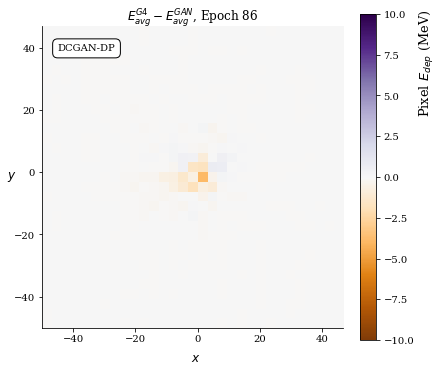

[86/50][0/938] Loss_D: 0.1952 Loss_G: 2.3646 D(x): 0.9731 D(G(z)): 0.1520 / 0.1028
[86/50][100/938] Loss_D: 0.9745 Loss_G: 1.3863 D(x): 0.9529 D(G(z)): 0.5808 / 0.2726
[86/50][200/938] Loss_D: 0.2474 Loss_G: 0.5816 D(x): 0.8716 D(G(z)): 0.1011 / 0.5722
[86/50][300/938] Loss_D: 0.5847 Loss_G: 1.6181 D(x): 0.9830 D(G(z)): 0.4229 / 0.2115
[86/50][400/938] Loss_D: 0.1433 Loss_G: 1.7589 D(x): 0.9190 D(G(z)): 0.0554 / 0.1910
[86/50][500/938] Loss_D: 0.6391 Loss_G: 1.7115 D(x): 0.9723 D(G(z)): 0.4388 / 0.2054
[86/50][600/938] Loss_D: 0.2222 Loss_G: 1.2758 D(x): 0.8625 D(G(z)): 0.0678 / 0.3019
[86/50][700/938] Loss_D: 0.7916 Loss_G: 0.7836 D(x): 0.9306 D(G(z)): 0.4963 / 0.4724
[86/50][800/938] Loss_D: 0.4029 Loss_G: 1.2917 D(x): 0.9821 D(G(z)): 0.2994 / 0.3025
[86/50][900/938] Loss_D: 0.4361 Loss_G: 1.7373 D(x): 0.9553 D(G(z)): 0.3073 / 0.2037
(32, 32)


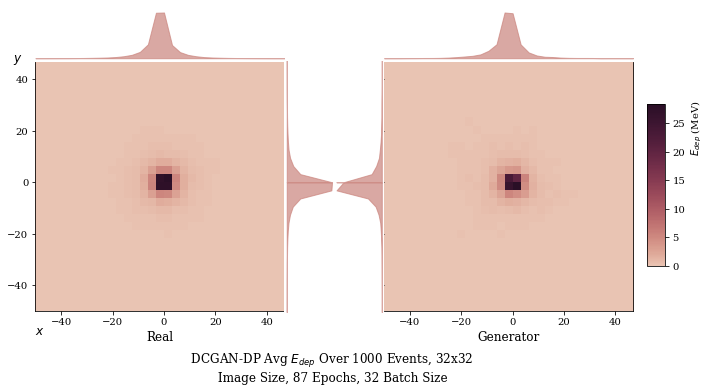

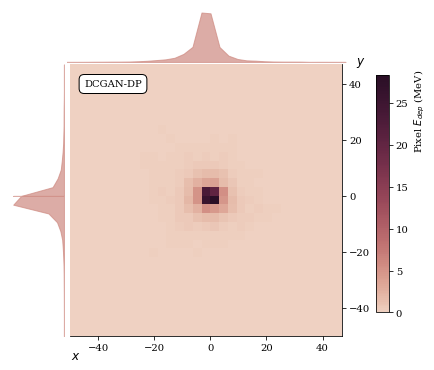

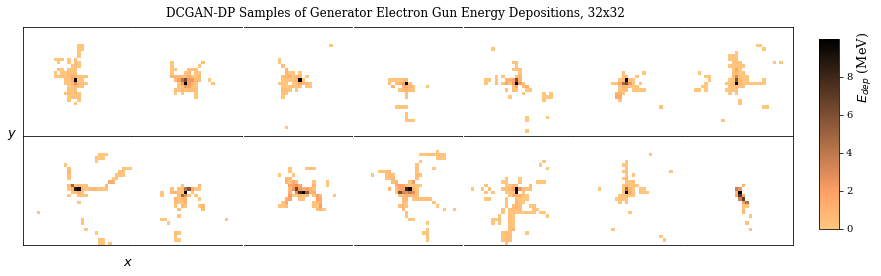

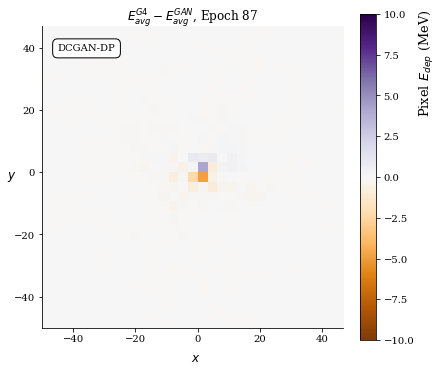

[87/50][0/938] Loss_D: 1.5400 Loss_G: 0.4421 D(x): 0.9976 D(G(z)): 0.7657 / 0.6595
[87/50][100/938] Loss_D: 0.3006 Loss_G: 0.0712 D(x): 0.8407 D(G(z)): 0.1128 / 0.9326
[87/50][200/938] Loss_D: 2.5353 Loss_G: 1.0480 D(x): 0.9992 D(G(z)): 0.9010 / 0.3868
[87/50][300/938] Loss_D: 0.5964 Loss_G: 1.1449 D(x): 0.9796 D(G(z)): 0.4212 / 0.3431
[87/50][400/938] Loss_D: 0.3247 Loss_G: 1.3683 D(x): 0.9489 D(G(z)): 0.2300 / 0.2763
[87/50][500/938] Loss_D: 2.9395 Loss_G: 0.1839 D(x): 0.9995 D(G(z)): 0.9333 / 0.8456
[87/50][600/938] Loss_D: 0.1583 Loss_G: 1.6808 D(x): 0.9440 D(G(z)): 0.0946 / 0.1996
[87/50][700/938] Loss_D: 0.3961 Loss_G: 1.4990 D(x): 0.9587 D(G(z)): 0.2896 / 0.2443
[87/50][800/938] Loss_D: 0.2276 Loss_G: 2.7706 D(x): 0.9853 D(G(z)): 0.1880 / 0.0718
[87/50][900/938] Loss_D: 0.6363 Loss_G: 1.3404 D(x): 0.9880 D(G(z)): 0.4483 / 0.2872
(32, 32)


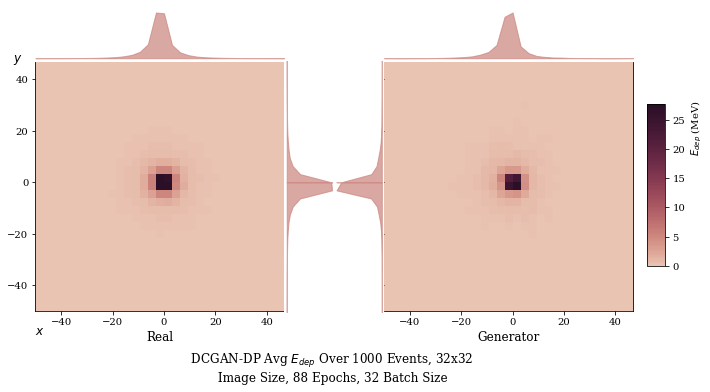

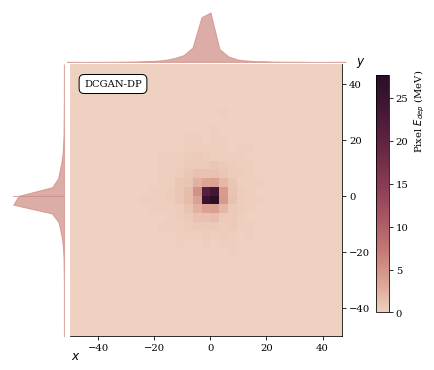

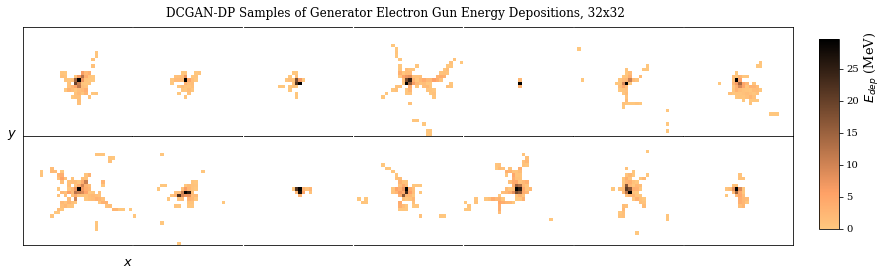

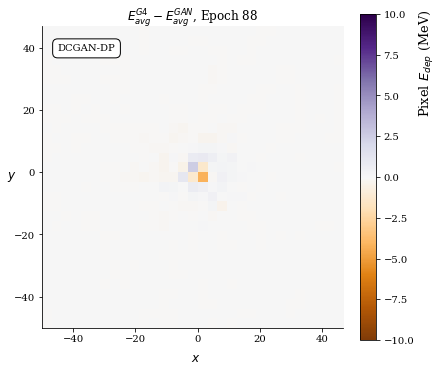

[88/50][0/938] Loss_D: 0.2732 Loss_G: 1.9356 D(x): 0.9499 D(G(z)): 0.1936 / 0.1666
[88/50][100/938] Loss_D: 3.1618 Loss_G: 0.7999 D(x): 0.9993 D(G(z)): 0.9411 / 0.4899
[88/50][200/938] Loss_D: 0.1140 Loss_G: 2.4781 D(x): 0.9817 D(G(z)): 0.0901 / 0.0928
[88/50][300/938] Loss_D: 0.2835 Loss_G: 1.9468 D(x): 0.9795 D(G(z)): 0.2260 / 0.1572
[88/50][400/938] Loss_D: 0.6804 Loss_G: 0.8361 D(x): 0.9592 D(G(z)): 0.4570 / 0.4516
[88/50][500/938] Loss_D: 0.6036 Loss_G: 1.8397 D(x): 0.9804 D(G(z)): 0.4157 / 0.1904
[88/50][600/938] Loss_D: 0.1193 Loss_G: 2.9280 D(x): 0.9822 D(G(z)): 0.0942 / 0.0657
[88/50][700/938] Loss_D: 0.6780 Loss_G: 1.3467 D(x): 0.9670 D(G(z)): 0.4553 / 0.2866
[88/50][800/938] Loss_D: 1.1073 Loss_G: 1.0521 D(x): 0.9603 D(G(z)): 0.6345 / 0.3682
[88/50][900/938] Loss_D: 0.1714 Loss_G: 1.3765 D(x): 0.9103 D(G(z)): 0.0720 / 0.2666
(32, 32)


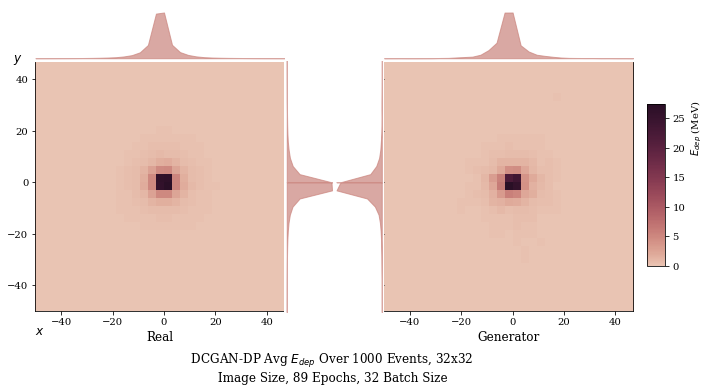

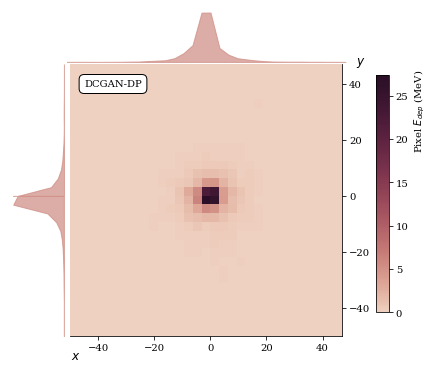

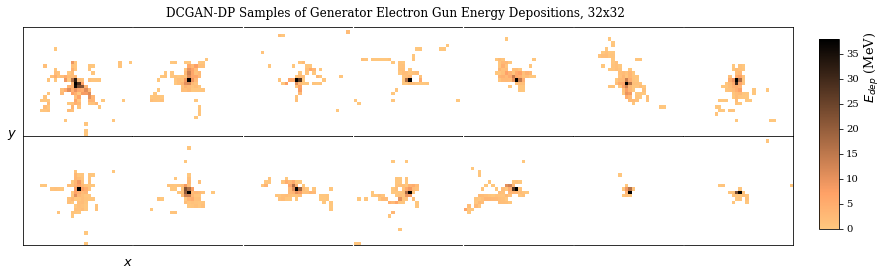

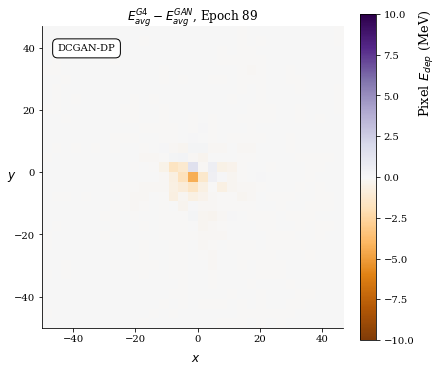

[89/50][0/938] Loss_D: 0.1411 Loss_G: 2.8562 D(x): 0.9712 D(G(z)): 0.1042 / 0.0693
[89/50][100/938] Loss_D: 0.1933 Loss_G: 2.1108 D(x): 0.9818 D(G(z)): 0.1574 / 0.1338
[89/50][200/938] Loss_D: 0.6952 Loss_G: 1.7766 D(x): 0.9845 D(G(z)): 0.4667 / 0.1943
[89/50][300/938] Loss_D: 1.1906 Loss_G: 0.6292 D(x): 0.9943 D(G(z)): 0.6737 / 0.5480
[89/50][400/938] Loss_D: 0.3401 Loss_G: 1.5280 D(x): 0.9573 D(G(z)): 0.2511 / 0.2283
[89/50][500/938] Loss_D: 0.2765 Loss_G: 2.5530 D(x): 0.9837 D(G(z)): 0.2224 / 0.0903
[89/50][600/938] Loss_D: 0.5136 Loss_G: 1.6765 D(x): 0.9858 D(G(z)): 0.3852 / 0.1968
[89/50][700/938] Loss_D: 0.2101 Loss_G: 0.8265 D(x): 0.8752 D(G(z)): 0.0699 / 0.4967
[89/50][800/938] Loss_D: 0.7541 Loss_G: 1.0044 D(x): 0.9617 D(G(z)): 0.4869 / 0.3894
[89/50][900/938] Loss_D: 0.2204 Loss_G: 0.5162 D(x): 0.8989 D(G(z)): 0.0978 / 0.6194
(32, 32)


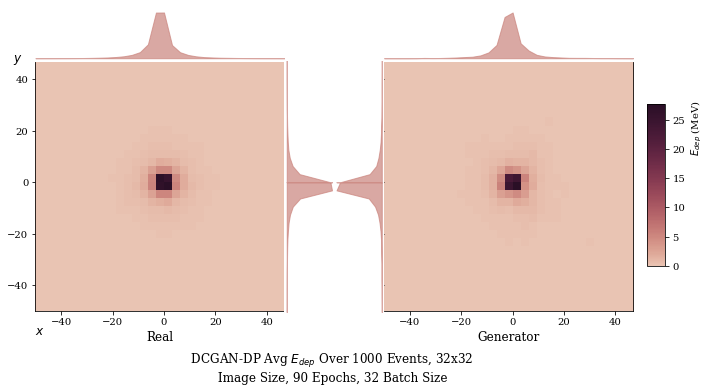

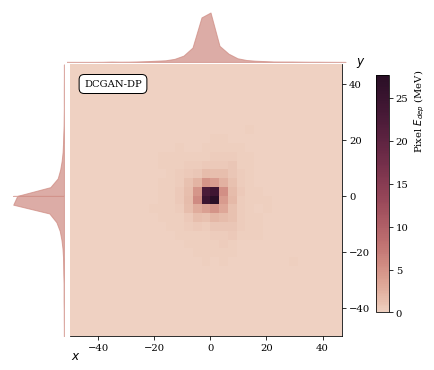

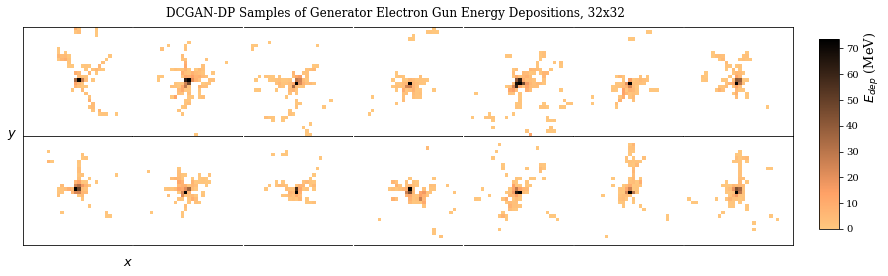

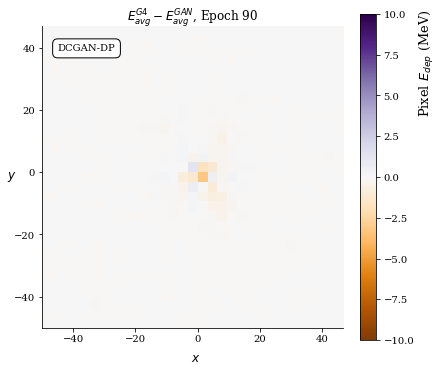

[90/50][0/938] Loss_D: 0.4655 Loss_G: 2.5514 D(x): 0.9986 D(G(z)): 0.3441 / 0.0896
[90/50][100/938] Loss_D: 0.6480 Loss_G: 1.1340 D(x): 0.9802 D(G(z)): 0.4498 / 0.3475
[90/50][200/938] Loss_D: 0.4302 Loss_G: 0.4745 D(x): 0.9087 D(G(z)): 0.2784 / 0.6327
[90/50][300/938] Loss_D: 0.1588 Loss_G: 1.9382 D(x): 0.9215 D(G(z)): 0.0725 / 0.1636
[90/50][400/938] Loss_D: 0.1867 Loss_G: 2.0028 D(x): 0.9437 D(G(z)): 0.1180 / 0.1576
[90/50][500/938] Loss_D: 1.0286 Loss_G: 1.9678 D(x): 0.9892 D(G(z)): 0.6125 / 0.1592
[90/50][600/938] Loss_D: 0.1674 Loss_G: 2.1849 D(x): 0.9480 D(G(z)): 0.1057 / 0.1268
[90/50][700/938] Loss_D: 0.1726 Loss_G: 2.9015 D(x): 0.9586 D(G(z)): 0.1178 / 0.0672
[90/50][800/938] Loss_D: 4.1516 Loss_G: 0.0271 D(x): 0.9996 D(G(z)): 0.9797 / 0.9736
[90/50][900/938] Loss_D: 0.1222 Loss_G: 3.0486 D(x): 0.9671 D(G(z)): 0.0838 / 0.0548
(32, 32)


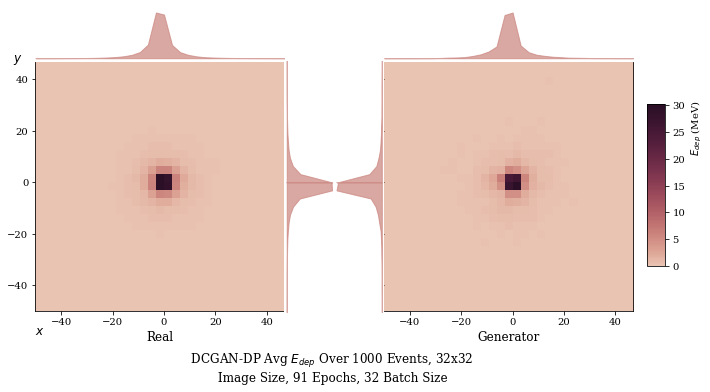

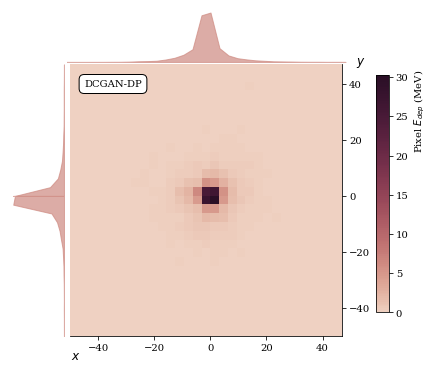

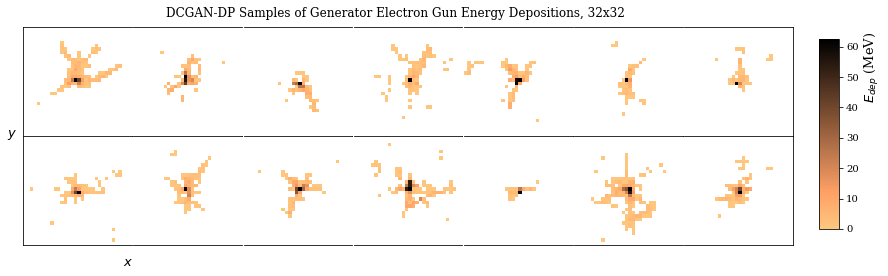

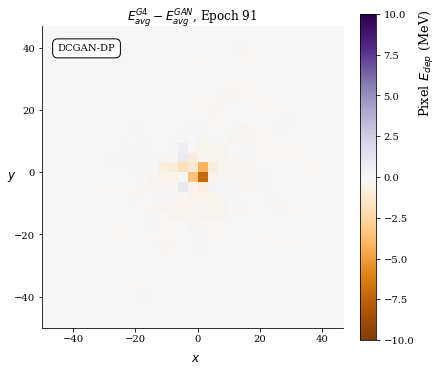

[91/50][0/938] Loss_D: 0.8711 Loss_G: 1.8538 D(x): 0.9849 D(G(z)): 0.5521 / 0.1752
[91/50][100/938] Loss_D: 0.1927 Loss_G: 1.1883 D(x): 0.9255 D(G(z)): 0.1062 / 0.3253
[91/50][200/938] Loss_D: 0.5807 Loss_G: 1.3703 D(x): 0.9763 D(G(z)): 0.4174 / 0.2665
[91/50][300/938] Loss_D: 0.2852 Loss_G: 2.0652 D(x): 0.9820 D(G(z)): 0.2266 / 0.1480
[91/50][400/938] Loss_D: 0.2883 Loss_G: 1.3966 D(x): 0.9519 D(G(z)): 0.2034 / 0.2645
[91/50][500/938] Loss_D: 0.7147 Loss_G: 1.2968 D(x): 0.9705 D(G(z)): 0.4728 / 0.3068
[91/50][600/938] Loss_D: 0.1940 Loss_G: 2.3145 D(x): 0.9846 D(G(z)): 0.1587 / 0.1138
[91/50][700/938] Loss_D: 0.4681 Loss_G: 1.7542 D(x): 0.9919 D(G(z)): 0.3547 / 0.1993
[91/50][800/938] Loss_D: 0.2825 Loss_G: 2.5460 D(x): 0.9605 D(G(z)): 0.2073 / 0.1021
[91/50][900/938] Loss_D: 0.2499 Loss_G: 2.3633 D(x): 0.9787 D(G(z)): 0.1986 / 0.1097
(32, 32)


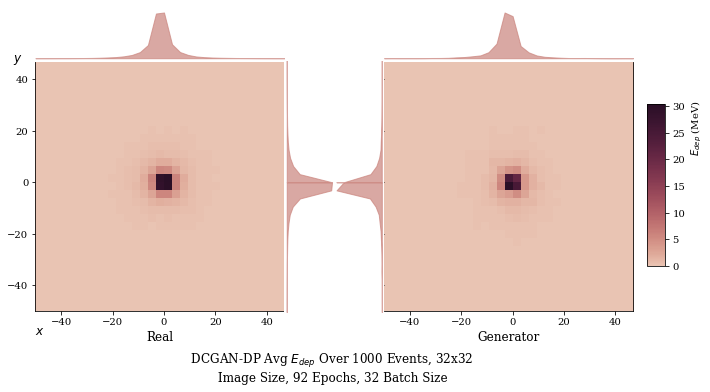

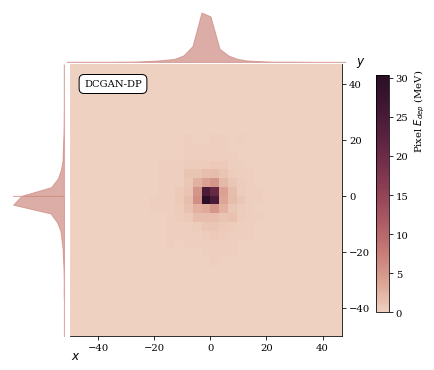

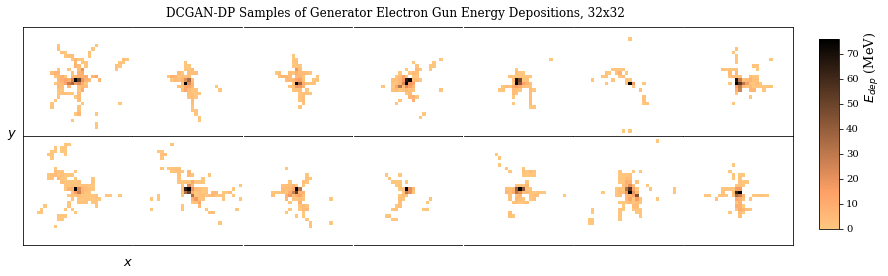

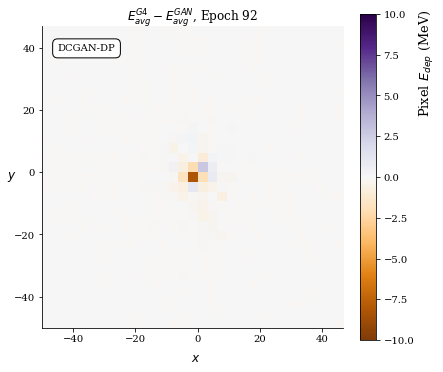

[92/50][0/938] Loss_D: 0.2304 Loss_G: 2.4505 D(x): 0.9883 D(G(z)): 0.1924 / 0.0981
[92/50][100/938] Loss_D: 0.1539 Loss_G: 2.2275 D(x): 0.9621 D(G(z)): 0.1064 / 0.1216
[92/50][200/938] Loss_D: 0.5751 Loss_G: 2.0335 D(x): 0.9914 D(G(z)): 0.4174 / 0.1463
[92/50][300/938] Loss_D: 0.7015 Loss_G: 0.4252 D(x): 0.9064 D(G(z)): 0.4341 / 0.6815
[92/50][400/938] Loss_D: 0.1336 Loss_G: 2.5005 D(x): 0.9745 D(G(z)): 0.1009 / 0.0945
[92/50][500/938] Loss_D: 0.9382 Loss_G: 0.2853 D(x): 0.9133 D(G(z)): 0.5506 / 0.7618
[92/50][600/938] Loss_D: 0.1011 Loss_G: 2.9560 D(x): 0.9755 D(G(z)): 0.0725 / 0.0618
[92/50][700/938] Loss_D: 1.9415 Loss_G: 0.2237 D(x): 0.9993 D(G(z)): 0.8429 / 0.8046
[92/50][800/938] Loss_D: 0.4680 Loss_G: 1.6759 D(x): 0.9864 D(G(z)): 0.3546 / 0.2035
[92/50][900/938] Loss_D: 0.5009 Loss_G: 2.0610 D(x): 0.9655 D(G(z)): 0.3576 / 0.1484
(32, 32)


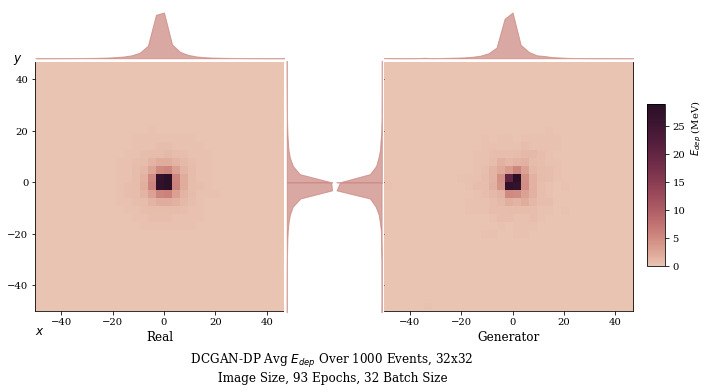

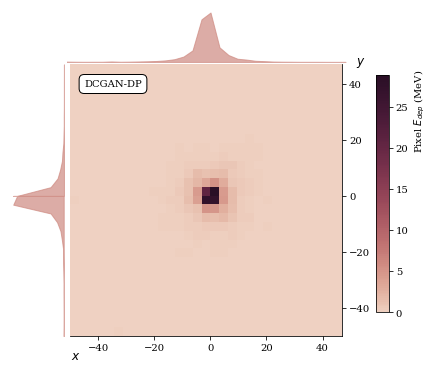

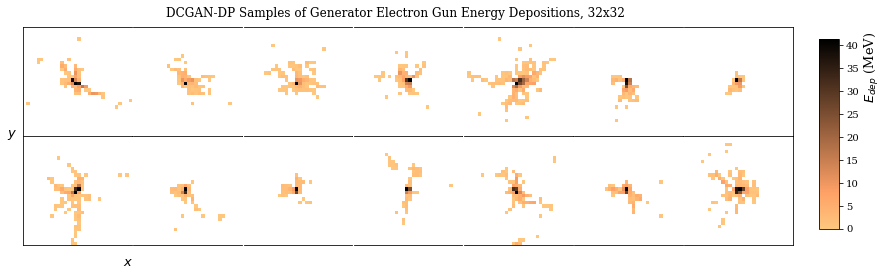

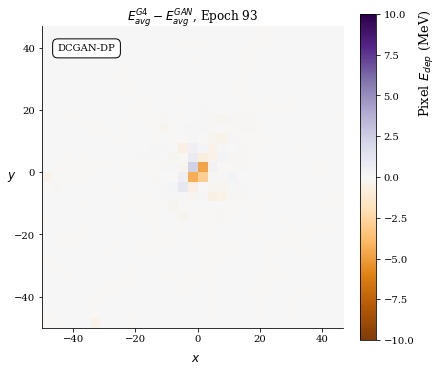

[93/50][0/938] Loss_D: 0.2723 Loss_G: 1.7389 D(x): 0.9486 D(G(z)): 0.1935 / 0.1924
[93/50][100/938] Loss_D: 0.3045 Loss_G: 1.7114 D(x): 0.9926 D(G(z)): 0.2504 / 0.1992
[93/50][200/938] Loss_D: 0.1567 Loss_G: 1.9640 D(x): 0.9465 D(G(z)): 0.0946 / 0.1604
[93/50][300/938] Loss_D: 0.6322 Loss_G: 1.2055 D(x): 0.9613 D(G(z)): 0.4236 / 0.3357
[93/50][400/938] Loss_D: 0.1252 Loss_G: 2.4397 D(x): 0.9918 D(G(z)): 0.1082 / 0.1009
[93/50][500/938] Loss_D: 0.3009 Loss_G: 1.7213 D(x): 0.9583 D(G(z)): 0.2241 / 0.1883
[93/50][600/938] Loss_D: 0.1144 Loss_G: 1.8007 D(x): 0.9306 D(G(z)): 0.0407 / 0.1818
[93/50][700/938] Loss_D: 0.2755 Loss_G: 1.9697 D(x): 0.9585 D(G(z)): 0.1994 / 0.1664
[93/50][800/938] Loss_D: 0.6040 Loss_G: 0.0939 D(x): 0.8159 D(G(z)): 0.3176 / 0.9130
[93/50][900/938] Loss_D: 0.3373 Loss_G: 1.7442 D(x): 0.9504 D(G(z)): 0.2385 / 0.1974
(32, 32)


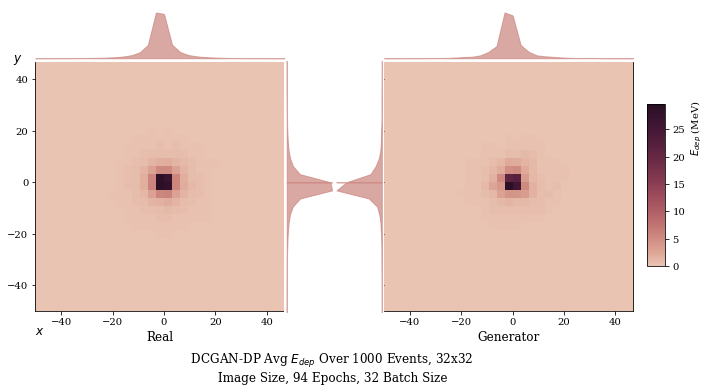

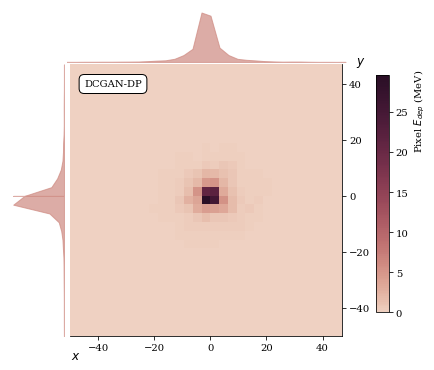

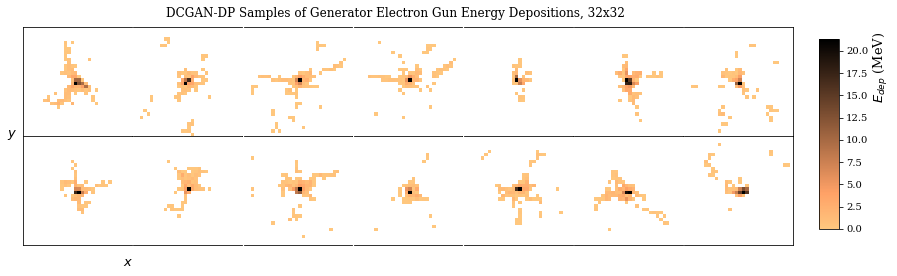

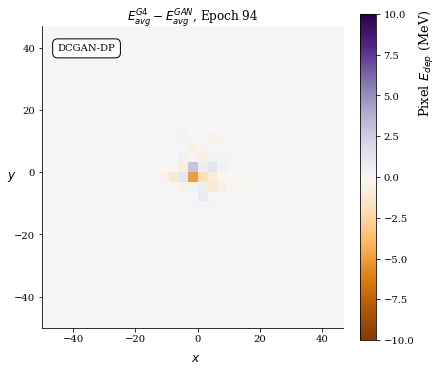

[94/50][0/938] Loss_D: 0.1560 Loss_G: 2.2057 D(x): 0.9643 D(G(z)): 0.1112 / 0.1232
[94/50][100/938] Loss_D: 0.7172 Loss_G: 1.6063 D(x): 0.9946 D(G(z)): 0.4939 / 0.2157
[94/50][200/938] Loss_D: 0.2051 Loss_G: 2.1994 D(x): 0.9752 D(G(z)): 0.1612 / 0.1320
[94/50][300/938] Loss_D: 0.3045 Loss_G: 1.1022 D(x): 0.9167 D(G(z)): 0.1904 / 0.3469
[94/50][400/938] Loss_D: 0.4371 Loss_G: 1.7262 D(x): 0.9861 D(G(z)): 0.3375 / 0.1893
[94/50][500/938] Loss_D: 0.5368 Loss_G: 1.9142 D(x): 0.9946 D(G(z)): 0.3949 / 0.1668
[94/50][600/938] Loss_D: 0.2396 Loss_G: 1.8311 D(x): 0.9442 D(G(z)): 0.1618 / 0.1820
[94/50][700/938] Loss_D: 0.7930 Loss_G: 0.8154 D(x): 0.9901 D(G(z)): 0.5223 / 0.4638
[94/50][800/938] Loss_D: 0.2213 Loss_G: 2.2829 D(x): 0.9639 D(G(z)): 0.1662 / 0.1089
[94/50][900/938] Loss_D: 0.4668 Loss_G: 2.3080 D(x): 0.9802 D(G(z)): 0.3521 / 0.1082
(32, 32)


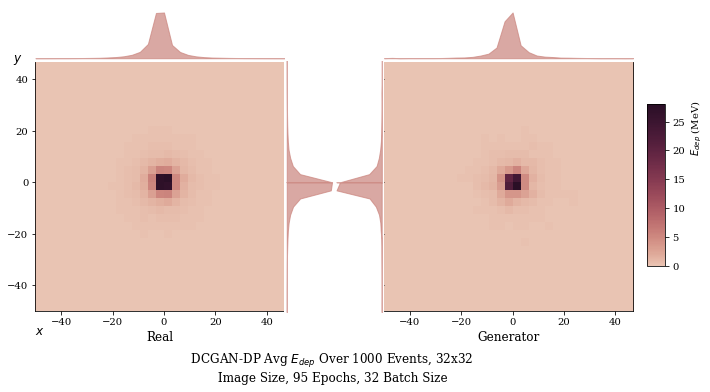

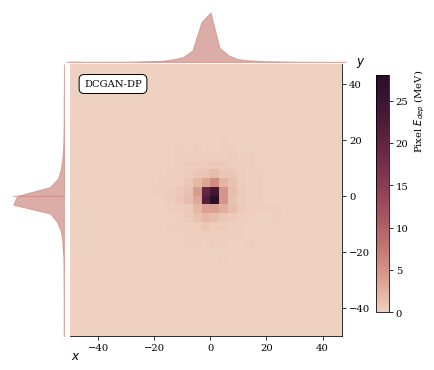

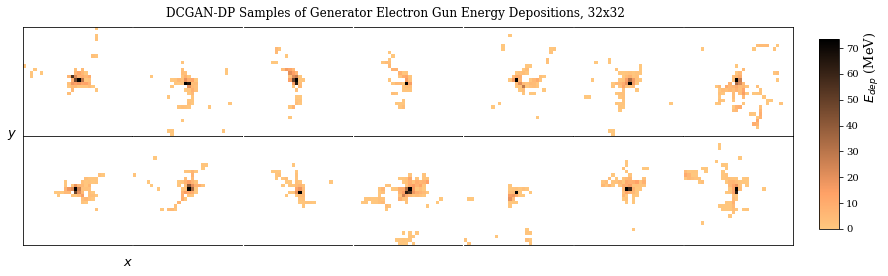

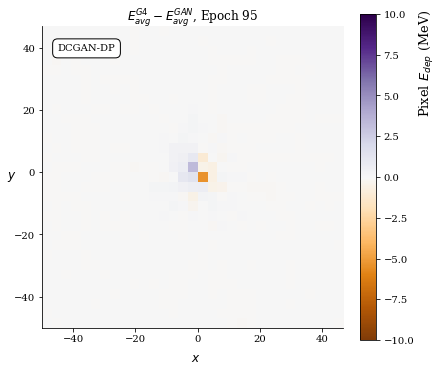

[95/50][0/938] Loss_D: 0.3852 Loss_G: 2.2375 D(x): 0.9838 D(G(z)): 0.2965 / 0.1260
[95/50][100/938] Loss_D: 0.2914 Loss_G: 1.7486 D(x): 0.9614 D(G(z)): 0.2147 / 0.2132
[95/50][200/938] Loss_D: 0.7976 Loss_G: 1.1142 D(x): 0.9649 D(G(z)): 0.5172 / 0.3464
[95/50][300/938] Loss_D: 0.3466 Loss_G: 2.0147 D(x): 0.9768 D(G(z)): 0.2728 / 0.1390
[95/50][400/938] Loss_D: 0.1685 Loss_G: 2.5433 D(x): 0.9639 D(G(z)): 0.1214 / 0.0897
[95/50][500/938] Loss_D: 0.6373 Loss_G: 0.9669 D(x): 0.9584 D(G(z)): 0.4228 / 0.4094
[95/50][600/938] Loss_D: 2.2410 Loss_G: 0.8332 D(x): 0.9949 D(G(z)): 0.8873 / 0.4450
[95/50][700/938] Loss_D: 0.5758 Loss_G: 1.3467 D(x): 0.9372 D(G(z)): 0.3850 / 0.2845
[95/50][800/938] Loss_D: 5.1607 Loss_G: 0.0890 D(x): 0.9997 D(G(z)): 0.9930 / 0.9165
[95/50][900/938] Loss_D: 0.2722 Loss_G: 2.2511 D(x): 0.9869 D(G(z)): 0.2200 / 0.1261
(32, 32)


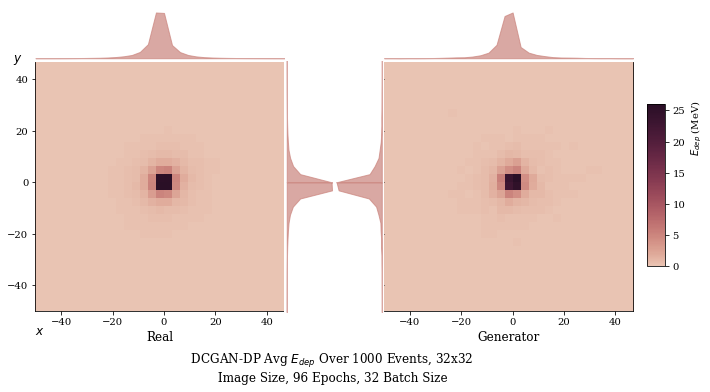

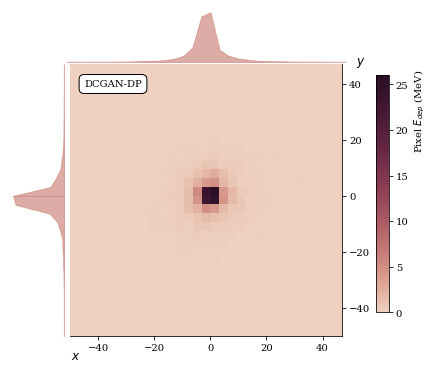

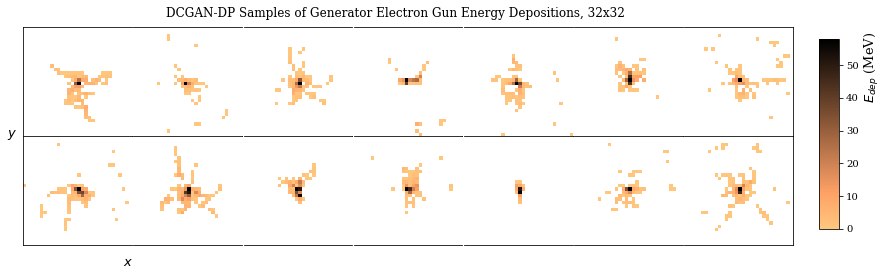

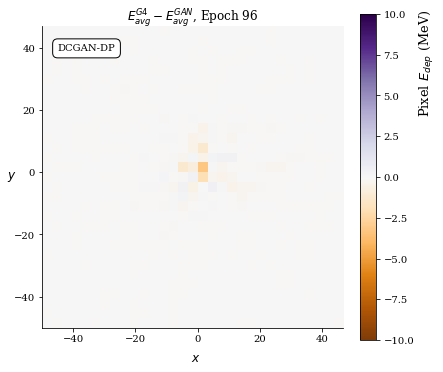

[96/50][0/938] Loss_D: 0.9086 Loss_G: 1.0857 D(x): 0.9876 D(G(z)): 0.5649 / 0.3696
[96/50][100/938] Loss_D: 0.7555 Loss_G: 1.8270 D(x): 0.9875 D(G(z)): 0.5102 / 0.1718
[96/50][200/938] Loss_D: 0.7221 Loss_G: 2.7600 D(x): 0.9929 D(G(z)): 0.4794 / 0.0831
[96/50][300/938] Loss_D: 0.8336 Loss_G: 2.1125 D(x): 0.9744 D(G(z)): 0.5228 / 0.1436
[96/50][400/938] Loss_D: 0.2219 Loss_G: 2.2623 D(x): 0.9695 D(G(z)): 0.1686 / 0.1208
[96/50][500/938] Loss_D: 1.4221 Loss_G: 0.5495 D(x): 0.9979 D(G(z)): 0.7299 / 0.6057
[96/50][600/938] Loss_D: 0.1837 Loss_G: 0.9003 D(x): 0.9083 D(G(z)): 0.0813 / 0.4314
[96/50][700/938] Loss_D: 0.6891 Loss_G: 1.0315 D(x): 0.9702 D(G(z)): 0.4533 / 0.3931
[96/50][800/938] Loss_D: 0.2214 Loss_G: 2.4019 D(x): 0.9887 D(G(z)): 0.1850 / 0.1055
[96/50][900/938] Loss_D: 0.3545 Loss_G: 1.2199 D(x): 0.9454 D(G(z)): 0.2498 / 0.3150
(32, 32)


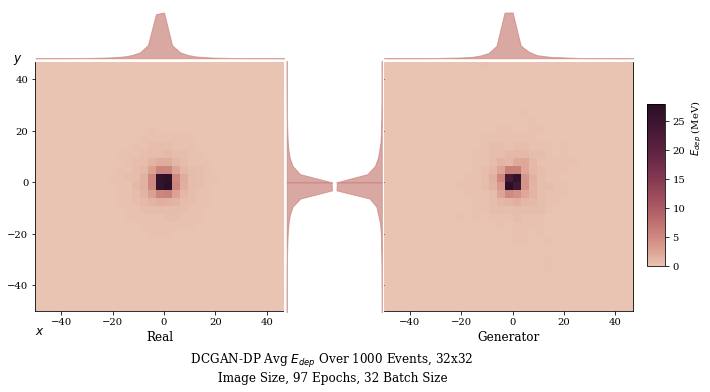

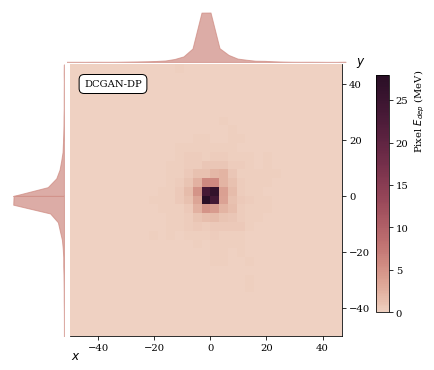

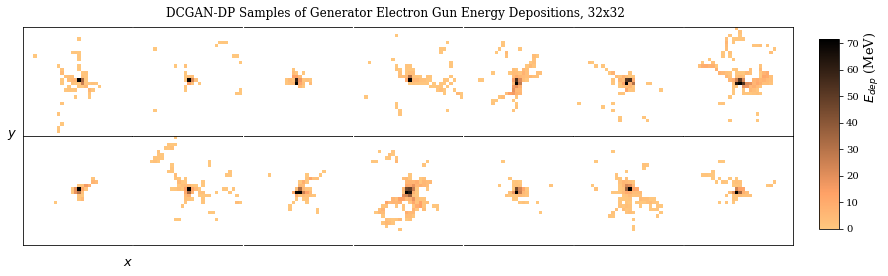

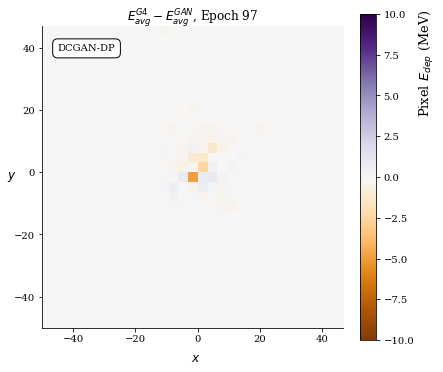

[97/50][0/938] Loss_D: 0.1754 Loss_G: 2.4537 D(x): 0.9724 D(G(z)): 0.1345 / 0.0981
[97/50][100/938] Loss_D: 0.1748 Loss_G: 2.7181 D(x): 0.9823 D(G(z)): 0.1428 / 0.0736
[97/50][200/938] Loss_D: 0.4224 Loss_G: 2.3353 D(x): 0.9936 D(G(z)): 0.3266 / 0.1172
[97/50][300/938] Loss_D: 1.3720 Loss_G: 1.0595 D(x): 0.9913 D(G(z)): 0.7230 / 0.3731
[97/50][400/938] Loss_D: 0.1862 Loss_G: 1.4005 D(x): 0.9297 D(G(z)): 0.1042 / 0.2847
[97/50][500/938] Loss_D: 0.2186 Loss_G: 2.1740 D(x): 0.9756 D(G(z)): 0.1690 / 0.1388
[97/50][600/938] Loss_D: 0.2036 Loss_G: 2.1175 D(x): 0.9723 D(G(z)): 0.1564 / 0.1423
[97/50][700/938] Loss_D: 0.1987 Loss_G: 1.7110 D(x): 0.9515 D(G(z)): 0.1349 / 0.2080
[97/50][800/938] Loss_D: 2.4453 Loss_G: 0.6367 D(x): 0.9994 D(G(z)): 0.8910 / 0.5672
[97/50][900/938] Loss_D: 3.9859 Loss_G: 0.5722 D(x): 0.9995 D(G(z)): 0.9533 / 0.6672
(32, 32)


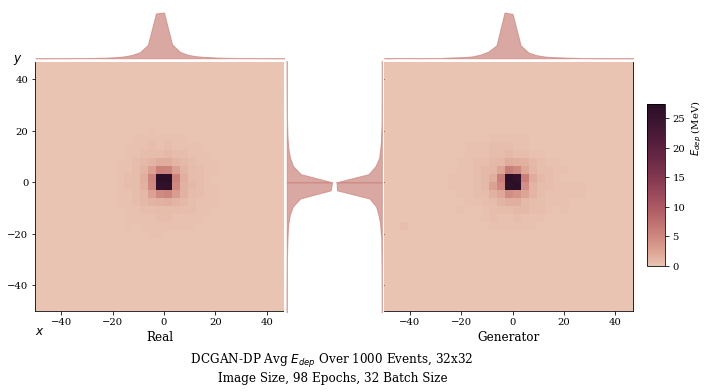

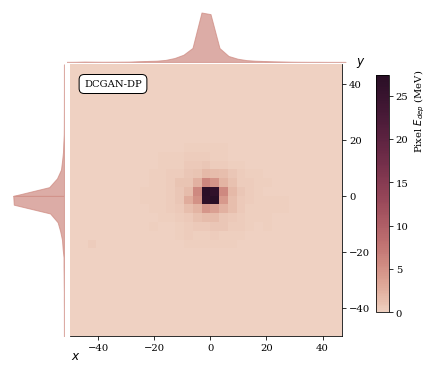

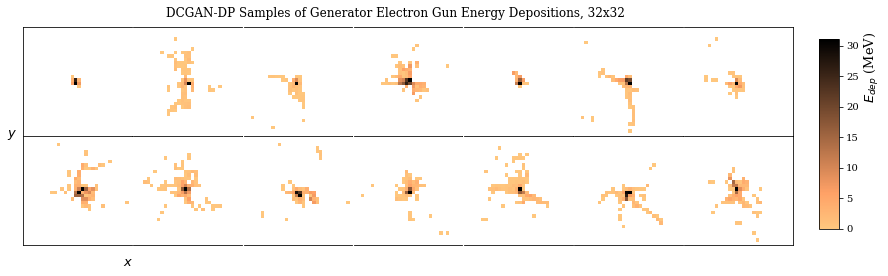

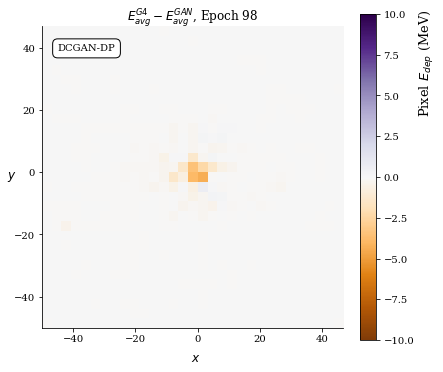

[98/50][0/938] Loss_D: 0.1446 Loss_G: 2.5186 D(x): 0.9802 D(G(z)): 0.1124 / 0.0947
[98/50][100/938] Loss_D: 0.3729 Loss_G: 2.3185 D(x): 0.9950 D(G(z)): 0.2984 / 0.1091
[98/50][200/938] Loss_D: 0.6226 Loss_G: 1.2454 D(x): 0.9963 D(G(z)): 0.4321 / 0.3220
[98/50][300/938] Loss_D: 0.1822 Loss_G: 2.3491 D(x): 0.9820 D(G(z)): 0.1493 / 0.1040
[98/50][400/938] Loss_D: 0.3841 Loss_G: 2.1114 D(x): 0.9726 D(G(z)): 0.2928 / 0.1306
[98/50][500/938] Loss_D: 0.1582 Loss_G: 0.6930 D(x): 0.9047 D(G(z)): 0.0539 / 0.5130
[98/50][600/938] Loss_D: 0.2832 Loss_G: 2.0577 D(x): 0.9629 D(G(z)): 0.2132 / 0.1401
[98/50][700/938] Loss_D: 3.6830 Loss_G: 0.4622 D(x): 0.9992 D(G(z)): 0.9650 / 0.6685
[98/50][800/938] Loss_D: 0.2317 Loss_G: 0.9708 D(x): 0.9181 D(G(z)): 0.1324 / 0.4110
[98/50][900/938] Loss_D: 0.2911 Loss_G: 1.1131 D(x): 0.9316 D(G(z)): 0.1899 / 0.3650
(32, 32)


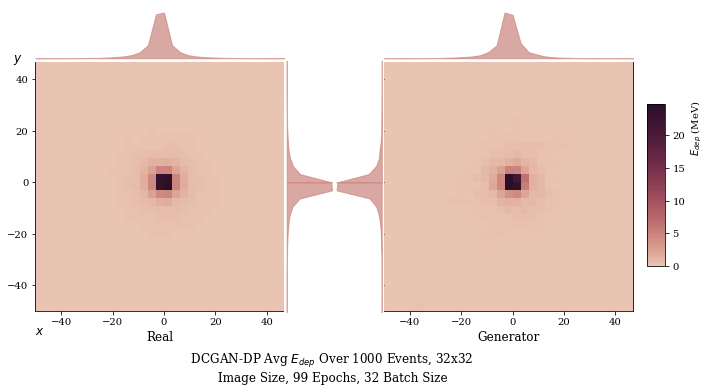

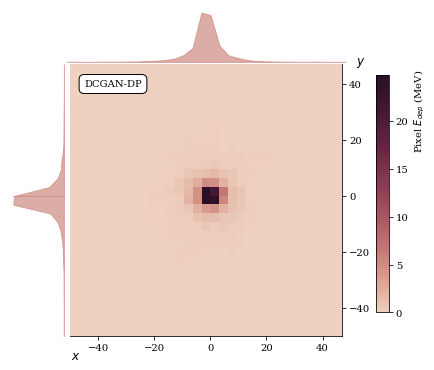

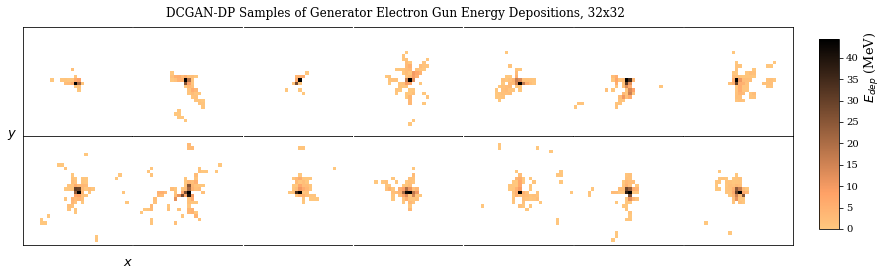

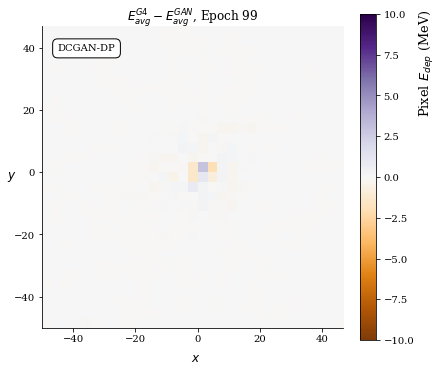

[99/50][0/938] Loss_D: 0.4407 Loss_G: 2.0002 D(x): 0.9820 D(G(z)): 0.3340 / 0.1500
[99/50][100/938] Loss_D: 0.2555 Loss_G: 2.1945 D(x): 0.9910 D(G(z)): 0.2146 / 0.1204
[99/50][200/938] Loss_D: 0.3825 Loss_G: 1.8748 D(x): 0.9674 D(G(z)): 0.2818 / 0.1779
[99/50][300/938] Loss_D: 0.8870 Loss_G: 0.6426 D(x): 0.9689 D(G(z)): 0.5581 / 0.5460
[99/50][400/938] Loss_D: 0.3676 Loss_G: 1.8420 D(x): 0.9820 D(G(z)): 0.2836 / 0.1904
[99/50][500/938] Loss_D: 0.1491 Loss_G: 1.7779 D(x): 0.9485 D(G(z)): 0.0900 / 0.2008
[99/50][600/938] Loss_D: 0.1134 Loss_G: 2.3722 D(x): 0.9612 D(G(z)): 0.0700 / 0.1102
[99/50][700/938] Loss_D: 0.1655 Loss_G: 2.1733 D(x): 0.9779 D(G(z)): 0.1314 / 0.1256
[99/50][800/938] Loss_D: 1.1920 Loss_G: 1.5235 D(x): 0.9958 D(G(z)): 0.6589 / 0.2500
[99/50][900/938] Loss_D: 0.5220 Loss_G: 0.9727 D(x): 0.9416 D(G(z)): 0.3544 / 0.4084


In [20]:
iter_range = range( 100 )
iter_range = tqdm(iter_range)


#make save directory
# mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/', 
#                      datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")

mydir = os.path.join('/home/chris/Dropbox/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
import errno
#mydir=None
print(mydir)
if mydir != None:
    try:
        os.makedirs(mydir)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
            
    with open(mydir + 'NetworkInfo.txt', 'w') as f:
        f.write( 'generator: ' +  str(netG) + "\n")
        f.write('discriminator: ' +  str(netD) + '\n')
        f.write('normalization scale: ' +  norm_scale + '\n')
        f.write('image height/width: ' + str(imageSize) + '\n')
        f.write('loss function: BCE with Roth Penalty \n')
        f.write('epochs:' + str(niter) + '\n')
        f.write('batch size:' + str(batchSize) + '\n')
        
        
        
        
# mydir = os.path.join('/home/chris/Dropbox/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/', 
#                      datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
# mydir = None
# if mydir != None:
#     try:
#         os.makedirs(mydir)
#     except OSError as e:
#         if e.errno != errno.EEXIST:
#             raise

#     with open(mydir + 'NetworkInfo.txt', 'w') as f:
#         print >> f, 'model:', model
#         print >> f, 'normalization scale:', norm_scale
#         print >> f, 'image height/width:', imageSize
#         print >> f, 'loss function: Regular GAN'
#         print >> f, 'batch size:', batchSize
#         print >> f, 'epochs:', niter
#        # print >> f, 'beta:', beta
#         print >> f, 'gun Energy:', energy
#         print >> f, 'last activation layer:', last_decode_act
#         print >> f, 'batch size:', batchSize
#       #  print >> f, 'unnormalize loss:', unnormalize_loss
        


extraD = 1
gamma=0.5
        
for epoch in iter_range:
    if True:       
        data, n_events = make_samples(netG, n_events = 1000, scale =scale, norm_scale=norm_scale)
        real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 1000,real= True, fake = True, 
                                                                scale = scale, norm_scale = norm_scale)
        print(data[0].shape)
        #genx_FWHM = hist_width(np.sum(data[1],1))
        #realx_FWHM = hist_width(np.sum(data[0],1))
        #genx_mean = np.sum(data[1],1).mean()
        #print(genx_mean)
        #realx_mean = np.sum(data[0],1).mean()
        #genx_FWHMs.append(genx_FWHM)
        #realx_FWHMs.append(realx_FWHM)
        #genx_means.append(genx_mean)
        #realx_means.append(realx_mean)
        #epochs.append(epoch)
        #plot_all_metrics(genx_FWHMs, realx_FWHMs, genx_means, realx_means,epochs = epochs, save_dir = mydir)
        #plot_sns(n_events, save_dir=mydir,  epoch = epoch)
        plot_avg_both(data[0],data[1], n_events, save_dir = mydir,  epoch = epoch)
        plot_avg(data[1], n_events, save_dir= mydir,  epoch = epoch)
        #plot_many(fake_data_array, real=False, save_dir=mydir, epoch = epoch)
        plot_many(fake_data_array, rows=2, columns=7, real=False, save_dir=mydir, epoch=epoch)
        #xsection_multi(data, epoch, savedir=mydir, imageSize=imageSize)
        #plot_many(real_data_array, real=True, save_dir=mydir, epoch = epoch)
        #if epoch % 1 == 0:
        plot_difference(data, save_dir = mydir, epoch = epoch, n_events = 5000)
        
        #if epoch > 0:
            #stats_r, stats_f = calc_means_stds(imageSize=imageSize, n_times = 10)
            #plot_means_stds(stats_r, stats_f, save_dir = mydir, trim = 20)
    for i, data in enumerate(dataloader,0):
        for j in range(extraD):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))), do it more than generator
            ###########################
            # train with real
            netD.zero_grad()
            real_cpu = data[0].to(device).requires_grad_()
            #print(device)
            batch_size = real_cpu.size(0)
            label_r = torch.full((batch_size,), real_label, device=device)
            #real_cpu.requires_grad_()
            output_r = netD(real_cpu)
            #real_cpu.requires_grad_()
            #output_r.sum().requires_grad_()
            errD_real = criterion(output_r, label_r)
            #errD_real.backward()
            D_x = output_r.mean().item()
            penalty = grad(output_r.sum(), real_cpu, create_graph=True)[0].view(-1,1).norm(2,1).pow(2).mean()
            (errD_real + (gamma/2) * penalty).backward()
            #print(penalty)


            # train with fake
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label_f = torch.full((batch_size,), fake_label, device=device)
            #label.fill_(fake_label)
            output_f = netD(fake.detach())
            errD_fake = criterion(output_f, label_f)
            errD_fake.backward()
            D_G_z1 = output_f.mean().item()
            errD = errD_real + errD_fake
            #(errD + (gamma/2) * penalty).backward()
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label_r.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label_r)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
#         if i % 500 == 0:
#             vutils.save_image(real_cpu.data,
#                     '%s/real_samples.png' % outf,
#                     normalize=True)
#             fake = netG(fixed_noise)
#             vutils.save_image(fake.detach(),
#                     '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
#                    normalize=True)

In [66]:
#FAKE
#from mpl_toolkits.axes_grid1 import make_axes_locatable



#data, n_events = make_samples(netG,n_events = 1000, real=True, fake=True)

#data_diff = data_test[0] - data_test[1]
#plot_avg(data[1], n_events = 1000, save_dir=None)
#samples(image_array, save_dir=mydir,  epoch = epoch, beta = beta)
import timeit

start = timeit.default_timer()

#samples(, save_dir=mydir,  rows=1, columns = 1,epoch = epoch, beta = beta)
fake_image = 0 #arctanh_unnormalize(test_image, scale)
real_image = 0
n_events = 1
for i in range(n_events):
    idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
    real_image += image_array[idx][0]
    noise = torch.randn(batchSize, nz, 1, 1, device=device)
    fake_output = netG(noise)
    gen_image = fake_output.to('cpu').detach().numpy()[0][0]
    fake_image +=  unnormalize(gen_image, scale, norm_scale = norm_scale)

stop = timeit.default_timer()

print('Time: ', stop - start) 

Time:  0.00150203704834


/home/chris/Dropbox/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/2018-08-27_00-28-34/


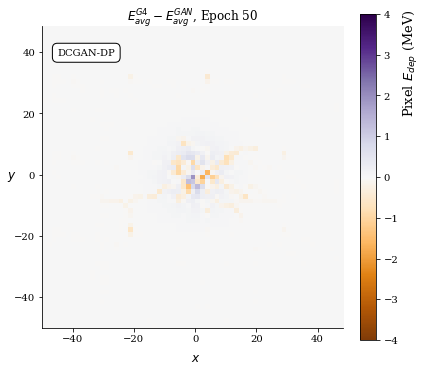

In [88]:
#data_test, n_events = make_samples(netG,n_events = 10000, real=True, fake=True)
print(mydir)
plot_difference(data_test, save_dir = mydir, epoch = 50)

/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/ipykernel_launcher.py:345: RuntimeWarning: invalid value encountered in less


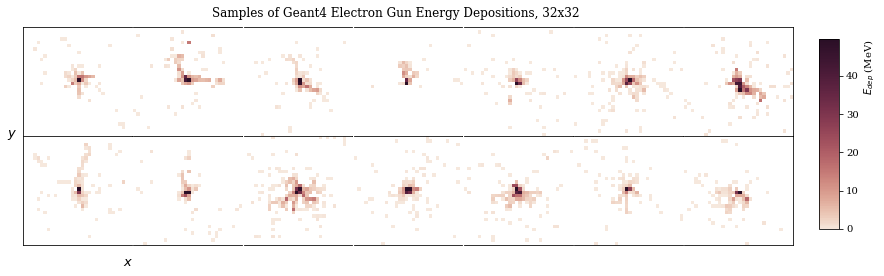

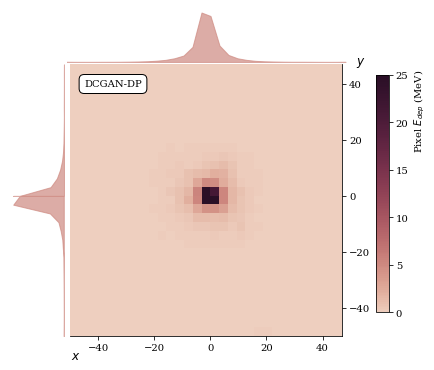

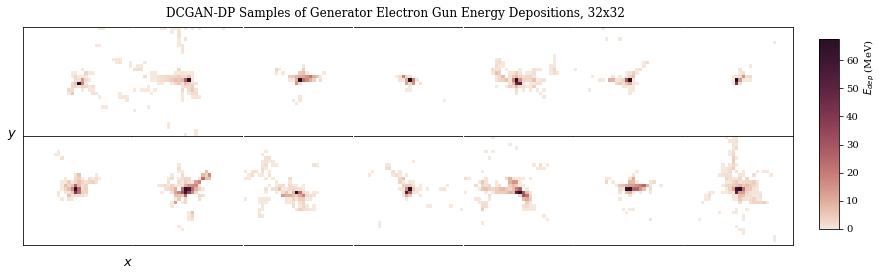

In [47]:
# mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/', 
#                      datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
# #mydir=None
# print(mydir)
# try:
#     os.makedirs(mydir)
# except OSError as e:
#     if e.errno != errno.EEXIST:
#         raise
        

#plot_sns(save_dir = None)
#real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 1000,real= True, fake = True)
plot_many(real_data_array, rows=2, columns=7, real=True, save_dir=mydir, epoch=epoch)
plot_avg(data_test[1], n_events, save_dir= mydir,  epoch = epoch)
plot_many(fake_data_array, rows=2, columns=7, real=False, save_dir=mydir, epoch=epoch)


In [54]:
test = np.squeeze(image_array)
for i in range(test.shape[0]):
    if np.isnan(test[i].max()) ==True:
        print(i)

In [ ]:
#REAL
plt.rc('font', family='serif')
many_samples = True
n_events = 5000
#make single samples for both real and fake. then make many samples and average if many_samples = True

#real
idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
real_image = image_array[idx][0]

#fake
noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake = netG(noise)
fake_image = fake.to('cpu').detach().numpy()[0][0]
test_unnormed =  arctanh_unnormalize(fake_image, scale)

if many_samples == True:
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image += image_array[idx][0]
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        fake_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed +=  arctanh_unnormalize(fake_image, scale)

real_image = real_image / n_events
test_unnormed = test_unnormed / n_events
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(9, 6), sharex=True, sharey=True)
xran = (-50,50)
yran = (-50,50)
extent = xran + yran





real_image[real_image < 0.0] = np.nan
cmap = sns.cubehelix_palette(dark = 0.4, light=0.915, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
im = ax1.imshow(real_image, vmin = 0, extent=extent, origin='lower', cmap=cmap)




ax1.set_title("Real")
#cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
#cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        
test_unnormed[test_unnormed < 0.0] = np.nan
im = ax2.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
ax2.set_title("Generator")

fig.tight_layout(rect=[0, 0, .9, 1])
cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
fig.subplots_adjust(wspace=0.1, hspace=0)
fig.suptitle(r" DCROTHGAN Avg $E_{dep}$ Over " + str(n_events) + " Events, "
             + str(imageSize) + "x" +str(imageSize) + " Image Size, " + str(niter) 
             + " Epochs, " + str(batchSize) + " Batch Size", x = 0.5, y = 0.9)
plt.show()

In [412]:
mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + '/')
print(mydir)
try:
    os.makedirs(mydir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/2018-05-16_17-09-05/


In [293]:
data_test, n_events = make_samples(netG,n_events = 10000, real=True, fake=True)
mydir = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/2018-05-18_18-39-35/"

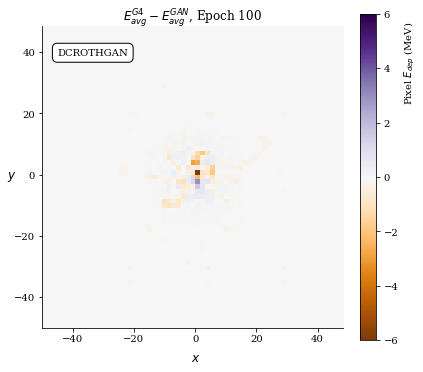

In [320]:

def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
#mean_normalizer = data_test[1][data_test[1] > 0.0].max()
    data = (real_fake_list[0] - real_fake_list[1]) 
#plot_avg(data_diff, n_events = 5000, save_dir=None)
    test_noNans = np.copy(data)
    test_unnormed = data
#test_unnormed[test_unnormed < ] = np.nan

    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    #cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
    #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
    #cmap = sns.color_palette("BrBG", 7, as_cmap=True)
    cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()


    fig, ax=plt.subplots(figsize=(6, 6))
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
    im = ax.imshow(test_unnormed, vmin = -6,vmax = 6, extent=extent, origin='lower', cmap='PuOr', label ='DCROTHGAN')
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    plt.title(r"$E_{avg}^{G4} - E_{avg}^{GAN}$, Epoch " + str(epoch))
    ax.text(-45, 39, 'DCROTHGAN', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    #plt.legend(loc = 'best')
    ax.set_xlim(tlim)
    ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
    ax.xaxis.set_label_coords(0.51,-0.08)
    ax.set_ylim(tlim)
    ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax.yaxis.set_label_coords(-.1,0.48)
    ax.spines["top"].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_EdepDifference"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')

    plt.show()
    return

plot_difference(data_test, save_dir = mydir, epoch = 100)


In [ ]:

def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale)
#mean_normalizer = data_test[1][data_test[1] > 0.0].max()
data = (real_fake_list[0] - real_fake_list[1]) 
#plot_avg(data_diff, n_events = 5000, save_dir=None)
withMarginals = False
save_dir = mydir
test_noNans = np.copy(data)
test_unnormed = data
#test_unnormed[test_unnormed < ] = np.nan

xran = (-50,50)
yran = (-50,50)
extent = xran + yran
#cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
#cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
#cmap = sns.color_palette("BrBG", 7, as_cmap=True)
cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()

if withMarginals == False:
    fig, ax=plt.subplots(figsize=(6, 6))
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
    im = ax.imshow(test_unnormed, vmin = -6,vmax = 6, extent=extent, origin='lower', cmap='PuOr')
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    plt.title("DCROTHGAN Difference between average Geant4 \n Image and Average Generator Image")
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_EdepDifference"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')

else:
    fig=plt.figure(figsize=(6, 6))
    marginals_str = 'withMarginals'
    img=test_noNans
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())

    gs = gridspec.GridSpec(2, 2, width_ratios=[1,5], height_ratios=[1,5])
    gs.update(hspace=0, wspace=0)

    ax = fig.add_subplot(gs[1,1])
    im = ax.imshow(test_unnormed, vmin = -10, vmax = 10, extent = extent, origin = 'lower', cmap = 'PuOr')
    cbaxes = fig.add_axes([0.97, 0.18, 0.03, 0.55]) 
    cbar = plt.colorbar(mappable=im, ticks = None, cax=cbaxes, use_gridspec=True)
    ax.yaxis.set_ticks_position('right')
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    ax.spines["top"].set_visible(False)
    ax.spines['left'].set_visible(False)

    axl = fig.add_subplot(gs[1,0], sharey=ax)
    axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
    axl.invert_xaxis()
    axb = fig.add_subplot(gs[0,1], sharex=ax)
    axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])

    plt.setp(axl.get_yticklabels(), visible=False)
    plt.setp(axb.get_xticklabels(), visible=False)
    plt.setp(axl.get_xticklabels(), visible=False)
    plt.setp(axb.get_yticklabels(), visible=False)

    axl.yaxis.set_ticks_position('none')
    axb.xaxis.set_ticks_position('none')
    axl.xaxis.set_ticks_position('none')
    axb.yaxis.set_ticks_position('none')


    axl.spines["top"].set_visible(False)
    axl.spines['right'].set_visible(False)
    axl.spines['left'].set_visible(False)
    axl.spines['bottom'].set_visible(False)
    axb.spines["top"].set_visible(False)
    axb.spines["right"].set_visible(False)
    axb.spines["left"].set_visible(False)
    axb.spines["bottom"].set_visible(False)
    ax.set_xlim(tlim)
    ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
    ax.xaxis.set_label_coords(0.02,-0.05)
    ax.set_ylim(tlim)
    ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax.yaxis.set_label_coords(1.07,0.98)
    plt.title("DCROTHGAN Difference between average Geant4 Image \n and Average Generator Image")
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_EdepDifference"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()


/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/ipykernel_launcher.py:343: RuntimeWarning: invalid value encountered in less_equal


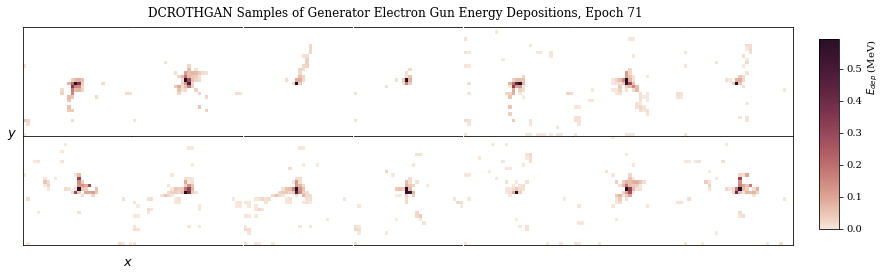

In [123]:
# def plot_many(data, rows = 1,columns = 4, real = True, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
#     xran = (-50,50)
#     yran = (-50,50)
#     extent = xran + yran
    
#     if rows <= 2 and columns <=4:
#         scale_factor = 3.5
#     else:
#         scale_factor = 2
    
#     fig, axes =plt.subplots(rows,columns, figsize=(scale_factor*columns, scale_factor*rows), sharex=True,sharey=True)
#     #print(len(axes))
#     event_number = 0
#     plt.locator_params(axis='y', nbins=1)
#     plt.locator_params(axis='x', nbins=2)
#     #fig.xticks(rotation=45)
#     for i in range(rows):
#         for j in range(columns):

#             #print(range(rows))
#             image_array = data[event_number]

#             image_array[image_array < 0.01] = np.nan
#             cmap = sns.cubehelix_palette(dark = 0.4, light=0.965, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#             #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
#             #cmap = sns.dark_palette('muted purple', as_cmap=True, input='xkcd')
#             #cmap = sns.color_palette("BrBG",7)
#             #img = ax.imshow(image_array[0], vmin = 0, extent=extent, origin='lower', cmap=cmap)
#             #axes[i,j].set_aspect('equal')
#             plt.axis('on')
#             if rows == 1:
#                 #axes[j] = plt.subplot(gs1[i,j])
#                 if j != 0:
#                     axes[j].spines['left'].set_visible(False)
#                 else:
#                     axes[j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
#                     axes[j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
#                 axes[j].spines['top'].set_visible(False)
#                 axes[j].spines['right'].set_visible(False)
#                 #axes[j].spines['bottom'].set_visible(False)
#                 #axes[j].spines['left'].set_visible(False)
#                 #axes[j].set_aspect('equal')
#                 im =axes[j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
#                 #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
#                 axes[j].set_xticklabels([])
#                 axes[j].set_yticklabels([])
#                 axes[j].xaxis.set_ticks_position('none')
#                 axes[j].yaxis.set_ticks_position('none')
#                 event_number +=1
#             else:
#                 #axes[i,j].spines['top'].set_visible(False)
#                 axes[i,j].spines['bottom'].set_visible(True)
#                 if j!= 0:
#                     axes[i,j].spines['left'].set_visible(False)
#                 if i == range(rows)[-1] and j == 0:
#                     axes[i,j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
#                     axes[i,j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                    
#                 if j == range(columns)[-1]:
#                     axes[i,j].spines['right'].set_visible(True)
#                 else:
#                     axes[i,j].spines['right'].set_visible(False)
#                 im =axes[i,j].imshow(image_array, vmin = 0,  extent=extent, origin='lower', cmap=cmap)
#                 #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
#                 axes[i,j].set_xticklabels([])
#                 axes[i,j].set_yticklabels([])
#                 axes[i,j].xaxis.set_ticks_position('none')
#                 axes[i,j].yaxis.set_ticks_position('none')
#                 event_number +=1
#     #fig.tight_layout(rect=[0, 0, .9, 1])
#     cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.66])
#    # fig.text(0.5,0.04, "Some very long and even longer xlabel", ha="center", va="center")
#     #fig.text(0.05,0.5, "Some quite extensive ylabel", ha="center", va="center", rotation=90)

#     cb = fig.colorbar(im, cax=cbar_ax)
#     cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
#     #plt.tight_layout()
#     fig.subplots_adjust(wspace=-0.085, hspace=0.00)
#     if real == True:
#         fig.suptitle("Samples of Geant4 Electron Gun Energy Depositions", y = 0.95)
#     else:
#         fig.suptitle("DCROTHGAN Samples of Generator Electron Gun Energy Depositions, Epoch " + str(epoch), y=0.95)
    
#     num_samples = rows *columns
        
        
#     if save_dir != None:
#         if real == True:
#             type_string = "real"
#         else:
#             type_string = "fake"
        
#         learning_rate = '%.0E' % Decimal(lr)
#         #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
#         filename = "DCROTHGAN_"+str(num_samples) + type_string+ "SamplesEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
#                             + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr"
#         #print(save_dir)
#         plt.savefig(save_dir + filename, bbox_inches='tight')
    
        
#     plt.show()
#     return



plot_many(fake_data_array, rows=2, columns=7, real=False, save_dir=mydir, epoch=epoch, norm_scale=norm_scale)

2.0272846


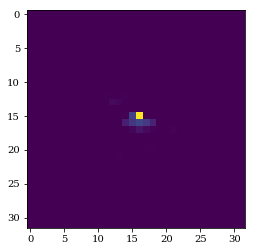

In [141]:
noise = torch.randn(batchSize, nz, 1, 1, device=device)
fake_output = netG(noise)
gen_image = fake_output.to('cpu').detach().numpy()[0][0]
print(gen_image.max())
plt.imshow(gen_image)

#data, n_events = make_samples(netG, n_events = 1000)
#real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 1000,real= True, fake = True)

In [47]:
fake_data_array.max()

9.704778

In [135]:
# genx_FWHMs = genx_FWHMs[-50:]
# realx_FWHMs = realx_FWHMs[-50:]
# genx_means = genx_means[-50:]
# realx_means = realx_means[-50:]
# epochs = epochs[-50:]

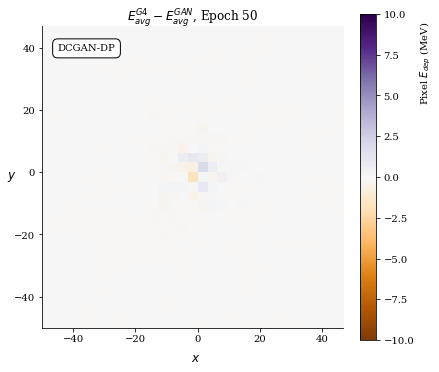

In [66]:
data_test, n_events = make_samples(netG,n_events = 10000, real=True, fake=True)

plot_difference(data_test, save_dir = mydir, epoch = 50)

In [69]:
#KL CALCULATION

from scipy.stats import entropy
entro = 0
num = 2
for i in range(num):
    #p_nois = sample_noise(10000, n_latent)
    #outputs = netG(p_nois).cpu().data.numpy()
    #real_sample = sample_real(a=0.6, b=0.6,n_samples = 10000).cpu().data.numpy()
    data, n_events = make_samples(netG, n_events = 10000, scale =scale, norm_scale=norm_scale)
    real_sample_histo = data[0]
    outputs_histo = data[1]
    #outputs_histo, obins = np.histogram(outputs, bins = 20) 
    #real_sample_histo, sbins = np.histogram(real_sample, bins = 20)
    gen_probs = (np.ndarray.flatten(outputs_histo.astype(float)) / outputs_histo.sum()) + .00001
    real_probs = (np.ndarray.flatten(real_sample_histo.astype(float)) / real_sample_histo.sum()) + .00001
    #print(real_probs.sum())
    entro += entropy(gen_probs, real_probs)
    
entro = entro / num
print(entro)

2.49188131510223


(32,)


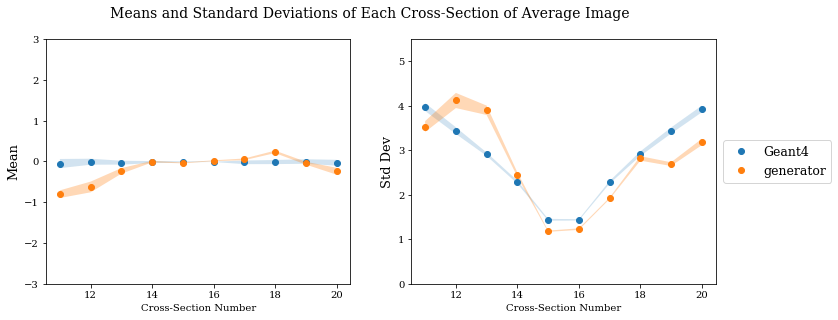

In [67]:
def calc_means_stds(imageSize=imageSize, n_times= 50):
    means_r_lists = []
    stds_r_lists = []
    means_f_lists = []
    stds_f_lists = []
    for i in range(n_times):
        data_avg, n_events = make_samples(netG, avg = True, n_events = 2500, norm_scale=norm_scale)
        if imageSize == 64:
            mini = -31.5
            maxi = 32.5
        elif imageSize == 32:
            mini = -15.5
            maxi = 16.5
        #bins = np.arange(-16,17,1)
        #bins = 0.5*(bins[1:] + bins[:-1])
        bins = np.tile(np.arange(mini,maxi,1),imageSize).reshape(imageSize,imageSize)
        #bins = np.tile(bins,imageSize).reshape(imageSize,imageSize)
        #mids = 0.5*(bins[:] + bins[:])
        #print(bins.shape)
        #print(data_set.shape, bins.shape, data_avg[0].shape)
        means_r = np.average(bins, weights=data_avg[0], axis = 1)
        stds_r = np.sqrt(np.average((bins - means_r)**2, weights=data_avg[0], axis=1))
        means_r_lists.append(means_r)
        stds_r_lists.append(stds_r)
        means_f = np.average(bins, weights=data_avg[1], axis = 1)
        stds_f = np.sqrt(np.average((bins - means_f)**2, weights=data_avg[1], axis=1))
        means_f_lists.append(means_f)
        stds_f_lists.append(stds_f)
    return [means_r_lists, stds_r_lists], [means_f_lists, stds_f_lists]

stats_r, stats_f = calc_means_stds(imageSize=imageSize, n_times = 10)

def plot_means_stds(stats_r, stats_f, save_dir = mydir, trim = 10):
    slice_ixs = np.arange(0,imageSize,1)
    if len(stats_r[0]) < 2:
        fig, axes = plt.subplots(1,2, figsize=(12,4))
        axes[0].scatter(slice_ixs, means_lists)
        axes[1].scatter(slice_ixs, stds_lists)
    else:
        means_r_lists = stats_r[0]
        stds_r_lists = stats_r[1]
        std_errs_r = np.array(stds_r_lists).std(0)
        mean_errs_r = np.array(means_r_lists).std(0)
        print(mean_errs_r.shape)
        means_r = np.array(means_r_lists).mean(0)
        stds_r = np.array(stds_r_lists).mean(0)
        means_f_lists = stats_f[0]
        stds_f_lists = stats_f[1]
        std_errs_f = np.array(stds_f_lists).std(0)
        mean_errs_f = np.array(means_f_lists).std(0)
        means_f = np.array(means_f_lists).mean(0)
        stds_f = np.array(stds_f_lists).mean(0)
        
        fig, axes = plt.subplots(1,2, figsize=(12,4.5))
        axes[0].plot(slice_ixs[trim:-trim], means_r[trim:-trim], 'o', label = 'Geant4')
        axes[1].plot(slice_ixs[trim:-trim], stds_r[trim:-trim], 'o')
        #axes[0].errorbar(slice_ixs, means_r, yerr=mean_errs_r)
        #axes[1].errorbar(slice_ixs, stds_r, yerr=std_errs_r)
        axes[0].fill_between(slice_ixs[trim:-trim], 
                             means_r[trim:-trim]-mean_errs_r[trim:-trim], means_r[trim:-trim]+mean_errs_r[trim:-trim], alpha = 0.2)
        axes[1].fill_between(slice_ixs[trim:-trim], 
                             stds_r[trim:-trim]-std_errs_r[trim:-trim], stds_r[trim:-trim]+std_errs_r[trim:-trim], alpha = 0.2)
        
        axes[0].plot(slice_ixs[trim:-trim], means_f[trim:-trim], 'o', label ='generator')
        axes[1].plot(slice_ixs[trim:-trim], stds_f[trim:-trim], 'o')
        #axes[0].errorbar(slice_ixs, np.array(means_lists).mean(0), yerr=mean_errs)
        #axes[1].errorbar(slice_ixs, np.array(stds_lists).mean(0), yerr=std_errs)
        axes[0].fill_between(slice_ixs[trim:-trim], 
                             means_f[trim:-trim]-mean_errs_f[trim:-trim], means_f[trim:-trim]+mean_errs_f[trim:-trim], alpha = 0.3)
        axes[1].fill_between(slice_ixs[trim:-trim], 
                             stds_f[trim:-trim]-std_errs_f[trim:-trim], stds_f[trim:-trim]+std_errs_f[trim:-trim], alpha = 0.3)
        axes[0].set_ylim(-3,3)
        axes[1].set_ylim(0,5.5)
        axes[0].legend(bbox_to_anchor=[2.6, 0.5], loc='center right', fontsize=12.5)
        axes[0].set_ylabel("Mean", fontsize = 13)
        axes[1].set_ylabel("Std Dev", fontsize = 13)
        axes[0].set_xlabel("Cross-Section Number")
        axes[1].set_xlabel("Cross-Section Number")
        #plt.subplots_adjust(wspace=0, hspace=0)
        fig.suptitle(r"Means and Standard Deviations of Each Cross-Section of Average Image", fontsize=14)
        if save_dir != None:
            plt.savefig(save_dir + "MetricsCross-Section_Multi" + str(epoch) + ".pdf", bbox_inches='tight')
        plt.show()
    return

plot_means_stds(stats_r, stats_f, trim = 11)

In [52]:
data_avg, n_events = make_samples(netG, avg = True, n_events = 10000, norm_scale=norm_scale)

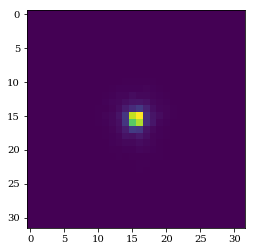

In [40]:
plt.imshow(data_avg[1])